In [112]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using PyPlot
using StatsBase
using Images
using BenchmarkTools
using CUDA
using Serialization

In [113]:
Threads.nthreads()

4

## Load Data

#### Bathymetry Map (for measurement model)

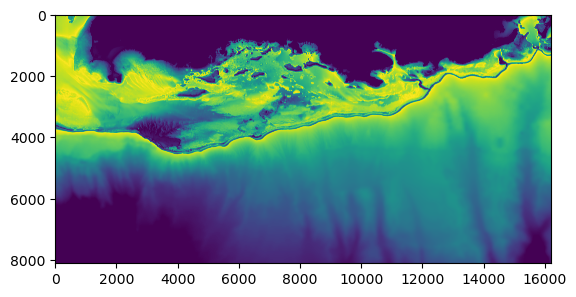

In [114]:
# Open the tiff file
filename = "PuertoRico_SouthWest_Color.tif"
img = load(filename)

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image    
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))
    
    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    
    return pixel_value 
end

# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

bathy_map = value_image[1500:2500,6000:8000];

## Particle Filter Models
Use closures to create dynamics and measurement models

#### Dynamics Model

In [117]:
function glider_dynamics_model(x, u, rng, delta_t)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
        
    # Update position based on state
    x_step = x_pos + delta_t*v*cos(θ)
    y_step = y_pos + delta_t*v*sin(θ)
    θ_step = θ + delta_t*dθ

    # Update velocities based on input
    v_step = v + delta_t*(in_thruster-v)
    dθ_step = dθ + delta_t*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

function generate_dynamics_model(delta_t)
    return (x, u, rng) -> glider_dynamics_model(x, u, rng, delta_t)
end

# dynamics_model = generate_dynamics_model(delta_t)

generate_dynamics_model (generic function with 1 method)

#### Measurement Model

In [118]:
# Measurement Model
# (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y, measurement_std, bathy_map)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y
    
    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, measurement_std)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

function generate_measurement_model(measurement_std, bathy_map)
    return (x1, u, x2, y) -> glider_measurement_model(x1, u, x2, y, measurement_std, bathy_map)
end

# measurement_model = generate_measurement_model(measurement_std, bathy_map)

generate_measurement_model (generic function with 1 method)

## Generate Dataset

In [119]:
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data_from_func(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0, delta_t=0.1)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = [xs[i], ys[i], θs[i], vs[i], dθs[i]]
        u = [in_thruster[i], in_rudder[i]]
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            glider_dynamics_model(state, u, rng, delta_t)
    end
    
    return xs, ys, θs, vs, dθs
end

function simulate_measurements(xs, ys, map, measurement_std)
    output = similar(xs)
    
    noise_dist = Normal(0, measurement_std)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map) + rand(noise_dist)
    end
    
    return output
end

simulate_measurements (generic function with 1 method)

#### Preview & Save Generated Trajectory
Note: For consistency in benchmarking, we'll save a couple trajectories and only use those instead of generating random ones for each test. This code is commented out because it doesn't need to be run 

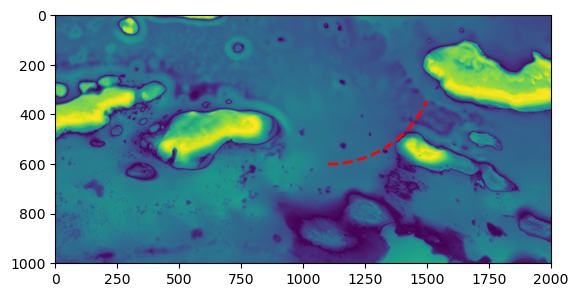

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000210F3B00370>

In [120]:
# Start in middle of map
START_X = 1100 
START_Y = 600
START_θ = 0

# START_X = 500 
# START_Y = 200
# START_θ = 0

# For previewing
SIM_TIME = 1000 # s
N_STEPS = 1001

ts = range(0, stop=SIM_TIME, length=N_STEPS)
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

generated_func = generate_random_func()
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data_from_func(ts, generated_func)

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ, delta_t=DELTA_T)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)

In [121]:
# # Save Function to file, if desired
# open("generated_func7.jls", "w") do io
#     serialize(io, generated_func)
# end

#### Dataset Generator Functions

In [122]:
function generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)
    ts = range(0, stop=sim_time, length=n_steps)
    delta_t = ts[2] - ts[1]
    
    in_thruster = 0.5*ones(size(ts))
    in_rudder = 0.1*generate_data_from_func(ts, input_func)

    xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
        start_x=start_x, start_y=start_y, start_θ=start_θ, delta_t=delta_t)

    measurements = simulate_measurements(xs, ys, bathy_map, measurement_std)
    
    return xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements
end

generate_data (generic function with 1 method)

## ParticleFilters.jl

In [107]:
function compute_initial_particles(n_particles, init_std_pos, init_std_rot, start_x, start_y, start_θ)
    init_particles = Vector{Vector{Float64}}(undef, n_particles)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)
    
    for i in 1:n_particles
        # Generate sample
        x = start_x + rand(dist_pos_init)
        y = start_y + rand(dist_pos_init)
        θ = start_θ + rand(dist_rot_init)
        init_particles[i] = [x, y, θ, 0, 0]
    end

    return init_particles
end

compute_initial_particles (generic function with 1 method)

In [108]:
function bench_pf(
        n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map, # Modelling params
        start_x, start_y, start_θ, sim_time, n_steps, input_func, # Dataset params
        num_evals, num_samples, plot=true) # Benchmarking params
    
    delta_t = range(0, stop=sim_time, length=n_steps)[2] - 
              range(0, stop=sim_time, length=n_steps)[1]
    
    dynamics_model = generate_dynamics_model(delta_t)
    measurement_model = generate_measurement_model(measurement_std, bathy_map)
    
    pf_model = ParticleFilterModel{Vector{Float64}}(dynamics_model, measurement_model)

    fil = BootstrapFilter(pf_model, n_particles) # Takes in model, number of particles

    # construct initial belief
    init_particles = compute_initial_particles(n_particles, 
            init_std_pos, init_std_rot, start_x, start_y, start_θ)
    b0 = ParticleCollection(init_particles)
    
    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

    # Plot initial samples
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        for p in init_particles
            ax.plot(p[1], p[2], "r.")
        end
    end
    
    # Convert inputs to usable form for pf
    inputs = [in_thruster, in_rudder]

    # Preallocate the output vector for performance
    us = Vector{Vector{Float64}}(undef, length(in_thruster))

    # Convert each pair of values to a vector and store in the output vector
    for i in 1:length(in_thruster)
        us[i] = [inputs[1][i], inputs[2][i]]
    end

    # Actually compute results. Inputs: filter, initial particles, data 
    pf_result = runfilter(fil, b0, us, measurements); 
#     bench_result = @benchmark runfilter($fil, $b0, $us, $measurements) evals=num_evals samples=num_samples
#     display(bench_result)
    elapsed_time = @elapsed runfilter(fil, b0, us, measurements); 
    
    filtered_xs = [m[1] for m in map(mean, pf_result)]
    filtered_ys = [m[2] for m in map(mean, pf_result)]

    # Plot results
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(filtered_xs, filtered_ys, "y")
    end
    
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((filtered_xs - xs).^2 + (filtered_ys - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, pf_result, error
end

bench_pf (generic function with 2 methods)

#### CPU Benchmark Test

In [123]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
measurement_std = 0.2
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

# n_particles_test = [10, 100, 1000, 2000, 3000]
# n_particles_test = [10000]

# for n_particles in n_particles_test
#     bench_result, pf_result = bench_pf(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
#             start_x, start_y, start_θ, sim_time, n_steps, input_func,
#             num_evals, num_samples);
# end

max_trials = 5
cpu_num_trials =       [5]#,   5,  5,   4,   3,   2,    1,    1,    1,     1] 
cpu_n_particles_test = [10]#, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]

cpu_timing_results = zeros(max_trials, size(cpu_n_particles_test)[1])
cpu_error_results = zeros(max_trials, size(cpu_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(cpu_n_particles_test)
    num_trials = cpu_num_trials[p_idx]
    
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = bench_pf(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, false);
        cpu_timing_results[trial_idx, p_idx] = bench_result
        cpu_error_results[trial_idx, p_idx] = error
    end
end

"Time: 0.2822859"

"Average Error: 143.1800305263153"

"Time: 0.302521"

"Average Error: 82.79144215981643"

"Time: 0.2095288"

"Average Error: 59.5323866142008"

"Time: 0.2281492"

"Average Error: 78.37791138992473"

"Time: 0.2120845"

"Average Error: 498.11476894696034"

In [110]:
# Save results
writedlm("timing_cpu_5.txt", cpu_timing_results)
writedlm("error_cpu_5.txt", cpu_error_results)

In [111]:
# test = readdlm("error_cpu_3.txt")

## ParticleFilters - Threaded CPU

In [184]:
arr = Array{Int}(undef, 10)

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [189]:
function runfilterthreaded!(particles, inputs, measurements, 
    dynamics_model, measurement_model, output_particles)
    
    rng = MersenneTwister(1)
    
    num_steps = size(inputs)[1]
    num_particles = size(particles)[1]
  
    # Initialize weights vector
    weights = ones(num_particles)
    display(weights)
    
    # Initialize space to copy particle data - needed for resampling step
    particle_buffer = similar(particles)
    copyto!(particle_buffer, particles)
    
    
    for idx in range(1, num_steps-1)
        u = inputs[idx,:]
        y = measurements[idx]
  
        # STEP 1: Compute weights ------------------
#         Threads.@threads 
#         for (p_idx, p) in enumerate(particles)
#             weights[p_idx] = measurement_model(particle_buffer[p_idx], u, p, y)
#         end
        Threads.@threads for p_idx = 1:num_particles
            p = particles[p_idx]
            weights[p_idx] = measurement_model(particle_buffer[p_idx], u, p, y)
        end
        
        display(weights)
        
#         # Compute CDF # NOTE: This can be parallelized
#         cdf = Weights(weights ./ sum(weights))

#         # Copy particles to buffer 
#         copyto!(particle_buffer, particles) # TODO: remove this, it's redundant with the all particles saved
#         copyto!(output_particles[idx], particles)
        
#         synchronize()
        
#         # STEP 2: Resample particles ---------------
#         CUDA.@sync begin
#             resample_kernel(particles, particle_buffer, cdf_d; threads=resample_threads, blocks=resample_blocks)
#         end
        
#         # Propogate particles
#         CUDA.@sync begin
#             propogate_kernel(particles, u, pf_data; threads=propogate_threads, blocks=propogate_blocks)
#         end
    end
end

function bench_pf_threaded(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
        start_x, start_y, start_θ, sim_time, n_steps, input_func,
        num_evals, num_samples; plot=true)
    
    delta_t = range(0, stop=sim_time, length=n_steps)[2] - 
          range(0, stop=sim_time, length=n_steps)[1]
    
    dynamics_model = generate_dynamics_model(delta_t)
    measurement_model = generate_measurement_model(measurement_std, bathy_map)
    

    
#     pf_model = ParticleFilterModel{Vector{Float64}}(dynamics_model, measurement_model)

#     fil = BootstrapFilter(pf_model, n_particles) # Takes in model, number of particles

    # construct initial belief
    particles = compute_initial_particles(n_particles, 
            init_std_pos, init_std_rot, start_x, start_y, start_θ)
    
    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

    # Plot initial samples
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        for p in particles
            ax.plot(p[1], p[2], "r.")
        end
    end   
    
    # Convert inputs to usable form for pf
    inputs = hcat(in_thruster, in_rudder)

    # Allocate space for output
    output_particles = [similar(particles) for i in 1:n_steps]
    
    # Actually compute results. Inputs: filter, initial particles, data 
    pf_result = runfilterthreaded!(particles, inputs, measurements, 
        dynamics_model, measurement_model, output_particles) 
    elapsed_time = @elapsed pf_result_threaded = runfilterthreaded!(particles, inputs, measurements, 
        dynamics_model, measurement_model, output_particles)
     

#     filtered_xs = [m[1] for m in map(mean, pf_result)]
#     filtered_ys = [m[2] for m in map(mean, pf_result)]

#     # Plot results
#     if plot
#         fig, ax = PyPlot.subplots()
#         ax.imshow(-bathy_map)
#         ax.plot(xs,ys,"r--", lw=2)
#         ax.plot(filtered_xs, filtered_ys, "y")
#     end
    
#     display("Time: $elapsed_time")
    
#     # Compute average error
#     error = mean(sqrt.((filtered_xs - xs).^2 + (filtered_ys - ys).^2))
#     display("Average Error: $error")
    
#     return elapsed_time, pf_result, error
end


bench_pf_threaded (generic function with 2 methods)

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

10-element Vector{Float64}:
 0.21138395889896378
 2.3306647318787205e-12
 1.4996239444430184e-8
 0.001675194329554752
 3.741303374687213e-45
 0.001675194329554752
 0.001675194329554752
 0.0702211781670295
 0.7375139745273152
 1.8735250876097922

10-element Vector{Float64}:
 0.16988982510578401
 1.0988678418734306e-12
 2.7630629475321838e-8
 0.0024351589462482054
 1.5803177186343054e-44
 0.0024351589462482054
 0.0024351589462482054
 0.0906685928208554
 0.8458350197864429
 1.7987254854571137

10-element Vector{Float64}:
 1.081310904987728
 2.531847254592329e-9
 1.840592746667619e-11
 2.2248236970892783e-5
 1.1017804203309343e-51
 2.2248236970892783e-5
 2.2248236970892783e-5
 0.003067807810230558
 0.1059887866572411
 1.6063627474497284

10-element Vector{Float64}:
 0.12792702718498972
 4.2842087059946327e-13
 5.792583899571553e-8
 0.0038102714482322114
 9.223857365763975e-44
 0.0038102714482322114
 0.0038102714482322114
 0.12256282018276267
 0.9877812980005971
 1.6867469201810565

10-element Vector{Float64}:
 1.7427198822662653
 9.12370208740504e-8
 2.3609058097574155e-13
 1.1354648406030052e-6
 1.1247602418685033e-55
 1.1354648406030052e-6
 1.1354648406030052e-6
 0.00031231009384167873
 0.021522740789993895
 0.9189691938646225

10-element Vector{Float64}:
 0.9617160248361243
 1.3172512536841545e-9
 3.7695446134811574e-11
 3.5903054113611004e-5
 5.1959042981345694e-51
 3.5903054113611004e-5
 3.5903054113611004e-5
 0.004394566455370874
 0.13477207146035003
 1.708290597335879

10-element Vector{Float64}:
 1.1956262431603424
 4.6262484028226795e-9
 9.316723414528502e-12
 1.4078452510799757e-5
 2.553060975409235e-52
 1.4078452510799757e-5
 1.4078452510799757e-5
 0.0021705239127513026
 0.08384428277639269
 1.5023558722299306

10-element Vector{Float64}:
 1.883630523348162
 2.573609932777294e-7
 5.738475037021955e-14
 4.2271554469606907e-7
 6.147909909609757e-57
 4.2271554469606907e-7
 4.2271554469606907e-7
 0.00014389286827459243
 0.012272401221787521
 0.7214413068583849

10-element Vector{Float64}:
 0.9646121247148735
 1.338763238721446e-9
 3.7040983597670066e-11
 3.548716973402241e-5
 5.001986615181401e-51
 3.548716973402241e-5
 3.548716973402241e-5
 0.004356414402446005
 0.13399427127680602
 1.7059168000331708

10-element Vector{Float64}:
 0.32914217418211555
 1.1659740406991155e-11
 3.800021317291154e-9
 0.0007131094028209933
 1.5428324081368112e-46
 0.0007131094028209933
 0.0007131094028209933
 0.03874388687254396
 0.5274113085358153
 1.976991754187663

10-element Vector{Float64}:
 0.6048649552926457
 1.3920540959934367e-10
 3.8007737852598504e-10
 0.00016384678912456595
 8.398772965062386e-49
 0.00016384678912456595
 0.00016384678912456595
 0.013492225264332814
 0.2783738632226722
 1.947071106694991

10-element Vector{Float64}:
 0.7294985799078291
 3.2791541120678064e-10
 1.6179907054325952e-10
 9.392025941683484e-5
 1.2619955246708434e-49
 9.392025941683484e-5
 9.392025941683484e-5
 0.00897457451493073
 0.2148659889917149
 1.8786005109837667

10-element Vector{Float64}:
 0.0005138606689118159
 1.893899604562649e-19
 0.00033439932996326985
 0.3828824897214649
 7.652716764434303e-34
 0.3828824897214649
 0.3828824897214649
 1.6248865009307
 1.727745540420269
 0.1413842237169375

10-element Vector{Float64}:
 0.30948295312056684
 9.246456584549334e-12
 4.656919032485578e-9
 0.0008102047447578458
 2.464284597867775e-46
 0.0008102047447578458
 0.0008102047447578458
 0.042384271517127405
 0.5555381503965093
 1.9674952058095712

10-element Vector{Float64}:
 0.5761419133070685
 1.1241955944386796e-10
 4.680083248614392e-10
 0.00018748193972958706
 1.3369276542781653e-48
 0.00018748193972958706
 0.00018748193972958706
 0.014882469306091174
 0.29599868211336017
 1.9595123109777595

10-element Vector{Float64}:
 0.09627534226424597
 1.7236609663796615e-13
 1.1547612514553965e-7
 0.005750423364611616
 4.870791667595921e-43
 0.005750423364611616
 0.005750423364611616
 0.1609401571808323
 1.1285693380982766
 1.564083848824758

10-element Vector{Float64}:
 0.016371943696668907
 1.0049878323992512e-15
 3.730569824855836e-6
 0.04148854088425429
 2.98937449161495e-39
 0.04148854088425429
 0.04148854088425429
 0.5487368532215612
 1.8184414409923966
 0.8187251917872516

10-element Vector{Float64}:
 0.23675441485449203
 3.4777583142542863e-12
 1.0749694844584086e-8
 0.0013641236659460434
 1.7164233198287227e-45
 0.0013641236659460434
 0.0013641236659460434
 0.06094585343355828
 0.6822347032418996
 1.9070159214053573

10-element Vector{Float64}:
 0.17767882280363634
 1.2795700344103724e-12
 2.4450733997360622e-8
 0.002260277982190218
 1.183255016464369e-44
 0.002260277982190218
 0.002260277982190218
 0.08619025549822354
 0.8234812333165079
 1.8150268733387094

10-element Vector{Float64}:
 0.002606875149535294
 8.937860693278737e-18
 5.282328587627321e-5
 0.16297246247345068
 3.764097069670343e-36
 0.16297246247345068
 0.16297246247345068
 1.1353165778221237
 1.9816135159216408
 0.34104207836108913

10-element Vector{Float64}:
 1.4674116672858424
 1.9002761781404472e-8
 1.7463293602430275e-12
 4.514262311987043e-6
 7.308538922372999e-54
 4.514262311987043e-6
 4.514262311987043e-6
 0.000910293365334924
 0.04599124731979855
 1.232684543214429

10-element Vector{Float64}:
 1.9314431912658643
 4.1304472114277373e-7
 2.93103484989742e-14
 2.6347974527273836e-7
 1.564192669070102e-57
 2.6347974527273836e-7
 2.6347974527273836e-7
 9.907765672623957e-5
 0.009334766153184059
 0.6371344135360313

10-element Vector{Float64}:
 0.8719212146763201
 7.877743864368041e-10
 6.528357456611574e-11
 5.1681696994001945e-5
 1.7189404360427036e-50
 5.1681696994001945e-5
 5.1681696994001945e-5
 0.005767218586989068
 0.1612483515257209
 1.7791994530331339

10-element Vector{Float64}:
 0.06284914127843638
 4.6353701973625226e-14
 2.995033820791744e-7
 0.010056137449470981
 5.019198069575217e-42
 0.010056137449470981
 0.010056137449470981
 0.23110342460531735
 1.3307019278029608
 1.372234833542424

10-element Vector{Float64}:
 0.5986159928578234
 1.3296073364853323e-10
 3.9751419734782497e-10
 0.00016868019051334996
 9.282975274381527e-49
 0.00016868019051334996
 0.00016868019051334996
 0.01378105545253095
 0.282098061752779
 1.9499010861328232

10-element Vector{Float64}:
 0.09709300467247836
 1.770221858415669e-13
 1.1320654504829159e-7
 0.005683182239748163
 4.641788543038077e-43
 0.005683182239748163
 0.005683182239748163
 0.15970275390727381
 1.1244300729071377
 1.5678285515841153

10-element Vector{Float64}:
 1.6366746394235243
 4.803904550639225e-8
 5.454345807249072e-13
 2.028354936875138e-6
 6.392241957734733e-55
 2.028354936875138e-6
 2.028354936875138e-6
 0.0004905792605027232
 0.02972854400524256
 1.0466617870757562

10-element Vector{Float64}:
 0.1297755189940248
 4.489443162124321e-13
 5.587053666070602e-8
 0.0037284579821002207
 8.458690453768612e-44
 0.0037284579821002207
 0.0037284579821002207
 0.12079904705432976
 0.9806115133012174
 1.6927127035740108

10-element Vector{Float64}:
 0.2170420641367204
 2.556825567125976e-12
 1.3890980866539996e-8
 0.0015980605443179521
 3.1264546667680024e-45
 0.0015980605443179521
 0.0015980605443179521
 0.0679805879374985
 0.7245624581927105
 1.8816907151378794

10-element Vector{Float64}:
 0.002915621101784791
 1.1769661720820286e-17
 4.582652223505661e-5
 0.15202865109453
 2.5329868540271824e-36
 0.15202865109453
 0.15202865109453
 1.0982168973547406
 1.987696282677717
 0.36122593802505965

10-element Vector{Float64}:
 4.8949758919653265e-5
 1.0225889514195057e-21
 0.0027686417989208198
 0.885199170205001
 5.50697628142408e-31
 0.885199170205001
 0.885199170205001
 1.9851094684393928
 1.1153910313534843
 0.035061236240829546

10-element Vector{Float64}:
 0.03953752903429824
 1.1811087301712048e-14
 7.685554339204403e-7
 0.0172686551879046
 5.253770429909186e-41
 0.0172686551879046
 0.0172686551879046
 0.32464615970487126
 1.5291892859755152
 1.166739114202026

10-element Vector{Float64}:
 0.034663027208454905
 8.091119371532166e-15
 9.889896486273589e-7
 0.01991398520324034
 9.923096725394796e-41
 0.01991398520324034
 0.01991398520324034
 0.3544062666834253
 1.5803156085726369
 1.1105638463180902

10-element Vector{Float64}:
 2.9453016050537673e-5
 3.4558343919739565e-22
 0.004086537730348125
 1.0110775879840928
 1.9939371853181237e-30
 1.0110775879840928
 1.0110775879840928
 1.9945966838827949
 0.9858819744284855
 0.02556911653274521

10-element Vector{Float64}:
 0.010057588534973043
 2.7404434660031673e-16
 8.107105511826029e-6
 0.06284181029012244
 2.2980951540264446e-38
 0.06284181029012244
 0.06284181029012244
 0.6939038124195003
 1.919769485832157
 0.6593406421037337

10-element Vector{Float64}:
 0.010373613994760746
 2.9727488047608555e-16
 7.730962607905652e-6
 0.061284444761334
 2.0261298852255342e-38
 0.061284444761334
 0.061284444761334
 0.6843334555461414
 1.9146284734569463
 0.6687220920109965

10-element Vector{Float64}:
 6.15294344701187e-5
 1.6741185759594328e-21
 0.002307250453732759
 0.8296025450061435
 3.0425433683656534e-31
 0.8296025450061435
 0.8296025450061435
 1.9729414454903689
 1.1755944878974915
 0.04035604564956878

10-element Vector{Float64}:
 0.00441645362758999
 3.308847891508141e-17
 2.6526704787224316e-5
 0.1158393535645105
 5.603032664468623e-37
 0.1158393535645105
 0.1158393535645105
 0.9600662129029304
 1.9936341825659853
 0.44524386642280456

10-element Vector{Float64}:
 2.2096327976167092e-5
 1.8816778556178686e-22
 0.0050474982817351865
 1.083027589213454
 4.054734970334123e-30
 1.083027589213454
 1.083027589213454
 1.9896523006735325
 0.9158283460320906
 0.021345457464515376

10-element Vector{Float64}:
 0.011627118835129676
 4.0180572445928554e-16
 6.475661683801243e-6
 0.05578804513854512
 1.268312906803684e-38
 0.05578804513854512
 0.05578804513854512
 0.6494248280049854
 1.8941564926395567
 0.7041778439867133

10-element Vector{Float64}:
 0.0012980125723268412
 1.657374622774506e-18
 0.00012225696435002784
 0.24316934431051979
 4.0494732804388553e-35
 0.24316934431051979
 0.24316934431051979
 1.3601424328605551
 1.906159246590931
 0.2360246769823657

10-element Vector{Float64}:
 0.8456445970971436
 6.744067509648867e-10
 7.687959261668492e-11
 5.757835651686389e-5
 2.457901580775657e-50
 5.757835651686389e-5
 5.757835651686389e-5
 0.006249518214190132
 0.16995464409155325
 1.7988660680781976

10-element Vector{Float64}:
 0.0005035334535965588
 1.8074458095345585e-19
 0.00034142692745273146
 0.3863652485627151
 8.141368844690895e-34
 0.3863652485627151
 0.3863652485627151
 1.630067777017743
 1.7231079744111624
 0.1397683322890468

10-element Vector{Float64}:
 0.2021225393589402
 1.9936329075453133e-12
 1.7052134770806787e-8
 0.0018128446853467887
 5.0590967817530034e-45
 0.0018128446853467887
 0.0018128446853467887
 0.07413323945273563
 0.7595643679403946
 1.8592082460944375

10-element Vector{Float64}:
 1.5141368921055272
 2.4371402683967937e-8
 1.2847423353749051e-12
 3.6580920813238755e-6
 3.833514852978438e-54
 3.6580920813238755e-6
 3.6580920813238755e-6
 0.000774173472300424
 0.04105075630235806
 1.1829912281901955

10-element Vector{Float64}:
 0.14690920986273925
 6.751973609909994e-13
 4.0654759562461146e-8
 0.0030781808537755297
 3.9564346033990306e-44
 0.0030781808537755297
 0.0030781808537755297
 0.1062298728124134
 0.9185407224547644
 1.7430590150593186

10-element Vector{Float64}:
 0.0949459914186809
 1.6498494508100595e-13
 1.1929656043519862e-7
 0.005862346867698431
 5.271199234052811e-43
 0.005862346867698431
 0.005862346867698431
 0.1629874206272646
 1.1353660056035368
 1.5579181343743238

10-element Vector{Float64}:
 7.641202162963579e-5
 2.6774381457216565e-21
 0.0019332529157380727
 0.77783611937144
 1.720069037960607e-31
 0.77783611937144
 0.77783611937144
 1.9567906913223059
 1.2333884180341403
 0.046064795797879685

10-element Vector{Float64}:
 0.002299950965027331
 6.5791409022211075e-18
 6.177149279318854e-5
 0.17583922986140024
 5.834287647160431e-36
 0.17583922986140024
 0.17583922986140024
 1.1766244932165786
 1.9726917162092543
 0.319615086906381

10-element Vector{Float64}:
 0.010749199689894007
 3.26483465309643e-16
 7.317976916932912e-6
 0.059529604287158894
 1.7520083039257534e-38
 0.059529604287158894
 0.059529604287158894
 0.6733845899936882
 1.9085018096573831
 0.679630289156769

10-element Vector{Float64}:
 9.215948882402232e-6
 3.031489513810372e-23
 0.009245082296195669
 1.2997818462524096
 3.261457520355652e-29
 1.2997818462524096
 1.2997818462524096
 1.932884644553643
 0.7201792917649793
 0.012224432748861687

10-element Vector{Float64}:
 8.531099949040118e-5
 3.403122920846169e-21
 0.0017641320122157972
 0.7518986041880008
 1.2828838921241095e-31
 0.7518986041880008
 0.7518986041880008
 1.946838740612666
 1.2629899813303425
 0.04925392448377077

10-element Vector{Float64}:
 0.07822428209007537
 9.028118540491912e-14
 1.8575220009234826e-7
 0.0076101745004598514
 1.5511598939019526e-42
 0.0076101745004598514
 0.0076101745004598514
 0.19319040825815473
 1.228784515209618
 1.4711163773428282

10-element Vector{Float64}:
 0.00013060215817051424
 8.659062622081707e-21
 0.0012253103004726828
 0.6545454435371287
 4.0427048530055297e-32
 0.6545454435371287
 0.6545454435371287
 1.8973325822688936
 1.3779909017903154
 0.06365561586096774

10-element Vector{Float64}:
 0.003641345741736348
 2.0415117422135196e-17
 3.433496364901077e-5
 0.1318099312144105
 1.1385221594540344e-36
 0.1318099312144105
 0.1318099312144105
 1.0242652551016689
 1.994233341911711
 0.4043498787473175

10-element Vector{Float64}:
 0.09957301767104268
 1.9169758923727995e-13
 1.0667418568877948e-7
 0.005486354966417378
 4.018900223295689e-43
 0.005486354966417378
 0.005486354966417378
 0.15604756889739163
 1.11206285757631
 1.5789699861198854

10-element Vector{Float64}:
 0.00663975167095991
 9.321699993513691e-17
 1.5014080076193757e-5
 0.0866740565960219
 1.193921682457889e-37
 0.0866740565960219
 0.0866740565960219
 0.8259299538539234
 1.9719528882751436
 0.5429534016237553

10-element Vector{Float64}:
 0.0651830791141559
 5.174700178049093e-14
 2.7702152104202383e-7
 0.00961058275055441
 4.140209980173454e-42
 0.00961058275055441
 0.00961058275055441
 0.2245061814823668
 1.314032505312217
 1.3887013654566833

10-element Vector{Float64}:
 0.014209233953986343
 6.859475820089429e-16
 4.704926335846677e-6
 0.047025395375618485
 5.47854473231098e-39
 0.047025395375618485
 0.047025395375618485
 0.589632819013655
 1.8523799248627881
 0.7698191983792918

10-element Vector{Float64}:
 0.0019229924683313213
 4.2586397045710035e-18
 7.69057057914596e-5
 0.1953813505876562
 1.0816076786053713e-35
 0.1953813505876562
 0.1953813505876562
 1.2351040716784203
 1.9562449061906009
 0.29103068132629545

10-element Vector{Float64}:
 0.0239702012619714
 2.860269563281908e-15
 1.9422125375258824e-6
 0.029023469649299995
 5.534164277485584e-40
 0.029023469649299995
 0.029023469649299995
 0.4449747324471459
 1.7093090666041137
 0.9604715622663993

10-element Vector{Float64}:
 6.064744840369171e-6
 1.2807390980720162e-23
 0.0121221018608501
 1.3995761322811247
 8.520666062947527e-29
 1.3995761322811247
 1.3995761322811247
 1.8860850806137037
 0.6368325547791298
 0.009325180941087557

10-element Vector{Float64}:
 0.00014718124814824224
 1.1276303964344171e-20
 0.0011027294121094251
 0.6281609798515406
 2.905465049860821e-32
 0.6281609798515406
 0.6281609798515406
 1.8803072106155143
 1.4102168260306103
 0.06836086654833883

10-element Vector{Float64}:
 0.005796577783012689
 6.585986121100387e-17
 1.821650650175247e-5
 0.09572243548118693
 2.0132084240636576e-37
 0.09572243548118693
 0.09572243548118693
 0.8702556997670252
 1.9823449895156482
 0.5086438818997946

10-element Vector{Float64}:
 0.017632675406289277
 1.229213622802916e-15
 3.296482967009862e-6
 0.03879347626136421
 2.1672732966254477e-39
 0.03879347626136421
 0.03879347626136421
 0.5278033617087939
 1.7992223213946394
 0.8451618672848801

10-element Vector{Float64}:
 0.025951853608044393
 3.5694138747850644e-15
 1.6858779506813464e-6
 0.026834769124766806
 3.851359855095788e-40
 0.026834769124766806
 0.026834769124766806
 0.4246132263386391
 1.6834041647814748
 0.9917832341550934

10-element Vector{Float64}:
 0.00043326804395037323
 1.2802119575891058e-19
 0.0003976389170623208
 0.41269431190621686
 1.2833683566692561e-33
 0.41269431190621686
 0.41269431190621686
 1.6674609385802937
 1.6880374582425284
 0.12832395650473075

10-element Vector{Float64}:
 0.005425130098898405
 5.564612941490428e-17
 1.9989786450156068e-5
 0.10037202707630542
 2.590218330560246e-37
 0.10037202707630542
 0.10037202707630542
 0.8920182471829078
 1.9862504395262766
 0.49256148986969867

10-element Vector{Float64}:
 3.226451803453614e-5
 4.1945293776559015e-22
 0.0038165798191283824
 0.9883176903208435
 1.5876462346873474e-30
 0.9883176903208435
 0.9883176903208435
 1.9946368700212946
 1.0086264215392682
 0.027068621142495555

10-element Vector{Float64}:
 0.0031840483235384453
 1.462994754258503e-17
 4.0916283015660216e-5
 0.1437791361352152
 1.8490255751776714e-36
 0.1437791361352152
 0.1437791361352152
 1.0689420874355953
 1.991185442005168
 0.3778192240178946

10-element Vector{Float64}:
 0.0240357142947689
 2.8820594874782616e-15
 1.9328533824416737e-6
 0.02894606550868652
 5.466017413442897e-40
 0.02894606550868652
 0.02894606550868652
 0.44426754708334437
 1.7084365887129742
 0.9615377091002265

10-element Vector{Float64}:
 0.008565116701897527
 1.800385729256118e-16
 1.0337326517389557e-5
 0.07140106228194668
 4.387462367180182e-38
 0.07140106228194668
 0.07140106228194668
 0.7442381807051501
 1.9436517069321957
 0.6122294784528561

10-element Vector{Float64}:
 0.22234605683079187
 2.7836475302047888e-12
 1.2945200256006348e-8
 0.0015300818813581796
 2.650442183739311e-45
 0.0015300818813581796
 0.0015300818813581796
 0.06597496601914225
 0.7127593162449289
 1.8889677336418855

10-element Vector{Float64}:
 0.00010416421464993537
 5.2656312721290996e-21
 0.0014901882845598908
 0.7056420964510443
 7.497111439362469e-32
 0.7056420964510443
 0.7056420964510443
 1.925807372227177
 1.316862506846688
 0.055573514244066514

10-element Vector{Float64}:
 0.0007978616796636886
 5.256199494924883e-19
 0.0002103708022346654
 0.3118090534411332
 1.950623894751621e-34
 0.3118090534411332
 0.3118090534411332
 1.505559934614016
 1.8214053236560335
 0.18088621720298467

10-element Vector{Float64}:
 0.000519196774814602
 1.9394915935510914e-19
 0.00033087260079866354
 0.38111706084220887
 7.415148365905686e-34
 0.38111706084220887
 0.38111706084220887
 1.6222383370829752
 1.730095812842501
 0.1422130474465525

10-element Vector{Float64}:
 5.366318349333985e-6
 9.968942413060983e-24
 0.013093271880105298
 1.4279801900673157
 1.1234407162535985e-28
 1.4279801900673157
 1.4279801900673157
 1.8703142535255362
 0.6137707801861298
 0.008611517598144687

10-element Vector{Float64}:
 0.00010339300379348266
 5.180553618858371e-21
 0.0014996772150095098
 0.7073451976739193
 7.649528275547415e-32
 0.7073451976739193
 0.7073451976739193
 1.9266592367523112
 1.3148543061251257
 0.05532517103926123

10-element Vector{Float64}:
 5.635871623054677e-7
 1.0921284814143913e-25
 0.046276501017537074
 1.8481710122909385
 1.336257505061741e-26
 1.8481710122909385
 1.8481710122909385
 1.4648309000645567
 0.29089218623166163
 0.00192125471433196

10-element Vector{Float64}:
 5.237454149400478e-5
 1.1826873882216981e-21
 0.0026245804656466662
 0.8686722511300998
 4.625192054134487e-31
 0.8686722511300998
 0.8686722511300998
 1.9820306065569406
 1.133088910390505
 0.03655362767554219

10-element Vector{Float64}:
 2.5082077213761523e-5
 2.459002178942516e-22
 0.004602203246921444
 1.0512738213942519
 2.969602424851905e-30
 1.0512738213942519
 1.0512738213942519
 1.9927229879952109
 0.9464054583582757
 0.023118451479546883

10-element Vector{Float64}:
 0.7014720783944159
 2.7280298599895593e-10
 1.948966446586238e-10
 0.00010607980979555723
 1.9042701355370328e-49
 0.00010607980979555723
 0.00010607980979555723
 0.00981544094725328
 0.22755486310147532
 1.8957742825643986

10-element Vector{Float64}:
 0.05174502592317513
 2.594171284128431e-14
 4.4953952658375474e-7
 0.012714057511858806
 1.3734010641750746e-41
 0.012714057511858806
 0.012714057511858806
 0.26816531824478357
 1.4171645265010753
 1.2849398945535768

10-element Vector{Float64}:
 0.0008918840994529197
 6.823922138631035e-19
 0.0001863305311261703
 0.2951670266867951
 1.368957114318482e-34
 0.2951670266867951
 0.2951670266867951
 1.473389286293563
 1.8427499122027229
 0.19236487854871642

10-element Vector{Float64}:
 0.0022057005896428815
 5.941329389365819e-18
 6.504848206657126e-5
 0.18028469162031524
 6.746181083711488e-36
 0.18028469162031524
 0.18028469162031524
 1.1903589559857413
 1.9692291724477746
 0.31272297028920953

10-element Vector{Float64}:
 0.00028371299213262815
 4.8898204952782734e-20
 0.0006022615960405225
 0.49189843135892425
 4.495948606236628e-33
 0.49189843135892425
 0.49189843135892425
 1.7631032491188072
 1.5833585752435981
 0.10056980860235191

10-element Vector{Float64}:
 1.1705224478778677e-9
 9.796076923482625e-31
 0.4582587200361381
 1.6275844934120571
 6.309165927842385e-22
 1.6275844934120571
 1.6275844934120571
 0.38469127382601176
 0.022781396938302938
 2.4502952683898814e-5

10-element Vector{Float64}:
 0.008865785879527311
 1.9697622426374166e-16
 9.816548555717496e-6
 0.06949450649948964
 3.8223514879718066e-38
 0.06949450649948964
 0.06949450649948964
 0.7333400075949986
 1.9389182871742687
 0.6221236980820075

10-element Vector{Float64}:
 0.5919375747460525
 1.2655055904999543e-10
 4.171402934863173e-10
 0.00017402900194762234
 1.0337573171092597e-48
 0.00017402900194762234
 0.00017402900194762234
 0.01409788735867732
 0.2861446744859436
 1.9528512342554412

10-element Vector{Float64}:
 0.002842277310881824
 1.1053600522546839e-17
 4.734186935236538e-5
 0.15447418972006402
 2.7730300612489322e-36
 0.15447418972006402
 0.15447418972006402
 1.1066736798589172
 1.9864720604053527
 0.3565437492702572

10-element Vector{Float64}:
 0.06599287827376647
 5.37167814694644e-14
 2.697604832007073e-7
 0.009463294419633107
 3.877839337510951e-42
 0.009463294419633107
 0.009463294419633107
 0.22229763716684137
 1.30835791394174
 1.3942806186755075

10-element Vector{Float64}:
 0.05447179952268474
 3.0209707187155875e-14
 4.044529458287777e-7
 0.011963845728078628
 1.0560743722839586e-41
 0.011963845728078628
 0.011963845728078628
 0.25806703898384264
 1.394740776182322
 1.3078892879026633

10-element Vector{Float64}:
 0.00040292169340135704
 1.084385866421312e-19
 0.0004276115184365968
 0.4257566801004555
 1.5959098691124136e-33
 0.4257566801004555
 0.4257566801004555
 1.6849028216273678
 1.6706576703546856
 0.12310974510784287

10-element Vector{Float64}:
 0.0038016039410443798
 2.2729454212609533e-17
 3.243332471043055e-5
 0.1281201040113357
 9.730749478459787e-37
 0.1281201040113357
 0.1281201040113357
 1.0099241344068506
 1.994616666313132
 0.41319164262671043

10-element Vector{Float64}:
 0.00010308234882315989
 5.146500810134918e-21
 0.0015035344530858743
 0.7080352458460968
 7.712100553896617e-32
 0.7080352458460968
 0.7080352458460968
 1.9270026588386098
 1.314041178394757
 0.055224909490376284

10-element Vector{Float64}:
 4.317557310520532e-5
 7.811578695728405e-22
 0.003054207781817414
 0.9160462166105341
 7.597824686371839e-31
 0.9160462166105341
 0.9160462166105341
 1.9896792984874634
 1.082799388776463
 0.03244377858443738

10-element Vector{Float64}:
 0.0008181095106255369
 5.573570126743133e-19
 0.00020473529226075588
 0.30801720523765475
 1.8017901350811544e-34
 0.30801720523765475
 0.30801720523765475
 1.498386391145885
 1.8262990301938578
 0.18341296741750315

10-element Vector{Float64}:
 5.846293680560937e-9
 1.8529423003485978e-29
 0.2884161195372499
 1.851304693878672
 5.0036699091532646e-23
 1.851304693878672
 1.851304693878672
 0.5882473755257607
 0.0468318505078744
 7.851440532230233e-5

10-element Vector{Float64}:
 4.651456282018228e-5
 9.164455794498077e-22
 0.002881823104023551
 0.8977142183816306
 6.278789377608097e-31
 0.8977142183816306
 0.8977142183816306
 1.9871462092926844
 1.102099400054716
 0.03397372969545524

10-element Vector{Float64}:
 9.466623361643745e-11
 1.0885345869293104e-32
 0.8125595624817196
 1.194445987773389
 2.4527062243156983e-20
 1.194445987773389
 1.194445987773389
 0.18162422885715002
 0.006919588613513821
 3.840396448295557e-6

10-element Vector{Float64}:
 7.629245041198765e-5
 2.6683387988412665e-21
 0.00193575516132301
 0.7782068277719284
 1.7272273583810846e-31
 0.7782068277719284
 0.7782068277719284
 1.9569237010732092
 1.2329684793547668
 0.046020903583799094

10-element Vector{Float64}:
 0.02955493135210524
 5.143560446129875e-15
 1.3313782939063314e-6
 0.023528687981958164
 2.109129324773562e-40
 0.023528687981958164
 0.023528687981958164
 0.3922886204722209
 1.638750867506188
 1.044262823627805

10-element Vector{Float64}:
 1.1234131626514317e-5
 4.5696180825081266e-23
 0.00809934667494109
 1.2514058947402733
 2.0534810025281742e-29
 1.2514058947402733
 1.2514058947402733
 1.9508685593729518
 0.7620036425492138
 0.013883106335372214

10-element Vector{Float64}:
 0.010149436110818779
 2.8067103120463275e-16
 7.994911841365957e-6
 0.06238120099998759
 2.2147038722518024e-38
 0.06238120099998759
 0.06238120099998759
 0.6910873112221113
 1.9182770502027449
 0.6620868998226587

10-element Vector{Float64}:
 1.2566703854683673e-7
 5.931214741134976e-27
 0.09285049441372034
 1.9794682056274586
 2.4125553240015763e-25
 1.9794682056274586
 1.9794682056274586
 1.1462639957370107
 0.16631062546695127
 0.0006859762206204569

10-element Vector{Float64}:
 0.00043736558682806617
 1.3080988595781187e-19
 0.0003938926725997037
 0.41101724836408376
 1.247502475102494e-33
 0.41101724836408376
 0.41101724836408376
 1.6651697415197055
 1.6902704467941405
 0.12901457489738133

10-element Vector{Float64}:
 2.2856537037392288e-7
 1.8791680612299606e-26
 0.07122507698985005
 1.943223436587022
 7.80522889586963e-26
 1.943223436587022
 1.943223436587022
 1.2729807285371708
 0.20893930358074608
 0.0010369400761455292

10-element Vector{Float64}:
 7.422393323275983e-7
 1.8778801565324905e-25
 0.040252458514175235
 1.8098626154531987
 7.676638297465225e-27
 1.8098626154531987
 1.8098626154531987
 1.5220426816731953
 0.32070614224276095
 0.0023150692873747003

10-element Vector{Float64}:
 4.439913226423472e-5
 8.293674452530186e-22
 0.0029885228470907716
 0.9091606221599758
 7.074062605128046e-31
 0.9091606221599758
 0.9091606221599758
 1.9887900617795764
 1.0900250774283058
 0.03300987336998733

10-element Vector{Float64}:
 0.0012334289085534484
 1.4678354650061476e-18
 0.00012962103001100498
 0.24987353206358065
 4.7903476652332524e-35
 0.24987353206358065
 0.24987353206358065
 1.3759434339526073
 1.8983667954704038
 0.22960719781288236

10-element Vector{Float64}:
 1.278286176309422e-6
 5.515648525926932e-25
 0.030215457722822414
 1.7223609910207032
 2.511657884974596e-27
 1.7223609910207032
 1.7223609910207032
 1.630896925388007
 0.3869261408136061
 0.003337078742033343

10-element Vector{Float64}:
 4.441577213442924e-7
 6.847591476864113e-26
 0.052050163093052534
 1.8778684293408439
 2.145048882608772e-26
 1.8778684293408439
 1.8778684293408439
 1.4146243283080429
 0.2670031034202454
 0.0016340492245421321

10-element Vector{Float64}:
 0.11916755063021493
 3.4035417326578454e-13
 6.912128781538279e-8
 0.004236124332909212
 1.4099244754408327e-43
 0.004236124332909212
 0.004236124332909212
 0.13152493996016623
 1.0231675326175882
 1.656878849608363

10-element Vector{Float64}:
 1.88359445964003e-5
 1.3447573211501725e-22
 0.005660442035858252
 1.123009038669454
 5.9819600909218455e-30
 1.123009038669454
 1.123009038669454
 1.9838353885886784
 0.878066157989847
 0.019297262034148693

10-element Vector{Float64}:
 0.0001281144550720974
 8.299466750051993e-21
 0.0012461087361757058
 0.6588321658297055
 4.2622995529001944e-32
 0.6588321658297055
 0.6588321658297055
 1.899944930043666
 1.3727974266306144
 0.06292752739718972

10-element Vector{Float64}:
 1.060239078457792e-5
 4.0523921508583304e-23
 0.008421030514105855
 1.2656071676863125
 2.3521060298820373e-29
 1.2656071676863125
 1.2656071676863125
 1.9459041889794273
 0.7496235206145465
 0.01337709706943068

10-element Vector{Float64}:
 2.123305505807094e-7
 1.62944277849151e-26
 0.07365301910860525
 1.9488517909300729
 8.98460197235044e-26
 1.9488517909300729
 1.9488517909300729
 1.2572657883955025
 0.20322381889920474
 0.0009856708645042112

10-element Vector{Float64}:
 3.362975205698385e-5
 4.581274691193856e-22
 0.00369903010182402
 0.9779898224755554
 1.4308110526224272e-30
 0.9779898224755554
 0.9779898224755554
 1.9944068273242848
 1.0190427268034348
 0.02777770759100098

10-element Vector{Float64}:
 0.00016882098092142555
 1.5286369005438242e-20
 0.0009753625363083072
 0.5984370806893385
 1.9816910224227937e-32
 0.5984370806893385
 0.5984370806893385
 1.8590952074300264
 1.4470515123696666
 0.07416407386814958

10-element Vector{Float64}:
 0.0055280446420346635
 5.83682680027923e-17
 1.947152293459964e-5
 0.09903660958653267
 2.411895682674391e-37
 0.09903660958653267
 0.09903660958653267
 0.8858342556222041
 1.9852189015674384
 0.4970823512290779

10-element Vector{Float64}:
 0.0008452560993600141
 6.016362510163009e-19
 0.0001975955746572711
 0.30311987679921254
 1.6244125464344848e-34
 0.30311987679921254
 0.30311987679921254
 1.4889864517706155
 1.832594172006315
 0.18675217975861402

10-element Vector{Float64}:
 0.007213288647753012
 1.1536537405503277e-16
 1.3317951820733324e-5
 0.08146720884529582
 8.647126019428776e-38
 0.08146720884529582
 0.08146720884529582
 0.7991245683826665
 1.9640174998948192
 0.564777913458042

10-element Vector{Float64}:
 4.3357742347044656e-7
 6.532150486291716e-26
 0.05266527773836832
 1.880693721775298
 2.2496363359973994e-26
 1.880693721775298
 1.880693721775298
 1.4095138341238294
 0.26467921339409745
 0.0016074283369847601

10-element Vector{Float64}:
 2.331679200265211e-10
 5.392592913035545e-32
 0.6749101372493069
 1.3534359725541214
 6.86994602204805e-21
 1.3534359725541214
 1.3534359725541214
 0.24037288878625238
 0.010696272903221702
 7.493574151011073e-6

10-element Vector{Float64}:
 7.88299465755315e-6
 2.1956879321254473e-23
 0.010243069524805616
 1.337472032164251
 4.6805752241273087e-29
 1.337472032164251
 1.337472032164251
 1.9167592366074484
 0.6882554273400524
 0.011052456412878739

10-element Vector{Float64}:
 7.4622009013426164e-6
 1.961051463700085e-23
 0.01061438971426436
 1.3505919707912621
 5.309496532042002e-29
 1.3505919707912621
 1.3505919707912621
 1.9107077675560808
 0.6772727455386298
 0.010667278668473418

10-element Vector{Float64}:
 6.727556589294988e-6
 1.5845770123038174e-23
 0.011346898005401835
 1.3751999921875129
 6.730187495137157e-29
 1.3751999921875129
 1.3751999921875129
 1.8987409275544722
 0.6568478562759451
 0.009974690879582268

10-element Vector{Float64}:
 0.020678806864467048
 1.9010722360044013e-15
 2.513831808345404e-6
 0.03345416365018583
 1.0746750791348134e-39
 0.03345416365018583
 0.03345416365018583
 0.48402387912397876
 1.7546181738601068
 0.9038418005465438

10-element Vector{Float64}:
 1.2232780239166386e-5
 5.454570619596388e-23
 0.007644986573631989
 1.2304274339163928
 1.680190407707991e-29
 1.2304274339163928
 1.2304274339163928
 1.9577236630753898
 0.7804516430174622
 0.014661349911613233

10-element Vector{Float64}:
 9.39769016060701e-5
 4.2034351165937075e-21
 0.0016263705160850233
 0.7293588371296709
 9.898014446890293e-32
 0.7293588371296709
 0.7293588371296709
 1.9371300348679736
 1.289067101596472
 0.05222599177119213

10-element Vector{Float64}:
 8.818303624493272e-6
 2.767330244061419e-23
 0.009518126219199865
 1.3104688113991727
 3.6128347035982716e-29
 1.3104688113991727
 1.3104688113991727
 1.9285011935443943
 0.7110700048828847
 0.011881932365522421

10-element Vector{Float64}:
 3.83413255169623e-5
 6.059304487414248e-22
 0.0033474094281483375
 0.9454069482974355
 1.0277341025955526e-30
 0.9454069482974355
 0.9454069482974355
 1.9926453375341815
 1.0523021298924362
 0.030139924396403502

10-element Vector{Float64}:
 2.7870683930346483e-6
 2.6327553355034234e-24
 0.01947159605217121
 1.5723099486426155
 4.783939702857919e-28
 1.5723099486426155
 1.5723099486426155
 1.7719913846089177
 0.500361947518774
 0.0056034347948154895

10-element Vector{Float64}:
 0.00015765906061845542
 1.3132457169906154e-20
 0.0010371673822977023
 0.6131825936105832
 2.3994349838914823e-32
 0.6131825936105832
 0.6131825936105832
 1.8698948790375265
 1.4287090343774749
 0.07121471410740564

10-element Vector{Float64}:
 6.948762074638562e-5
 2.1784649364081113e-21
 0.002090213055469219
 0.8004180436196631
 2.211077122094971e-31
 0.8004180436196631
 0.8004180436196631
 1.9644298984361686
 1.2079679875248235
 0.043473019482580234

10-element Vector{Float64}:
 0.16942894106006434
 1.0888107371715175e-12
 2.7834745050005873e-8
 0.0024460956264733724
 1.6081150622357937e-44
 0.0024460956264733724
 0.0024460956264733724
 0.09094478803433369
 0.8471911758070189
 1.7977234454004867

10-element Vector{Float64}:
 0.009706574457879289
 2.4964579353766166e-16
 8.559211616357638e-6
 0.06466585103305339
 2.6541884698079655e-38
 0.06466585103305339
 0.06466585103305339
 0.7049442084865294
 1.9254565419013299
 0.6486915309285541

10-element Vector{Float64}:
 1.7660126372891923e-10
 3.2880938451607803e-32
 0.7162602514115618
 1.3043844842135162
 1.0215934865711985e-20
 1.3043844842135162
 1.3043844842135162
 0.2207622499483106
 0.009361452189454585
 6.1010823599705185e-6

10-element Vector{Float64}:
 6.7892266454434e-6
 1.614568456427649e-23
 0.011280740680833689
 1.3730431088125463
 6.591513492476445e-29
 1.3730431088125463
 1.3730431088125463
 1.8998221662646813
 0.6586291571832366
 0.010033882298598841

10-element Vector{Float64}:
 7.27099465316566e-5
 2.4036128400182503e-21
 0.002013985184019702
 0.7896179867441591
 1.961773835682542e-31
 0.7896179867441591
 0.7896179867441591
 1.9608932069105585
 1.2200849666768128
 0.0446920548397593

10-element Vector{Float64}:
 3.945400837114984e-6
 5.324224133952914e-24
 0.015826531085585276
 1.4975028843213485
 2.2325981394828626e-28
 1.4975028843213485
 1.4975028843213485
 1.8268963638337878
 0.5584179626465156
 0.007043096331438562

10-element Vector{Float64}:
 0.007560054924432024
 1.302352093046251e-16
 1.2434971974324692e-5
 0.07861918353008729
 7.192748772299144e-38
 0.07861918353008729
 0.07861918353008729
 0.7840240130922335
 1.9589773930143768
 0.5774515611517943

10-element Vector{Float64}:
 0.0010295526915036967
 9.567548700024096e-19
 0.00015896226517435612
 0.2745368515261298
 8.631171138010473e-35
 0.2745368515261298
 0.2745368515261298
 1.4309082430669544
 1.86862496551377
 0.20812475277053344

10-element Vector{Float64}:
 7.282579598298519e-7
 1.808741322936537e-25
 0.04064704579509925
 1.8126422963954858
 7.978163901310674e-27
 1.8126422963954858
 1.8126422963954858
 1.5181276373661856
 0.31856912903541074
 0.002285508477469124

10-element Vector{Float64}:
 0.0023855670990807036
 7.193136338688219e-18
 5.903046098541858e-5
 0.17201683754952624
 5.136779617725248e-36
 0.17201683754952624
 0.17201683754952624
 1.1645996237387375
 1.9755205712367518
 0.32574290776500353

10-element Vector{Float64}:
 0.0023775439546622084
 7.134179637784669e-18
 5.9278490572171384e-5
 0.1723668025439916
 5.1975172459452e-36
 0.1723668025439916
 0.1723668025439916
 1.1657090339028238
 1.9752675240436528
 0.32517384881103134

10-element Vector{Float64}:
 8.269028167880219e-6
 2.4232122341788524e-23
 0.009928451460802084
 1.3259875943834305
 4.192169009943884e-29
 1.3259875943834305
 1.3259875943834305
 1.9218700279172443
 0.6979234510997963
 0.011399072181984844

10-element Vector{Float64}:
 0.45393903346835424
 4.1189248188311525e-11
 1.213346238103927e-9
 0.0003458609860007611
 1.1405181159645733e-47
 0.0003458609860007611
 0.0003458609860007611
 0.02315913406484079
 0.3885458573618361
 1.992775054760635

10-element Vector{Float64}:
 0.05565439838560673
 3.2203571161122705e-14
 3.8683633084306117e-7
 0.011660603761288968
 9.455516109242512e-42
 0.011660603761288968
 0.011660603761288968
 0.2539091079273395
 1.3852710110009536
 1.317514767078846

10-element Vector{Float64}:
 2.8244535414607308e-8
 3.4809070125700026e-28
 0.16851644794761556
 1.9779853236411753
 3.535740456001506e-24
 1.9779853236411753
 1.9779853236411753
 0.8498981617198487
 0.09149764990558658
 0.00024121847077057906

10-element Vector{Float64}:
 9.352209391360546e-7
 2.965355616701129e-25
 0.03569916015747182
 1.7745319943476912
 4.792167584954168e-27
 1.7745319943476912
 1.7745319943476912
 1.5691030350205242
 0.3476308541090718
 0.0027055442481594525

10-element Vector{Float64}:
 0.006976031325972982
 1.0584078882094687e-16
 1.398076513013295e-5
 0.0835410028373139
 9.85334475015349e-38
 0.0835410028373139
 0.0835410028373139
 0.8099216024401434
 1.9673675587801072
 0.5558854878147088

10-element Vector{Float64}:
 0.10448172548631916
 2.2329889429847084e-13
 9.51437909265055e-8
 0.005125898173827566
 3.04684799049853e-43
 0.005125898173827566
 0.005125898173827566
 0.14921950598388495
 1.0883797318322916
 1.6001060352997665

10-element Vector{Float64}:
 0.0011557121934282926
 1.2576857341515181e-18
 0.00013958222721585075
 0.25859038106263543
 5.928444695828452e-35
 0.25859038106263543
 0.25859038106263543
 1.3959227424527867
 1.8880331882214398
 0.22165015131606203

10-element Vector{Float64}:
 1.9007601517447074e-5
 1.3706315573937041e-22
 0.005623982701823047
 1.1207387421713328
 5.851818591930536e-30
 1.1207387421713328
 1.1207387421713328
 1.9842231975782725
 0.8801888947843847
 0.01940841071927065

10-element Vector{Float64}:
 0.04642886764828745
 1.885235100579495e-14
 5.598899022234348e-7
 0.014418794887467118
 2.3743645458123997e-41
 0.014418794887467118
 0.014418794887467118
 0.2902032957920335
 1.4634400673826304
 1.2368581325032937

10-element Vector{Float64}:
 2.3486534389494754e-5
 2.140177866251945e-22
 0.004828727327392503
 1.0677392831440409
 3.491215414891463e-30
 1.0677392831440409
 1.0677392831440409
 1.9913037674598777
 0.9304842669021814
 0.02218208466491657

10-element Vector{Float64}:
 0.004031435020635278
 2.63211825359962e-17
 2.9993372543308145e-5
 0.12320812269906008
 7.84731634055204e-37
 0.12320812269906008
 0.12320812269906008
 0.9903870567999447
 1.9946642143202726
 0.42550346649054477

10-element Vector{Float64}:
 2.2018125274251585e-6
 1.6372873933996849e-24
 0.022319530249410146
 1.6204508230322145
 7.956461802789859e-28
 1.6204508230322145
 1.6204508230322145
 1.7316746650544157
 0.4636560970408202
 0.00479431460355096

10-element Vector{Float64}:
 4.9173132628710984e-5
 1.0326438576119605e-21
 0.0027587327541678318
 0.8840843457081485
 5.442790358187254e-31
 0.8840843457081485
 0.8840843457081485
 1.984915790634393
 1.1165796213005261
 0.035159861786904424

10-element Vector{Float64}:
 2.709054640192856e-5
 2.894404151008653e-22
 0.004348367606901652
 1.0319876252740021
 2.4545108695711433e-30
 1.0319876252740021
 1.0319876252740021
 1.9939060701090177
 0.9652373661982784
 0.024264107289523374

10-element Vector{Float64}:
 0.0030136048747879504
 1.2769634634374064e-17
 4.392514926877152e-5
 0.1488954548496524
 2.2514919730824128e-36
 0.1488954548496524
 0.1488954548496524
 1.087236353841679
 1.9891416666064312
 0.3673790481136339

10-element Vector{Float64}:
 2.5883072471736924e-5
 2.6280661905518345e-22
 0.0044971221504692595
 1.0434014031900245
 2.7477914022892528e-30
 1.0434014031900245
 1.0434014031900245
 1.9932687116805847
 0.9540683908478688
 0.023579578649985417

10-element Vector{Float64}:
 1.486984528737334e-7
 8.195800233435916e-27
 0.0863143258444676
 1.9714514185755716
 1.7619335950094357e-25
 1.9714514185755716
 1.9714514185755716
 1.1816577411847116
 0.1774583969161643
 0.0007707967491238754

10-element Vector{Float64}:
 2.692618583575367e-6
 2.4557359274342836e-24
 0.01986828645579126
 1.5794888791636814
 5.155564299144748e-28
 1.5794888791636814
 1.5794888791636814
 1.7662402465664395
 0.4948598342510129
 0.005477304614757165

10-element Vector{Float64}:
 0.0002797669464279553
 4.737641409317319e-20
 0.0006103783272538274
 0.4946412243707433
 4.683084858582913e-33
 0.4946412243707433
 0.4946412243707433
 1.7660096737586721
 1.5797744022182625
 0.09975487067964844

10-element Vector{Float64}:
 7.205537253478811e-7
 1.771199082791797e-25
 0.04086908266586289
 1.814188327431752
 8.151802185072539e-27
 1.814188327431752
 1.814188327431752
 1.5159354853237665
 0.31737907822787964
 0.002269136927757395

10-element Vector{Float64}:
 4.397406102544788e-5
 8.124407775079177e-22
 0.003010995676535274
 0.9115298619942755
 7.250265487764666e-31
 0.9115298619942755
 0.9115298619942755
 1.9891044386246242
 1.0875356361437267
 0.03281394215082315

10-element Vector{Float64}:
 1.0002283969062001e-7
 3.830047985604056e-27
 0.10231359893247978
 1.9876254448357185
 3.6804232315617893e-25
 1.9876254448357185
 1.9876254448357185
 1.0987250473903942
 0.1521747955926309
 0.0005854089070734459

10-element Vector{Float64}:
 8.610697079936845e-9
 3.790896136873027e-29
 0.25477956589179407
 1.8925831080972706
 2.651069394701841e-23
 1.8925831080972706
 1.8925831080972706
 0.6469238772522359
 0.05540521270985761
 0.00010364129748019469

10-element Vector{Float64}:
 2.600666247914488e-7
 2.4135394970473822e-26
 0.06712157424973904
 1.9325741197231634
 6.092139884816693e-26
 1.9325741197231634
 1.9325741197231634
 1.30055104570266
 0.21928951672624244
 0.0011331557796953621

10-element Vector{Float64}:
 1.2144827542049024e-5
 5.373298146132605e-23
 0.007682626537564113
 1.232208500140981
 1.7090639466677173e-29
 1.232208500140981
 1.232208500140981
 1.9571638324990455
 0.7788779109715858
 0.01459381182681476

10-element Vector{Float64}:
 0.0008719780972193893
 6.471829492598835e-19
 0.00019099455239141597
 0.2984944775436618
 1.4711826857783162e-34
 0.2984944775436618
 0.2984944775436618
 1.4799658923019503
 1.838511442633292
 0.18998719425058058

10-element Vector{Float64}:
 7.878939996285731e-6
 2.1933606020814183e-23
 0.010246500416596872
 1.3375953694081313
 4.6861215765073264e-29
 1.3375953694081313
 1.3375953694081313
 1.9167034068153923
 0.6881518749558044
 0.011048782328267531

10-element Vector{Float64}:
 2.042053248750306e-10
 4.2576582836382613e-32
 0.6945176741051207
 1.3300377156378886
 8.306723647479872e-21
 1.3300377156378886
 1.3300377156378886
 0.2308373757734826
 0.010038007715716465
 6.793532638580386e-6

10-element Vector{Float64}:
 4.0243359066602644e-5
 6.719904351388759e-22
 0.003225058365897544
 0.9334167818300282
 9.088896429006538e-31
 0.9334167818300282
 0.9334167818300282
 1.9915943218896726
 1.0646954022451134
 0.031059765570915387

10-element Vector{Float64}:
 4.889054453582962e-10
 2.028321486450576e-31
 0.5702011580383197
 1.4825593373852426
 2.3386301062343087e-21
 1.4825593373852426
 1.4825593373852426
 0.2998169579168712
 0.015191460429607704
 1.2931549689619007e-5

10-element Vector{Float64}:
 1.0623415828739943e-6
 3.817891828739381e-25
 0.033372638168389486
 1.753851061384312
 3.686779118112201e-27
 1.753851061384312
 1.753851061384312
 1.5945882333536203
 0.3632483286788494
 0.002947625299207663

10-element Vector{Float64}:
 1.243451222185434e-9
 1.0930234745653425e-30
 0.4510060564796923
 1.6371723489475378
 5.752626996964749e-22
 1.6371723489475378
 1.6371723489475378
 0.39120358173366654
 0.023421271493067
 2.560695765508611e-5

10-element Vector{Float64}:
 1.082733298876078e-11
 2.4429776115102593e-34
 1.1704359108770337
 0.834308570472245
 4.449426156622984e-19
 0.834308570472245
 0.834308570472245
 0.08834199722430416
 0.0023437265870642206
 7.558795440608045e-7

10-element Vector{Float64}:
 4.572479137138754e-7
 7.248093982212919e-26
 0.05131670662387232
 1.8744200565721876
 2.0253311459042726e-26
 1.8744200565721876
 1.8744200565721876
 1.4207754215517294
 0.2698256133432603
 0.0016666938201883397

10-element Vector{Float64}:
 6.990673898865299e-5
 2.207059746415297e-21
 0.0020799588036089648
 0.7989828375947159
 2.1763094284252255e-31
 0.7989828375947159
 0.7989828375947159
 1.9639721278472015
 1.2095739195663442
 0.043632902263226886

10-element Vector{Float64}:
 0.0006566962318869005
 3.339114608162281e-19
 0.0002590522610700427
 0.34221637594018867
 3.5936888392634916e-34
 0.34221637594018867
 0.34221637594018867
 1.5599658316730702
 1.7816755029755178
 0.1623061360794981

10-element Vector{Float64}:
 5.015998403166289e-7
 8.689223686549232e-26
 0.04903378157549842
 1.8631057126840567
 1.6856352604294033e-26
 1.8631057126840567
 1.8631057126840567
 1.4403333836882053
 0.2789894499449927
 0.0017750514983736075

10-element Vector{Float64}:
 1.4340510783046358e-7
 7.643832896532178e-27
 0.08769125379343233
 1.97332219964595
 1.8857241344931643e-25
 1.97332219964595
 1.97332219964595
 1.174012919871932
 0.17500359710932412
 0.0007516993423756333

10-element Vector{Float64}:
 5.803763591987883e-8
 1.3573400437735241e-27
 0.12782892410285787
 1.994634766046562
 9.900993470842308e-25
 1.994634766046562
 1.994634766046562
 0.9881757708154957
 0.12266036211804687
 0.00040035508641804343

10-element Vector{Float64}:
 8.426809458556173e-8
 2.7604096037110696e-27
 0.10988940281335986
 1.9917099767927462
 5.039398160284317e-25
 1.9917099767927462
 1.9917099767927462
 1.063445076093974
 0.14226669916221457
 0.0005195431067420833

10-element Vector{Float64}:
 0.0007118946875030529
 4.028437677330384e-19
 0.0002377807220503306
 0.3294096066297182
 2.7929795229783327e-34
 0.3294096066297182
 0.3294096066297182
 1.5377074186735988
 1.7984997566279215
 0.1697858292357666

10-element Vector{Float64}:
 4.542813776839112e-9
 1.1643331860936115e-29
 0.31183951529364745
 1.8213733510475112
 7.527791468133908e-23
 1.8213733510475112
 1.8213733510475112
 0.5520592869330545
 0.041924866348596344
 6.548422361552094e-5

10-element Vector{Float64}:
 1.058479771376848e-5
 4.038457286312596e-23
 0.008430418370150706
 1.2660139467983424
 2.3612714339956417e-29
 1.2660139467983424
 1.2660139467983424
 1.9457581375289357
 0.7492701744974576
 0.013362843321871697

10-element Vector{Float64}:
 0.0008992095969487525
 6.95627071965757e-19
 0.00018466541774456822
 0.2939667637312505
 1.3336455892443772e-34
 0.2939667637312505
 0.2939667637312505
 1.4709988139759156
 1.8442748266650957
 0.19323316095917845

10-element Vector{Float64}:
 2.2072443133541592e-6
 1.6454194591925331e-24
 0.022288075046502803
 1.6199592734532116
 7.914526487153248e-28
 1.6199592734532116
 1.6199592734532116
 1.7321077674396061
 0.4640288115539328
 0.004802153621044397

10-element Vector{Float64}:
 2.425605158807653e-5
 2.2909734668552745e-22
 0.004716451335048024
 1.059662209433655
 3.225082498044374e-30
 1.059662209433655
 1.059662209433655
 1.992046764579916
 0.9382764958270841
 0.022636738025155183

10-element Vector{Float64}:
 7.434698913970112e-7
 1.884027634669035e-25
 0.04021823258269176
 1.8096195475460475
 7.650904796374454e-27
 1.8096195475460475
 1.8096195475460475
 1.5223834395225182
 0.3208928554419793
 0.002317661940076616

10-element Vector{Float64}:
 3.826552052178877e-9
 8.494964809079555e-30
 0.32845664446742723
 1.7997547598763979
 9.914679934319485e-23
 1.7997547598763979
 1.7997547598763979
 0.5283646341597509
 0.0388645259674779
 5.786538840319396e-5

10-element Vector{Float64}:
 6.112666429424052e-14
 3.649388294007558e-38
 1.8784738581480958
 0.2665111020191896
 2.0300644918925313e-16
 0.2665111020191896
 0.2665111020191896
 0.012589831983663107
 0.0001490128730040953
 1.4320745105903167e-8

10-element Vector{Float64}:
 1.937344453064647e-11
 6.720265074374247e-34
 1.0727133802794002
 0.9257135211594043
 2.0887707273199652e-19
 0.9257135211594043
 0.9257135211594043
 0.10785100722155289
 0.003148263164676466
 1.1718642574280337e-6

10-element Vector{Float64}:
 9.041549234709503e-5
 3.86319235177701e-21
 0.0016802166691682623
 0.7383318844587866
 1.0980394587390405e-31
 0.7383318844587866
 0.7383318844587866
 1.941115690285611
 1.278646343668775
 0.05101936144255156

10-element Vector{Float64}:
 5.536517097103007e-7
 1.0546417706678832e-25
 0.046689167044953295
 1.8505004174685291
 1.3846047822339912e-26
 1.8505004174685291
 1.8505004174685291
 1.4611009727070845
 0.28904835154177044
 0.0018981998883500783

10-element Vector{Float64}:
 2.7305464684058516e-5
 2.9432642614111623e-22
 0.004323021556852753
 1.0300102256136907
 2.406885614440896e-30
 1.0300102256136907
 1.0300102256136907
 1.9939978891897197
 0.9671794865947194
 0.024384659557263523

10-element Vector{Float64}:
 4.456577108439141e-5
 8.360550753514676e-22
 0.0029798108258800656
 0.9082383214700163
 7.006581576417346e-31
 0.9082383214700163
 0.9082383214700163
 1.9886652901038975
 1.0909950740558467
 0.03308647343677348

10-element Vector{Float64}:
 1.3106027592573967e-5
 6.29668206645e-23
 0.007293136909900796
 1.2133775763486103
 1.4272099852173683e-29
 1.2133775763486103
 1.2133775763486103
 1.9628745235556866
 0.7955882059065257
 0.015322092488138182

10-element Vector{Float64}:
 1.94701795982962e-5
 1.4416718891932e-22
 0.005528317120628591
 1.1147200637138015
 5.5200899936706886e-30
 1.1147200637138015
 1.1147200637138015
 1.9852179657586677
 0.8858288086337054
 0.019705989690442346

10-element Vector{Float64}:
 5.318942177256005e-7
 9.748318436893839e-26
 0.04763014682726406
 1.855685537792409
 1.4999224040847316e-26
 1.855685537792409
 1.855685537792409
 1.452680514533632
 0.2849279568097555
 0.0018472196458820694

10-element Vector{Float64}:
 1.1865261682695988e-8
 6.874610865524775e-29
 0.22902172918948277
 1.9220938616809415
 1.554555668354162e-23
 1.9220938616809415
 1.9220938616809415
 0.6983557100261343
 0.06357377634321773
 0.00013032149026930722

10-element Vector{Float64}:
 8.626631291875428e-7
 2.52730575593191e-25
 0.03724021472450005
 1.7871999834173904
 5.6534471565728114e-27
 1.7871999834173904
 1.7871999834173904
 1.5527742468229235
 0.33802024478378445
 0.002562302182599407

10-element Vector{Float64}:
 1.1137021080860352e-10
 1.4510968056719952e-32
 0.7870334879161311
 1.2230071772036473
 1.9559043046386137e-20
 1.2230071772036473
 1.2230071772036473
 0.19120470014144014
 0.007489750427282367
 4.333677272683381e-6

10-element Vector{Float64}:
 2.899602637846656e-10
 7.957041234050977e-32
 0.643223989342774
 1.3917754141181193
 5.0178329731270265e-21
 1.3917754141181193
 1.3917754141181193
 0.2567583501633764
 0.011868045892013904
 8.802321440584832e-6

10-element Vector{Float64}:
 2.4355119401184516e-8
 2.6351433202343794e-28
 0.1779326010408143
 1.9710864930823238
 4.571418824755839e-24
 1.9710864930823238
 1.9710864930823238
 0.8227808007090783
 0.08605217280941141
 0.00021722731001188166

10-element Vector{Float64}:
 7.756750426937958e-6
 2.123832574025847e-23
 0.01035119220380279
 1.3413397063011283
 4.857705118497036e-29
 1.3413397063011283
 1.3413397063011283
 1.9149989453804164
 0.6850109630366625
 0.010937726071423043

10-element Vector{Float64}:
 1.0891473147119184e-8
 5.862772181415013e-29
 0.23571807148157267
 1.9146476164618664
 1.7940285667638713e-23
 1.9146476164618664
 1.9146476164618664
 0.6843684189060847
 0.061290094306703166
 0.00012259614939407243

10-element Vector{Float64}:
 3.7898931705135955e-9
 8.346186716305097e-30
 0.32940538182785284
 1.7985130927461102
 1.0068496726533237e-22
 1.7985130927461102
 1.7985130927461102
 0.5270572934579587
 0.03869913660761002
 5.7464878714957904e-5

10-element Vector{Float64}:
 7.007274885782654e-9
 2.5889452862914834e-29
 0.2723326640946336
 1.8713485503546412
 3.722035707049185e-23
 1.8713485503546412
 1.8713485503546412
 0.6152266360866235
 0.05067745529615153
 8.941705237266296e-5

10-element Vector{Float64}:
 2.988146862560868e-10
 8.396408325941459e-32
 0.638905922125384
 1.3970503167420216
 4.8039901638899216e-21
 1.3970503167420216
 1.3970503167420216
 0.25909055247729484
 0.012038997675690631
 8.999834163604622e-6

10-element Vector{Float64}:
 3.589630033392226e-8
 5.467574245787357e-28
 0.15405171951964072
 1.9866910874741235
 2.3249500725945546e-24
 1.9866910874741235
 1.9866910874741235
 0.8947789604886627
 0.10097187209253962
 0.0002856692020458894

10-element Vector{Float64}:
 3.470059603569074e-6
 4.1025100144796e-24
 0.01710023671332971
 1.525631600678468
 2.963449498385995e-28
 1.525631600678468
 1.525631600678468
 1.8072934656407997
 0.5364224008526045
 0.006473815117182438

10-element Vector{Float64}:
 1.8290889378146483e-8
 1.5410479310852493e-28
 0.19718974465616318
 1.9545798099452942
 7.475909695798146e-24
 1.9545798099452942
 1.9545798099452942
 0.7717759521231377
 0.07635338588997631
 0.0001773249860094648

10-element Vector{Float64}:
 2.1823627812830585e-8
 2.144883433903595e-28
 0.18514706465469197
 1.965247026454187
 5.523787162280803e-24
 1.965247026454187
 1.965247026454187
 0.8030094541531448
 0.08220976250789869
 0.00020098495196804234

10-element Vector{Float64}:
 0.0005583367680380419
 2.293359419730725e-19
 0.00030697643471052684
 0.3688268868708056
 5.935319033038208e-34
 0.3688268868708056
 0.3688268868708056
 1.6033888340047275
 1.746442781098948
 0.14817115532924585

10-element Vector{Float64}:
 3.5061419953027226e-8
 5.230191459472364e-28
 0.1554300190417079
 1.985973312249372
 2.423095440900412e-24
 1.985973312249372
 1.985973312249372
 0.8903200985520113
 0.10000418421163987
 0.0002809714601312489

10-element Vector{Float64}:
 1.3903545738755162e-13
 1.4461986064000802e-37
 1.8015036019365382
 0.3271194537476466
 8.208710137521341e-17
 0.3271194537476466
 0.3271194537476466
 0.017482026037059353
 0.0002340865050959418
 2.7070067965811208e-8

10-element Vector{Float64}:
 1.4190246353755e-14
 3.2153164348788906e-39
 1.968219429718137
 0.18154387441941439
 9.60035549311088e-16
 0.18154387441941439
 0.18154387441941439
 0.006914882704674875
 6.599138757930642e-5
 4.591736629787552e-9

10-element Vector{Float64}:
 1.0864525861442116e-12
 4.6888396740717073e-36
 1.5390782123047158
 0.5259891039397648
 7.667271165190259e-18
 0.5259891039397648
 0.5259891039397648
 0.03856426909418234
 0.000708423054442644
 1.3164067619393745e-7

10-element Vector{Float64}:
 3.488417527868825e-7
 4.2724484069619683e-26
 0.05847829886617424
 1.9046477595666549
 3.4473963835114633e-26
 1.9046477595666549
 1.9046477595666549
 1.3632609007250425
 0.2444795358720528
 0.001385714809992845

10-element Vector{Float64}:
 3.3724656416439357e-6
 3.8719637101083345e-24
 0.017394556317782025
 1.5318054188633408
 3.1550728991147417e-28
 1.5318054188633408
 1.5318054188633408
 1.802826523531071
 0.5316226803656399
 0.006353512514082881

10-element Vector{Float64}:
 1.0357687222153444e-7
 4.094688110145357e-27
 0.10082026813534238
 1.9865793170905923
 3.4511443494091357e-25
 1.9865793170905923
 1.9865793170905923
 1.1059585157400627
 0.15426627358508896
 0.0005997983447957763

10-element Vector{Float64}:
 5.167071245025174e-5
 1.1487448153064734e-21
 0.002652871326738953
 0.8719730970195152
 4.789808411946652e-31
 0.8719730970195152
 0.8719730970195152
 1.9826812955592856
 1.1295408912855331
 0.0362502975846257

10-element Vector{Float64}:
 1.1816512704412286e-7
 5.2705756973395855e-27
 0.09533372966725465
 1.9819752849716734
 2.704793177233345e-25
 1.9819752849716734
 1.9819752849716734
 1.1333864175838755
 0.16238914588077263
 0.0006572968246810016

10-element Vector{Float64}:
 1.1697357294896587e-9
 9.784150228696886e-31
 0.45833977023357053
 1.6274774449361664
 6.315642672620701e-22
 1.6274774449361664
 1.6274774449361664
 0.3846193102916127
 0.022774372283968797
 2.4490940205453502e-5

10-element Vector{Float64}:
 1.2357631163364414e-9
 1.0808015935027558e-30
 0.4517472314056721
 1.6361917584049295
 5.807456843346063e-22
 1.6361917584049295
 1.6361917584049295
 0.39053139903329515
 0.02335484225399159
 2.5491445083792935e-5

10-element Vector{Float64}:
 7.838923707280764e-6
 2.1704611741862055e-23
 0.010280507902803056
 1.3388157337945128
 4.741359934690082e-29
 1.3388157337945128
 1.3388157337945128
 1.9161499159719815
 0.6871275883390928
 0.011012483841018904

10-element Vector{Float64}:
 1.3824272331823036e-6
 6.447270907467114e-25
 0.02895474668738005
 1.7085255243655213
 2.1326887581539808e-27
 1.7085255243655213
 1.7085255243655213
 1.645989968344415
 0.39731240171174176
 0.0035166210657841496

10-element Vector{Float64}:
 6.231438490213156e-7
 1.3305423402747064e-25
 0.04400030067868221
 1.8346815111974837
 1.0925798750490952e-26
 1.8346815111974837
 1.8346815111974837
 1.4858253405929818
 0.3014907984775615
 0.00205669342467804

10-element Vector{Float64}:
 7.003085758500059e-9
 2.586085093175473e-29
 0.2723847529762045
 1.871284458096682
 3.7256869761454285e-23
 1.871284458096682
 1.871284458096682
 0.6151362039859946
 0.0506642934564352
 8.937871159717971e-5

10-element Vector{Float64}:
 0.0051607198931952
 4.902104641063045e-17
 2.1428412942494376e-5
 0.10398513050566907
 3.128959536943783e-37
 0.10398513050566907
 0.10398513050566907
 0.908490941563209
 1.9886995986992198
 0.48070441316506435

10-element Vector{Float64}:
 4.807439027224824e-6
 7.962829423589433e-24
 0.014021092390818132
 1.4531622522695886
 1.4380703694342421e-28
 1.4531622522695886
 1.4531622522695886
 1.8553916348651396
 0.5935486274285316
 0.00801536709349557

10-element Vector{Float64}:
 1.2045374849679159e-6
 4.9004032085351725e-25
 0.031201592240789063
 1.7326590887046067
 2.8422574589135184e-27
 1.7326590887046067
 1.7326590887046067
 1.6193327959728971
 0.3791912670762833
 0.0032068429799236094

10-element Vector{Float64}:
 0.03738527874424863
 1.0050497186881632e-14
 8.562499732160726e-7
 0.018358250873289496
 6.896531741440303e-41
 0.018358250873289496
 0.018358250873289496
 0.3371372312218624
 1.5512484329222604
 1.1426924602234219

10-element Vector{Float64}:
 2.0137348350166277e-7
 1.47078522088881e-26
 0.07543852123034735
 1.9526973381880288
 9.938349628960934e-26
 1.9526973381880288
 1.9526973381880288
 1.2459767971000824
 0.19919764514390703
 0.0009503456995452672

10-element Vector{Float64}:
 9.308841933463424e-12
 1.8798687780661403e-34
 1.1957679689368508
 0.811369855947109
 5.401674323913862e-19
 0.811369855947109
 0.811369855947109
 0.08382156730399419
 0.0021696611368313343
 6.743450210722076e-7

10-element Vector{Float64}:
 8.146736765761327e-9
 3.4212416157447737e-29
 0.25942052785491915
 1.8870441159396505
 2.9050607201536974e-23
 1.8870441159396505
 1.8870441159396505
 0.6382986565042751
 0.05409598485656743
 9.961224548385688e-5

10-element Vector{Float64}:
 1.1847844308555142e-5
 5.103640556278096e-23
 0.007812965809053624
 1.2383144104104793
 1.8118520414735283e-29
 1.2383144104104793
 1.2383144104104793
 1.955213377926354
 0.7734934098340325
 0.014364362304391221

10-element Vector{Float64}:
 6.835634818603485e-8
 1.8525759600463362e-27
 0.11970555560040975
 1.9943484362859312
 7.371909258714462e-25
 1.9943484362859312
 1.9943484362859312
 1.020935137385845
 0.1309466793818645
 0.0004489262947933821

10-element Vector{Float64}:
 1.5321047373904208e-6
 7.915588424768423e-25
 0.02736554944724427
 1.6899206894019274
 1.7188980144714865e-27
 1.6899206894019274
 1.6899206894019274
 1.6655293887642189
 0.41127991611903336
 0.0037666160377185587

10-element Vector{Float64}:
 5.370898757591807e-8
 1.1716780188604361e-27
 0.13181705979545552
 1.994232745126336
 1.1376966925129516e-24
 1.994232745126336
 1.994232745126336
 0.9728180465385922
 0.11890130425539057
 0.00037918850608963334

10-element Vector{Float64}:
 9.001694386642769e-7
 2.7493428851935154e-25
 0.03642152735005006
 1.7805667672004724
 5.182296590310992e-27
 1.7805667672004724
 1.7805667672004724
 1.5613958273509703
 0.34305755658881043
 0.0026368413439838982

10-element Vector{Float64}:
 9.601069505059221e-8
 3.541604879174858e-27
 0.1040859203460346
 1.9887595674780147
 3.9682093887066937e-25
 1.9887595674780147
 1.9887595674780147
 1.0902630637481876
 0.14975438259330748
 0.0005689681418631496

10-element Vector{Float64}:
 1.0253115117454077e-5
 3.780480293007965e-23
 0.008612111346147873
 1.273804163576126
 2.543862654029316e-29
 1.273804163576126
 1.273804163576126
 1.9429196869007184
 0.7425167552418962
 0.013092404604748182

10-element Vector{Float64}:
 1.1742662213241262e-9
 9.852923092081852e-31
 0.45787388134007656
 1.6280928062968707
 6.278492700330455e-22
 1.6280928062968707
 1.6280928062968707
 0.38503321036227406
 0.022814788550254404
 2.4560085847758114e-5

10-element Vector{Float64}:
 1.1830737077396804e-8
 6.837448651832274e-29
 0.2292474072338628
 1.9218458374291687
 1.5621663654335024e-23
 1.9218458374291687
 1.9218458374291687
 0.6978767812974168
 0.06349480238861467
 0.0001300508999163673

10-element Vector{Float64}:
 2.8995001365397304e-7
 2.9811476764170456e-26
 0.06381063286412042
 1.92282880093433
 4.938478767953387e-26
 1.92282880093433
 1.92282880093433
 1.323788708657684
 0.22834733681912375
 0.001220950099417704

10-element Vector{Float64}:
 7.83001019201977e-5
 2.8233930718528705e-21
 0.0018946136895924952
 0.7720652121683348
 1.6121640603083258e-31
 0.7720652121683348
 0.7720652121683348
 1.9546869065726293
 1.2399370806692709
 0.046754063246581046

10-element Vector{Float64}:
 4.756174683907636e-7
 7.829208449217362e-26
 0.05033527176911121
 1.8696662656643996
 1.873342816414266e-26
 1.8696662656643996
 1.8696662656643996
 1.4291058071543667
 0.2736931325826637
 0.001711982105970297

10-element Vector{Float64}:
 2.496130348661482e-7
 2.2289268380659726e-26
 0.06840482128652875
 1.9360662110712648
 6.592291232717652e-26
 1.9360662110712648
 1.9360662110712648
 1.2917877667291036
 0.2159540503354037
 0.0011016729335687368

10-element Vector{Float64}:
 6.32027631043131e-9
 2.1396265337991415e-29
 0.2814193398848611
 1.8600840529461862
 4.40658381937292e-23
 1.8600840529461862
 1.8600840529461862
 0.5997563011915982
 0.04845251158541376
 8.303564280324163e-5

10-element Vector{Float64}:
 7.682088304247248e-5
 2.708681732620671e-21
 0.001924747315724736
 0.7765732972895159
 1.6958927006416082e-31
 0.7765732972895159
 0.7765732972895159
 1.956335664827529
 1.2348196053100622
 0.04621466166731387

10-element Vector{Float64}:
 0.0006161342158069225
 2.880116950087689e-19
 0.00027702935475660835
 0.35253543847601154
 4.380326413202773e-34
 0.35253543847601154
 0.35253543847601154
 1.5772438436983074
 1.7680483026308869
 0.15661130151563557

10-element Vector{Float64}:
 0.0003901738114043743
 1.0076688278680758e-19
 0.00044150614442446326
 0.4316102390229302
 1.756894198103304e-33
 0.4316102390229302
 0.4316102390229302
 1.6924917685011889
 1.6628788746562322
 0.12086421575558194

10-element Vector{Float64}:
 7.734717394801241e-8
 2.3441485293106466e-27
 0.1138328834716677
 1.993101011823294
 5.891437085684694e-25
 1.993101011823294
 1.993101011823294
 1.0459571394417027
 0.13753007893471456
 0.0004893949050198379

10-element Vector{Float64}:
 1.3688460933125309e-8
 8.970648738610168e-29
 0.21813941989086294
 1.933788990008733
 1.2224860374329393e-23
 1.933788990008733
 1.933788990008733
 0.7221039849182217
 0.06755999746466666
 0.00014429806092254653

10-element Vector{Float64}:
 2.9137019847677454e-7
 3.009592138453288e-26
 0.06366497591605891
 1.9223744756635868
 4.891997755512274e-26
 1.9223744756635868
 1.9223744756635868
 1.3248324896366108
 0.22876162513041842
 0.001225046358906714

10-element Vector{Float64}:
 3.201961220845636e-7
 3.6157367905875566e-26
 0.06090362267677165
 1.9133243579896158
 4.073806578258673e-26
 1.9133243579896158
 1.9133243579896158
 1.3449794376117659
 0.23688737404744095
 0.0013068247865510956

10-element Vector{Float64}:
 0.00990179468060044
 2.630351826885784e-16
 8.303077459060311e-6
 0.06363866317197871
 2.448468284168601e-38
 0.06363866317197871
 0.06363866317197871
 0.6987489570422318
 1.922297149044402
 0.6546446027432804

10-element Vector{Float64}:
 1.6381336111263145e-5
 1.0033931847990405e-22
 0.006247564284167311
 1.1579044744989186
 8.379196330895625e-30
 1.1579044744989186
 1.1579044744989186
 1.977013345110791
 0.8457571814238218
 0.017661837312231875

10-element Vector{Float64}:
 0.0011960852175397483
 1.3644446025485312e-18
 0.00013424502989449344
 0.25396789158495464
 5.298641413894695e-35
 0.25396789158495464
 0.25396789158495464
 1.3854058791181525
 1.8935399120098986
 0.22581701673584562

10-element Vector{Float64}:
 0.00010698508039852695
 5.583406765071663e-21
 0.0014564998994031344
 0.6995306336981261
 6.973132559081537e-32
 0.6995306336981261
 0.6995306336981261
 1.9227002579809964
 1.3240843606137704
 0.05647520408742394

10-element Vector{Float64}:
 1.4600127091709258e-6
 7.1892931324003945e-25
 0.028101489651621465
 1.6987055054711744
 1.9020952851995148e-27
 1.6987055054711744
 1.6987055054711744
 1.6564081305676366
 0.40468381680280163
 0.0036473262240831156

10-element Vector{Float64}:
 3.469883787799853e-8
 5.128663451513264e-28
 0.15604171421625168
 1.9856466770231163
 2.4677247462401093e-24
 1.9856466770231163
 1.9856466770231163
 0.8883541090484887
 0.09957939473881722
 0.00027892059204295155

10-element Vector{Float64}:
 1.9881880117269434e-9
 2.56520655024256e-30
 0.3969680502641863
 1.7089933455478152
 2.7873010496968586e-22
 1.7089933455478152
 1.7089933455478152
 0.4447186455946685
 0.028995428394254476
 3.602731216465837e-5

10-element Vector{Float64}:
 9.807050720037163e-7
 3.2579329350184407e-25
 0.03481736765279873
 1.7669237891086524
 4.3469402041493974e-27
 1.7669237891086524
 1.7669237891086524
 1.578641405372564
 0.35338522328421834
 0.0027933912979053064

10-element Vector{Float64}:
 6.66283736727779e-8
 1.7644928325928072e-27
 0.12095031011681832
 1.9944955264522461
 7.721203171397044e-25
 1.9944955264522461
 1.9944955264522461
 1.0157804421530856
 0.12961815976828536
 0.00044096173473961656

10-element Vector{Float64}:
 1.7263667791184516e-6
 1.004989933182863e-24
 0.025610510562310673
 1.667698816649278
 1.3360835700578166e-27
 1.667698816649278
 1.667698816649278
 1.6878049699795539
 0.42798261378907937
 0.004078664386837843

10-element Vector{Float64}:
 0.0028209708524986393
 1.0850723798014966e-17
 4.779789477470846e-5
 0.15520156412453162
 2.848060164822519e-36
 0.15520156412453162
 0.15520156412453162
 1.109170079365041
 1.9860922746438063
 0.355170905790008

10-element Vector{Float64}:
 0.0014387435353960725
 2.1189698100142914e-18
 0.00010852610412437588
 0.2299983622651127
 2.878824972429568e-35
 0.2299983622651127
 0.2299983622651127
 1.327938685006819
 1.9210139851056078
 0.24945678926509887

10-element Vector{Float64}:
 0.0008092475069991097
 5.433317365617843e-19
 0.00020716780511530506
 0.30966170522398795
 1.8650624577609886e-34
 0.30966170522398795
 0.30966170522398795
 1.5015086059448335
 1.8241786773230557
 0.18231094614638318

10-element Vector{Float64}:
 5.010184356157268e-7
 8.669491175525517e-26
 0.04906187090170355
 1.8632504888520087
 1.6895253982062036e-26
 1.8632504888520087
 1.8632504888520087
 1.4400888481102974
 0.27887305560493914
 0.0017736523689207205

10-element Vector{Float64}:
 0.0017537063662300398
 3.4086739746342467e-18
 8.591778035258405e-5
 0.20597918073031865
 1.480264893965737e-35
 0.20597918073031865
 0.20597918073031865
 1.2648865882816003
 1.9461623815890066
 0.2772083759075848

10-element Vector{Float64}:
 0.00024931102810826506
 3.654275234480223e-20
 0.0006809056684184686
 0.5174982371118566
 6.539772342074864e-33
 0.5174982371118566
 0.5174982371118566
 1.7892744009720363
 1.5500447874672556
 0.09327843278553419

10-element Vector{Float64}:
 0.003211110526479582
 1.4939710050210484e-17
 4.0470144642888e-5
 0.14300295873065086
 1.7936779924480406e-36
 0.14300295873065086
 0.14300295873065086
 1.066126209738949
 1.9914593313677664
 0.3794475215124925

10-element Vector{Float64}:
 1.2367493319866948e-7
 5.7520867718446495e-27
 0.09349032674639549
 1.9801409022966816
 2.4853175778822576e-25
 1.9801409022966816
 1.9801409022966816
 1.1429171869120038
 0.16528470118080457
 0.0006784151582641946

10-element Vector{Float64}:
 0.0028178581143842797
 1.0821277229051361e-17
 4.7865134412845e-5
 0.15530848475517417
 2.8592337707332498e-36
 0.15530848475517417
 0.15530848475517417
 1.1095363151533328
 1.9860358537373797
 0.35496985685211424

10-element Vector{Float64}:
 3.372150579072312e-5
 4.607930016223817e-22
 0.0036914122577318327
 0.9773112689441282
 1.4210467359824893e-30
 0.9773112689441282
 0.9773112689441282
 1.9943862342313137
 1.0197291961602402
 0.027824942717685913

10-element Vector{Float64}:
 6.236716960796378e-8
 1.5561230777114639e-27
 0.1242082311616823
 1.9946994645889093
 8.699112348798658e-25
 1.9946994645889093
 1.9946994645889093
 1.0025238996328885
 0.1262441384913311
 0.0004210386857452816

10-element Vector{Float64}:
 0.0007024057120534668
 3.90453237544825e-19
 0.00024120637499663313
 0.33151902111977416
 2.9128609254793835e-34
 0.33151902111977416
 0.33151902111977416
 1.5414374951968375
 1.795736503441129
 0.16852087103370403

10-element Vector{Float64}:
 4.482526818344327e-6
 6.903786715818482e-24
 0.014639616003179331
 1.4690018675387657
 1.681383165286638e-28
 1.4690018675387657
 1.4690018675387657
 1.84554232040759
 0.5809314568085745
 0.007657063831194313

10-element Vector{Float64}:
 1.8829184790948628e-7
 1.2918103677594382e-26
 0.07775028735639465
 1.9573293992441525
 1.1290227902764827e-25
 1.9573293992441525
 1.9573293992441525
 1.2316831208642036
 0.194192872091134
 0.0009073414970195621

10-element Vector{Float64}:
 1.3894344109812326e-8
 9.223726927761718e-29
 0.21702400803890484
 1.9349565505173842
 1.1920863905096497e-23
 1.9349565505173842
 1.9349565505173842
 0.7246130226877759
 0.0679892541494604
 0.0001458402956576555

10-element Vector{Float64}:
 4.6838757291229414e-7
 7.597832902390749e-26
 0.05071515110871045
 1.871525576815142
 1.9310801706393784e-26
 1.871525576815142
 1.871525576815142
 1.4258677194395752
 0.27218358622245786
 0.0016942286453249758

10-element Vector{Float64}:
 4.789436646678152e-10
 1.9547146370434673e-31
 0.5729969411735575
 1.4790231562661542
 2.4107401164291908e-21
 1.4790231562661542
 1.4790231562661542
 0.2980152005943046
 0.015045308027452815
 1.27374100658376e-5

10-element Vector{Float64}:
 5.669581209412291e-7
 1.1049956541053127e-25
 0.04613879610545942
 1.8473860105265878
 1.320418975729418e-26
 1.8473860105265878
 1.8473860105265878
 1.4660806690443877
 0.2915125851483078
 0.001929045702484388

10-element Vector{Float64}:
 1.5125828790216391e-6
 7.715408032283521e-25
 0.027559800007628064
 1.6922686745784572
 1.76588803436473e-27
 1.6922686745784572
 1.6922686745784572
 1.6631094803502302
 0.40951667241507145
 0.003734511114735253

10-element Vector{Float64}:
 3.2193835508582667e-7
 3.654130754965343e-26
 0.06074771121881246
 1.9127877399838882
 4.031042150805991e-26
 1.9127877399838882
 1.9127877399838882
 1.346137797120674
 0.2373621583057018
 0.0013116877839979273

10-element Vector{Float64}:
 2.6517253183524094e-9
 4.3390579566247736e-30
 0.36583904102337844
 1.7504202600654064
 1.7749322698415253e-22
 1.7504202600654064
 1.7504202600654064
 0.48019885815175734
 0.03300647453462242
 4.439174423456839e-5

10-element Vector{Float64}:
 5.904278702817812e-9
 1.8869850185344223e-29
 0.2875240094987603
 1.8524287932861456
 4.9239269715979237e-23
 1.8524287932861456
 1.8524287932861456
 0.5896959418301029
 0.047034223640249236
 7.907310395855347e-5

10-element Vector{Float64}:
 1.7026041545589226e-6
 9.774911892088114e-25
 0.02580940841757723
 1.6703122720700605
 1.3758548911645516e-27
 1.6703122720700605
 1.6703122720700605
 1.6852425899200674
 0.42601648525339664
 0.004041182087054069

10-element Vector{Float64}:
 1.321450334728123e-7
 6.532169128138413e-27
 0.09085972292258702
 1.9772521524828346
 2.1969602112411724e-25
 1.9772521524828346
 1.9772521524828346
 1.1568082188806081
 0.16957424754194256
 0.0007103031560109146

10-element Vector{Float64}:
 5.587212486880122e-9
 1.7043583776632233e-29
 0.29253679359708623
 1.846095669147352
 5.386368060028456e-23
 1.846095669147352
 1.846095669147352
 0.5816261862575702
 0.04591270957059956
 7.599804638092098e-5

10-element Vector{Float64}:
 1.5645227611723606e-7
 9.03819310955377e-27
 0.0844115582740255
 1.9686945789168746
 1.6015930298780004e-25
 1.9686945789168746
 1.9686945789168746
 1.1923962577364924
 0.18095145846826943
 0.0007983813055376533

10-element Vector{Float64}:
 2.2218335524618265e-8
 2.2181781163813346e-28
 0.18395472512403999
 1.966242598451975
 5.356000332243942e-24
 1.966242598451975
 1.966242598451975
 0.8062199408856336
 0.08282647814270169
 0.00020355357317674395

10-element Vector{Float64}:
 2.5844508016219975e-10
 6.479284276672513e-32
 0.6598639286010286
 1.3715605148605265
 5.924759528972926e-21
 1.3715605148605265
 1.3715605148605265
 0.24799743207164543
 0.011235143360049913
 8.085591872861982e-6

10-element Vector{Float64}:
 0.0005269702621796299
 2.007038497572895e-19
 0.0003258569385152329
 0.37858548838252326
 7.085949592626114e-34
 0.37858548838252326
 0.37858548838252326
 1.6184151783204455
 1.733465279062219
 0.14341315825118786

10-element Vector{Float64}:
 0.04005403679700627
 1.2262862626280896e-14
 7.49413687901573e-7
 0.017023349919838743
 4.93091107521947e-41
 0.017023349919838743
 0.017023349919838743
 0.32178576671633546
 1.524010148711507
 1.1723450340368151

10-element Vector{Float64}:
 1.8229056165246095e-8
 1.5313196405012533e-28
 0.19742595998070633
 1.954360193881507
 7.519250519680763e-24
 1.954360193881507
 1.954360193881507
 0.7711841130609735
 0.07624489392964136
 0.0001768991907506625

10-element Vector{Float64}:
 2.187089053055047e-6
 1.6153481866209303e-24
 0.022405370693857053
 1.6217880606314543
 8.071755924342375e-28
 1.6217880606314543
 1.6217880606314543
 1.730494101649465
 0.46264233622763373
 0.004773031405910688

10-element Vector{Float64}:
 1.2516607099713896e-5
 5.7212538073712e-23
 0.007526378830581895
 1.2247618581174284
 1.591533370866573e-29
 1.2247618581174284
 1.2247618581174284
 1.9594771220470757
 0.7854670404706605
 0.0148780380574755

10-element Vector{Float64}:
 2.5497238423543196e-6
 2.1999353863172563e-24
 0.020509361789679954
 1.5907489429401778
 5.801514312743395e-28
 1.5907489429401778
 1.5907489429401778
 1.7570393768617727
 0.48625107036102305
 0.005283421146069568

10-element Vector{Float64}:
 3.1261831728201717e-7
 3.451075009718223e-26
 0.0615955506791032
 1.9156720113750991
 4.267902447673447e-26
 1.9156720113750991
 1.9156720113750991
 1.3398659741682224
 0.23480145685135598
 0.0012855707321143292

10-element Vector{Float64}:
 0.0006381577906839953
 3.124415842326755e-19
 0.00026699466361659196
 0.34682910370773157
 3.92832406686146e-34
 0.34682910370773157
 0.34682910370773157
 1.5677600477615794
 1.7755907613773974
 0.15972535000015908

10-element Vector{Float64}:
 0.00015784928767473958
 1.316762914377345e-20
 0.0010360488908040828
 0.6129213212139237
 2.3913772562724372e-32
 0.6129213212139237
 0.6129213212139237
 1.8697083148982825
 1.429032856706977
 0.07126573895925019

10-element Vector{Float64}:
 0.00014575338931378137
 1.1035600030263585e-20
 0.0011123105044617142
 0.6302965474609005
 2.9851326556602635e-32
 0.6302965474609005
 0.6302965474609005
 1.8817469724161247
 1.4075918651317327
 0.06796511839303145

10-element Vector{Float64}:
 1.2674955497282137e-6
 5.423327216775991e-25
 0.030354560597009136
 1.7238406734204341
 2.5564168920769688e-27
 1.7238406734204341
 1.7238406734204341
 1.6292530336898858
 0.38581506151162737
 0.0033181894853536757

10-element Vector{Float64}:
 0.04323632239744587
 1.5310122312977472e-14
 6.451151723626154e-7
 0.015633007213598036
 3.38497905936922e-41
 0.015633007213598036
 0.015633007213598036
 0.3052146129845854
 1.4930259009428752
 1.2055810603463357

10-element Vector{Float64}:
 2.8875973010184245e-5
 3.3137425965987786e-22
 0.004147243114691381
 1.0160231045461472
 2.0946553872403213e-30
 1.0160231045461472
 1.0160231045461472
 1.994489450445388
 0.9809776834494706
 0.025254353181739853

10-element Vector{Float64}:
 0.00047451683424693913
 1.576967874167792e-19
 0.00036272618399810246
 0.3966482733777799
 9.750713821487665e-34
 0.3966482733777799
 0.3966482733777799
 1.6450394990103359
 1.709410301839508
 0.13514106682675642

10-element Vector{Float64}:
 8.299020825038137e-5
 3.204582961765651e-21
 0.0018052182543742473
 0.758365981711341
 1.3809018110599364e-31
 0.758365981711341
 0.758365981711341
 1.9494405545567906
 1.25556839206892
 0.04843641445219317

10-element Vector{Float64}:
 0.005892700798071236
 6.868074446975622e-17
 1.7798587278930007e-5
 0.09459208915459177
 1.890544461373761e-37
 0.09459208915459177
 0.09459208915459177
 0.8648649218053885
 1.9812577249272247
 0.5127032305960774

10-element Vector{Float64}:
 0.028566904322435527
 4.6732181942545085e-15
 1.4169340459317672e-6
 0.024361205951675787
 2.4715324199600832e-40
 0.024361205951675787
 0.024361205951675787
 0.4006205414756299
 1.6506951239944603
 1.0303941793077966

10-element Vector{Float64}:
 0.3332497917294731
 1.222145869231778e-11
 3.6455634957122488e-9
 0.0006947406286169283
 1.402457365702903e-46
 0.0006947406286169283
 0.0006947406286169283
 0.03803765070392916
 0.5217997892387924
 1.9786786391966116

10-element Vector{Float64}:
 6.443912254144347e-5
 1.850067918132772e-21
 0.00222260809844992
 0.8184821455588054
 2.6959161940251797e-31
 0.8184821455588054
 0.8184821455588054
 1.9698757894560295
 1.1878666777857918
 0.04151423421563426

10-element Vector{Float64}:
 1.6680212295956554e-5
 1.0421177274435103e-22
 0.006168726147854885
 1.153391543134105
 8.022682928395177e-30
 1.153391543134105
 1.153391543134105
 1.9779862845165945
 0.8499023175380733
 0.017865849285511756

10-element Vector{Float64}:
 1.396275994828127
 1.3088690000241389e-8
 2.7469580497505206e-12
 6.150912346804072e-6
 1.9004786861054552e-53
 6.150912346804072e-6
 6.150912346804072e-6
 0.0011543763900333623
 0.054281839658625916
 1.3063251467066235

10-element Vector{Float64}:
 0.0004412891199337521
 1.335127468963935e-19
 0.0003903670962207993
 0.4094295140225063
 1.2143766526781564e-33
 0.4094295140225063
 0.4094295140225063
 1.6629895170687006
 1.6923847444119884
 0.12967299249219735

10-element Vector{Float64}:
 0.001128825970645792
 1.1894419033966356e-18
 0.00014334906133905943
 0.26178944546456373
 6.401664872672015e-35
 0.26178944546456373
 0.26178944546456373
 1.4031001011164892
 1.8841887362930982
 0.2188336329294445

10-element Vector{Float64}:
 4.733265442261228e-5
 9.513959960858283e-22
 0.002842711400124092
 0.8934341216221623
 6.003920079141457e-31
 0.8934341216221623
 0.8934341216221623
 1.9864779596091424
 1.1066344641004577
 0.034341629487006586

10-element Vector{Float64}:
 0.28925886814212737
 7.192047941750692e-12
 5.792147347879767e-9
 0.0009287123866718217
 4.0787091866239805e-46
 0.0009287123866718217
 0.0009287123866718217
 0.0466405730509163
 0.5868751790369108
 1.9550352156742057

10-element Vector{Float64}:
 0.0005286943978098643
 2.022202426243669e-19
 0.0003247635577807931
 0.37803032937025655
 7.015523650266471e-34
 0.37803032937025655
 0.37803032937025655
 1.617572698752982
 1.7342040516344992
 0.14367818226138201

10-element Vector{Float64}:
 0.0892534693477667
 1.3591820965170387e-13
 1.3769981063713145e-7
 0.006381218157860394
 7.470880680780726e-43
 0.006381218157860394
 0.006381218157860394
 0.17228578499102573
 1.165452356384013
 1.5303761460912149

10-element Vector{Float64}:
 0.021301035299391816
 2.0628087176314407e-15
 2.388245928423328e-6
 0.03252601119566681
 9.416458584262233e-40
 0.03252601119566681
 0.03252601119566681
 0.4760650936388434
 1.7458265564750521
 0.9150383079468494

10-element Vector{Float64}:
 0.09851247878773778
 1.8531891896982483e-13
 1.0940489863152988e-7
 0.00556924401187574
 4.272799457405122e-43
 0.00556924401187574
 0.00556924401187574
 0.15759295447187738
 1.1173174282026963
 1.5742448542580751

10-element Vector{Float64}:
 0.009039117029915982
 2.0718613277829857e-16
 9.534727869313657e-6
 0.06844108414887731
 3.536883997732149e-38
 0.06844108414887731
 0.06844108414887731
 0.7272441845340812
 1.936167198517568
 0.6277298865557592

10-element Vector{Float64}:
 0.1049797397471613
 2.267019396143787e-13
 9.406761783208838e-8
 0.005091329724371805
 2.9641830604131864e-43
 0.005091329724371805
 0.005091329724371805
 0.14855512126487974
 1.0860335886718049
 1.6021853151459067

10-element Vector{Float64}:
 0.0028962151299484905
 1.1577518158172633e-17
 4.621947579784968e-5
 0.15266709928674335
 2.5938773319277295e-36
 0.15266709928674335
 0.15266709928674335
 1.1004341960415172
 1.9873846260243524
 0.3599935704872523

10-element Vector{Float64}:
 0.0010833754983602764
 1.0791811390358092e-18
 0.00015014257416075632
 0.2674338121528981
 7.317435891775233e-35
 0.2674338121528981
 0.2674338121528981
 1.415566918752997
 1.877343395247571
 0.21399308345303306

10-element Vector{Float64}:
 1.4833503301528677
 2.067718387826126e-8
 1.5742246523423257e-12
 4.2047670022331605e-6
 5.875162813738798e-54
 4.2047670022331605e-6
 4.2047670022331605e-6
 0.000861874131076856
 0.044263421431385286
 1.215857642462702

10-element Vector{Float64}:
 0.029082502978564292
 4.914880086709453e-15
 1.3713266594029555e-6
 0.02392044651383766
 2.2739466823051194e-40
 0.02392044651383766
 0.02392044651383766
 0.3962263309347965
 1.644434607897254
 1.0376778991305713

10-element Vector{Float64}:
 0.002524725100690839
 8.263225585372764e-18
 5.499295375095013e-5
 0.16619882679041417
 4.212405941336084e-36
 0.16619882679041417
 0.16619882679041417
 1.1459000369548473
 1.9795420777510335
 0.3354499952870284

10-element Vector{Float64}:
 0.18384774005759225
 1.437790411597018e-12
 2.2254188780954794e-8
 0.002134011472063062
 9.473172827886739e-45
 0.002134011472063062
 0.002134011472063062
 0.08288016554114247
 0.8064987422998794
 1.8271296592656951

10-element Vector{Float64}:
 0.08132562188516575
 1.0179211134116503e-13
 1.7022206806305068e-7
 0.007229940550971763
 1.2529523436015227e-42
 0.007229940550971763
 0.007229940550971763
 0.18687655114363755
 1.2102472911835895
 1.4886380945307147

10-element Vector{Float64}:
 1.8816906690653594
 2.5300446235891866e-7
 5.877419055310255e-14
 4.2987473059391216e-7
 6.45587782095117e-57
 4.2987473059391216e-7
 4.2987473059391216e-7
 0.00014580913396342068
 0.012391582391378797
 0.7245625321133919

10-element Vector{Float64}:
 0.029363274562859334
 5.04994450466598e-15
 1.3473793227440642e-6
 0.023686257410547952
 2.174230036644115e-40
 0.023686257410547952
 0.023686257410547952
 0.3938760771045813
 1.641050657715188
 1.0416015299793306

10-element Vector{Float64}:
 0.031447896201123156
 6.131787668195436e-15
 1.1870754602029349e-6
 0.02206546137311646
 1.5757788879477277e-40
 0.02206546137311646
 0.02206546137311646
 0.37730301921634113
 1.6164667390700171
 1.069836861334376

10-element Vector{Float64}:
 1.0900678712628955
 2.6531023157101887e-9
 1.747053679210033e-11
 2.1484082554273387e-5
 9.846665380148869e-52
 2.1484082554273387e-5
 2.1484082554273387e-5
 0.0029880351963743413
 0.10412471593063127
 1.5986082755695867

10-element Vector{Float64}:
 0.14803286013443578
 6.924931964649406e-13
 3.9854794054380636e-8
 0.0030414081474107795
 3.7734033359288286e-44
 0.0030414081474107795
 0.0030414081474107795
 0.10537387255251271
 0.9147246895790104
 1.7460739705112556

10-element Vector{Float64}:
 0.25288955107646544
 4.404849446759289e-12
 8.808855867717722e-9
 0.001205772640360682
 1.0790419850988708e-45
 0.001205772640360682
 0.001205772640360682
 0.05594999707803236
 0.6504799814414022
 1.9245127069131263

10-element Vector{Float64}:
 0.5205307915306201
 7.270823394587154e-11
 7.112115896605807e-10
 0.0002455740668903231
 3.4172869337088264e-48
 0.0002455740668903231
 0.0002455740668903231
 0.018098260619961126
 0.33418765109241466
 1.9790500778247666

10-element Vector{Float64}:
 0.7691837279764205
 4.224716892652816e-10
 1.249111899796537e-10
 7.926191931461605e-5
 7.133502600851369e-50
 7.926191931461605e-5
 7.926191931461605e-5
 0.007918797478362823
 0.19822257444119754
 1.8528061031353134

10-element Vector{Float64}:
 0.0005482639619928436
 2.198990082010274e-19
 0.0003128142874836449
 0.37188403754696353
 6.276444344411702e-34
 0.37188403754696353
 0.37188403754696353
 1.6081461704678126
 1.7423794041455043
 0.1466576044678121

10-element Vector{Float64}:
 1.8215332269881541
 1.5646093656423752e-7
 1.1423630035870347e-13
 6.846454912517708e-7
 2.5194246969375736e-56
 6.846454912517708e-7
 6.846454912517708e-7
 0.00021021396913332624
 0.016171735028510596
 0.8143952456919664

10-element Vector{Float64}:
 0.6104490935684251
 1.4499425371944274e-10
 3.6521302018537235e-10
 0.0001596624031743524
 7.683750806932223e-49
 0.0001596624031743524
 0.0001596624031743524
 0.013240170292990952
 0.2750956383456985
 1.9444865850644504

10-element Vector{Float64}:
 0.32237981069709387
 1.0779572391357262e-11
 4.071652497590607e-9
 0.0007447283808789801
 1.808438712727082e-46
 0.0007447283808789801
 0.0007447283808789801
 0.03994601325932176
 0.5368441234899611
 1.9739965626495384

10-element Vector{Float64}:
 1.2694750440532079
 6.787254332128164e-9
 5.981844188351329e-12
 1.0436211499402374e-5
 9.912341275649255e-53
 1.0436211499402374e-5
 1.0436211499402374e-5
 0.0017288634061465807
 0.0717592211772559
 1.4321526617747982

10-element Vector{Float64}:
 1.9380410428541262
 5.665735160884625e-6
 5.031932952114782e-16
 1.446272925900311e-8
 4.59448610071672e-61
 1.446272925900311e-8
 1.446272925900311e-8
 9.724658293338942e-6
 0.0016383159830012533
 0.26737370337614236

10-element Vector{Float64}:
 1.5363256046410356
 2.7469970823736256e-8
 1.1068994149597774e-12
 3.302477301566965e-6
 2.8045505214045506e-54
 3.302477301566965e-6
 3.302477301566965e-6
 0.0007154348271714647
 0.03883287444078562
 1.1589902326251722

10-element Vector{Float64}:
 1.701866062191234
 2.7569938852098623e-5
 3.080057039056961e-17
 1.894828575671192e-9
 1.9602991932549646e-63
 1.894828575671192e-9
 1.894828575671192e-9
 1.863985660213068e-6
 0.0004594247977899403
 0.13268085997021437

10-element Vector{Float64}:
 1.5571979755797174
 5.2992904146984e-5
 8.882242173695357e-18
 7.599868976822081e-10
 1.7816878165079293e-64
 7.599868976822081e-10
 7.599868976822081e-10
 8.81688550204567e-7
 0.0002562851966434538
 0.09479207898618731

10-element Vector{Float64}:
 1.9909723708736753
 2.258317256825762e-6
 2.2544513459783046e-15
 4.254150753498722e-8
 8.977320320923941e-60
 4.254150753498722e-8
 4.254150753498722e-8
 2.3177409725918302e-5
 0.0031638518939662154
 0.3765989124995204

10-element Vector{Float64}:
 1.8171776297411395
 1.5154270797900583e-7
 1.1932296003619139e-13
 7.058020468118868e-7
 2.7553760268683805e-56
 7.058020468118868e-7
 7.058020468118868e-7
 0.00021529173516850016
 0.016453982350731363
 0.8204886483036189

10-element Vector{Float64}:
 1.2759754381842576
 0.00015600483809476859
 9.954764136657779e-19
 1.503723804278645e-10
 2.731177054668328e-66
 1.503723804278645e-10
 1.503723804278645e-10
 2.3179521879424052e-7
 8.95241274806318e-5
 0.050714199896120436

10-element Vector{Float64}:
 1.974060822858167
 3.4748708485789946e-6
 1.1283532903971466e-15
 2.588468480955333e-8
 2.2680879457267692e-60
 2.588468480955333e-8
 2.588468480955333e-8
 1.554919684896394e-5
 0.0023403039563007167
 0.3225186034451115

10-element Vector{Float64}:
 0.9212316173456182
 1.0478524731406376e-9
 4.8209146639050065e-11
 4.227752977478789e-5
 8.871974273901804e-51
 4.227752977478789e-5
 4.227752977478789e-5
 0.004965500170128546
 0.14612200499600692
 1.740927161732599

10-element Vector{Float64}:
 1.6403655055897404
 4.907155517712315e-8
 5.307334230942343e-13
 1.9904330350788695e-6
 6.038686297692997e-55
 1.9904330350788695e-6
 1.9904330350788695e-6
 0.0004834457351423863
 0.029420301575788288
 1.0423948247619503

10-element Vector{Float64}:
 1.642332255612361
 3.655217195337295e-5
 1.8135027771708787e-17
 1.2848034485515474e-9
 7.042156107100473e-64
 1.2848034485515474e-9
 1.2848034485515474e-9
 1.356322949658403e-6
 0.00035874739115315194
 0.11517633621573134

10-element Vector{Float64}:
 1.5703768698530285
 5.0130803834464245e-5
 9.894305491694587e-18
 8.228586388114518e-10
 2.192284742582849e-64
 8.228586388114518e-10
 8.228586388114518e-10
 9.411579502803827e-7
 0.0002697112253090031
 0.09765395305938851

10-element Vector{Float64}:
 1.2846169896743491
 7.340245103814889e-9
 5.4585893677263025e-12
 9.808846192686146e-6
 8.156754835544245e-53
 9.808846192686146e-6
 9.808846192686146e-6
 0.001649113788436407
 0.06946764011234637
 1.417478485692903

10-element Vector{Float64}:
 1.9602403691607961
 5.982425717861809e-7
 1.7107566246279076e-14
 1.8011921233682938e-7
 5.2504599813551e-58
 1.8011921233682938e-7
 1.8011921233682938e-7
 7.330126134965669e-5
 0.007474154677294907
 0.5743466303374135

10-element Vector{Float64}:
 1.7984560334380784
 1.32539018702577e-7
 1.4313640485593183e-13
 8.013923106100672e-7
 4.006181353795624e-56
 8.013923106100672e-7
 8.013923106100672e-7
 0.00023782508067766764
 0.017683546102830044
 0.8461998898264781

10-element Vector{Float64}:
 1.676548485333293
 6.065748118801184e-8
 4.0354830569911343e-13
 1.6469043746223677e-6
 3.415900088552889e-55
 1.6469043746223677e-6
 1.6469043746223677e-6
 0.00041727222817910934
 0.02648925860801207
 0.9999570181343372

10-element Vector{Float64}:
 1.994698419455934
 1.6674358732376704e-6
 3.631102530227373e-15
 5.982745242039448e-8
 2.324502412942929e-59
 5.982745242039448e-8
 5.982745242039448e-8
 3.0457721246634682e-5
 0.0038850224232622353
 0.41770892912391533

10-element Vector{Float64}:
 1.947712239798454
 5.027033358634197e-7
 2.2060668869965975e-14
 2.1559736114473382e-7
 8.787043554275704e-58
 2.1559736114473382e-7
 2.1559736114473382e-7
 8.453202295241399e-5
 0.008304209713014902
 0.6034619936687005

10-element Vector{Float64}:
 0.14905367218623466
 0.02109142698014171
 1.9958795894906595e-24
 6.931217008040457e-15
 9.39844954956379e-77
 6.931217008040457e-15
 6.931217008040457e-15
 5.12292129735535e-11
 9.48691689340722e-8
 0.0005642509000001964

10-element Vector{Float64}:
 0.5186546390339253
 0.0025267115985728008
 1.3109398073370128e-21
 1.0185890080552993e-12
 1.1652455589094663e-71
 1.0185890080552993e-12
 1.0185890080552993e-12
 3.5610362317165026e-9
 3.119270400786672e-6
 0.00603537164017744

10-element Vector{Float64}:
 1.5715675980975101
 4.9878363004354426e-5
 9.991646616493307e-18
 8.288124210364781e-10
 2.2339388742313592e-64
 8.288124210364781e-10
 8.288124210364781e-10
 9.467453155384415e-7
 0.00027096257035868386
 0.09791732875216619

10-element Vector{Float64}:
 1.9758033618985618
 3.3647186188818974e-6
 1.1890126377293113e-15
 2.687795478118752e-8
 2.5162827588502916e-60
 2.687795478118752e-8
 2.687795478118752e-8
 1.6027554785088404e-5
 0.0023946251845444032
 0.32638410870363854

10-element Vector{Float64}:
 0.6805842343704951
 2.37130951793947e-10
 2.2435009627267278e-10
 0.00011628944317110846
 2.6007634707618336e-49
 0.00011628944317110846
 0.00011628944317110846
 0.010500504383670162
 0.23756324818152277
 1.9079585784178832

10-element Vector{Float64}:
 1.7893907374052322
 1.7307675606460718e-5
 7.223492800729515e-17
 3.533567259971746e-9
 1.025461888343859e-62
 3.533567259971746e-9
 3.533567259971746e-9
 3.099654424505689e-6
 0.00068125925879787
 0.16567125940186958

10-element Vector{Float64}:
 1.629323022273541
 3.876959481278122e-5
 1.621450258541105e-17
 1.1833824865514741e-9
 5.6745351057439534e-64
 1.1833824865514741e-9
 1.1833824865514741e-9
 1.2679528372184442e-6
 0.00034039273828474846
 0.11174603252296203

10-element Vector{Float64}:
 0.7191595058744595
 3.065528927983293e-10
 1.7323815521028794e-10
 9.821531122901066e-5
 1.4675472603029929e-49
 9.821531122901066e-5
 9.821531122901066e-5
 0.009274915330849646
 0.21945219786959963
 1.885041658865454

10-element Vector{Float64}:
 1.9342692809904112
 4.2660534051874634e-7
 2.7978248111997534e-14
 2.5497625696762047e-7
 1.4231619387635587e-57
 2.5497625696762047e-7
 2.5497625696762047e-7
 9.653943014865664e-5
 0.009158175147440294
 0.6315406535463067

10-element Vector{Float64}:
 0.6808385521418678
 2.3753975176693437e-10
 2.2396351347322005e-10
 0.00011615867706135328
 2.590840188434614e-49
 0.00011615867706135328
 0.00011615867706135328
 0.01049184109954066
 0.23743841057270337
 1.907813555857222

10-element Vector{Float64}:
 1.991973305671674
 1.2377966057723432e-6
 5.751882334689151e-15
 8.306631676221504e-8
 5.8407241135808575e-59
 8.306631676221504e-8
 8.306631676221504e-8
 3.959115911313942e-5
 0.004727926368182594
 0.46048499332496345

10-element Vector{Float64}:
 1.8757565430259067
 9.84763449740346e-6
 1.9589763345282162e-16
 7.303814694310708e-9
 7.194690721914327e-62
 7.303814694310708e-9
 7.303814694310708e-9
 5.593409836216214e-6
 0.001073254608557915
 0.2129011407241891

10-element Vector{Float64}:
 1.732874708909966
 8.568502430480014e-8
 2.565694739620048e-13
 1.2030266864116813e-6
 1.3358971548296368e-55
 1.2030266864116813e-6
 1.2030266864116813e-6
 0.0003267196029025454
 0.022231785747669732
 0.9313418708646776

10-element Vector{Float64}:
 0.8205419819476498
 0.0007808170189171026
 2.6305770204016995e-20
 9.891339364590867e-12
 2.965728963607338e-69
 9.891339364590867e-12
 9.891339364590867e-12
 2.4056131772877614e-8
 1.4658708552951637e-5
 0.01645646803354284

10-element Vector{Float64}:
 1.9946962614077752
 1.6024890284603272e-6
 3.8625756848212754e-15
 6.252745439192497e-8
 2.6303131215100646e-59
 6.252745439192497e-8
 6.252745439192497e-8
 3.155248028909426e-5
 0.00398928886391635
 0.42327683537925487

10-element Vector{Float64}:
 1.9530383605666783
 5.396643348505961e-7
 1.9893893275304637e-14
 2.0040641398722954e-7
 7.12621653589137e-58
 2.0040641398722954e-7
 2.0040641398722954e-7
 7.977613636153295e-5
 0.007956711399741216
 0.5915079174349203

10-element Vector{Float64}:
 1.3463333218061135
 1.0100316730921797e-8
 3.74560347485433e-12
 7.59648588264429e-6
 3.664554832805863e-53
 7.59648588264429e-6
 7.59648588264429e-6
 0.001356820066472834
 0.06071989407366746
 1.356688589513011

10-element Vector{Float64}:
 0.6351456054950623
 1.7311464902224542e-10
 3.06768883561269e-10
 0.00014256971881578274
 5.21050161253575e-49
 0.00014256971881578274
 0.00014256971881578274
 0.012189841111637454
 0.26113676589393314
 1.932453408050205

10-element Vector{Float64}:
 1.8417399735065454
 1.2519030722492076e-5
 1.286968459951366e-16
 5.382068367640378e-9
 3.162552281764121e-62
 5.382068367640378e-9
 5.382068367640378e-9
 4.3652244787213055e-6
 0.0008870807973123949
 0.19179360332950252

10-element Vector{Float64}:
 1.4482345654434885
 8.213374713250519e-5
 3.732342552009236e-18
 4.0072503449467405e-10
 3.382628505045317e-65
 4.0072503449467405e-10
 4.0072503449467405e-10
 5.20770665162007e-7
 0.000169568732842673
 0.07435851605035747

10-element Vector{Float64}:
 1.1006511901666132
 2.806980630424234e-9
 1.6403682055691708e-11
 2.0595357267450706e-5
 8.597322122510754e-52
 2.0595357267450706e-5
 2.0595357267450706e-5
 0.00289432273774854
 0.10191164396437694
 1.5891874613444956

10-element Vector{Float64}:
 0.18567854010103615
 1.4874529836329207e-12
 2.1650531786132856e-8
 0.0020984345451034525
 8.877805867358578e-45
 0.0020984345451034525
 0.0020984345451034525
 0.0819351466102914
 0.8015751920021915
 1.8305911677356013

10-element Vector{Float64}:
 1.993889299494787
 1.9036859079896798e-6
 2.9516980138296552e-15
 5.159269845033071e-8
 1.5366431492759492e-59
 5.159269845033071e-8
 5.159269845033071e-8
 2.705280823977736e-5
 0.00355414948027256
 0.39944476922676236

10-element Vector{Float64}:
 0.13351924828437278
 0.024336222247332995
 1.2058917206185333e-24
 4.686496012781626e-15
 3.830036994586654e-77
 4.686496012781626e-15
 4.686496012781626e-15
 3.664282328036743e-11
 7.178419407121672e-8
 0.00046454172266797956

10-element Vector{Float64}:
 1.5615097910511349
 3.1512554198732586e-8
 9.319731090979365e-13
 2.934247709850867e-6
 1.9561054900733574e-54
 2.934247709850867e-6
 2.934247709850867e-6
 0.000652992078211714
 0.03640979850991335
 1.131409617209813

10-element Vector{Float64}:
 0.5311847840997551
 7.923377766717104e-11
 6.552722627537437e-10
 0.00023296160607386653
 2.8426812467745774e-48
 0.00023296160607386653
 0.00023296160607386653
 0.0174212036458073
 0.3264158115636571
 1.9758172798315126

10-element Vector{Float64}:
 1.6760585160291581
 6.048085476586804e-8
 4.0508033630318443e-13
 1.651229992593768e-6
 3.4428917448307074e-55
 1.651229992593768e-6
 1.651229992593768e-6
 0.0004181243317754947
 0.02652787962587883
 1.000539479936059

10-element Vector{Float64}:
 1.8183010704787967
 1.4554079047783273e-5
 9.853655068601563e-17
 4.431224177553278e-9
 1.8778423849351778e-62
 4.431224177553278e-9
 4.431224177553278e-9
 3.726951036315213e-6
 0.0007853854966994293
 0.17931338462064547

10-element Vector{Float64}:
 1.363699347174095
 1.1051189813877436e-8
 3.3648385897748743e-12
 7.062323159597245e-6
 2.919712305458697e-53
 7.062323159597245e-6
 7.062323159597245e-6
 0.0012832265789239352
 0.05841956664990577
 1.3392968710699993

10-element Vector{Float64}:
 0.956007943096256
 1.2757780381172603e-9
 3.902060491361362e-11
 3.673759075741156e-5
 5.600885771332336e-51
 3.673759075741156e-5
 3.673759075741156e-5
 0.004470770623305961
 0.13631803894857095
 1.7129543435320889

10-element Vector{Float64}:
 0.39648374580909873
 2.394051780009173e-11
 1.9969014260458314e-9
 0.0004749644499458545
 3.5368617732738807e-47
 0.0004749644499458545
 0.0004749644499458545
 0.029051965001640607
 0.4452348435078878
 1.9936349492181598

10-element Vector{Float64}:
 0.47743096028754495
 5.0664568979298503e-11
 1.000249591991482e-9
 0.00030566848878391226
 7.36947259009773e-48
 0.00030566848878391226
 0.00030566848878391226
 0.021192598113715093
 0.3681433497339676
 1.9893085145102833

10-element Vector{Float64}:
 0.8903178460935293
 8.770473749433552e-10
 5.827139035143696e-11
 4.793785151412398e-5
 1.3412072822629761e-50
 4.793785151412398e-5
 4.793785151412398e-5
 0.005453225028501298
 0.15542736963919365
 1.765121725623322

10-element Vector{Float64}:
 1.9881834592242278
 1.0621080555811381e-6
 7.262910785592882e-15
 9.807230679877113e-8
 9.330290877127843e-59
 9.807230679877113e-8
 9.807230679877113e-8
 4.5199117420928705e-5
 0.00521930580301016
 0.48336252004493196

10-element Vector{Float64}:
 0.4584166501038442
 4.2873076182504085e-11
 1.1689900525602544e-9
 0.0003377277198848158
 1.0483142000173802e-47
 0.0003377277198848158
 0.0003377277198848158
 0.02276706219131744
 0.38454441162632746
 1.9922407366672907

10-element Vector{Float64}:
 1.5623104502662049
 3.1651286559134854e-8
 9.268398172621687e-13
 2.923122551155296e-6
 1.933624983342801e-54
 2.923122551155296e-6
 2.923122551155296e-6
 0.0006510774249721599
 0.03633435670537627
 1.130526583685047

10-element Vector{Float64}:
 0.02551354445958683
 3.403473699136044e-15
 1.7381271736526776e-6
 0.027293073233984055
 4.1641131536112445e-40
 0.027293073233984055
 0.027293073233984055
 0.42894110149691106
 1.6890484579104008
 0.9850194942449342

10-element Vector{Float64}:
 0.8103420572902582
 5.450938870977909e-10
 9.600538190682041e-11
 6.66631112207733e-5
 3.999935609240873e-50
 6.66631112207733e-5
 6.66631112207733e-5
 0.0069669659781519955
 0.1824320025453778
 1.8244126501208826

10-element Vector{Float64}:
 0.24838942490594335
 4.1291913663377764e-12
 9.303581550313796e-9
 0.0012473490138159577
 1.2254552486717616e-45
 0.0012473490138159577
 0.0012473490138159577
 0.05728205127265169
 0.6590955203694646
 1.9199021869102677

10-element Vector{Float64}:
 0.22832537475271164
 3.0574134426357346e-12
 1.1972577456298695e-8
 0.0014580689106977358
 2.2077574161238047e-45
 0.0014580689106977358
 0.0014580689106977358
 0.06381677109675547
 0.6998272158591068
 1.8967534204070362

10-element Vector{Float64}:
 0.4348576706807002
 3.46066451181704e-11
 1.425478234917721e-9
 0.00038331490728385736
 1.6432523675527517e-47
 0.00038331490728385736
 0.00038331490728385736
 0.02492961350597272
 0.4062324444225879
 1.9943401981425404

10-element Vector{Float64}:
 1.197244970032603
 4.665445646266683e-9
 9.227094187522857e-12
 1.398698301842253e-5
 2.500789326618114e-52
 1.398698301842253e-5
 1.398698301842253e-5
 0.002159819178185133
 0.08356221883649897
 1.5008416197451013

10-element Vector{Float64}:
 1.427278498625751
 1.5387372327033353e-8
 2.259015650840081e-12
 5.382675139009533e-6
 1.2573609748627548e-53
 5.382675139009533e-6
 5.382675139009533e-6
 0.0010420818485635333
 0.05054808620006912
 1.274515415668256

10-element Vector{Float64}:
 0.08878287042364055
 1.336926708889534e-13
 1.3938607528010928e-7
 0.006427222989861127
 7.695552726968587e-43
 0.006427222989861127
 0.006427222989861127
 0.17309562115487379
 1.168013923344739
 1.5280127331411832

10-element Vector{Float64}:
 0.009143672470889827
 2.1350508079181814e-16
 9.370790884930487e-6
 0.06782095072439677
 3.377240995434259e-38
 0.06782095072439677
 0.06782095072439677
 0.7236303640719323
 1.934500805331453
 0.6310781741453861

10-element Vector{Float64}:
 0.000274913671261531
 4.554231101077079e-20
 0.0006206546667433606
 0.4980788522138933
 4.927582833489006e-33
 0.4980788522138933
 0.4980788522138933
 1.7696170761141405
 1.5752871227223804
 0.09874529294620728

10-element Vector{Float64}:
 0.1805822612626118
 1.3523146959096274e-12
 2.3384433591523813e-8
 0.002199585862012915
 1.0649000411056574e-44
 0.002199585862012915
 0.002199585862012915
 0.0846075859738334
 0.8154116515171095
 1.8208089199584876

10-element Vector{Float64}:
 1.2281106850604536e-5
 5.499501922534884e-23
 0.007624486129320266
 1.2294539854651347
 1.6646152465033877e-29
 1.2294539854651347
 1.2294539854651347
 1.958027901687393
 0.781312365500381
 0.014698380173350682

10-element Vector{Float64}:
 0.2062785290033533
 2.13994523482933e-12
 1.6088777997792468e-8
 0.0017492274913990073
 4.412881984371408e-45
 0.0017492274913990073
 0.0017492274913990073
 0.07233848207030648
 0.7495346476562532
 1.8657834730570124

10-element Vector{Float64}:
 4.85182336372503e-8
 9.663702060236316e-28
 0.13718591808698086
 1.99318735081855
 1.3640940268838994e-24
 1.99318735081855
 1.99318735081855
 0.9528423358285488
 0.11412825902278688
 0.000353091659677838

10-element Vector{Float64}:
 0.0001966070023323772
 2.1463618662330184e-20
 0.000849154918482592
 0.5661607226118877
 1.2897486977676684e-32
 0.5661607226118877
 0.5661607226118877
 1.8334671649651326
 1.4876671084155126
 0.0811504147296883

10-element Vector{Float64}:
 1.987057157341323e-5
 1.5047152745792054e-22
 0.005448419850050553
 1.1096235061862503
 5.2536482753315464e-30
 1.1096235061862503
 1.1096235061862503
 1.9860223948726514
 0.8906188015391421
 0.019961330337014253

10-element Vector{Float64}:
 1.8318118526690484e-6
 1.1317078788043427e-24
 0.024773880726017914
 1.6564224358461968
 1.1782499787003572e-27
 1.6564224358461968
 1.6564224358461968
 1.6986918661637853
 0.4364729509193811
 0.004242847987381692

10-element Vector{Float64}:
 7.90741661665907e-5
 2.8844698822752957e-21
 0.0018792319323005554
 0.7697431919444165
 1.5705666331019684e-31
 0.7697431919444165
 0.7697431919444165
 1.9538227413480342
 1.242578081464445
 0.04703460781766533

10-element Vector{Float64}:
 4.9538715358826334e-8
 1.0052353212816857e-27
 0.1360734745276843
 1.9934490642831129
 1.3144147651679497e-24
 1.9934490642831129
 1.9934490642831129
 0.9569177567753786
 0.1150915153842651
 0.0003582881104790746

10-element Vector{Float64}:
 5.726555148183636e-12
 8.113308819839814e-35
 1.2766955900042627
 0.7400265875382441
 1.0009479390209772e-18
 0.7400265875382441
 0.7400265875382441
 0.07066072660500704
 0.0016904724573337754
 4.6686266598749686e-7

10-element Vector{Float64}:
 4.669680753612491e-8
 8.988280263007902e-28
 0.1392484639388062
 1.9926425537329073
 1.460238706973888e-24
 1.9926425537329073
 1.9926425537329073
 0.9453715086561117
 0.11237632954026623
 0.00034373154426972977

10-element Vector{Float64}:
 9.82663549214299e-15
 1.750908434123566e-39
 1.9808425136282686
 0.16419849091407215
 1.4041880438255508e-15
 0.16419849091407215
 0.16419849091407215
 0.005928950838765464
 5.363962855945778e-5
 3.4449559784237304e-9

10-element Vector{Float64}:
 1.9592429201009933e-15
 1.23494732549782e-40
 1.988628390622977
 0.1038714550565524
 7.098215907609728e-15
 0.1038714550565524
 0.1038714550565524
 0.0029772560084303577
 2.1381362172770175e-5
 9.711810515089248e-10

10-element Vector{Float64}:
 1.1125512656386922e-32
 8.686345365662397e-67
 0.0008094586216639088
 4.65007899360837e-9
 0.000207109249470198
 4.65007899360837e-9
 4.65007899360837e-9
 1.3977639063772006e-12
 1.0527046407971188e-16
 5.13513253734044e-24

10-element Vector{Float64}:
 5.082337746972364e-24
 4.5053020529291563e-54
 0.18194216170701724
 6.629501814952218e-5
 2.2905163632820914e-8
 6.629501814952218e-5
 6.629501814952218e-5
 1.587080554348129e-7
 9.519546765583202e-11
 1.0437062150149586e-16

10-element Vector{Float64}:
 3.324487947042927e-47
 4.893629707495582e-87
 1.943368329202271e-9
 3.188270027082699e-17
 0.39949900274472666
 3.188270027082699e-17
 3.188270027082699e-17
 5.121422209901034e-22
 2.061224468407813e-27
 1.2421195530704893e-36

10-element Vector{Float64}:
 4.6837729771090366e-36
 1.3589689315511184e-71
 5.711708283655754e-5
 7.594873039730194e-11
 0.0024494378297767365
 7.594873039730194e-11
 7.594873039730194e-11
 1.0983408411318361e-14
 3.979724163519341e-19
 6.47832567224059e-27

10-element Vector{Float64}:
 1.3548586246732294e-57
 5.494533655569991e-101
 2.730880228485925e-14
 1.172578633895066e-23
 1.9357155851432295
 1.172578633895066e-23
 1.172578633895066e-23
 3.047150663839858e-29
 1.9840156990058842e-35
 7.779611589943161e-46

10-element Vector{Float64}:
 3.108725955137306e-42
 3.1903169400095922e-80
 2.4659559809736894e-7
 2.6683814761855048e-14
 0.06878890894838814
 2.6683814761855048e-14
 2.6683814761855048e-14
 1.1008201548120678e-18
 1.1378474806743566e-23
 2.822094927240263e-32

10-element Vector{Float64}:
 2.642983484625001e-66
 1.9452790696810937e-112
 9.783990724674337e-19
 2.541379250542846e-29
 1.2737020152347303
 2.541379250542846e-29
 2.541379250542846e-29
 1.6243365793372621e-35
 2.601248207172124e-42
 1.2441607431577794e-53

10-element Vector{Float64}:
 1.921815296401589e-66
 1.2839846898169583e-112
 8.270422251857129e-19
 2.0577710592248378e-29
 1.2516241709718319
 2.0577710592248378e-29
 2.0577710592248378e-29
 1.2872459200358633e-35
 2.0175542328179568e-42
 9.343440064143677e-54

10-element Vector{Float64}:
 3.8289639668708894e-98
 5.288567050841964e-153
 5.32439795137373e-37
 1.8294904304903952e-51
 2.6036940859129266e-5
 1.8294904304903952e-51
 1.8294904304903952e-51
 1.3448749998797678e-59
 2.477039450167879e-68
 1.461320489693814e-82

10-element Vector{Float64}:
 7.295213797233803e-72
 1.1870571114790123e-119
 1.0153405599392265e-21
 4.846291822599557e-33
 0.49695340117644166
 4.846291822599557e-33
 4.846291822599557e-33
 1.3278126603671997e-39
 9.115138524394694e-47
 1.223598739581982e-58

10-element Vector{Float64}:
 7.616137366542089e-98
 1.2490572848814878e-152
 8.107626003940105e-37
 3.0068014904830987e-51
 3.0351689175491707e-5
 3.0068014904830987e-51
 3.0068014904830987e-51
 2.2963194802647225e-59
 4.393990239011645e-68
 2.744955451161998e-82

10-element Vector{Float64}:
 1.430359053886551e-115
 1.3326002658700647e-174
 6.121581897150699e-48
 2.9454309529026452e-64
 9.213242014974669e-10
 2.9454309529026452e-64
 2.9454309529026452e-64
 2.5621800297557854e-73
 5.584311835643851e-83
 1.3410523699211757e-98

10-element Vector{Float64}:
 4.0759649319898875e-161
 9.524848849231417e-230
 1.4995728771460414e-78
 3.902266782567445e-99
 1.9401483342623589e-25
 3.902266782567445e-99
 3.902266782567445e-99
 2.4963254495837723e-110
 4.001148554056164e-122
 6.059627527799564e-141

10-element Vector{Float64}:
 1.2271956631267141e-119
 1.3532052322448572e-179
 1.4522117744514865e-50
 2.706467047201347e-67
 6.043330088281485e-11
 2.706467047201347e-67
 2.706467047201347e-67
 1.465232382224733e-76
 1.9875107999466315e-86
 2.343419432361423e-102

10-element Vector{Float64}:
 1.5074483454691868e-177
 2.67166004272963e-249
 3.957804325326155e-90
 4.2276657618742765e-112
 3.654234544461445e-32
 4.2276657618742765e-112
 4.2276657618742765e-112
 5.479369078945717e-124
 1.7793430607577754e-136
 2.4574768568200604e-156

10-element Vector{Float64}:
 5.291627963697598e-190
 5.042581079284763e-264
 4.710837897709421e-99
 4.932772962175371e-122
 1.4748139546670341e-37
 4.932772962175371e-122
 4.932772962175371e-122
 2.0016692290427145e-134
 2.0351326583488442e-147
 4.924128588738664e-168

10-element Vector{Float64}:
 1.7938158332995316e-210
 4.561958776888881e-288
 5.785804437378639e-114
 1.5633405383650967e-138
 6.562659444926039e-47
 1.5633405383650967e-138
 1.5633405383650967e-138
 1.0190605586211901e-151
 1.6643536825313282e-165
 2.592687115996062e-187

10-element Vector{Float64}:
 6.15193888921629e-239
 3.187e-321
 3.9386476014639254e-135
 8.749269552492187e-162
 8.867729942904272e-61
 8.749269552492187e-162
 8.749269552492187e-162
 5.171081597421324e-176
 7.657556492610554e-191
 3.256787957098932e-214

10-element Vector{Float64}:
 2.8283327790056727e-234
 8.2029094e-316
 1.240442092683763e-131
 5.9272635597121234e-158
 1.9131662188062975e-58
 5.9272635597121234e-158
 5.9272635597121234e-158
 5.137963838459777e-172
 1.1159046116106767e-186
 8.429797884289245e-210

10-element Vector{Float64}:
 5.3180698930278586e-250
 0.0
 1.7782584639280643e-143
 6.608110695073718e-171
 2.091057372895694e-66
 6.608110695073718e-171
 6.608110695073718e-171
 1.597401936419133e-185
 9.674985621700712e-201
 1.0763178848876837e-224

10-element Vector{Float64}:
 1.5101831214674798e-284
 0.0
 6.657820855940608e-170
 1.1841415840903043e-199
 1.0322022921441163e-84
 1.1841415840903043e-199
 1.1841415840903043e-199
 1.9802972276228308e-215
 8.297673666850704e-232
 1.679698575083712e-257

10-element Vector{Float64}:
 6.780511905289155e-299
 0.0
 5.033645081498323e-181
 1.0718937877801372e-211
 1.3141136270428318e-92
 1.0718937877801372e-211
 1.0718937877801372e-211
 6.202623933751685e-228
 8.99287116956349e-245
 3.7052609525646e-271

10-element Vector{Float64}:
 5.3444631264e-314
 0.0
 8.166377099873339e-193
 1.966009230635177e-224
 4.38818568762601e-101
 1.966009230635177e-224
 1.966009230635177e-224
 3.82517060692682e-241
 1.864727140522367e-258
 1.4979525646141093e-285

10-element Vector{Float64}:
 1.1049472041155592e-302
 0.0
 5.658730139444484e-184
 6.939750931284497e-215
 1.0191231332631488e-94
 6.939750931284497e-215
 6.939750931284497e-215
 3.0475087652896575e-231
 3.353090440919341e-248
 9.133385103971926e-275

10-element Vector{Float64}:
 0.0
 0.0
 1.3872557494819005e-200
 8.23358216375358e-233
 1.0019629727393215e-106
 8.23358216375358e-233
 8.23358216375358e-233
 7.954097914829483e-250
 1.9252727614331362e-267
 5.411034626320676e-295

10-element Vector{Float64}:
 0.0
 0.0
 1.597936434258431e-210
 1.6446873960747782e-243
 5.3142482303788516e-114
 1.6446873960747782e-243
 1.6446873960747782e-243
 6.616521358266683e-261
 6.669223899247347e-279
 5.037090020514961e-307

10-element Vector{Float64}:
 0.0
 0.0
 1.7497529842883457e-275
 4.69952077414e-313
 6.411654969010811e-163
 4.69952077414e-313
 4.69952077414e-313
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.0581779925087268e-242
 9.974358023865892e-278
 9.556861583794259e-138
 9.974358023865892e-278
 9.974358023865892e-278
 2.753376936095289e-296
 1.90434493e-315
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.393176401272592e-269
 5.477998692329302e-306
 7.768209272200673e-158
 5.477998692329302e-306
 5.477998692329302e-306
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.042858690936614e-299
 0.0
 1.1730661658064594e-181
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.123342406976159e-290
 0.0
 1.9808667283060346e-174
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.4053920647543186e-226
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.5797822428371774e-208
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.4693806096742455e-234
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.003538885376689e-231
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0073835324867213e-232
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.271995930093792e-266
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.746846071756017e-252
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0331364429985657e-269
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.172362405073048e-304
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.44219178840418e-289
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.713429894031935e-309
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.6962675676e-313
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6181245062338815e-302
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.3809845590024648e-297
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.8908508901755213e-286
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.493331913842785e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6778056457434133e-258
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.3064249213231066e-249
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.560389898137857e-203
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.806237052945847e-239
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.4940109572776755e-286
 0.0
 4.405392896472199e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.574362155448152e-279
 3.866019e-317
 7.216952090048214e-166
 3.866019e-317
 3.866019e-317
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.1265678469597074e-258
 4.070060898794421e-295
 4.624404114924266e-150
 4.070060898794421e-295
 4.070060898794421e-295
 3.0676097245e-314
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.937795433904184e-222
 5.514133354688185e-256
 1.4099165092180145e-122
 5.514133354688185e-256
 5.514133354688185e-256
 8.18223574611211e-274
 3.0420471146360004e-292
 5.14e-321

10-element Vector{Float64}:
 0.0
 0.0
 1.943905447574708e-205
 4.877715438642661e-238
 2.857540854073438e-110
 4.877715438642661e-238
 4.877715438642661e-238
 3.063884068553075e-255
 4.8220023866427735e-273
 7.105523922189901e-301

10-element Vector{Float64}:
 0.0
 0.0
 6.640650364441319e-202
 3.1154115481516035e-234
 1.0923277533903568e-107
 3.1154115481516035e-234
 3.1154115481516035e-234
 2.6757996195746487e-251
 5.7582560752484986e-269
 1.356697737475111e-296

10-element Vector{Float64}:
 1.6006998279186847e-293
 0.0
 7.516154118685323e-177
 3.5222202850905834e-207
 1.2411140036832477e-89
 3.5222202850905834e-207
 3.5222202850905834e-207
 3.023547123347562e-223
 6.503036535453321e-240
 4.84118209601503e-266

10-element Vector{Float64}:
 7.200940414943072e-237
 7.9888e-319
 1.408128255387855e-133
 4.389679145064377e-160
 9.683345541391439e-60
 4.389679145064377e-160
 4.389679145064377e-160
 3.0734462074286557e-174
 5.391600187508488e-189
 2.956594882773311e-212

10-element Vector{Float64}:
 3.1978211741593286e-256
 0.0
 3.395868619427511e-148
 4.698214837244294e-176
 1.268170966797657e-69
 4.698214837244294e-176
 4.698214837244294e-176
 6.929767809781691e-191
 2.5609654479491725e-206
 1.3578985320748094e-230

10-element Vector{Float64}:
 4.595684271355246e-206
 6.639488918629631e-283
 9.940475586772499e-111
 5.812861942450146e-135
 7.56126331393006e-45
 5.812861942450146e-135
 5.812861942450146e-135
 5.574213445555142e-148
 1.33929548632512e-161
 3.7226453801764254e-183

10-element Vector{Float64}:
 2.563241488733988e-227
 1.0048132289116797e-307
 1.95758801904128e-126
 2.9757856709707412e-152
 5.25754856932096e-55
 2.9757856709707412e-152
 2.9757856709707412e-152
 4.6008786025726686e-166
 1.7822930961981595e-180
 3.207175286914803e-203

10-element Vector{Float64}:
 8.652290545303267e-170
 4.365403382574287e-240
 1.2416873292726698e-84
 5.875392859525734e-106
 6.266479521921789e-29
 5.875392859525734e-106
 5.875392859525734e-106
 1.6027186798704473e-117
 1.0954105286116738e-129
 4.61947238378336e-149

10-element Vector{Float64}:
 4.02660896582846e-161
 9.3872290213338e-230
 1.4868883032224107e-78
 3.865183203393438e-99
 1.930845189613718e-25
 3.865183203393438e-99
 3.865183203393438e-99
 2.4713002266182138e-110
 3.958951295768961e-122
 5.990984279059445e-141

10-element Vector{Float64}:
 6.526276245005707e-121
 3.715046392107432e-181
 2.160037648201673e-51
 3.00062484787585e-68
 2.5141281420941486e-11
 3.00062484787585e-68
 3.00062484787585e-68
 1.402503657363526e-77
 1.6424627475587895e-87
 1.5535272046183832e-103

10-element Vector{Float64}:
 3.5851082175725626e-127
 8.329772816840935e-189
 1.7188080319714495e-55
 5.761972604516203e-73
 2.8978953639488373e-13
 5.761972604516203e-73
 5.761972604516203e-73
 1.3229972944394363e-82
 7.61107405441044e-93
 2.4786344462529733e-109

10-element Vector{Float64}:
 4.7432002197404765e-79
 6.918517193944826e-129
 1.0107291916245971e-25
 5.935239249470609e-38
 0.07574053724242326
 5.935239249470609e-38
 5.935239249470609e-38
 5.703828073562389e-45
 1.3733898939638052e-52
 3.829755290319554e-65

10-element Vector{Float64}:
 1.786943157681524e-82
 2.9756272284008027e-133
 1.1136413770808564e-27
 2.4927141952538613e-40
 0.024406763905851524
 2.4927141952538613e-40
 2.4927141952538613e-40
 1.4789779117985756e-47
 2.1986196929029288e-55
 2.974190609769928e-68

10-element Vector{Float64}:
 5.561921022101566e-42
 7.128799420868817e-80
 3.1221515329397403e-7
 3.729264852209381e-14
 0.06163300717870562
 3.729264852209381e-14
 3.729264852209381e-14
 1.616386061812967e-18
 1.7553599696869108e-23
 4.688499524782311e-32

10-element Vector{Float64}:
 3.8211878672590563e-47
 5.914591546145741e-87
 2.065791386912381e-9
 3.465646050786252e-17
 0.39273965584614073
 3.465646050786252e-17
 3.465646050786252e-17
 5.629484057245997e-22
 2.291143050887935e-27
 1.4039888874167395e-36

10-element Vector{Float64}:
 3.131540502917678e-23
 7.045491601835714e-53
 0.26327905618535524
 0.0001451236068093936
 7.784035578581907e-9
 0.0001451236068093936
 0.0001451236068093936
 4.2731054307115086e-7
 3.1524512384294236e-10
 4.714564457774744e-16

10-element Vector{Float64}:
 6.980646196375518e-18
 1.3908634657857947e-44
 1.527433245861656
 0.01718555379100256
 1.175327971399619e-12
 0.01718555379100256
 0.01718555379100256
 0.00022861856870867587
 7.620065352302783e-7
 1.0943734135961236e-11

10-element Vector{Float64}:
 2.878056938253582e-14
 1.0395976902587087e-38
 1.932559011422378
 0.2193082303609308
 4.563482267914267e-16
 0.2193082303609308
 0.2193082303609308
 0.009265425568277771
 9.807877598613247e-5
 7.972152206704281e-9

10-element Vector{Float64}:
 1.2730168564089621e-13
 1.2471309600841142e-37
 1.810615534783127
 0.32013346706863177
 9.056253085683381e-17
 0.32013346706863177
 0.32013346706863177
 0.0168823633925487
 0.00022306664474928655
 2.528557109544653e-8

10-element Vector{Float64}:
 9.11163973164357e-6
 2.96096912454542e-23
 0.009314907355292097
 1.302543252070423
 3.3488119490172044e-29
 1.302543252070423
 1.302543252070423
 1.9317662823295663
 0.7178211233594851
 0.012135139113311516

10-element Vector{Float64}:
 2.373784558970027e-9
 3.544407762531087e-30
 0.3776233162968512
 1.7347543909964565
 2.1125477006177157e-22
 1.7347543909964565
 1.7347543909964565
 0.4663158822469012
 0.03140665210253461
 4.097036608208178e-5

10-element Vector{Float64}:
 8.539628869035562e-7
 2.477143960079604e-25
 0.037437386178114644
 1.7887657741775589
 5.7716802413815835e-27
 1.7887657741775589
 1.7887657741775589
 1.5507155130379953
 0.33682941496030533
 0.0025448540269383166

10-element Vector{Float64}:
 0.0022116550923889414
 5.980459696623497e-18
 6.483276158313307e-5
 0.17999602482083973
 6.683467844780718e-36
 0.17999602482083973
 0.17999602482083973
 1.1894751186569297
 1.9694594099015712
 0.31316310431577565

10-element Vector{Float64}:
 9.803683871755826e-11
 1.1579957534013178e-32
 0.8070403146436204
 1.2005864362343626
 2.3363149165494665e-20
 1.2005864362343626
 1.2005864362343626
 0.18365136332089851
 0.007038726741607844
 3.941668296969417e-6

10-element Vector{Float64}:
 6.447534606021755e-7
 1.4228616085080833e-25
 0.04324860232266415
 1.829975882641552
 1.0201891314085958e-26
 1.829975882641552
 1.829975882641552
 1.4929201514272883
 0.3051595872073646
 0.00210474129817406

10-element Vector{Float64}:
 3.891530487763797e-32
 5.246432230486192e-66
 0.001210530434665495
 8.86492740789119e-9
 0.0001324223250756
 8.86492740789119e-9
 8.86492740789119e-9
 3.0086092418914207e-12
 2.5583243909645293e-16
 1.4971882037702597e-23

10-element Vector{Float64}:
 3.5370507901126447e-25
 8.231786424751079e-56
 0.10138884648292096
 2.0389266341994243e-5
 1.0220432837638287e-7
 2.0389266341994243e-5
 2.0389266341994243e-5
 3.6261944538088664e-8
 1.6158453923475255e-11
 1.1343809443517113e-17

10-element Vector{Float64}:
 6.958108261101324e-61
 2.4675339924118897e-105
 6.209987849725759e-16
 9.02799228781417e-26
 1.9490390472803787
 9.02799228781417e-26
 9.02799228781417e-26
 1.3651259763806899e-31
 5.171940341308467e-38
 9.001413584084326e-49

10-element Vector{Float64}:
 1.826817909201341e-49
 4.207453486318616e-90
 1.91273327509833e-10
 1.3760006113565564e-18
 0.7042774554784178
 1.3760006113565564e-18
 1.3760006113565564e-18
 1.4636441608344298e-23
 3.9007813420406493e-29
 1.2666651035959752e-38

10-element Vector{Float64}:
 1.032292746067383e-71
 1.8589403372716248e-119
 1.2271199296034098e-21
 6.1270754746197344e-33
 0.5129810995890418
 6.1270754746197344e-33
 6.1270754746197344e-33
 1.7169779192580436e-39
 1.2055227611797428e-46
 1.6738923225766392e-58

10-element Vector{Float64}:
 4.1579879970519254e-69
 4.3915025277612246e-116
 3.1541626378453015e-20
 3.457018323312419e-31
 0.8414245041278055
 3.457018323312419e-31
 3.457018323312419e-31
 1.4352896142138435e-37
 1.4930578241859344e-44
 3.7386800614672413e-56

10-element Vector{Float64}:
 5.297950516699549e-68
 1.1972291362720203e-114
 1.2309687126447598e-19
 1.8918287733960184e-30
 1.0058109338009893
 1.8918287733960184e-30
 1.8918287733960184e-30
 9.30097745350116e-37
 1.1457096769521806e-43
 3.696831123354762e-55

10-element Vector{Float64}:
 3.506642033154891e-76
 3.2690542361230187e-125
 4.171721825424213e-24
 5.5867285112832676e-36
 0.1745297511470483
 5.5867285112832676e-36
 5.5867285112832676e-36
 8.107853474381504e-43
 2.9481762301681054e-50
 1.5256707135173814e-62

10-element Vector{Float64}:
 4.2629969849613385e-77
 2.1909107806540235e-126
 1.2806739138511236e-24
 1.3162499577509202e-36
 0.1352982944678338
 1.3162499577509202e-36
 1.3162499577509202e-36
 1.6734596767721033e-43
 5.3307873524489065e-51
 2.2619946033054967e-63

10-element Vector{Float64}:
 1.5186421073076777e-54
 6.282708300257005e-97
 8.257428693901704e-13
 9.953460099595169e-22
 1.5789357113693654
 9.953460099595169e-22
 9.953460099595169e-22
 4.3338303059151526e-27
 4.7279072609543014e-33
 4.020689776560006e-43

10-element Vector{Float64}:
 6.964288592430827e-58
 2.273689780614278e-101
 1.966941726949665e-14
 7.66958850437973e-24
 1.9536036066114697
 7.66958850437973e-24
 7.66958850437973e-24
 1.899304308893463e-29
 1.1784638589983053e-35
 4.2986777174803864e-46

10-element Vector{Float64}:
 1.5153552051979462e-34
 1.8790358509107542e-69
 0.00019294288660081003
 4.892617627615757e-10
 0.0008639195837422789
 4.892617627615757e-10
 4.892617627615757e-10
 9.770965063727802e-14
 4.889144462086432e-18
 1.291552397131692e-25

10-element Vector{Float64}:
 1.287126273810177e-35
 5.678675264439289e-71
 8.178263255953634e-5
 1.3101158759035375e-10
 0.00182738997317205
 1.3101158759035375e-10
 1.3101158759035375e-10
 2.0795700281591443e-14
 8.270592327562897e-19
 1.5481650437854524e-26

10-element Vector{Float64}:
 2.514786786926207e-39
 3.477324620387386e-76
 3.490714377210618e-6
 1.199975905973858e-12
 0.017039532699522898
 1.199975905973858e-12
 1.199975905973858e-12
 8.823477969462733e-17
 1.6255723735606772e-21
 9.593832067752563e-30

10-element Vector{Float64}:
 4.0627712279910334e-36
 1.1115168690814409e-71
 5.4286314146819155e-5
 7.032385311312995e-11
 0.002550871394300428
 7.032385311312995e-11
 7.032385311312995e-11
 1.0038022181410709e-14
 3.5899869384097854e-19
 5.7305458371883815e-27

10-element Vector{Float64}:
 4.847553396828452e-32
 7.196038307000891e-66
 0.0012981152374866541
 9.922076220873619e-9
 0.00012224584716963476
 9.922076220873619e-9
 9.922076220873619e-9
 3.4402350667278755e-12
 2.988635166176372e-16
 1.806076427484516e-23

10-element Vector{Float64}:
 5.892440995570236e-34
 1.2998527022158289e-68
 0.00030622673833651356
 1.0031034128255264e-9
 0.0005596560405264477
 1.0031034128255264e-9
 1.0031034128255264e-9
 2.2768643949206667e-13
 1.2948750059326477e-17
 4.144765053885733e-25

10-element Vector{Float64}:
 1.6620838880747876e-22
 8.919063330536924e-52
 0.36146673368316123
 0.0002932062889745604
 2.7644831712614403e-9
 0.0002932062889745604
 0.0002932062889745604
 1.0472991806857849e-6
 9.372759445531766e-10
 1.8728309490485883e-15

10-element Vector{Float64}:
 8.83208042351163e-18
 2.022400884461002e-44
 1.5565035638962916
 0.018629561041085953
 9.646448375953206e-13
 0.018629561041085953
 0.018629561041085953
 0.00025560906484183233
 8.787171557672071e-7
 1.3218873075981957e-11

10-element Vector{Float64}:
 3.985979026072237e-12
 4.344697909001098e-35
 1.3362129466457706
 0.6893224584049452
 1.5752393866809322e-18
 0.6893224584049452
 0.6893224584049452
 0.06209355076146755
 0.0014014247621908643
 3.546424923208722e-7

10-element Vector{Float64}:
 9.312230868367328e-18
 2.2002788415349462e-44
 1.5629840181261994
 0.018969690766416258
 9.22540754422551e-13
 0.018969690766416258
 0.018969690766416258
 0.0002620960638758669
 9.07318927778246e-7
 1.3792570897779515e-11

10-element Vector{Float64}:
 5.6237244026886225e-12
 7.863486316629734e-35
 1.2796922516705036
 0.7374391639657986
 1.0240408277628364e-18
 0.7374391639657986
 0.7374391639657986
 0.07020811541546354
 0.0016747410175447766
 4.604942541690014e-7

10-element Vector{Float64}:
 2.1351276746717092e-16
 3.353313877982854e-42
 1.8822738624423412
 0.05301508007571551
 5.835418314898314e-14
 0.05301508007571551
 0.05301508007571551
 0.0011158501038882687
 5.884526449553269e-6
 1.681922796078679e-10

10-element Vector{Float64}:
 1.7322507069535948e-7
 1.0997852087606307e-26
 0.08069692940055923
 1.9627024369305026
 1.322006202655034e-25
 1.9627024369305026
 1.9627024369305026
 1.2139680858999164
 0.1881305400708335
 0.000856590783148674

10-element Vector{Float64}:
 1.6292173990923067e-9
 1.785275481281262e-30
 0.4193979320544679
 1.6791243792845614
 3.796677868201819e-22
 1.6791243792845614
 1.6791243792845614
 0.42137003914154564
 0.026493763940242897
 3.117451626872487e-5

10-element Vector{Float64}:
 2.5876408719867173e-9
 4.149310871856902e-30
 0.36842284327489744
 1.7469882181240308
 1.8446726899136162e-22
 1.7469882181240308
 1.7469882181240308
 0.477105400148121
 0.03264659659825498
 4.361233404943006e-5

10-element Vector{Float64}:
 0.0012677557251234799
 1.5668683485163268e-18
 0.00012561266132519948
 0.24625329089953646
 4.376848096424055e-35
 0.24625329089953646
 0.24625329089953646
 1.3674589606801006
 1.9025925171674856
 0.2330392397338756

10-element Vector{Float64}:
 1.4891757405648124e-7
 8.219053707050334e-27
 0.08625874345837993
 1.9713737459738614
 1.7570759031776846e-25
 1.9713737459738614
 1.9713737459738614
 1.1819685371672308
 0.17755875389737583
 0.0007715825426059168

10-element Vector{Float64}:
 0.001210924438423889
 1.4049907471647474e-18
 0.00013237322246936555
 0.2523207773424221
 5.08877746495764e-35
 0.2523207773424221
 0.2523207773424221
 1.3816160536038715
 1.8954876201873498
 0.22733032381075588

10-element Vector{Float64}:
 3.383247478935439e-5
 4.640279508579795e-22
 0.0036822446678597544
 0.9764931493380378
 1.4093593391748222e-30
 0.9764931493380378
 0.9764931493380378
 1.9943605040786851
 1.0205572060145964
 0.02788200062379879

10-element Vector{Float64}:
 0.001995338517864551
 4.657198556109168e-18
 7.353731553555165e-5
 0.19123713499219666
 9.530796099669616e-36
 0.19123713499219666
 0.19123713499219666
 1.2231019289444574
 1.9599829708229444
 0.29673776035250315

10-element Vector{Float64}:
 0.0005460354564303714
 2.178422892304129e-19
 0.00031413369134556366
 0.37256994887592443
 6.355334472188041e-34
 0.37256994887592443
 0.37256994887592443
 1.6092072386979923
 1.7414674336378844
 0.14632093685427303

10-element Vector{Float64}:
 0.8858021167608084
 8.543280453454075e-10
 5.991597331308389e-11
 4.8829396626807104e-5
 1.4252096170422018e-50
 4.8829396626807104e-5
 4.8829396626807104e-5
 0.0055285848574867244
 0.15683602497459126
 1.768600088923367

10-element Vector{Float64}:
 0.09332725329194429
 1.5630659021715264e-13
 1.2417864949171254e-7
 0.0060031600913882455
 5.8105280363665064e-43
 0.0060031600913882455
 0.0060031600913882455
 0.16554161504367915
 1.1437567633191537
 1.5502775292191098

10-element Vector{Float64}:
 1.7259788899183377
 8.203757459746824e-8
 2.717486010828684e-13
 1.2520185247209348e-6
 1.5046288166990473e-55
 1.2520185247209348e-6
 1.2520185247209348e-6
 0.0003370522654709561
 0.022734372469172225
 0.939934515479874

10-element Vector{Float64}:
 0.14389586592247494
 6.303893982724917e-13
 4.290413352614373e-8
 0.003180006858586799
 4.49862896106127e-44
 0.003180006858586799
 0.003180006858586799
 0.10858095563226239
 0.9289203713304063
 1.7348094308656616

10-element Vector{Float64}:
 1.983014143356804
 9.158807700363936e-7
 9.084266502577495e-15
 1.1498392100451302e-7
 1.4634710709196271e-58
 1.1498392100451302e-7
 1.1498392100451302e-7
 5.130697437087189e-5
 0.005736076299191363
 0.5060678384761731

10-element Vector{Float64}:
 1.3943255748563812
 0.00010092387323174476
 2.458670038822654e-18
 2.94206776698343e-10
 1.524637246609961e-65
 2.94206776698343e-10
 2.94206776698343e-10
 4.036421651757447e-7
 0.00013875211340743624
 0.06599944331749444

10-element Vector{Float64}:
 1.6593189928429966
 5.478871629482818e-8
 4.604429211533571e-13
 1.804268360578101e-6
 4.493160553598071e-55
 1.804268360578101e-6
 1.804268360578101e-6
 0.0004479488587721021
 0.027864737753014304
 1.0203068315590718

10-element Vector{Float64}:
 0.71426077915969
 0.0011558814247911908
 1.0024972888744843e-20
 4.772868931920781e-12
 4.9481155295148536e-70
 4.772868931920781e-12
 4.772868931920781e-12
 1.3061604163832025e-8
 8.95597252523727e-6
 0.012001157912182153

10-element Vector{Float64}:
 1.2739173251163494
 0.00015716643640353444
 9.80003782530462e-19
 1.4863063017346088e-10
 2.651212144985555e-66
 1.4863063017346088e-10
 1.4863063017346088e-10
 2.2957069816659034e-7
 8.884312279682146e-5
 0.050480180842266444

10-element Vector{Float64}:
 0.6441156836251638
 0.00151313492587772
 5.063048561284316e-21
 2.8447546129982933e-12
 1.3995568120414167e-70
 2.8447546129982933e-12
 2.8447546129982933e-12
 8.457269575300542e-9
 6.299625932412473e-6
 0.009558234702045244

10-element Vector{Float64}:
 0.0648934866383731
 0.0554774502613575
 5.29500646543635e-26
 4.089964924648465e-16
 1.519364942253515e-79
 4.089964924648465e-16
 4.089964924648465e-16
 4.508348078409643e-12
 1.2451294922181025e-8
 0.00013487957435802554

10-element Vector{Float64}:
 1.8813035387429227
 9.440955158932046e-6
 2.1076475774145494e-16
 7.702082655704897e-9
 8.303617500654103e-62
 7.702082655704897e-9
 7.702082655704897e-9
 5.839556507881222e-6
 0.0011093045141061897
 0.21676701576396368

10-element Vector{Float64}:
 1.9939407595809981
 1.894551835951363e-6
 2.9740606297047664e-15
 5.1871977158342545e-8
 1.5599748806680068e-59
 5.1871977158342545e-8
 5.1871977158342545e-8
 2.7170037801974606e-5
 0.003565717298513209
 0.4000994477526838

10-element Vector{Float64}:
 0.2780473467277861
 6.218260059387168e-12
 6.565258029514611e-9
 0.0010042504403838595
 5.451488051280389e-46
 0.0010042504403838595
 0.0010042504403838595
 0.04926051258188777
 0.6054176066690653
 1.9468176431144113

10-element Vector{Float64}:
 1.7697770473610692
 1.0891389898977968e-7
 1.864388980318582e-13
 9.634760552698184e-7
 6.906924630855356e-56
 9.634760552698184e-7
 9.634760552698184e-7
 0.00027469958494305796
 0.019623402197593554
 0.8842698225626129

10-element Vector{Float64}:
 0.03344498335793829
 7.30545432456357e-15
 1.0580264400352563e-6
 0.020684807511750322
 1.1770428624961221e-40
 0.020684807511750322
 0.020684807511750322
 0.3627345593664995
 1.5937698625973495
 1.095510815702225

10-element Vector{Float64}:
 0.28438201764419707
 6.754882192538489e-12
 6.114109691725405e-9
 0.0009606220521071518
 4.622687564363121e-46
 0.0009606220521071518
 0.0009606220521071518
 0.04775556842975971
 0.5948325286184375
 1.951581951122339

10-element Vector{Float64}:
 0.011809905656880443
 4.1877356098398723e-16
 6.3190767320930754e-6
 0.0550659857690522
 1.1890251761946016e-38
 0.0550659857690522
 0.0550659857690522
 0.6446998528546507
 1.8911716485864427
 0.7091319627190364

10-element Vector{Float64}:
 0.0037044965457715216
 2.1308780584990807e-17
 3.3564164730097556e-5
 0.1303281514840221
 1.0694308653011137e-36
 0.1303281514840221
 0.1303281514840221
 1.0185397393038016
 1.9944214908881834
 0.40786030726666106

10-element Vector{Float64}:
 0.0028852385866045957
 1.1469693418450403e-17
 4.644424821270344e-5
 0.15303093569885845
 2.6291318340933133e-36
 0.15303093569885845
 0.15303093569885845
 1.1016947610306236
 1.9872044876049237
 0.3592944575427447

10-element Vector{Float64}:
 0.00036668486869142076
 8.747254101318008e-20
 0.0004694709235640643
 0.4430358317081252
 2.1137549168295994e-33
 0.4430358317081252
 0.4430358317081252
 1.7069123890773459
 1.6477178001758774
 0.11663429903111527

10-element Vector{Float64}:
 0.0028737948500842897
 1.135793669973914e-17
 4.668054520379282e-5
 0.15341236883605036
 2.666528918332876e-36
 0.15341236883605036
 0.15341236883605036
 1.1030139473996372
 1.9870136782981331
 0.358563998174178

10-element Vector{Float64}:
 0.004017828401018134
 2.6099410691274608e-17
 3.0129312831788972e-5
 0.1234873975518342
 7.94542787545442e-37
 0.1234873975518342
 0.1234873975518342
 0.9915119167583271
 1.9946764624348678
 0.4247860988751435

10-element Vector{Float64}:
 5.055245775792899e-8
 1.0445703950884502e-27
 0.13499727005521966
 1.9936802593299174
 1.2677625488433337e-24
 1.9936802593299174
 1.9936802593299174
 0.9608916352995414
 0.11603594446270594
 0.0003634174532337327

10-element Vector{Float64}:
 4.7207915897614183e-7
 7.7155418088475e-26
 0.05052017325380559
 1.8705743367159944
 1.9012755147344067e-26
 1.8705743367159944
 1.8705743367159944
 1.427527534810697
 0.2729563741635704
 0.0017033049424358437

10-element Vector{Float64}:
 4.6503688739582395e-8
 8.918042862185632e-28
 0.13947321555136324
 1.9925786092534572
 1.4710398739947545e-24
 1.9925786092534572
 1.9925786092534572
 0.9445640285929082
 0.112188041330482
 0.00034273255365499506

10-element Vector{Float64}:
 6.896238532008449e-7
 1.6244522670125427e-25
 0.041795395689487994
 1.8205009179982425
 8.907889647078029e-27
 1.8205009179982425
 1.8205009179982425
 1.5068732648744338
 0.3125084591654812
 0.002202801677517203

10-element Vector{Float64}:
 1.9032237170597545e-8
 1.6599465140818645e-28
 0.19443315579940434
 1.957114576973717
 6.985235137534853e-24
 1.957114576973717
 1.957114576973717
 0.7787400674176848
 0.07763686921865569
 0.00018239683570888348

10-element Vector{Float64}:
 2.0205629349391034e-14
 5.776260589859549e-39
 1.9522576491014443
 0.19966760591526095
 6.633337657618533e-16
 0.19966760591526095
 0.19966760591526095
 0.008008332856969195
 8.047775364202975e-5
 6.050795652093626e-9

10-element Vector{Float64}:
 3.5743615940582336e-16
 7.724620557947107e-42
 1.917843938252602
 0.0622504248207451
 3.61874735808409e-14
 0.0622504248207451
 0.0622504248207451
 0.0014065497683591259
 7.962823914307986e-6
 2.5314605916461435e-10

10-element Vector{Float64}:
 1.2720755774947652e-19
 2.519022661938687e-47
 1.009924649419347
 0.004072492419728612
 2.819650306763688e-11
 0.004072492419728612
 0.004072492419728612
 3.243339128255425e-5
 6.47177876918096e-8
 4.3053321395482816e-13

10-element Vector{Float64}:
 2.6601935761340764e-14
 9.120606906404889e-39
 1.937262269467417
 0.21480358768303495
 4.961280942673426e-16
 0.21480358768303495
 0.21480358768303495
 0.00897051596688877
 9.386259154699927e-5
 7.497927953276499e-9

10-element Vector{Float64}:
 1.9288103280481756e-10
 3.8464981971489156e-32
 0.7030255981862973
 1.3199628558101022
 9.011207183632474e-21
 1.3199628558101022
 1.3199628558101022
 0.22683435118941367
 0.009766864476841325
 6.5126946197628705e-6

10-element Vector{Float64}:
 9.767770088274493e-10
 7.0598556554361625e-31
 0.4803655896533972
 1.5984758220909918
 8.307657267610002e-22
 1.5984758220909918
 1.5984758220909918
 0.36570044935326873
 0.020962551415443304
 2.1471290959640196e-5

10-element Vector{Float64}:
 1.0677258794506802e-22
 4.544005561104642e-52
 0.3330426354224424
 0.0002436997057876814
 3.653172001524332e-9
 0.0002436997057876814
 0.0002436997057876814
 8.267562917020516e-7
 7.027473829174859e-10
 1.2997740902104411e-15

10-element Vector{Float64}:
 6.118429299401266e-19
 2.9575175022241764e-46
 1.212081218128838
 0.007267000453583268
 8.444106807879806e-12
 0.007267000453583268
 0.007267000453583268
 7.056895557787569e-5
 1.7170044355868496e-7
 1.5379565069789715e-12

10-element Vector{Float64}:
 2.123875590629224e-18
 2.106725855305668e-45
 1.3752738945974468
 0.011349171617110868
 3.1316956250507916e-12
 0.011349171617110868
 0.011349171617110868
 0.00012930005101410467
 3.6909014874197814e-7
 4.201159170394187e-12

10-element Vector{Float64}:
 3.5010220020212246e-21
 9.53870517978259e-50
 0.6080867515823316
 0.0010155056633415985
 3.7142100742112723e-10
 0.0010155056633415985
 0.0010155056633415985
 5.204588510996691e-6
 6.683280241106122e-9
 2.295253342472025e-14

10-element Vector{Float64}:
 1.6456113764517989e-24
 8.251485058547128e-55
 0.1429315876708285
 4.042925725798376e-5
 4.36575515289126e-8
 4.042925725798376e-5
 4.042925725798376e-5
 8.527537096240642e-8
 4.506617475286591e-11
 4.0862728405152304e-17

10-element Vector{Float64}:
 9.773498767397719e-17
 9.499458524606057e-43
 1.8175629033036689
 0.04136026851773785
 1.1886638591551222e-13
 0.04136026851773785
 0.04136026851773785
 0.0007824890035883531
 3.709132613944674e-6
 9.034405596828826e-11

10-element Vector{Float64}:
 6.632217399035576e-16
 2.108408371076694e-41
 1.9522495476706925
 0.07522475807186
 2.0208874589346077e-14
 0.07522475807186
 0.07522475807186
 0.0018519188036169134
 1.1423056044958925e-5
 4.1300841739627417e-10

10-element Vector{Float64}:
 2.3118176378258877e-15
 1.619322662240666e-40
 1.9913327167592378
 0.10900606501972494
 6.0320412945001066e-15
 0.10900606501972494
 0.10900606501972494
 0.003198547432342389
 2.3515496508504803e-5
 1.1063492231471648e-9

10-element Vector{Float64}:
 9.77447469313903e-13
 3.915897308792686e-36
 1.5545827750770607
 0.514004530338952
 8.694898104550042e-18
 0.514004530338952
 0.514004530338952
 0.03706754245309359
 0.0006697610152954
 1.2140736073973468e-7

10-element Vector{Float64}:
 2.1108728840227794e-17
 8.120665390048757e-44
 1.6597509755099995
 0.02501726269222779
 4.589379852659419e-13
 0.02501726269222779
 0.02501726269222779
 0.000385199574016925
 1.4860418220367404e-6
 2.6575713237121482e-11

10-element Vector{Float64}:
 2.02122351185717e-8
 1.8577807187142033e-28
 0.19031178973983126
 1.9608040707797405
 6.3015482526964366e-24
 1.9608040707797405
 1.9608040707797405
 0.7893539364085436
 0.07961750848636673
 0.00019034866469031433

10-element Vector{Float64}:
 4.478815437279956e-7
 6.96037232319516e-26
 0.051838487170544935
 1.8768822032438741
 2.1099477068501036e-26
 1.8768822032438741
 1.8768822032438741
 1.4163930830546625
 0.26781185810415437
 0.0016433681168448108

10-element Vector{Float64}:
 3.8904991351065473e-7
 5.285613479810413e-26
 0.05550174840314743
 1.8929759542389986
 2.7844423228973575e-26
 1.8929759542389986
 1.8929759542389986
 1.38649623102801
 0.2544435896759495
 0.0014929208757719396

10-element Vector{Float64}:
 2.9053728609176814e-7
 2.9928938213904504e-26
 0.06375028294826511
 1.922640832247214
 4.9191784620383717e-26
 1.922640832247214
 1.922640832247214
 1.3242209521793609
 0.22851882028175163
 0.0012226447765698342

10-element Vector{Float64}:
 1.0104291898973812e-8
 5.100207071851935e-29
 0.24169395213160305
 1.9078598482016629
 2.0330867186311777e-23
 1.9078598482016629
 1.9078598482016629
 0.6722640726866127
 0.05935161771443404
 0.00011620039241817486

10-element Vector{Float64}:
 1.6534884450440247e-9
 1.833934556596803e-30
 0.41770692508504603
 1.6813745168088159
 3.7108415197234347e-22
 1.6813745168088159
 1.6813745168088159
 0.4230710929651868
 0.02667236149416122
 3.151154440577203e-5

10-element Vector{Float64}:
 0.06493507746630059
 5.1154042614207675e-14
 2.792985511892742e-7
 0.009656419710063157
 4.224625571217542e-42
 0.009656419710063157
 0.009656419710063157
 0.22519063758242755
 1.3157814270371861
 1.3869791411895773

10-element Vector{Float64}:
 0.012113282596316699
 4.479450168841382e-16
 6.071712528951768e-6
 0.05390675746956139
 1.0702636464484433e-38
 0.05390675746956139
 0.05390675746956139
 0.6370426191756557
 1.8862228066807958
 0.7172421319791747

10-element Vector{Float64}:
 4.3349551319178155e-8
 7.808284686056864e-28
 0.14332318583091683
 1.991348629470942
 1.666397173724057e-24
 1.991348629470942
 1.991348629470942
 0.9309284690823882
 0.1090396750849323
 0.00032622928938839436

10-element Vector{Float64}:
 0.00039817262366245883
 1.0554265670734397e-19
 0.0004326901801227369
 0.4279104245307925
 1.6535331340739477e-33
 0.4279104245307925
 0.4279104245307925
 1.687711165446624
 1.667794760165315
 0.1222771684533306

10-element Vector{Float64}:
 0.00011586614184239715
 6.652144926137014e-21
 0.001359873375439969
 0.6814086526591997
 5.61268432268166e-32
 0.6814086526591997
 0.6814086526591997
 1.9130176425746854
 1.3456419915720708
 0.05924905267446029

10-element Vector{Float64}:
 0.3100117798072708
 9.30573447211218e-12
 4.631016956816869e-9
 0.0008073770510006433
 2.4327908102572475e-46
 0.0008073770510006433
 0.0008073770510006433
 0.042280324399208126
 0.5547527264918479
 1.9677829500103179

10-element Vector{Float64}:
 0.3251516013424553
 1.1133756464393398e-11
 3.957602035972496e-9
 0.0007315548939554087
 1.6939811174283987e-46
 0.0007315548939554087
 0.0007315548939554087
 0.039447207658678624
 0.5329480005334633
 1.9752575914115467

10-element Vector{Float64}:
 0.07853179832373838
 9.137907720426942e-14
 1.8412917440138773e-7
 0.007571101265637182
 1.518203155669079e-42
 0.007571101265637182
 0.007571101265637182
 0.1925475085254918
 1.226919238459484
 1.4728859922256217

10-element Vector{Float64}:
 1.961571051366507
 6.103951362190109e-7
 1.6609461387119003e-14
 1.7639165366256206e-7
 4.945808262109267e-58
 1.7639165366256206e-7
 1.7639165366256206e-7
 7.209494004321542e-5
 0.007382964204643183
 0.5710258587281533

10-element Vector{Float64}:
 0.9734314109805273
 1.4062764450157847e-9
 3.511933194204552e-11
 3.425111891842421e-5
 4.4557145085040375e-51
 3.425111891842421e-5
 3.425111891842421e-5
 0.004242310315358516
 0.1316525656059702
 1.6986570810703312

10-element Vector{Float64}:
 0.8057547164395004
 0.0008238771214792416
 2.3099490819573284e-20
 8.96763794291972e-12
 2.328799923146769e-69
 8.96763794291972e-12
 8.96763794291972e-12
 2.2160756144477613e-8
 1.3721143563344656e-5
 0.01577738250695322

10-element Vector{Float64}:
 1.481665121944923
 2.0492987036442887e-8
 1.5916595588704771e-12
 4.236601893033536e-6
 6.012852168417957e-54
 4.236601893033536e-6
 4.236601893033536e-6
 0.0008668933813905613
 0.044443979950182656
 1.2176427093827324

10-element Vector{Float64}:
 1.957342672798608
 4.494661938589417e-6
 7.398765668250008e-16
 1.910156504814091e-8
 9.835170691304329e-61
 1.910156504814091e-8
 1.910156504814091e-8
 1.21727887485253e-5
 0.0019436158996844323
 0.2926692038502674

10-element Vector{Float64}:
 0.5466716068213471
 8.958439998667165e-11
 5.826020141634691e-10
 0.00021596636726414122
 2.1834721964726887e-48
 0.00021596636726414122
 0.00021596636726414122
 0.01649133268700109
 0.3155183392951836
 1.9706701351633706

10-element Vector{Float64}:
 0.8694468039970389
 7.764133821044746e-10
 6.629237020405003e-11
 5.220847494401765e-5
 1.7775191947603243e-50
 5.220847494401765e-5
 5.220847494401765e-5
 0.00581089408677979
 0.16204817220135742
 1.7810739368136876

10-element Vector{Float64}:
 0.5860004437490326
 1.2107308077026386e-10
 4.354981566447892e-10
 0.000178949681373658
 1.1381641916808113e-48
 0.000178949681373658
 0.000178949681373658
 0.014386855559457226
 0.2898011215862381
 1.9554079465910261

10-element Vector{Float64}:
 0.6883885006132473
 2.4995599263571616e-10
 2.1281235134851136e-10
 0.00011235098426782543
 2.3136106470573656e-49
 0.00011235098426782543
 0.00011235098426782543
 0.010238345415456552
 0.2337662973018919
 1.9034703873948988

10-element Vector{Float64}:
 0.0027107238456985784
 9.837413920938828e-18
 5.0280051382586215e-5
 0.15909422767061607
 3.279716993744174e-36
 0.15909422767061607
 0.15909422767061607
 1.1223857501740127
 1.9839425430117188
 0.3479730066373618

10-element Vector{Float64}:
 0.15923911615839226
 8.834762914615941e-13
 3.2879446368761984e-8
 0.0027067394407484565
 2.387423446128126e-44
 0.0027067394407484565
 0.0027067394407484565
 0.09740217695540707
 0.8781932615796506
 1.7744276726151964

10-element Vector{Float64}:
 0.028557966057050122
 4.669100812278193e-15
 1.417743929468634e-6
 0.024368972101641764
 2.4751329992824253e-40
 0.024368972101641764
 0.024368972101641764
 0.4006976303464967
 1.650804188055578
 1.0302670012857356

10-element Vector{Float64}:
 0.008304424608509173
 1.6612991518815835e-16
 1.0824792958176362e-5
 0.07314138480592122
 4.962035544972239e-38
 0.07314138480592122
 0.07314138480592122
 0.7540393374948379
 1.9477089155353293
 0.6034692867951544

10-element Vector{Float64}:
 0.004237848453320499
 2.9829714436119456e-17
 2.804850937901522e-5
 0.11913474293991103
 6.528364135788064e-37
 0.11913474293991103
 0.11913474293991103
 0.9737811893331861
 1.994268155185191
 0.4362172752213808

10-element Vector{Float64}:
 1.2967860300604794e-5
 6.159169622708179e-23
 0.007346304622068824
 1.2160016386421522
 1.4635237112254543e-29
 1.2160016386421522
 1.2160016386421522
 1.9621063517745734
 0.793250129647522
 0.015218701887204592

10-element Vector{Float64}:
 0.004306571589875028
 3.1058792734766874e-17
 2.7446446071317157e-5
 0.11784286643465246
 6.151354902806219e-37
 0.11784286643465246
 0.11784286643465246
 0.9684351038267499
 1.9940542681031708
 0.4397164313065401

10-element Vector{Float64}:
 0.0007338441982489552
 4.3237874651100407e-19
 0.0002301870844656978
 0.32466533486201055
 2.539149429880575e-34
 0.32466533486201055
 0.32466533486201055
 1.5292238418652673
 1.804701688774764
 0.17268038857759688

10-element Vector{Float64}:
 8.60592235795457e-5
 3.468543079881012e-21
 0.0017512943603168202
 0.7498547525293295
 1.2532886172978904e-31
 0.7498547525293295
 0.7498547525293295
 1.9459996340974934
 1.265341012639715
 0.049515466673313586

10-element Vector{Float64}:
 0.0003537565672116885
 8.061329173737351e-20
 0.0004863393512476878
 0.44971309651935465
 2.3512809864468515e-33
 0.44971309651935465
 0.44971309651935465
 1.7151056644269018
 1.6388735714737572
 0.11425187965834596

10-element Vector{Float64}:
 0.1659681487830489
 1.0154699519172632e-12
 2.9430165967103357e-8
 0.002530476229350338
 1.835231662275126e-44
 0.002530476229350338
 0.002530476229350338
 0.09306112759761526
 0.8574989234428593
 1.7900597978361124

10-element Vector{Float64}:
 0.055594469051941216
 3.2100391495873506e-14
 3.8770328802702085e-7
 0.01167566971183529
 9.508184538796628e-42
 0.01167566971183529
 0.01167566971183529
 0.25411675974638204
 1.3857473017443551
 1.3170315738375344

10-element Vector{Float64}:
 5.954129506568032e-5
 1.5594279890568295e-21
 0.002369104768134932
 0.8375317668609159
 3.31497668032973e-31
 0.8375317668609159
 0.8375317668609159
 1.974996075382192
 1.166891321896138
 0.03955147785448679

10-element Vector{Float64}:
 2.0574221896166763e-6
 1.4286653262303406e-24
 0.02319991990617963
 1.6338818818484535
 9.199829365888082e-28
 1.6338818818484535
 1.6338818818484535
 1.7196606762175606
 0.4534862131781107
 0.004583340538965377

10-element Vector{Float64}:
 5.526895738687933e-9
 1.6705945140740586e-29
 0.2935292598633626
 1.8448370841476247
 5.482160519510463e-23
 1.8448370841476247
 1.8448370841476247
 0.5800483841496225
 0.04569510158373733
 7.540737657338741e-5

10-element Vector{Float64}:
 7.045078078854868e-8
 1.9621075252133958e-27
 0.1182507085011985
 1.9941260780876309
 6.97994359355102e-25
 1.9941260780876309
 1.9941260780876309
 1.027024498697662
 0.13252817526999494
 0.000458495826565664

10-element Vector{Float64}:
 4.308191759925394e-12
 4.966916015017501e-35
 1.323521835540521
 0.7000155905075773
 1.4298728380221864e-18
 0.7000155905075773
 0.7000155905075773
 0.06384791594966596
 0.0014590996865416037
 3.762082952226513e-7

10-element Vector{Float64}:
 4.187415062976454e-13
 9.28388502187853e-37
 1.6717568460627492
 0.4249370801298935
 2.3470937146607133e-17
 0.4249370801298935
 0.4249370801298935
 0.026868935240238465
 0.00042567241597135056
 6.335036653988092e-8

10-element Vector{Float64}:
 1.2581878427906782e-12
 6.022227478162254e-36
 1.5172674363635223
 0.5429490380480956
 6.4344141434028974e-18
 0.5429490380480956
 0.5429490380480956
 0.040734079080739935
 0.0007656952640695405
 1.4727841276683212e-7

10-element Vector{Float64}:
 1.198440832929051e-24
 5.1249868962626174e-55
 0.13333712852157353
 3.5139441672862926e-5
 5.2169397269113637e-8
 3.5139441672862926e-5
 3.5139441672862926e-5
 7.15419471020243e-8
 3.649437072436168e-11
 3.138048207079948e-17

10-element Vector{Float64}:
 8.65528704132335e-17
 7.811272349211822e-43
 1.8064376669346556
 0.03977425287812389
 1.3258509560865786e-13
 0.03977425287812389
 0.03977425287812389
 0.0007401836205333272
 3.4512477361446474e-6
 8.201006901705808e-11

10-element Vector{Float64}:
 7.416173349088926e-18
 1.5314212306125052e-44
 1.5349528540055606
 0.017546751503481225
 1.1172244445561702e-12
 0.017546751503481225
 0.017546751503481225
 0.00023528536039592565
 7.904825927866205e-7
 1.1488794574084607e-11

10-element Vector{Float64}:
 7.835952954098185e-22
 9.551401667568551e-51
 0.47560722530596067
 0.0005555364774582407
 1.0151618491422975e-9
 0.0005555364774582407
 0.0005555364774582407
 2.3811676814525715e-6
 2.557211228426052e-9
 6.716879909664376e-15

10-element Vector{Float64}:
 5.084517806351726e-33
 2.827681380648549e-67
 0.0006270677073162219
 3.098114282019138e-9
 0.0002719626850355975
 3.098114282019138e-9
 3.098114282019138e-9
 8.636334449984386e-13
 6.031991149508184e-17
 2.6278078550192792e-24

10-element Vector{Float64}:
 7.875426910640223e-34
 1.966057794523051e-68
 0.00033763882279797165
 1.1685086577624733e-9
 0.0005090505021071136
 1.1685086577624733e-9
 1.1685086577624733e-9
 2.7262264031372933e-13
 1.593643329152277e-17
 5.315828847309102e-25

10-element Vector{Float64}:
 1.1562261078698518e-27
 1.685899561864438e-59
 0.02465048968564262
 1.4472485325129553e-6
 1.8481556787883347e-6
 1.4472485325129553e-6
 1.4472485325129553e-6
 1.390735688543669e-9
 3.348461467832794e-13
 9.336463657169427e-20

10-element Vector{Float64}:
 2.3816784281050588e-30
 1.9987461950745327e-63
 0.004309460213662639
 7.113258916049974e-8
 2.7421603607077556e-5
 7.113258916049974e-8
 7.113258916049974e-8
 3.624374523691837e-11
 4.6269706608775614e-15
 4.981134937004304e-22

10-element Vector{Float64}:
 2.209689218901574e-53
 2.2548117118564885e-95
 2.949891984695842e-12
 5.31124256832296e-21
 1.3848771562596074
 5.31124256832296e-21
 5.31124256832296e-21
 2.826341916051417e-26
 3.768360881831029e-32
 4.329923407960239e-42

10-element Vector{Float64}:
 1.5597748085576457e-55
 3.0185314578789475e-98
 2.7651525104478137e-13
 2.377939609636731e-22
 1.7238778834216297
 2.377939609636731e-22
 2.377939609636731e-22
 8.745297501493811e-28
 8.058376968661763e-34
 5.319773150179618e-44

10-element Vector{Float64}:
 6.572061483137583e-51
 4.731605737904752e-92
 4.199943802498977e-11
 1.8020056164494416e-19
 0.9438773436650431
 1.8020056164494416e-19
 1.8020056164494416e-19
 1.4802899363042656e-24
 3.0467488616963418e-30
 6.714404636440158e-40

10-element Vector{Float64}:
 2.601404752968731e-57
 1.305569562584089e-100
 3.763931474261471e-14
 1.776710202924267e-23
 1.9151628442669155
 1.776710202924267e-23
 1.776710202924267e-23
 4.8410148384332393e-29
 3.304878181058885e-35
 1.3912976930192238e-45

10-element Vector{Float64}:
 3.7137164746498746e-38
 1.5017545637343717e-74
 9.710928224936372e-6
 5.378363012106967e-12
 0.008929825345126065
 5.378363012106967e-12
 5.378363012106967e-12
 5.019765032517059e-16
 1.1738588834960933e-20
 9.907194516928443e-29

10-element Vector{Float64}:
 1.3519146354578895e-40
 5.936856613514191e-78
 1.1174866440096544e-6
 2.3073152085733463e-13
 0.03248371066144075
 2.3073152085733463e-13
 2.3073152085733463e-13
 1.3148522315258787e-17
 1.8773540824281576e-22
 7.559378704665045e-31

10-element Vector{Float64}:
 4.154396969558434e-45
 3.5595854791068836e-84
 1.568053133866262e-8
 5.627990545595316e-16
 0.20813435783831494
 5.627990545595316e-16
 5.627990545595316e-16
 1.3371675748742055e-20
 7.960081951389389e-26
 8.628814609245677e-35

10-element Vector{Float64}:
 1.1848948072030745e-15
 5.428213715501272e-41
 1.97569021533013
 0.08955072796674635
 1.1584788848101741e-14
 0.08955072796674635
 0.08955072796674635
 0.0023910728413602264
 1.5996159178422512e-5
 6.532600939868778e-10

10-element Vector{Float64}:
 1.3899049677124508e-20
 8.033412920429499e-49
 0.7493406762441726
 0.001748076402950741
 1.420704412584319e-10
 0.001748076402950741
 0.001748076402950741
 1.0588803782125267e-5
 1.6070619383984708e-8
 7.091649024788582e-14

10-element Vector{Float64}:
 7.652847867534317e-5
 2.6863169507538338e-21
 0.0019308222953754138
 0.777475675186097
 1.7131356418526422e-31
 0.777475675186097
 0.777475675186097
 1.956661118240224
 1.233796813934267
 0.04610751694907265

10-element Vector{Float64}:
 3.545120736560714e-5
 5.126153495112003e-22
 0.003553935727293044
 0.9648642044050839
 1.2529055377052303e-30
 0.9648642044050839
 0.9648642044050839
 1.9938877850874295
 1.0323678122681867
 0.02870589654691901

10-element Vector{Float64}:
 0.32322561940301947
 1.0886695033082618e-11
 4.03643907441514e-9
 0.0007406764287524754
 1.77264286779408e-46
 0.0007406764287524754
 0.0007406764287524754
 0.039792894022230886
 0.5356507917833784
 1.9743863332234364

10-element Vector{Float64}:
 1.9363906852569464
 5.767468525899641e-6
 4.883896910033007e-16
 1.415407274501554e-8
 4.3318181062716646e-61
 1.415407274501554e-8
 1.415407274501554e-8
 9.556641323322462e-6
 0.0016166960389715909
 0.2654905406631527

10-element Vector{Float64}:
 0.23684509044606553
 3.48250826394236e-12
 1.0737398152111877e-8
 0.001363158014454747
 1.7118430691969962e-45
 0.001363158014454747
 0.001363158014454747
 0.0609160015746971
 0.6820493537337259
 1.9071219583373404

10-element Vector{Float64}:
 0.31005613380843516
 9.310719788233698e-12
 4.628852345516117e-9
 0.0008071404658024263
 2.4301694020325274e-46
 0.0008071404658024263
 0.0008071404658024263
 0.04227162208004306
 0.5546869263511433
 1.9678069994753016

10-element Vector{Float64}:
 0.12988401640042288
 4.501708813912395e-13
 5.5752857534875935e-8
 0.0037237358703371393
 8.416059044810385e-44
 0.0037237358703371393
 0.0037237358703371393
 0.12069680877203375
 0.9801937550471013
 1.6930593904926976

10-element Vector{Float64}:
 0.002837720740706348
 1.1010020097941362e-17
 4.7438779004076695e-5
 0.1546290900802733
 2.788865508652535e-36
 0.1546290900802733
 0.1546290900802733
 1.1072060290676526
 1.9863917748787336
 0.35625064039902055

10-element Vector{Float64}:
 0.023427918706259095
 2.6841027144318236e-15
 2.0222984533665797e-6
 0.029678679367747846
 6.138849858458465e-40
 0.029678679367747846
 0.029678679367747846
 0.4509246222226737
 1.716574089380825
 0.9515607128145045

10-element Vector{Float64}:
 4.601709716269125e-13
 1.0892176614587879e-36
 1.6593969657607717
 0.4342393844800636
 2.104319040273264e-17
 0.4342393844800636
 0.4342393844800636
 0.027859207817970865
 0.00044782418088750115
 6.811641018318451e-8

10-element Vector{Float64}:
 0.0002481496165306217
 3.61610852734706e-20
 0.000683907881860406
 0.518434912225214
 6.628447640240445e-33
 0.518434912225214
 0.518434912225214
 1.790192216305085
 1.5488320026297988
 0.09302449764262016

10-element Vector{Float64}:
 3.0352965695118514e-20
 2.6996177123032404e-48
 0.8369830862462608
 0.0023647838101413616
 8.116381519065516e-11
 0.0023647838101413616
 0.0023647838101413616
 1.5764308740790814e-5
 2.63304114004955e-8
 1.3414292140572358e-13

10-element Vector{Float64}:
 4.78851132003083e-13
 1.1651799721609732e-36
 1.6541295541235852
 0.43820814385677875
 2.009410857805871e-17
 0.43820814385677875
 0.43820814385677875
 0.028286942659713973
 0.00045749968601361814
 7.023183759566321e-8

10-element Vector{Float64}:
 1.7710894212716701e-12
 1.0800777229415639e-35
 1.4652379606040926
 0.5839313720535503
 4.262908930908617e-18
 0.5839313720535503
 0.5839313720535503
 0.046231618271912016
 0.000917097705935599
 1.9123457738623049e-7

10-element Vector{Float64}:
 4.4992438324788406e-11
 2.9353001473208806e-33
 0.9325566519409474
 1.065599054250491
 6.797373580210933e-20
 1.065599054250491
 1.065599054250491
 0.14285798428830068
 0.00479859872347699
 2.204780476036999e-6

10-element Vector{Float64}:
 4.228475457904571e-14
 1.9727981916067214e-38
 1.9069690766655214
 0.2424700576701158
 3.0243615466490524e-16
 0.2424700576701158
 0.2424700576701158
 0.010843383213377203
 0.00012149844551514338
 1.0755129407425662e-8

10-element Vector{Float64}:
 1.2203726481680146e-36
 2.0355268280025276e-72
 3.5209840832018095e-5
 3.660676270651318e-11
 0.0035724476951936607
 3.660676270651318e-11
 3.660676270651318e-11
 4.681112765692256e-15
 1.4998095232842435e-19
 2.0300309465133712e-27

10-element Vector{Float64}:
 1.148774259279142e-19
 2.1480081206529832e-47
 0.9971764492391212
 0.003919843352740253
 3.043964274231581e-11
 0.003919843352740253
 0.003919843352740253
 3.08221876010541e-5
 6.072358893812071e-8
 3.963094571769503e-13

10-element Vector{Float64}:
 2.4469639496702177e-34
 3.716025521215073e-69
 0.00022730316492804108
 6.307286570204855e-10
 0.0007425293337183436
 6.307286570204855e-10
 6.307286570204855e-10
 1.31765318432656e-13
 6.8969788286877386e-18
 1.9493131132011556e-25

10-element Vector{Float64}:
 7.027221523556554e-47
 1.3556383651694247e-86
 2.6971672128364316e-9
 4.990102285556682e-17
 0.36405107661944835
 4.990102285556682e-17
 4.990102285556682e-17
 8.51227876940866e-22
 3.638157135115702e-27
 2.3992246835576114e-36

10-element Vector{Float64}:
 2.776179515722173e-69
 2.6000803649667686e-116
 2.5388319256957688e-20
 2.6378843053121628e-31
 0.8164894491441735
 2.6378843053121628e-31
 2.6378843053121628e-31
 1.0663398884739795e-37
 1.0800274430121657e-44
 2.5982416514431457e-56

10-element Vector{Float64}:
 8.201059569344189e-51
 6.376525914192654e-92
 4.649914760243846e-11
 2.0644543173429437e-19
 0.9271505016253895
 2.0644543173429437e-19
 2.0644543173429437e-19
 1.725121810348065e-24
 3.611881382085714e-30
 8.166577638449189e-40

10-element Vector{Float64}:
 6.762975155087749e-60
 4.949516546097729e-104
 1.9555853868296125e-15
 3.9230395519293108e-25
 1.9885934075296343
 3.9230395519293108e-25
 3.9230395519293108e-25
 6.9683067217989255e-31
 3.1012091389533413e-37
 6.871836152501804e-48

10-element Vector{Float64}:
 8.998846712888674e-69
 1.1963344853078328e-115
 4.77234487450456e-20
 5.793823454555678e-31
 0.8900348407845544
 5.793823454555678e-31
 5.793823454555678e-31
 2.531693506708277e-37
 2.771763825583787e-44
 7.493934806687015e-56

10-element Vector{Float64}:
 7.844443286985589e-101
 2.3356516010262055e-156
 1.1868369190533712e-38
 2.061905563344765e-53
 6.3146631449985875e-6
 2.061905563344765e-53
 2.061905563344765e-53
 1.0777772017743818e-61
 1.4115245615407681e-70
 4.9930240269111057e-85

10-element Vector{Float64}:
 1.7656136376507713e-106
 2.2350904337015614e-163
 3.6315096546734903e-42
 1.5503670039580863e-57
 2.62669079535901e-7
 1.5503670039580863e-57
 1.5503670039580863e-57
 4.0172448186165237e-66
 2.608082387191992e-75
 3.2199332061603983e-90

10-element Vector{Float64}:
 1.5701719817210556e-100
 5.546903529778437e-156
 1.8208093375655842e-38
 3.4130718745218384e-53
 7.425264711899669e-6
 3.4130718745218384e-53
 3.4130718745218384e-53
 1.8531362125527025e-61
 2.5209746356804873e-70
 9.440526641793955e-85

10-element Vector{Float64}:
 1.847692159671675e-124
 1.6993629200456896e-185
 1.0420049992309208e-53
 6.4384298453954495e-71
 2.066522841074424e-12
 6.4384298453954495e-71
 6.4384298453954495e-71
 2.007018835957464e-80
 1.5675527108886583e-90
 8.075403971009013e-107

10-element Vector{Float64}:
 1.657509248145494e-163
 1.3320508239318419e-232
 3.2084204780008765e-80
 5.1953307899087255e-101
 2.1840210486813075e-26
 5.1953307899087255e-101
 5.1953307899087255e-101
 2.621701886568145e-112
 3.3147641497291874e-124
 3.5171644032533476e-143

10-element Vector{Float64}:
 1.9413985815582583e-180
 1.00712711468787e-252
 3.446066199458606e-92
 2.132203345260956e-114
 2.1511106220182425e-33
 2.132203345260956e-114
 2.132203345260956e-114
 2.1032330072464122e-126
 5.198108996284887e-139
 4.766706557685202e-159

10-element Vector{Float64}:
 3.943723535129961e-162
 5.853854728119771e-231
 2.93921682887863e-79
 6.251506410026242e-100
 7.703480891012616e-26
 6.251506410026242e-100
 6.251506410026242e-100
 3.6155184990767405e-111
 5.239088318703282e-123
 6.820551041651804e-142

10-element Vector{Float64}:
 5.530525479471449e-181
 2.2779098092306266e-253
 1.4055335674876455e-92
 7.848980250466214e-115
 1.2561637811479396e-33
 7.848980250466214e-115
 7.848980250466214e-115
 7.35538516371617e-127
 1.727017853015784e-139
 1.4664592005778214e-159

10-element Vector{Float64}:
 2.070011521834744e-225
 1.6683485793190047e-305
 5.152132267219978e-125
 1.0789125532504534e-150
 4.5095319221965013e-54
 1.0789125532504534e-150
 1.0789125532504534e-150
 1.9578756286319504e-164
 8.901909589432844e-179
 2.036884218454363e-201

10-element Vector{Float64}:
 1.2928888158502036e-223
 2.059646362432649e-303
 1.1149595045851725e-123
 3.160653636351604e-149
 3.381327450084271e-53
 3.160653636351604e-149
 3.160653636351604e-149
 6.673217979736738e-163
 3.5301482264632935e-177
 1.0137139717311496e-199

10-element Vector{Float64}:
 5.948132657981155e-254
 0.0
 1.797647386556831e-146
 3.5614032185459094e-174
 1.9105508024350478e-68
 3.5614032185459094e-174
 3.5614032185459094e-174
 6.286003196365643e-189
 2.7798878331522237e-204
 1.9294891094323834e-228

10-element Vector{Float64}:
 2.869982065109764e-247
 0.0
 2.0730812768240064e-141
 1.1935541226956784e-168
 5.266034456826724e-65
 1.1935541226956784e-168
 1.1935541226956784e-168
 3.5912950028492177e-183
 2.7074426733805665e-198
 4.1827084973126157e-222

10-element Vector{Float64}:
 1.632095046e-315
 0.0
 5.306786776018557e-194
 1.029638879522454e-225
 6.068034596405423e-102
 1.029638879522454e-225
 1.029638879522454e-225
 1.7984509074349694e-242
 7.87066568900078e-260
 5.377950861956887e-287

10-element Vector{Float64}:
 3.5926009653482156e-292
 0.0
 8.392418532511463e-176
 4.8010747858567085e-206
 6.894384599883674e-89
 4.8010747858567085e-206
 4.8010747858567085e-206
 4.5535920912513386e-222
 1.0821039984985958e-238
 9.355723203954958e-265

10-element Vector{Float64}:
 0.0
 0.0
 4.1005939839368805e-215
 1.9053937859650073e-248
 2.205886816699795e-117
 1.9053937859650073e-248
 1.9053937859650073e-248
 5.1503584256349545e-266
 3.4881036961546385e-284
 1.450952963992e-312

10-element Vector{Float64}:
 0.0
 0.0
 1.5095953896041414e-214
 7.733607089677702e-248
 5.7710401560646916e-117
 7.733607089677702e-248
 7.733607089677702e-248
 2.19496036794593e-265
 1.56088348999724e-283
 6.985897977125e-312

10-element Vector{Float64}:
 0.0
 0.0
 3.535096225041582e-236
 4.743882641884257e-271
 4.645920399833658e-133
 4.743882641884257e-271
 4.743882641884257e-271
 2.1791186981976764e-289
 2.507997287608791e-308
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.386262435276105e-247
 1.7456065843563088e-282
 4.234884886555068e-141
 1.7456065843563088e-282
 1.7456065843563088e-282
 3.3650092612078753e-301
 1.6255e-320
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 8.343625151204953e-264
 1.3516931609498248e-300
 5.67253943318148e-154
 1.3516931609498248e-300
 1.3516931609498248e-300
 6.8206e-320
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.629535390561965e-259
 3.4419080129861935e-295
 4.103718023362271e-150
 3.4419080129861935e-295
 3.4419080129861935e-295
 2.5803203866e-314
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.49832549450835e-219
 1.57334503942017e-252
 3.423299485928745e-120
 1.57334503942017e-252
 1.57334503942017e-252
 3.0698586604177753e-270
 1.500762642222749e-288
 3.8285863e-317

10-element Vector{Float64}:
 0.0
 0.0
 1.7483757805091542e-254
 1.2234516647453341e-290
 7.096604837862689e-147
 1.2234516647453341e-290
 1.2234516647453341e-290
 1.283337356013185e-309
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.6010218694772896e-257
 6.933812734584297e-294
 3.4844592005587566e-149
 6.933812734584297e-294
 6.933812734584297e-294
 5.72185845995e-313
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.629638119418548e-243
 2.966413869711282e-278
 4.0703607293322397e-138
 2.966413869711282e-278
 2.966413869711282e-278
 7.868325881050783e-297
 5.2291629e-316
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.3181908228336942e-227
 7.336272174402469e-262
 1.1925235320638416e-126
 7.336272174402469e-262
 7.336272174402469e-262
 6.862871466523151e-280
 1.608553535776572e-298
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.221922955542589e-236
 1.3252687058535007e-270
 9.536029044901415e-133
 1.3252687058535007e-270
 1.3252687058535007e-270
 6.299786509978315e-289
 7.50320730934133e-308
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.778211894502911e-253
 3.2671496453003686e-289
 7.310445356510895e-146
 3.2671496453003686e-289
 3.2671496453003686e-289
 3.809680665877942e-308
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.686310801314859e-220
 3.1155657525157496e-254
 2.2885662942339702e-121
 3.1155657525157496e-254
 3.1155657525157496e-254
 5.310305190064778e-272
 2.2677818013622006e-290
 4.7235e-319

10-element Vector{Float64}:
 0.0
 0.0
 8.095695200587046e-266
 9.594648984660583e-303
 1.6436056572587437e-155
 9.594648984660583e-303
 9.594648984660583e-303
 4.2e-322
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.670349978819602e-258
 2.2875606487462e-294
 1.5819422202778863e-149
 2.2875606487462e-294
 2.2875606487462e-294
 1.82192926227e-313
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.4487052910319563e-266
 1.529310002302275e-303
 4.4099345306769836e-156
 1.529310002302275e-303
 1.529310002302275e-303
 5.0e-323
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.833206194322634e-287
 0.0
 5.198716356776797e-172
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.1311560185667215e-247
 9.375015572077566e-283
 2.7300020850638664e-141
 9.375015572077566e-283
 9.375015572077566e-283
 1.770929352519077e-301
 8.374e-321
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.283752208863192e-292
 0.0
 3.7786307484277115e-176
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.4402775326458874e-269
 9.565945485342521e-307
 2.219312738989051e-158
 9.565945485342521e-307
 9.565945485342521e-307
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.828272965183683e-272
 7.78507520764956e-310
 1.3351347674446976e-160
 7.78507520764956e-310
 7.78507520764956e-310
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.2552823018966727e-290
 0.0
 2.075562763643691e-174
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.556446817247974e-269
 1.0391244837301518e-306
 2.3551906318993015e-158
 1.0391244837301518e-306
 1.0391244837301518e-306
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.1517635454192963e-299
 0.0
 2.061071463967255e-181
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.137685566313563e-304
 0.0
 8.108589969686303e-185
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.1334610899466213e-218
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.192475077075033e-213
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.1826020106e-313
 0.0
 5.554893888179231e-192
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.338761846618747e-307
 0.0
 2.432794469599314e-187
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.43440829958054e-217
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.592511671991468e-220
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.2261623029045254e-202
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.178774949923182e-211
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.674510133009169e-216
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.433973822256565e-236
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.164610571836425e-256
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.630623520469703e-224
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.674354658466694e-229
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.1055674800697422e-239
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.5374530353505879e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6271153963803651e-245
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.306133017986129e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.722540110186031e-265
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.1191117420532647e-281
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.3187825232223805e-248
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0207392634241793e-270
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0759914825671994e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0426299285e-314
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6000146588481154e-280
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.953152860339797e-278
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.24e-322
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.0711194014518344e-300
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.174881038069541e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.239884803704251e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1116e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.03926e-319
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.5e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.6369032698916826e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.087e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.64504773829147e-309
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.2406592477057787e-305
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.05e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.7709433827e-313
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.8583089921317977e-280
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.00152407145053e-302
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.13294e-318
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.349082125472169e-295
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.87633865682099e-304
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.5914e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.26896486e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.279214562e-314
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.4036454e-317
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.2362733e-317
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.829e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.8982981861022603e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0942132700276584e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.717860150517368e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.9707687018748025e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1488265442765568e-283
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.304024340763346e-292
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.01062406e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.04624403e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.4144317007163486e-291
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.331837832643444e-270
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.444147736961064e-267
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.233942680841611e-268
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.339932847414633e-295
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.072647536263641e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.5107910080556335e-247
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.540026750069211e-271
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.759454449628906e-232
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.68874393987417e-252
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.111994795163049e-303
 0.0
 2.1078093938842118e-184
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.018081811896351e-287
 0.0
 1.2727619901258142e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.9473871931906253e-300
 0.0
 3.177702713502831e-182
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.193671299229732e-206
 4.65843006997013e-239
 5.782906040519571e-111
 4.65843006997013e-239
 4.65843006997013e-239
 2.691898332580608e-256
 3.8974176807948263e-274
 5.067461331742586e-302

10-element Vector{Float64}:
 0.0
 0.0
 3.7631738233362975e-215
 1.7374076308220664e-248
 2.0704159904680435e-117
 1.7374076308220664e-248
 1.7374076308220664e-248
 4.6812212060016504e-266
 3.160209158627863e-284
 1.30823832864e-312

10-element Vector{Float64}:
 0.0
 0.0
 3.53200212915518e-209
 4.596309162564244e-242
 5.168646408558806e-113
 4.596309162564244e-242
 4.596309162564244e-242
 2.0791604222474502e-259
 2.356492113709967e-277
 2.1221155288275586e-305

10-element Vector{Float64}:
 0.0
 0.0
 1.2639106102455182e-208
 1.8119709757864703e-241
 1.3179796257345834e-112
 1.8119709757864703e-241
 1.8119709757864703e-241
 8.603068661165755e-259
 1.0234220405369129e-276
 9.910438638702125e-305

10-element Vector{Float64}:
 4.333018058623226e-304
 0.0
 4.5319027945010573e-185
 4.532127657728155e-216
 1.6668667889990482e-95
 4.532127657728155e-216
 4.532127657728155e-216
 1.797220476672556e-232
 1.785664260673239e-249
 4.173818167890853e-276

10-element Vector{Float64}:
 1.24e-322
 0.0
 1.3977510577498059e-199
 9.924606578946063e-232
 5.39069858973747e-106
 9.924606578946063e-232
 9.924606578946063e-232
 1.0486755845993106e-248
 2.776311795741644e-266
 8.925753862658843e-294

10-element Vector{Float64}:
 1.2057264360623914e-286
 0.0
 1.5932113902631234e-171
 2.0708040352285472e-201
 7.403349339909012e-86
 2.0708040352285472e-201
 2.0708040352285472e-201
 2.9604825773430147e-217
 1.0604379002698433e-233
 1.6967012682917156e-259

10-element Vector{Float64}:
 1.962949598681173e-303
 0.0
 1.4717346461344083e-184
 1.6186635130000014e-215
 3.880432197669953e-95
 1.6186635130000014e-215
 1.6186635130000014e-215
 6.731450280475907e-232
 7.013905853221585e-249
 1.7606495204021248e-275

10-element Vector{Float64}:
 5.0e-323
 0.0
 7.164043895206942e-200
 4.829446185724048e-232
 3.3134392139015453e-106
 4.829446185724048e-232
 4.829446185724048e-232
 4.972249967810703e-249
 1.2826489226059856e-266
 3.966213764141275e-294

10-element Vector{Float64}:
 0.0
 0.0
 1.6301087223825967e-231
 4.727771032298222e-266
 1.4434728476885657e-129
 4.727771032298222e-266
 4.727771032298222e-266
 3.1926965868486656e-284
 5.4020436012740786e-303
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.0548365924170014e-206
 2.118206192538659e-239
 3.381874207549366e-111
 2.118206192538659e-239
 2.118206192538659e-239
 1.1902680240082007e-256
 1.675793588424546e-274
 2.089393346013847e-302

10-element Vector{Float64}:
 0.0
 0.0
 6.29472552737702e-264
 1.000536874205949e-300
 4.5744009610812146e-154
 1.000536874205949e-300
 1.000536874205949e-300
 5.0024e-320
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.5048497148795566e-252
 2.4681391852697265e-288
 3.068811586903364e-145
 2.4681391852697265e-288
 2.4681391852697265e-288
 3.0721466099779773e-307
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.587155281552532e-249
 9.394443655928675e-285
 1.0545173035742001e-142
 9.394443655928675e-285
 9.394443655928675e-285
 1.5275308936762322e-303
 5.0e-323
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.001062840443563e-286
 0.0
 5.508814394809276e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.2644410648707903e-278
 3.92288864e-316
 3.850063540084893e-165
 3.92288864e-316
 3.92288864e-316
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.1227589011606375e-249
 5.042571490987991e-285
 6.790239689919208e-143
 5.042571490987991e-285
 5.042571490987991e-285
 8.03503193766568e-304
 2.5e-323
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.6973550679139215e-244
 5.869769034597585e-280
 2.567701543644784e-139
 5.869769034597585e-280
 5.869769034597585e-280
 1.3687514032083778e-298
 7.99702e-318
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.0805845958116717e-260
 8.70938249511024e-297
 2.9829453929862096e-151
 8.70938249511024e-297
 8.70938249511024e-297
 5.80686445e-316
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.2867963318260494e-234
 8.109522782772967e-269
 1.6937438666716655e-131
 8.109522782772967e-269
 8.109522782772967e-269
 4.4229031204202184e-287
 6.043921008144801e-306
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.756630547427454e-226
 5.809757903702768e-260
 2.48143698538331e-125
 5.809757903702768e-260
 5.809757903702768e-260
 6.304964064908918e-278
 1.714377350687879e-296
 0.0

10-element Vector{Float64}:
 2.476704984306347e-284
 0.0
 9.755599629619104e-170
 1.7918572126499327e-199
 1.3513376582100743e-84
 1.7918572126499327e-199
 1.7918572126499327e-199
 3.04522317226686e-215
 1.2966837761792563e-231
 2.6890108215750294e-257

10-element Vector{Float64}:
 5.933857173709776e-292
 0.0
 1.2383490724670861e-175
 7.31621441067818e-206
 9.088229767594872e-89
 7.31621441067818e-206
 7.31621441067818e-206
 7.051769501648919e-222
 1.7029779176165728e-238
 1.5083822911410047e-264

10-element Vector{Float64}:
 2.1026012208872274e-278
 0.0
 3.6364403829256205e-165
 1.6314378406122814e-194
 2.21170017541606e-81
 1.6314378406122814e-194
 1.6314378406122814e-194
 4.3332062256793776e-210
 2.8836822887418538e-226
 1.1683972699011379e-251

10-element Vector{Float64}:
 2.47769999723386e-310
 0.0
 6.044107536407495e-190
 2.4578578112989257e-221
 5.184965436275597e-99
 2.4578578112989257e-221
 2.4578578112989257e-221
 6.215222762452733e-238
 3.937820064206001e-255
 4.6869537314784215e-282

10-element Vector{Float64}:
 1.551870215951777e-305
 0.0
 3.3759317932067994e-186
 2.7387006619448364e-217
 2.5826297521488085e-96
 2.7387006619448364e-217
 2.7387006619448364e-217
 9.78156361889108e-234
 8.753288156817509e-251
 1.7488464678392695e-277

10-element Vector{Float64}:
 1.1595687471360707e-248
 0.0
 1.8320891621612095e-142
 8.434409581878674e-170
 1.0179511333576777e-65
 8.434409581878674e-170
 8.434409581878674e-170
 2.2693662968899987e-184
 1.5298672195979834e-199
 1.998542981270158e-223

10-element Vector{Float64}:
 9.359197005772281e-287
 0.0
 1.3098296309337232e-171
 1.6747554594031e-201
 6.446459421238476e-86
 1.6747554594031e-201
 1.6747554594031e-201
 2.374708957541788e-217
 8.436622235320786e-234
 1.3333432556459836e-259

10-element Vector{Float64}:
 2.5889933298249867e-259
 0.0
 1.5095250720503884e-150
 1.2838226172843732e-178
 3.0951375245404488e-71
 1.2838226172843732e-178
 1.2838226172843732e-178
 1.4846762289932438e-193
 4.301874262044413e-209
 1.583553331685427e-233

10-element Vector{Float64}:
 2.1389876469890292e-259
 0.0
 1.3052500915888213e-150
 1.0957415709883456e-178
 2.800976137397463e-71
 1.0957415709883456e-178
 1.0957415709883456e-178
 1.258953579540788e-193
 3.624186347403219e-209
 1.32113674125001e-233

10-element Vector{Float64}:
 3.4173578265412657e-252
 0.0
 3.883781887003698e-145
 1.0174919284742051e-172
 1.552206254519684e-67
 1.0174919284742051e-172
 1.0174919284742051e-172
 2.0652109553340745e-187
 1.0502606452873873e-202
 8.989429819294563e-227

10-element Vector{Float64}:
 9.760460745759145e-223
 2.1717842117975163e-302
 5.005343007430109e-123
 1.646065108886011e-148
 9.026670506789719e-53
 1.646065108886011e-148
 1.646065108886011e-148
 3.7432878295008426e-162
 2.1328418788632612e-176
 6.846251699827852e-199

10-element Vector{Float64}:
 5.473209957374075e-211
 1.1374030724236662e-288
 2.416863958521862e-114
 5.969855438702343e-139
 3.753120625982038e-47
 5.969855438702343e-139
 5.969855438702343e-139
 3.7206689016364294e-152
 5.810017740896971e-166
 8.461515529050729e-188

10-element Vector{Float64}:
 1.6912537261863768e-228
 4.250104301136943e-309
 2.5794450903210684e-127
 3.217972931588374e-153
 1.3834836430104413e-55
 3.217972931588374e-153
 3.217972931588374e-153
 4.507224740141031e-167
 1.5817406097701353e-181
 2.454202465334956e-204

10-element Vector{Float64}:
 1.0049620341028122e-225
 7.192274305125801e-306
 3.0090308546235774e-125
 5.977144248447946e-151
 3.168355081745239e-54
 5.977144248447946e-151
 5.977144248447946e-151
 1.0563953270570905e-164
 4.67798075186409e-179
 1.028827146992179e-201

10-element Vector{Float64}:
 3.7046337085468564e-216
 1.030072526969572e-294
 3.7377601116798688e-118
 3.776413761518223e-143
 1.3261962534761205e-49
 3.776413761518223e-143
 3.776413761518223e-143
 1.505269503334097e-156
 1.5033087278550319e-170
 1.1197861685416612e-192

10-element Vector{Float64}:
 1.1712216776921191e-211
 1.8730997166233617e-289
 7.773104803888857e-115
 1.7090330921147305e-139
 1.8141791244321766e-47
 1.7090330921147305e-139
 1.7090330921147305e-139
 1.0049159720784007e-152
 1.4804994498828852e-166
 1.9758867482174624e-188

10-element Vector{Float64}:
 1.1402315441509214e-191
 5.471381774846117e-266
 2.9511748953919905e-100
 2.2780419396951855e-123
 2.6861302325602917e-38
 2.2780419396951855e-123
 2.2780419396951855e-123
 7.936874870567798e-136
 6.92845780022105e-149
 1.3336847527258654e-169

10-element Vector{Float64}:
 9.146379613766464e-242
 0.0
 2.9388245946720545e-137
 4.1174708804719546e-164
 3.3206899643246037e-62
 4.1174708804719546e-164
 4.1174708804719546e-164
 1.9326616301472683e-178
 2.272900044682292e-193
 6.841528685059334e-217

10-element Vector{Float64}:
 1.5365028425903006e-215
 5.426201487995995e-294
 1.0687361470130096e-117
 1.2008524821331966e-142
 2.614194216278603e-49
 1.2008524821331966e-142
 1.2008524821331966e-142
 5.047774583568251e-156
 5.316299868918872e-170
 4.28854321929883e-192

10-element Vector{Float64}:
 3.3044925271990196e-215
 1.327482638211953e-293
 1.8810077430787824e-117
 2.2381102644119777e-142
 3.765360940376913e-49
 2.2381102644119777e-142
 2.2381102644119777e-142
 9.68116649020108e-156
 1.0492358556178077e-169
 8.835422485252467e-192

10-element Vector{Float64}:
 5.913509900020938e-188
 1.3149301428600587e-261
 1.4090262064365318e-97
 2.1501286881400184e-120
 1.180655062541507e-36
 2.1501286881400184e-120
 2.1501286881400184e-120
 1.0532759784844362e-132
 1.2927636434639285e-145
 4.1487818684780917e-166

10-element Vector{Float64}:
 2.6189647016910276e-181
 9.404258295687372e-254
 8.239049253503883e-93
 4.328837626821661e-115
 9.114960139806214e-34
 4.328837626821661e-115
 4.328837626821661e-115
 3.9348167965906895e-127
 8.96142267717454e-140
 7.269284659706572e-160

10-element Vector{Float64}:
 7.56450255248493e-216
 2.371352373817272e-294
 6.3330457093401594e-118
 6.748903922392206e-143
 1.864554542944609e-49
 6.748903922392206e-143
 6.748903922392206e-143
 2.7627667592789067e-156
 2.833703608105467e-170
 2.1968771454335078e-192

10-element Vector{Float64}:
 1.0606314109928677e-167
 1.335311775773674e-237
 3.670247781080371e-83
 2.6074717284219278e-104
 4.466388590674049e-28
 2.6074717284219278e-104
 2.6074717284219278e-104
 8.715456396494809e-116
 7.298941539216504e-128
 4.1749430659101836e-147

10-element Vector{Float64}:
 1.7110557070937006e-198
 5.101900772381463e-274
 3.336235941467685e-105
 7.491038282125155e-129
 2.2875973509357792e-41
 7.491038282125155e-129
 7.491038282125155e-129
 1.4076283138541607e-141
 6.627247589996617e-155
 5.052857434730795e-176

10-element Vector{Float64}:
 2.5228822483444605e-166
 5.820865129082914e-236
 3.402545521493363e-82
 3.1640909167441765e-103
 1.613768106450573e-27
 3.1640909167441765e-103
 3.1640909167441765e-103
 1.2099853449028531e-114
 1.1593391211405851e-126
 8.115066973427893e-146

10-element Vector{Float64}:
 3.025295559065505e-166
 7.227144599660797e-236
 3.8652076982186856e-82
 3.650334519899424e-103
 1.7366331324305812e-27
 3.650334519899424e-103
 3.650334519899424e-103
 1.4067639976360688e-114
 1.3583417504225086e-126
 9.618930837400795e-146

10-element Vector{Float64}:
 1.1140257095116237e-183
 1.474172068659924e-256
 1.6559288534206553e-94
 5.582786220249463e-117
 8.656022049287709e-35
 5.582786220249463e-117
 5.582786220249463e-117
 4.065007880867415e-129
 7.416022016953465e-142
 4.3129208132436186e-162

10-element Vector{Float64}:
 5.961015577596367e-162
 9.586770630338982e-231
 3.9218070892852025e-79
 8.643970833014024e-100
 9.073658258515341e-26
 8.643970833014024e-100
 8.643970833014024e-100
 5.089044359167595e-111
 7.506861524066812e-123
 1.0037549571220396e-141

10-element Vector{Float64}:
 2.155662095170633e-152
 2.6521112277222557e-219
 1.6657453006046277e-72
 2.5235710762436194e-92
 4.526543818612585e-22
 2.5235710762436194e-92
 2.5235710762436194e-92
 3.895203222420063e-103
 1.5064125497453695e-114
 8.550680468312177e-133

10-element Vector{Float64}:
 9.086241773685887e-181
 4.0997069210380136e-253
 2.003833210471377e-92
 1.1652868121206895e-114
 1.5540646157605617e-33
 1.1652868121206895e-114
 1.1652868121206895e-114
 1.1143578423161518e-126
 2.6700275383826562e-139
 2.337159688891464e-159

10-element Vector{Float64}:
 1.9549171512749988e-160
 6.200256668797337e-229
 4.472138324864873e-78
 1.3329739332369589e-98
 3.597761083146263e-25
 1.3329739332369589e-98
 1.3329739332369589e-98
 9.126085802082062e-110
 1.5654768981832996e-121
 2.6249792960417855e-140

10-element Vector{Float64}:
 5.1598039065282025e-141
 1.3309337557650087e-205
 9.759275865358745e-65
 1.5907627501980322e-83
 6.4913079456196634e-18
 1.5907627501980322e-83
 1.5907627501980322e-83
 8.054016603180553e-94
 1.0216893181689209e-104
 3.4451996726315596e-122

10-element Vector{Float64}:
 2.0631549475161045e-138
 1.8618528845508296e-202
 5.562424926165737e-63
 1.581905175948751e-81
 5.273836966455139e-17
 1.581905175948751e-81
 1.581905175948751e-81
 1.0579186604719263e-91
 1.772651378843689e-102
 9.07435909985758e-120

10-element Vector{Float64}:
 3.356246994720347e-128
 4.645487588103562e-190
 3.601694783291712e-56
 9.591170566096147e-74
 1.3592211389087302e-13
 9.591170566096147e-74
 9.591170566096147e-74
 1.962770966519638e-83
 1.0063912695841303e-93
 2.7577110528501684e-110

10-element Vector{Float64}:
 1.3049540423282585e-137
 1.7357625948363693e-201
 1.9241764231815595e-62
 6.50192135909477e-81
 9.977569958396694e-17
 6.50192135909477e-81
 6.50192135909477e-81
 4.739733945478813e-91
 8.656960592473044e-102
 5.043345269573518e-119

10-element Vector{Float64}:
 2.3771507136389813e-111
 2.1120835339250636e-169
 3.047641825111822e-45
 3.995184268807245e-61
 1.3740462574822387e-8
 3.995184268807245e-61
 3.995184268807245e-61
 5.73643855813633e-70
 2.0637025566771766e-79
 1.0509699101548248e-94

10-element Vector{Float64}:
 7.952966261714465e-118
 2.258814031609494e-177
 2.160054904686547e-49
 6.129993996431044e-66
 2.0631493201699108e-10
 6.129993996431044e-66
 6.129993996431044e-66
 4.0952028448641536e-75
 6.854724614005899e-85
 1.1078933315344796e-100

10-element Vector{Float64}:
 5.1882176543808956e-111
 5.535171456133469e-169
 5.004067707845387e-45
 7.115589478397543e-61
 1.697299128019313e-8
 7.115589478397543e-61
 7.115589478397543e-61
 1.064079057370028e-69
 3.9869072430153514e-79
 2.158070021402801e-94

10-element Vector{Float64}:
 5.0287605326172404e-73
 3.760250123577907e-121
 2.345911365995434e-22
 7.925574210055898e-34
 0.384850862600523
 7.925574210055898e-34
 7.925574210055898e-34
 1.8269149568201364e-40
 1.0551280057767804e-47
 1.0930031792653942e-59

10-element Vector{Float64}:
 4.5985260638097704e-83
 5.29446481008076e-134
 5.088075750188953e-28
 9.666121438098841e-41
 0.019797880797698297
 9.666121438098841e-41
 9.666121438098841e-41
 5.283565296013464e-48
 7.236042941265095e-56
 8.655621684795236e-69

10-element Vector{Float64}:
 1.3127538774624727e-78
 2.542752311002413e-128
 1.7994280205214734e-25
 1.1986270634919954e-37
 0.08673929119259315
 1.1986270634919954e-37
 1.1986270634919954e-37
 1.2268330760187532e-44
 3.146198341496025e-52
 9.643242232716534e-65

10-element Vector{Float64}:
 5.0415396676425e-60
 3.3589084227687956e-104
 1.6871486672626032e-15
 3.246163591229381e-25
 1.9855175878548244
 3.246163591229381e-25
 3.246163591229381e-25
 5.646905377628916e-31
 2.4612166433091937e-37
 5.285607235385467e-48

10-element Vector{Float64}:
 9.549212452529591e-57
 7.340911638498682e-100
 7.117496555042608e-14
 4.060773743738397e-23
 1.8655942570923723
 4.060773743738397e-23
 4.060773743738397e-23
 1.2164159214157805e-28
 9.12966041720298e-35
 4.4304665524791964e-45

10-element Vector{Float64}:
 1.3840335529747008e-42
 1.0437355696442739e-80
 1.7729425903349125e-7
 1.6729670709337722e-14
 0.07986802546422982
 1.6729670709337722e-14
 1.6729670709337722e-14
 6.444968348982232e-19
 6.220902712185344e-24
 1.3923178357398093e-32

10-element Vector{Float64}:
 1.0430680221668292e-37
 6.394022503366185e-74
 1.4279736238578424e-5
 9.51497679629496e-12
 0.006874766637529115
 9.51497679629496e-12
 9.51497679629496e-12
 9.740702154598894e-16
 2.498457802904892e-20
 2.4223154402390945e-28

10-element Vector{Float64}:
 3.709881031959174e-27
 9.41047097487877e-59
 0.0334264165574947
 2.510032515208531e-6
 1.0591314878934143e-6
 2.510032515208531e-6
 2.510032515208531e-6
 2.7278282667903875e-9
 7.427692703692259e-13
 2.490837111855288e-19

10-element Vector{Float64}:
 4.790497285074926e-33
 2.5964797313582555e-67
 0.0006149371401332421
 3.0036301912537003e-9
 0.0002775946359208715
 3.0036301912537003e-9
 3.0036301912537003e-9
 8.325203140348173e-13
 5.781525457397535e-17
 2.4971802570413273e-24

10-element Vector{Float64}:
 1.3214258440149015e-15
 6.486158192427747e-41
 1.9790900484202285
 0.09249850834820977
 1.0423619132254637e-14
 0.09249850834820977
 0.09249850834820977
 0.0025079443388266328
 1.7037280844158204e-5
 7.119670776977244e-10

10-element Vector{Float64}:
 1.0741239209635037e-17
 2.7621852831905985e-44
 1.5803398262566544
 0.019915919100496563
 8.176676240591121e-13
 0.019915919100496563
 0.019915919100496563
 0.0002803965794404728
 9.891093194066777e-7
 1.5466345712109384e-11

10-element Vector{Float64}:
 1.6391347877299268e-12
 9.461284611300203e-36
 1.4771602073211914
 0.5744713126294706
 4.681346125400918e-18
 0.5744713126294706
 0.5744713126294706
 0.04493028375274915
 0.0008804591295447764
 1.8026039012778952e-7

10-element Vector{Float64}:
 2.061302440744965e-11
 7.487847447816215e-34
 1.0623115203066191
 0.9357278180321436
 1.9252728461832942e-19
 0.9357278180321436
 0.9357278180321436
 0.11014112977259957
 0.0032482446942839185
 1.2278168806580927e-6

10-element Vector{Float64}:
 4.244865724291991e-6
 6.178676176447759e-24
 0.015136769653498394
 1.4812294468017153
 1.8981593464707225e-28
 1.4812294468017153
 1.4812294468017153
 1.837689830654269
 0.571243552663008
 0.007388920716462881

10-element Vector{Float64}:
 0.0001478372820983871
 1.1387874217653513e-20
 0.0010983824895994029
 0.6271877261080523
 2.8698120346670843e-32
 0.6271877261080523
 0.6271877261080523
 1.8796473874408788
 1.4114140770066397
 0.0685421273478932

10-element Vector{Float64}:
 4.9940993819191396e-8
 1.0207578463191597e-27
 0.1356430372442671
 1.9935441529688065
 1.2955913850929729e-24
 1.9935441529688065
 1.9935441529688065
 0.9585034360035714
 0.11546775281193614
 0.00036032742618074057

10-element Vector{Float64}:
 1.0555620067655764e-8
 5.531341369799414e-29
 0.2382006015352494
 1.9118434021016877
 1.8903062850710696e-23
 1.9118434021016877
 1.9118434021016877
 0.6792977157161589
 0.060473794018274504
 0.0001198847261553604

10-element Vector{Float64}:
 3.531786561969038e-6
 4.251883977404593e-24
 0.01692040724767125
 1.5218015409834913
 2.850738585772754e-28
 1.5218015409834913
 1.5218015409834913
 1.8100345153494384
 0.5394049380664817
 0.006549272431378741

10-element Vector{Float64}:
 9.418346579349339e-11
 1.0787406075864064e-32
 0.8133671864081358
 1.1935490797184416
 2.4701814065761934e-20
 1.1935490797184416
 1.1935490797184416
 0.18132960279524513
 0.006902340230585946
 3.825814313045766e-6

10-element Vector{Float64}:
 1.0283690595906006e-9
 7.748786289099699e-31
 0.4740174489755223
 1.6068152845235264
 7.683690736430724e-22
 1.6068152845235264
 1.6068152845235264
 0.3710258037598663
 0.02146552424128042
 2.2293775473355467e-5

10-element Vector{Float64}:
 4.271399438768038e-13
 9.601305753141772e-37
 1.6691705045710286
 0.4268825281703018
 2.293831107282006e-17
 0.4268825281703018
 0.4268825281703018
 0.02707461515081184
 0.0004302446005953913
 6.432520514051066e-8

10-element Vector{Float64}:
 1.4534084930581288e-6
 7.124533063320723e-25
 0.028171540860649564
 1.6995262228178045
 1.9202763370628613e-27
 1.6995262228178045
 1.6995262228178045
 1.6555465079331935
 0.4040676908343436
 0.0036362964509831864

10-element Vector{Float64}:
 2.7423407660539282e-5
 2.9702652151348275e-22
 0.004309250298432591
 1.0289317659070143
 2.3812897452201758e-30
 1.0289317659070143
 1.0289317659070143
 1.9940456434472569
 0.9682395966337676
 0.02445065523131783

10-element Vector{Float64}:
 5.298596991653679e-11
 3.912558530354669e-33
 0.9057907995015919
 1.0935830606011205
 5.445341761315838e-20
 1.0935830606011205
 1.0935830606011205
 0.15070065786216355
 0.005203286584250522
 2.4914816326239724e-6

10-element Vector{Float64}:
 9.813647760235713e-8
 3.693069873478254e-27
 0.10313497103662021
 1.9881652958335456
 3.8116380766374236e-25
 1.9881652958335456
 1.9881652958335456
 1.0947870083088722
 0.15104487910481906
 0.0005777056410393879

10-element Vector{Float64}:
 5.010946227724991e-13
 1.2583798886762688e-36
 1.6480802142329767
 0.44276974439258576
 1.9061943124817225e-17
 0.44276974439258576
 0.44276974439258576
 0.02878245595539786
 0.00046878853884873444
 7.27255034218618e-8

10-element Vector{Float64}:
 1.696413454061528e-7
 1.0563374629230341e-26
 0.0814489196725074
 1.9639834861755348
 1.3752104664987033e-25
 1.9639834861755348
 1.9639834861755348
 1.2095342145562993
 0.18663698437364487
 0.0008443122311925215

10-element Vector{Float64}:
 2.276321437736939e-8
 2.321272119745736e-28
 0.18235182643847497
 1.9675624030512773
 5.137086366898825e-24
 1.9675624030512773
 1.9675624030512773
 0.8105710354402265
 0.0836667445207042
 0.00020707687482362993

10-element Vector{Float64}:
 2.282103117543881e-12
 1.6671190489648425e-35
 1.4256769326723957
 0.6156396970212991
 3.1321114128913768e-18
 0.6156396970212991
 0.6156396970212991
 0.050737597203329536
 0.0010476890418257233
 2.3201828122195982e-7

10-element Vector{Float64}:
 7.49847838241788e-10
 4.3794675716541755e-31
 0.5137121295002975
 1.554961977488716
 1.2376467827942325e-21
 1.554961977488716
 1.554961977488716
 0.3392907336391755
 0.01854912586800034
 1.7696470984589912e-5

10-element Vector{Float64}:
 9.26853138009483e-6
 3.067370521992559e-23
 0.009210348548260834
 1.298400791368122
 3.2186327586379074e-29
 1.298400791368122
 1.298400791368122
 1.933440239355262
 0.7213598379191951
 0.012269300807730261

10-element Vector{Float64}:
 1.8608373701695056e-10
 3.608632256368699e-32
 0.7083979499887851
 1.3136253558846658
 9.483669112818604e-21
 1.3136253558846658
 1.3136253558846658
 0.2243470962974405
 0.009599941965453083
 6.342009463696722e-6

10-element Vector{Float64}:
 4.2740522254951485e-6
 6.2654792053714545e-24
 0.015073472156169198
 1.4796965230355559
 1.8694635512079527e-28
 1.4796965230355559
 1.4796965230355559
 1.8386862927024517
 0.5724556526749399
 0.007422141141126622

10-element Vector{Float64}:
 2.8386297448621903e-6
 2.7320667409039535e-24
 0.019263360549416336
 1.5684742848360749
 4.597117223063133e-28
 1.5684742848360749
 1.5684742848360749
 1.7750280605310487
 0.5033061854070022
 0.005671642926389447

10-element Vector{Float64}:
 2.35819715072566e-5
 2.158580313257541e-22
 0.004814479736850407
 1.066723233799281
 3.456597700845536e-30
 1.066723233799281
 1.066723233799281
 1.9914021717785115
 0.9314626026179932
 0.02223878924255159

10-element Vector{Float64}:
 8.229647770177367e-6
 2.3994618724265455e-23
 0.009959495161695657
 1.3271363619711634
 4.238611604709099e-29
 1.3271363619711634
 1.3271363619711634
 1.9213666103242306
 0.6969540634754358
 0.01136399603459668

10-element Vector{Float64}:
 4.641951796304776e-9
 1.2114985279468599e-29
 0.3097880985345509
 1.8240229393226655
 7.270412505127199e-23
 1.8240229393226655
 1.8240229393226655
 0.5550932071700196
 0.04232536912281752
 6.651032387597985e-5

10-element Vector{Float64}:
 0.0005835456151857675
 2.5397187505229763e-19
 0.0002932140859860024
 0.361470962448892
 5.181136933089429e-34
 0.361470962448892
 0.361470962448892
 1.5917514173724951
 1.7562094091415026
 0.15190215222918516

10-element Vector{Float64}:
 1.7085705393970346e-6
 9.843591155338307e-25
 0.02575908958944204
 1.6696534844190758
 1.3657094866793198e-27
 1.6696534844190758
 1.6696534844190758
 1.685889912673126
 0.42651204518924724
 0.004050610456655225

10-element Vector{Float64}:
 7.47127970853642e-6
 1.9659672073667402e-23
 0.010606038258769237
 1.3503018589745948
 5.294702997545993e-29
 1.3503018589745948
 1.3503018589745948
 1.9108440416998822
 0.6775148894528149
 0.010675673725506932

10-element Vector{Float64}:
 4.7721824300724646e-9
 1.274770738146089e-29
 0.3071717301949527
 1.827395210976901
 6.953055102192169e-23
 1.827395210976901
 1.827395210976901
 0.5589988884523892
 0.042843863871600704
 6.784864931874262e-5

10-element Vector{Float64}:
 8.038802182729924e-17
 6.93537756538709e-43
 1.799541741224957
 0.03883711650788236
 1.4166505300306575e-13
 0.03883711650788236
 0.03883711650788236
 0.0007155457417414436
 3.3031405215965286e-6
 7.732101886556564e-11

10-element Vector{Float64}:
 6.7913498975092155e-16
 2.1913423301650584e-41
 1.9533797271057765
 0.07576740698591954
 1.9758204065858262e-14
 0.07576740698591954
 0.07576740698591954
 0.001871452082594532
 1.1581750997367956e-5
 4.208269430404049e-10

10-element Vector{Float64}:
 6.974226918271656e-13
 2.205259858378613e-36
 1.6028302546441509
 0.4770493640018396
 1.2954158598356336e-17
 0.4770493640018396
 0.4770493640018396
 0.032640095636725
 0.000559549804758868
 9.373586329277377e-8

10-element Vector{Float64}:
 2.0864540900098604e-23
 3.8074447331302944e-53
 0.24294699194217745
 0.00012201710162352376
 9.9481984478962e-9
 0.00012201710162352376
 0.00012201710162352376
 3.4294137213652183e-7
 2.415006379289888e-10
 3.3682314760879437e-16

10-element Vector{Float64}:
 3.3195515204666254e-23
 7.696931477342714e-53
 0.266307459087001
 0.00014877179297963724
 7.513070584854945e-9
 0.00014877179297963724
 0.00014877179297963724
 4.409952495732352e-7
 3.275265042664321e-10
 4.947676593151061e-16

10-element Vector{Float64}:
 6.017813252933006e-30
 7.682045936846325e-63
 0.005670385341013165
 1.1277679851602184e-7
 1.8789562175584817e-5
 1.1277679851602184e-7
 1.1277679851602184e-7
 6.30761390036146e-11
 8.839132944805996e-15
 1.0943659161438893e-21

10-element Vector{Float64}:
 2.228396442931814e-23
 4.206604256367852e-53
 0.2461535077427875
 0.00012550323985164533
 9.56202383695193e-9
 0.00012550323985164533
 0.00012550323985164533
 3.554053752962093e-7
 2.5216933390430374e-10
 3.556974373409139e-16

10-element Vector{Float64}:
 3.9667097227140334e-36
 1.0745661001034733e-71
 5.382366449452418e-5
 6.94190185726692e-11
 0.0025683033915656767
 6.94190185726692e-11
 6.94190185726692e-11
 9.887133781266038e-15
 3.5282680846802297e-19
 5.6135083221924315e-27

10-element Vector{Float64}:
 8.922851200764829e-39
 2.039738564128724e-75
 5.666268173826269e-6
 2.4355062420828575e-12
 0.012653795748816804
 2.4355062420828575e-12
 2.4355062420828575e-12
 2.0025053202898176e-16
 4.1253170788150795e-21
 2.878848860913399e-29

10-element Vector{Float64}:
 1.1735301208833485e-42
 8.312378945996172e-81
 1.6571938090809108e-7
 1.5207978282279988e-14
 0.0822967309095008
 1.5207978282279988e-14
 1.5207978282279988e-14
 5.77773456483306e-19
 5.499749551162234e-24
 1.2054715061610596e-32

10-element Vector{Float64}:
 9.990349930475953e-41
 3.9002721582201763e-78
 9.916352229281557e-7
 1.943159939862361e-13
 0.034614129110209134
 1.943159939862361e-13
 1.943159939862361e-13
 1.0787592427680632e-17
 1.5005129074588333e-22
 5.809631554327269e-31

10-element Vector{Float64}:
 2.738655300166469e-45
 2.012360213570035e-84
 1.3127489733268784e-8
 4.400678425667278e-16
 0.221287163466009
 4.400678425667278e-16
 4.400678425667278e-16
 1.0104730449097289e-20
 5.813384604708266e-26
 5.987169964771222e-35

10-element Vector{Float64}:
 1.5225281047617076e-49
 3.288696122454572e-90
 1.7614529275584378e-10
 1.231545769460712e-18
 0.716649803291978
 1.231545769460712e-18
 1.231545769460712e-18
 1.291442456554731e-23
 3.3931166291435815e-29
 1.078500684894282e-38

10-element Vector{Float64}:
 2.2237662099145145e-49
 5.489210707580284e-90
 2.090408399510402e-10
 1.5508565969709007e-18
 0.6910403033510354
 1.5508565969709007e-18
 1.5508565969709007e-18
 1.675238671052524e-23
 4.5339942197087817e-29
 1.5066883035670432e-38

10-element Vector{Float64}:
 8.683941038051973e-56
 1.3836359908199288e-98
 2.0830891573256335e-13
 1.643106653623123e-22
 1.7572318705983303
 1.643106653623123e-22
 1.643106653623123e-22
 5.787320411988119e-28
 5.107266560340945e-34
 3.1600289987192014e-44

10-element Vector{Float64}:
 1.9596221704034537e-55
 4.0912706031988715e-98
 3.0872424978113843e-13
 2.745982726539117e-22
 1.710406602318157
 2.745982726539117e-22
 2.745982726539117e-22
 1.027056322752848e-27
 9.624760791938802e-34
 6.516576783132401e-44

10-element Vector{Float64}:
 3.2939477019699947e-60
 1.9156988348889934e-104
 1.3618294372160682e-15
 2.466645519991014e-25
 1.9799715789049561
 2.466645519991014e-25
 2.466645519991014e-25
 4.163228848134602e-31
 1.7605690027494461e-37
 3.613459968550484e-48

10-element Vector{Float64}:
 5.3633749771125474e-62
 8.465816851769183e-107
 1.686087212324226e-16
 1.710567662045484e-26
 1.8640266982917653
 1.710567662045484e-26
 1.710567662045484e-26
 2.16073441495034e-32
 6.838514079554502e-39
 9.087372400504844e-50

10-element Vector{Float64}:
 8.821189596525377e-56
 1.4128311432478016e-98
 2.0989665500543519e-13
 1.6594608826226335e-22
 1.7563622703963346
 1.6594608826226335e-22
 1.6594608826226335e-22
 5.851680393129546e-28
 5.170034017792278e-34
 3.20441422517077e-44

10-element Vector{Float64}:
 9.478626671519871e-55
 3.3485150000702e-97
 6.589039053549888e-13
 7.404049965802253e-22
 1.610753062012781
 7.404049965802253e-22
 7.404049965802253e-22
 3.112620025808314e-27
 3.2785521655975207e-33
 2.645161120270669e-43

10-element Vector{Float64}:
 7.920161908472073e-59
 1.2780827877044424e-102
 6.694143628714856e-15
 1.908370878297788e-24
 1.9896936479063776
 1.908370878297788e-24
 1.908370878297788e-24
 4.040904505401462e-30
 2.1438461646472653e-36
 6.183042213290025e-47

10-element Vector{Float64}:
 6.726263967956816e-51
 4.881780927817707e-92
 4.244976510232836e-11
 1.8278576463834144e-19
 0.9421214602161394
 1.8278576463834144e-19
 1.8278576463834144e-19
 1.504216084103141e-24
 3.101539460379364e-30
 6.853524684578736e-40

10-element Vector{Float64}:
 6.4164078149479224e-40
 5.179420806675568e-77
 2.057424744376174e-6
 5.56789926613417e-13
 0.02319990353060437
 5.56789926613417e-13
 5.56789926613417e-13
 3.63256202312339e-17
 5.937914386985231e-22
 2.9288782418285553e-30

10-element Vector{Float64}:
 5.331920942958173e-36
 1.6321889719181616e-71
 5.9820679743875146e-5
 8.14609360827575e-11
 0.002360202176120126
 8.14609360827575e-11
 8.14609360827575e-11
 1.1921689548930835e-14
 4.371449288797317e-19
 7.244241926406545e-27

10-element Vector{Float64}:
 1.1941431811504817e-26
 5.305459743658755e-58
 0.04499249349461037
 4.334249404416485e-6
 5.96147795996398e-7
 4.334249404416485e-6
 4.334249404416485e-6
 5.335117024790632e-9
 1.6454065675895114e-12
 6.6512487010748815e-19

10-element Vector{Float64}:
 1.6984993579863825e-24
 8.653212599296864e-55
 0.143920235434171
 4.099767642574757e-5
 4.2885310140465336e-8
 4.099767642574757e-5
 4.099767642574757e-5
 8.678047502022862e-8
 4.6023964624588474e-11
 4.1953005548048995e-17

10-element Vector{Float64}:
 2.785451287355164e-23
 5.899121747694675e-53
 0.2572794268271147
 0.00013805593113123756
 8.356891659513026e-9
 0.00013805593113123756
 0.00013805593113123756
 4.010741945410808e-7
 2.919399942359718e-10
 4.278908048596617e-16

10-element Vector{Float64}:
 1.5189132453475042e-10
 2.515545389380674e-32
 0.739114877140547
 1.277751004675844
 1.2647979101595592e-20
 1.277751004675844
 1.277751004675844
 0.2107002881885558
 0.008705290186765885
 5.456277920068647e-6

10-element Vector{Float64}:
 9.06520537655764e-8
 3.1734438432037864e-27
 0.10661140287825048
 1.9901826847748507
 4.409200919714009e-25
 1.9901826847748507
 1.9901826847748507
 1.0784286950759556
 0.14641620681180473
 0.000546665632744785

10-element Vector{Float64}:
 7.946706856696487e-12
 1.4293536376842467e-34
 1.2222241834183474
 0.7877283658113867
 6.610659269429662e-19
 0.7877283658113867
 0.7877283658113867
 0.0793122329357273
 0.0020007973068635007
 5.983199939588307e-7

10-element Vector{Float64}:
 1.5713052147139824e-12
 8.801891127187706e-36
 1.4836341756899631
 0.5693520936682664
 4.926328024998144e-18
 0.5693520936682664
 0.5693520936682664
 0.04423422257335996
 0.0008610633416359276
 1.7453647413222565e-7

10-element Vector{Float64}:
 1.0759496826718013e-7
 4.40419928621904e-27
 0.09921143319252072
 1.9853561291315929
 3.217078851468884e-25
 1.9853561291315929
 1.9853561291315929
 1.113860184113511
 0.1565749074283897
 0.0006158790554968038

10-element Vector{Float64}:
 6.629711142914963e-6
 1.5375960499018514e-23
 0.011453800281283691
 1.3786589255926303
 6.958807554709719e-29
 1.3786589255926303
 1.3786589255926303
 1.896993931868647
 0.6539947636235539
 0.009880360964225144

10-element Vector{Float64}:
 0.0011010856160363176
 1.1213883357536364e-18
 0.0001474287194069183
 0.2651978033488686
 6.941819511379588e-35
 0.2651978033488686
 0.2651978033488686
 1.4106579043886347
 1.880064354997904
 0.2158913662687123

10-element Vector{Float64}:
 9.562545113669574e-5
 4.366341876884105e-21
 0.0016026271749616373
 0.7253321428618156
 9.445429890250204e-32
 0.7253321428618156
 0.7253321428618156
 1.9352888260532846
 1.293760475423356
 0.052777894482936384

10-element Vector{Float64}:
 0.0013110133730196707
 1.697198045420424e-18
 0.00012086316940255645
 0.24187365811252173
 3.9184206463171544e-35
 0.24187365811252173
 0.24187365811252173
 1.3570437012501808
 1.9076483392050192
 0.23729636885770308

10-element Vector{Float64}:
 0.00037003134076015484
 8.930066715687763e-20
 0.00046528408317465455
 0.44135414157480707
 2.05744437987373e-33
 0.44135414157480707
 0.44135414157480707
 1.7048219082649991
 1.6499472274994458
 0.11724454725589127

10-element Vector{Float64}:
 0.04989271237653101
 2.3293325406504005e-14
 4.842376551014321e-7
 0.013268618105345287
 1.652761629551729e-41
 0.013268618105345287
 0.013268618105345287
 0.2754669683395704
 1.432889132545182
 1.2687125156286

10-element Vector{Float64}:
 0.012073879756357018
 4.4408428847740584e-16
 6.10299322137148e-6
 0.054054641034287865
 1.0848486413554253e-38
 0.054054641034287865
 0.054054641034287865
 0.6380244330264101
 1.886865124943076
 0.7161965494482783

10-element Vector{Float64}:
 0.12447284307110261
 3.9192081858184053e-13
 6.20368267573712e-8
 0.003970351201653418
 1.0873134533271418e-43
 0.003970351201653418
 0.003970351201653418
 0.12597362081257849
 1.0014505853137385
 1.6752917098292452

10-element Vector{Float64}:
 0.0009399892354729078
 7.720651598021046e-19
 0.00017586478565499475
 0.2875106778127611
 1.157084602983659e-34
 0.2875106778127611
 0.2875106778127611
 1.4579724236317222
 1.8524387856392068
 0.19800298850501694

10-element Vector{Float64}:
 0.22478543470940793
 2.8929714208429335e-12
 1.253702734998371e-8
 0.001500133353580687
 2.4589585055339204e-45
 0.001500133353580687
 0.001500133353580687
 0.0650817283818193
 0.7074365815721014
 1.892196403273279

10-element Vector{Float64}:
 1.8644454227510234
 1.0701172186260897e-5
 1.6949682187487102e-16
 6.574969360947439e-9
 5.418806768556305e-62
 6.574969360947439e-9
 6.574969360947439e-9
 5.136017236578772e-6
 0.0010052137865193527
 0.20541985957231626

10-element Vector{Float64}:
 0.19617405633625937
 1.7975416734639072e-12
 1.855976978892151e-8
 0.0019095688604837079
 6.17495530584358e-45
 0.0019095688604837079
 0.0019095688604837079
 0.07682067599680464
 0.7743194164895686
 1.849350517852494

10-element Vector{Float64}:
 0.030476639735056835
 5.610129704829459e-15
 1.2581333839430227e-6
 0.022795801584151006
 1.8264866908740993e-40
 0.022795801584151006
 0.022795801584151006
 0.3848388087931113
 1.6278038815782536
 1.0568733644984645

10-element Vector{Float64}:
 0.04418256823056056
 1.630750724540455e-14
 6.180576854575863e-7
 0.015255879417093905
 3.040445941994737e-41
 0.015255879417093905
 0.015255879417093905
 0.3006086963098889
 1.4841064667798787
 1.2150562382700028

10-element Vector{Float64}:
 0.023994886506631882
 2.8684670469368645e-15
 1.9386782380348116e-6
 0.02899426043348917
 5.5083685645335165e-40
 0.02899426043348917
 0.02899426043348917
 0.44470797658573774
 1.7089801866173562
 0.9608735445799272

10-element Vector{Float64}:
 6.977456115836051e-6
 1.707930325668752e-23
 0.011084410401591303
 1.3665675002550193
 6.192390010560764e-29
 1.3665675002550193
 1.3665675002550193
 1.9030309175700066
 0.6639873793666518
 0.01021331770187701

10-element Vector{Float64}:
 0.0237422727593257
 2.7853152024273843e-15
 1.975296918372712e-6
 0.029295676864873305
 5.779266253214833e-40
 0.029295676864873305
 0.029295676864873305
 0.44745445684561475
 1.7123532575991323
 0.956744996187774

10-element Vector{Float64}:
 1.7052634492542977
 7.214343693763909e-8
 3.218036070461976e-13
 1.4078550954704893e-6
 2.135603149464729e-55
 1.4078550954704893e-6
 1.4078550954704893e-6
 0.0003693228796897707
 0.024274690081491385
 0.9654081505142494

10-element Vector{Float64}:
 0.042401840302252386
 1.4465988453951592e-14
 6.703801239050427e-7
 0.015978694893130873
 3.7272435637787583e-41
 0.015978694893130873
 0.015978694893130873
 0.30939374931821817
 1.5010010332980577
 1.197074614105672

10-element Vector{Float64}:
 0.1574916766532653
 8.51396394005156e-13
 3.3858283002186866e-8
 0.0027553551810292494
 2.559779021574373e-44
 0.0027553551810292494
 0.0027553551810292494
 0.09858143690231691
 0.8837143816993378
 1.7702032633781095

10-element Vector{Float64}:
 0.052379998825016344
 2.6895546220076395e-14
 4.384403791872062e-7
 0.012532632619082074
 1.29058265984907e-41
 0.012532632619082074
 0.012532632619082074
 0.2657470761345262
 1.4118673835805133
 1.2903813194950597

10-element Vector{Float64}:
 1.4087720504557632e-5
 7.320284286838493e-23
 0.006939412551076154
 1.19546279354149
 1.20208425390434e-29
 1.19546279354149
 1.19546279354149
 1.96787970815048
 0.8116340444811556
 0.016044968304140962

10-element Vector{Float64}:
 0.26916299530474197
 5.52214634222625e-12
 7.2680140905231585e-9
 0.0010699370384790483
 6.9015460366757646e-46
 0.0010699370384790483
 0.0010699370384790483
 0.05148624262590327
 0.6207595369723697
 1.9395802308162335

10-element Vector{Float64}:
 0.8603631451983884
 7.359579244934002e-10
 7.013879082537312e-11
 5.4191860384637596e-5
 2.0107819176584823e-50
 5.4191860384637596e-5
 5.4191860384637596e-5
 0.005974274302817564
 0.16501958172799344
 1.7879155954865493

10-element Vector{Float64}:
 0.21825893902957294
 2.607571448847e-12
 1.366662495471996e-8
 0.0015821068219859361
 3.009405663151473e-45
 0.0015821068219859361
 0.0015821068219859361
 0.06751256390665782
 0.7218261711022163
 1.88339192606521

10-element Vector{Float64}:
 0.033968908624202786
 7.636738662307664e-15
 1.0275121803877226e-6
 0.0203470742079399
 1.0930060969010423e-40
 0.0203470742079399
 0.0203470742079399
 0.359103340287254
 1.5879475195817638
 1.1020397051070208

10-element Vector{Float64}:
 0.024600489175558928
 3.0745131600908044e-15
 1.8548392772174917e-6
 0.028293780899243483
 4.918119138942397e-40
 0.028293780899243483
 0.028293780899243483
 0.4382713568989059
 1.7009612313967106
 0.9706383615488617

10-element Vector{Float64}:
 0.010527595818939556
 3.090370813587255e-16
 7.557393799575903e-6
 0.06055285428730272
 1.907853941728555e-38
 0.06055285428730272
 0.06055285428730272
 0.6797904935442567
 1.9121183931410624
 0.67322519902137

10-element Vector{Float64}:
 0.03523767423414588
 8.480892708010902e-15
 9.586403533591695e-7
 0.019567249245107513
 9.171373857294504e-41
 0.019567249245107513
 0.019567249245107513
 0.3506120352304357
 1.5740665394358615
 1.1175154446595934

10-element Vector{Float64}:
 0.33309987445438033
 1.220058850937776e-11
 3.6510678194515674e-9
 0.0006954003231151416
 1.4073287243577209e-46
 0.0006954003231151416
 0.0006954003231151416
 0.03806311746271484
 0.5220030575290937
 1.9786187955778558

10-element Vector{Float64}:
 0.05900314667106547
 3.834410059861186e-14
 3.4235255993750333e-7
 0.010866149725167615
 6.985575751912304e-42
 0.010866149725167615
 0.010866149725167615
 0.24279354345942977
 1.359245195645268
 1.3437697563946038

10-element Vector{Float64}:
 1.5725605589873275
 3.3487740138977075e-8
 8.632966007172489e-13
 2.7837263578038333e-6
 1.6666442308776634e-54
 2.7837263578038333e-6
 2.7837263578038333e-6
 0.0006269375176163435
 0.03537701639725123
 1.1191870164779059

10-element Vector{Float64}:
 0.08936528576820016
 1.3645087622587093e-13
 1.3730315226983155e-7
 0.006370361288429902
 7.41860739936349e-43
 0.006370361288429902
 0.006370361288429902
 0.1720943338061467
 1.16484543990849
 1.530935693021428

10-element Vector{Float64}:
 0.012649523233002877
 5.026614811087464e-16
 5.669308852907765e-6
 0.051969185637758104
 8.935447303496486e-39
 0.051969185637758104
 0.051969185637758104
 0.6240409817761579
 1.8774982289105746
 0.7312488883725046

10-element Vector{Float64}:
 0.009167516568257173
 2.149631564599026e-16
 9.334020495272372e-6
 0.06768109647475999
 3.342073658791512e-38
 0.06768109647475999
 0.06768109647475999
 0.722812742775878
 1.9341201044402283
 0.6318382939957342

10-element Vector{Float64}:
 0.33500302449941183
 1.2467631584651807e-11
 3.5819195686932688e-9
 0.0006870847848566405
 1.346831148664138e-46
 0.0006870847848566405
 0.0006870847848566405
 0.03774153517969807
 0.5194311809600295
 1.9793689101541627

10-element Vector{Float64}:
 0.19145186937070943
 1.6525445322640565e-12
 1.9876857626983632e-8
 0.0019914981095444395
 7.257149392938847e-45
 0.0019914981095444395
 0.0019914981095444395
 0.07906010593170758
 0.786382988301549
 1.8411332996372154

10-element Vector{Float64}:
 0.3153335961839958
 9.91906002362225e-12
 4.379730149274923e-9
 0.0007796181595072282
 2.1392162196299306e-46
 0.0007796181595072282
 0.0007796181595072282
 0.04125353384211832
 0.5469398808616299
 1.9705764579634684

10-element Vector{Float64}:
 0.11625833723471299
 3.1427620429381987e-13
 7.345704163088982e-8
 0.0043931342952008
 1.6321985250189414e-43
 0.0043931342952008
 0.0043931342952008
 0.13474292040526545
 1.0354679401726508
 1.646337059802709

10-element Vector{Float64}:
 0.0022574554367669314
 6.286672973933987e-18
 6.321341757061855e-5
 0.17781142299587413
 6.224859823655842e-36
 0.17781142299587413
 0.17781142299587413
 1.1827504286177482
 1.971177781182379
 0.3165270738514438

10-element Vector{Float64}:
 0.4704503973007178
 4.7679636752580696e-11
 1.0587255186793884e-9
 0.00031699181940563094
 8.378825450773495e-48
 0.00031699181940563094
 0.00031699181940563094
 0.021754182241930778
 0.3740560598717116
 1.990506681148913

10-element Vector{Float64}:
 0.711479652217851
 2.9147838040394857e-10
 1.8230261354475448e-10
 0.00010154720351563719
 1.6426821059152196e-49
 0.00010154720351563719
 0.00010154720351563719
 0.009505356768811781
 0.22292978682869372
 1.889747000981582

10-element Vector{Float64}:
 1.9733083530573703
 7.436157927377815e-7
 1.2405297252485826e-14
 1.4344441113015422e-7
 2.7425188215092106e-58
 1.4344441113015422e-7
 1.4344441113015422e-7
 6.117689732072482e-5
 0.006537180660146141
 0.5389284283129631

10-element Vector{Float64}:
 0.1266280113664761
 4.144150263388652e-13
 5.942913758415964e-8
 0.0038693446936226405
 9.808425326386202e-44
 0.0038693446936226405
 0.0038693446936226405
 0.12382759669626939
 0.9928798404179597
 1.6824865923504795

10-element Vector{Float64}:
 1.0404627720677944
 2.032011872646015e-9
 2.3485058721560565e-11
 2.6188648164951443e-5
 1.8641762720388555e-51
 2.6188648164951443e-5
 2.6188648164951443e-5
 0.0034684650676679255
 0.11509614911553487
 1.6420336085082632

10-element Vector{Float64}:
 0.045994898885503156
 1.8340817655658528e-14
 5.705109098379417e-7
 0.014574485203981795
 2.4885619691563465e-41
 0.014574485203981795
 0.014574485203981795
 0.2921581887986746
 1.4673784202163005
 1.2327195128841288

10-element Vector{Float64}:
 1.973427928661438
 7.452890457018403e-7
 1.2363914593213765e-14
 1.4310492925567077e-7
 2.7240868093754706e-58
 1.4310492925567077e-7
 1.4310492925567077e-7
 6.106178272562923e-5
 0.006528051777503685
 0.5385683189757164

10-element Vector{Float64}:
 0.08816463800074514
 1.3080868511545514e-13
 1.4164348784907987e-7
 0.006488436133261426
 8.002561431598837e-43
 0.006488436133261426
 0.006488436133261426
 0.17416964391509945
 1.1713970292159335
 1.524886943320465

10-element Vector{Float64}:
 0.9529180144012228
 1.2538303564463545e-9
 3.9757968348774867e-11
 3.719771405801062e-5
 5.833417374158463e-51
 3.719771405801062e-5
 3.719771405801062e-5
 0.004512587744834975
 0.13716215257226078
 1.7154706298619244

10-element Vector{Float64}:
 0.6570599289494187
 2.0183887654463577e-10
 2.6348048082626567e-10
 0.00012913635473843385
 3.7155416409140074e-49
 0.00012913635473843385
 0.00012913635473843385
 0.011338650417222835
 0.24944421306420642
 1.9210009520054943

10-element Vector{Float64}:
 0.06783959142348539
 5.840482314027655e-14
 2.5414564590460966e-7
 0.00914050178501703
 3.348207341381712e-42
 0.00914050178501703
 0.00914050178501703
 0.21740735171903927
 1.2956199851455033
 1.406756088300335

10-element Vector{Float64}:
 1.9946675883068934
 1.5794576583518996e-6
 3.950398901095187e-15
 6.353941648659527e-8
 2.751323093092107e-59
 6.353941648659527e-8
 6.353941648659527e-8
 3.1960254928782984e-5
 0.004027879522537261
 0.42531614979532595

10-element Vector{Float64}:
 1.2176106372823856
 5.187074668135366e-9
 8.169287456707852e-12
 1.2883830129702148e-5
 1.927481166593011e-52
 1.2883830129702148e-5
 1.2883830129702148e-5
 0.0020292671717481872
 0.0800815911855
 1.4816954117172534

10-element Vector{Float64}:
 0.00032436595905489313
 6.620271514051618e-20
 0.0005293240384805582
 0.4660644323744759
 3.0376531622360678e-33
 0.4660644323744759
 0.4660644323744759
 1.7344643340511492
 1.6172755135438643
 0.10867959545443197

10-element Vector{Float64}:
 0.0013651416130207896
 1.869113651841989e-18
 0.0001153489968229966
 0.23665892210490277
 3.4275212744735177e-35
 0.23665892210490277
 0.23665892210490277
 1.344421340706587
 1.9135822667595987
 0.24252180610969384

10-element Vector{Float64}:
 2.06063808995114e-15
 1.341287052768744e-40
 1.9895356189231246
 0.10541409088438686
 6.755102370264778e-15
 0.10541409088438686
 0.10541409088438686
 0.0030431322717230504
 2.20111237882761e-5
 1.0105559003357787e-9

10-element Vector{Float64}:
 2.5562961518280947e-11
 1.0902989652271759e-33
 1.0262879703407741
 0.9708521860850846
 1.4489637853905555e-19
 0.9708521860850846
 0.9708521860850846
 0.11842578560849894
 0.0036194173220210017
 1.4433221804789222e-6

10-element Vector{Float64}:
 3.608635145794105e-9
 7.628424341694678e-30
 0.33426259814338155
 1.7921455039878456
 1.0888368617304583e-22
 1.7921455039878456
 1.7921455039878456
 0.5204377126221345
 0.03786722466980048
 5.546788389666897e-5

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

10-element Vector{Float64}:
 0.21138395889896378
 2.3306647318787205e-12
 1.4996239444430184e-8
 0.001675194329554752
 3.741303374687213e-45
 0.001675194329554752
 0.001675194329554752
 0.0702211781670295
 0.7375139745273152
 1.8735250876097922

10-element Vector{Float64}:
 0.16988982510578401
 1.0988678418734306e-12
 2.7630629475321838e-8
 0.0024351589462482054
 1.5803177186343054e-44
 0.0024351589462482054
 0.0024351589462482054
 0.0906685928208554
 0.8458350197864429
 1.7987254854571137

10-element Vector{Float64}:
 1.081310904987728
 2.531847254592329e-9
 1.840592746667619e-11
 2.2248236970892783e-5
 1.1017804203309343e-51
 2.2248236970892783e-5
 2.2248236970892783e-5
 0.003067807810230558
 0.1059887866572411
 1.6063627474497284

10-element Vector{Float64}:
 0.12792702718498972
 4.2842087059946327e-13
 5.792583899571553e-8
 0.0038102714482322114
 9.223857365763975e-44
 0.0038102714482322114
 0.0038102714482322114
 0.12256282018276267
 0.9877812980005971
 1.6867469201810565

10-element Vector{Float64}:
 1.7427198822662653
 9.12370208740504e-8
 2.3609058097574155e-13
 1.1354648406030052e-6
 1.1247602418685033e-55
 1.1354648406030052e-6
 1.1354648406030052e-6
 0.00031231009384167873
 0.021522740789993895
 0.9189691938646225

10-element Vector{Float64}:
 0.9617160248361243
 1.3172512536841545e-9
 3.7695446134811574e-11
 3.5903054113611004e-5
 5.1959042981345694e-51
 3.5903054113611004e-5
 3.5903054113611004e-5
 0.004394566455370874
 0.13477207146035003
 1.708290597335879

10-element Vector{Float64}:
 1.1956262431603424
 4.6262484028226795e-9
 9.316723414528502e-12
 1.4078452510799757e-5
 2.553060975409235e-52
 1.4078452510799757e-5
 1.4078452510799757e-5
 0.0021705239127513026
 0.08384428277639269
 1.5023558722299306

10-element Vector{Float64}:
 1.883630523348162
 2.573609932777294e-7
 5.738475037021955e-14
 4.2271554469606907e-7
 6.147909909609757e-57
 4.2271554469606907e-7
 4.2271554469606907e-7
 0.00014389286827459243
 0.012272401221787521
 0.7214413068583849

10-element Vector{Float64}:
 0.9646121247148735
 1.338763238721446e-9
 3.7040983597670066e-11
 3.548716973402241e-5
 5.001986615181401e-51
 3.548716973402241e-5
 3.548716973402241e-5
 0.004356414402446005
 0.13399427127680602
 1.7059168000331708

10-element Vector{Float64}:
 0.32914217418211555
 1.1659740406991155e-11
 3.800021317291154e-9
 0.0007131094028209933
 1.5428324081368112e-46
 0.0007131094028209933
 0.0007131094028209933
 0.03874388687254396
 0.5274113085358153
 1.976991754187663

10-element Vector{Float64}:
 0.6048649552926457
 1.3920540959934367e-10
 3.8007737852598504e-10
 0.00016384678912456595
 8.398772965062386e-49
 0.00016384678912456595
 0.00016384678912456595
 0.013492225264332814
 0.2783738632226722
 1.947071106694991

10-element Vector{Float64}:
 0.7294985799078291
 3.2791541120678064e-10
 1.6179907054325952e-10
 9.392025941683484e-5
 1.2619955246708434e-49
 9.392025941683484e-5
 9.392025941683484e-5
 0.00897457451493073
 0.2148659889917149
 1.8786005109837667

10-element Vector{Float64}:
 0.0005138606689118159
 1.893899604562649e-19
 0.00033439932996326985
 0.3828824897214649
 7.652716764434303e-34
 0.3828824897214649
 0.3828824897214649
 1.6248865009307
 1.727745540420269
 0.1413842237169375

10-element Vector{Float64}:
 0.30948295312056684
 9.246456584549334e-12
 4.656919032485578e-9
 0.0008102047447578458
 2.464284597867775e-46
 0.0008102047447578458
 0.0008102047447578458
 0.042384271517127405
 0.5555381503965093
 1.9674952058095712

10-element Vector{Float64}:
 0.5761419133070685
 1.1241955944386796e-10
 4.680083248614392e-10
 0.00018748193972958706
 1.3369276542781653e-48
 0.00018748193972958706
 0.00018748193972958706
 0.014882469306091174
 0.29599868211336017
 1.9595123109777595

10-element Vector{Float64}:
 0.09627534226424597
 1.7236609663796615e-13
 1.1547612514553965e-7
 0.005750423364611616
 4.870791667595921e-43
 0.005750423364611616
 0.005750423364611616
 0.1609401571808323
 1.1285693380982766
 1.564083848824758

10-element Vector{Float64}:
 0.016371943696668907
 1.0049878323992512e-15
 3.730569824855836e-6
 0.04148854088425429
 2.98937449161495e-39
 0.04148854088425429
 0.04148854088425429
 0.5487368532215612
 1.8184414409923966
 0.8187251917872516

10-element Vector{Float64}:
 0.23675441485449203
 3.4777583142542863e-12
 1.0749694844584086e-8
 0.0013641236659460434
 1.7164233198287227e-45
 0.0013641236659460434
 0.0013641236659460434
 0.06094585343355828
 0.6822347032418996
 1.9070159214053573

10-element Vector{Float64}:
 0.17767882280363634
 1.2795700344103724e-12
 2.4450733997360622e-8
 0.002260277982190218
 1.183255016464369e-44
 0.002260277982190218
 0.002260277982190218
 0.08619025549822354
 0.8234812333165079
 1.8150268733387094

10-element Vector{Float64}:
 0.002606875149535294
 8.937860693278737e-18
 5.282328587627321e-5
 0.16297246247345068
 3.764097069670343e-36
 0.16297246247345068
 0.16297246247345068
 1.1353165778221237
 1.9816135159216408
 0.34104207836108913

10-element Vector{Float64}:
 1.4674116672858424
 1.9002761781404472e-8
 1.7463293602430275e-12
 4.514262311987043e-6
 7.308538922372999e-54
 4.514262311987043e-6
 4.514262311987043e-6
 0.000910293365334924
 0.04599124731979855
 1.232684543214429

10-element Vector{Float64}:
 1.9314431912658643
 4.1304472114277373e-7
 2.93103484989742e-14
 2.6347974527273836e-7
 1.564192669070102e-57
 2.6347974527273836e-7
 2.6347974527273836e-7
 9.907765672623957e-5
 0.009334766153184059
 0.6371344135360313

10-element Vector{Float64}:
 0.8719212146763201
 7.877743864368041e-10
 6.528357456611574e-11
 5.1681696994001945e-5
 1.7189404360427036e-50
 5.1681696994001945e-5
 5.1681696994001945e-5
 0.005767218586989068
 0.1612483515257209
 1.7791994530331339

10-element Vector{Float64}:
 0.06284914127843638
 4.6353701973625226e-14
 2.995033820791744e-7
 0.010056137449470981
 5.019198069575217e-42
 0.010056137449470981
 0.010056137449470981
 0.23110342460531735
 1.3307019278029608
 1.372234833542424

10-element Vector{Float64}:
 0.5986159928578234
 1.3296073364853323e-10
 3.9751419734782497e-10
 0.00016868019051334996
 9.282975274381527e-49
 0.00016868019051334996
 0.00016868019051334996
 0.01378105545253095
 0.282098061752779
 1.9499010861328232

10-element Vector{Float64}:
 0.09709300467247836
 1.770221858415669e-13
 1.1320654504829159e-7
 0.005683182239748163
 4.641788543038077e-43
 0.005683182239748163
 0.005683182239748163
 0.15970275390727381
 1.1244300729071377
 1.5678285515841153

10-element Vector{Float64}:
 1.6366746394235243
 4.803904550639225e-8
 5.454345807249072e-13
 2.028354936875138e-6
 6.392241957734733e-55
 2.028354936875138e-6
 2.028354936875138e-6
 0.0004905792605027232
 0.02972854400524256
 1.0466617870757562

10-element Vector{Float64}:
 0.1297755189940248
 4.489443162124321e-13
 5.587053666070602e-8
 0.0037284579821002207
 8.458690453768612e-44
 0.0037284579821002207
 0.0037284579821002207
 0.12079904705432976
 0.9806115133012174
 1.6927127035740108

10-element Vector{Float64}:
 0.2170420641367204
 2.556825567125976e-12
 1.3890980866539996e-8
 0.0015980605443179521
 3.1264546667680024e-45
 0.0015980605443179521
 0.0015980605443179521
 0.0679805879374985
 0.7245624581927105
 1.8816907151378794

10-element Vector{Float64}:
 0.002915621101784791
 1.1769661720820286e-17
 4.582652223505661e-5
 0.15202865109453
 2.5329868540271824e-36
 0.15202865109453
 0.15202865109453
 1.0982168973547406
 1.987696282677717
 0.36122593802505965

10-element Vector{Float64}:
 4.8949758919653265e-5
 1.0225889514195057e-21
 0.0027686417989208198
 0.885199170205001
 5.50697628142408e-31
 0.885199170205001
 0.885199170205001
 1.9851094684393928
 1.1153910313534843
 0.035061236240829546

10-element Vector{Float64}:
 0.03953752903429824
 1.1811087301712048e-14
 7.685554339204403e-7
 0.0172686551879046
 5.253770429909186e-41
 0.0172686551879046
 0.0172686551879046
 0.32464615970487126
 1.5291892859755152
 1.166739114202026

10-element Vector{Float64}:
 0.034663027208454905
 8.091119371532166e-15
 9.889896486273589e-7
 0.01991398520324034
 9.923096725394796e-41
 0.01991398520324034
 0.01991398520324034
 0.3544062666834253
 1.5803156085726369
 1.1105638463180902

10-element Vector{Float64}:
 2.9453016050537673e-5
 3.4558343919739565e-22
 0.004086537730348125
 1.0110775879840928
 1.9939371853181237e-30
 1.0110775879840928
 1.0110775879840928
 1.9945966838827949
 0.9858819744284855
 0.02556911653274521

10-element Vector{Float64}:
 0.010057588534973043
 2.7404434660031673e-16
 8.107105511826029e-6
 0.06284181029012244
 2.2980951540264446e-38
 0.06284181029012244
 0.06284181029012244
 0.6939038124195003
 1.919769485832157
 0.6593406421037337

10-element Vector{Float64}:
 0.010373613994760746
 2.9727488047608555e-16
 7.730962607905652e-6
 0.061284444761334
 2.0261298852255342e-38
 0.061284444761334
 0.061284444761334
 0.6843334555461414
 1.9146284734569463
 0.6687220920109965

10-element Vector{Float64}:
 6.15294344701187e-5
 1.6741185759594328e-21
 0.002307250453732759
 0.8296025450061435
 3.0425433683656534e-31
 0.8296025450061435
 0.8296025450061435
 1.9729414454903689
 1.1755944878974915
 0.04035604564956878

10-element Vector{Float64}:
 0.00441645362758999
 3.308847891508141e-17
 2.6526704787224316e-5
 0.1158393535645105
 5.603032664468623e-37
 0.1158393535645105
 0.1158393535645105
 0.9600662129029304
 1.9936341825659853
 0.44524386642280456

10-element Vector{Float64}:
 2.2096327976167092e-5
 1.8816778556178686e-22
 0.0050474982817351865
 1.083027589213454
 4.054734970334123e-30
 1.083027589213454
 1.083027589213454
 1.9896523006735325
 0.9158283460320906
 0.021345457464515376

10-element Vector{Float64}:
 0.011627118835129676
 4.0180572445928554e-16
 6.475661683801243e-6
 0.05578804513854512
 1.268312906803684e-38
 0.05578804513854512
 0.05578804513854512
 0.6494248280049854
 1.8941564926395567
 0.7041778439867133

10-element Vector{Float64}:
 0.0012980125723268412
 1.657374622774506e-18
 0.00012225696435002784
 0.24316934431051979
 4.0494732804388553e-35
 0.24316934431051979
 0.24316934431051979
 1.3601424328605551
 1.906159246590931
 0.2360246769823657

10-element Vector{Float64}:
 0.8456445970971436
 6.744067509648867e-10
 7.687959261668492e-11
 5.757835651686389e-5
 2.457901580775657e-50
 5.757835651686389e-5
 5.757835651686389e-5
 0.006249518214190132
 0.16995464409155325
 1.7988660680781976

10-element Vector{Float64}:
 0.0005035334535965588
 1.8074458095345585e-19
 0.00034142692745273146
 0.3863652485627151
 8.141368844690895e-34
 0.3863652485627151
 0.3863652485627151
 1.630067777017743
 1.7231079744111624
 0.1397683322890468

10-element Vector{Float64}:
 0.2021225393589402
 1.9936329075453133e-12
 1.7052134770806787e-8
 0.0018128446853467887
 5.0590967817530034e-45
 0.0018128446853467887
 0.0018128446853467887
 0.07413323945273563
 0.7595643679403946
 1.8592082460944375

10-element Vector{Float64}:
 1.5141368921055272
 2.4371402683967937e-8
 1.2847423353749051e-12
 3.6580920813238755e-6
 3.833514852978438e-54
 3.6580920813238755e-6
 3.6580920813238755e-6
 0.000774173472300424
 0.04105075630235806
 1.1829912281901955

10-element Vector{Float64}:
 0.14690920986273925
 6.751973609909994e-13
 4.0654759562461146e-8
 0.0030781808537755297
 3.9564346033990306e-44
 0.0030781808537755297
 0.0030781808537755297
 0.1062298728124134
 0.9185407224547644
 1.7430590150593186

10-element Vector{Float64}:
 0.0949459914186809
 1.6498494508100595e-13
 1.1929656043519862e-7
 0.005862346867698431
 5.271199234052811e-43
 0.005862346867698431
 0.005862346867698431
 0.1629874206272646
 1.1353660056035368
 1.5579181343743238

10-element Vector{Float64}:
 7.641202162963579e-5
 2.6774381457216565e-21
 0.0019332529157380727
 0.77783611937144
 1.720069037960607e-31
 0.77783611937144
 0.77783611937144
 1.9567906913223059
 1.2333884180341403
 0.046064795797879685

10-element Vector{Float64}:
 0.002299950965027331
 6.5791409022211075e-18
 6.177149279318854e-5
 0.17583922986140024
 5.834287647160431e-36
 0.17583922986140024
 0.17583922986140024
 1.1766244932165786
 1.9726917162092543
 0.319615086906381

10-element Vector{Float64}:
 0.010749199689894007
 3.26483465309643e-16
 7.317976916932912e-6
 0.059529604287158894
 1.7520083039257534e-38
 0.059529604287158894
 0.059529604287158894
 0.6733845899936882
 1.9085018096573831
 0.679630289156769

10-element Vector{Float64}:
 9.215948882402232e-6
 3.031489513810372e-23
 0.009245082296195669
 1.2997818462524096
 3.261457520355652e-29
 1.2997818462524096
 1.2997818462524096
 1.932884644553643
 0.7201792917649793
 0.012224432748861687

10-element Vector{Float64}:
 8.531099949040118e-5
 3.403122920846169e-21
 0.0017641320122157972
 0.7518986041880008
 1.2828838921241095e-31
 0.7518986041880008
 0.7518986041880008
 1.946838740612666
 1.2629899813303425
 0.04925392448377077

10-element Vector{Float64}:
 0.07822428209007537
 9.028118540491912e-14
 1.8575220009234826e-7
 0.0076101745004598514
 1.5511598939019526e-42
 0.0076101745004598514
 0.0076101745004598514
 0.19319040825815473
 1.228784515209618
 1.4711163773428282

10-element Vector{Float64}:
 0.00013060215817051424
 8.659062622081707e-21
 0.0012253103004726828
 0.6545454435371287
 4.0427048530055297e-32
 0.6545454435371287
 0.6545454435371287
 1.8973325822688936
 1.3779909017903154
 0.06365561586096774

10-element Vector{Float64}:
 0.003641345741736348
 2.0415117422135196e-17
 3.433496364901077e-5
 0.1318099312144105
 1.1385221594540344e-36
 0.1318099312144105
 0.1318099312144105
 1.0242652551016689
 1.994233341911711
 0.4043498787473175

10-element Vector{Float64}:
 0.09957301767104268
 1.9169758923727995e-13
 1.0667418568877948e-7
 0.005486354966417378
 4.018900223295689e-43
 0.005486354966417378
 0.005486354966417378
 0.15604756889739163
 1.11206285757631
 1.5789699861198854

10-element Vector{Float64}:
 0.00663975167095991
 9.321699993513691e-17
 1.5014080076193757e-5
 0.0866740565960219
 1.193921682457889e-37
 0.0866740565960219
 0.0866740565960219
 0.8259299538539234
 1.9719528882751436
 0.5429534016237553

10-element Vector{Float64}:
 0.0651830791141559
 5.174700178049093e-14
 2.7702152104202383e-7
 0.00961058275055441
 4.140209980173454e-42
 0.00961058275055441
 0.00961058275055441
 0.2245061814823668
 1.314032505312217
 1.3887013654566833

10-element Vector{Float64}:
 0.014209233953986343
 6.859475820089429e-16
 4.704926335846677e-6
 0.047025395375618485
 5.47854473231098e-39
 0.047025395375618485
 0.047025395375618485
 0.589632819013655
 1.8523799248627881
 0.7698191983792918

10-element Vector{Float64}:
 0.0019229924683313213
 4.2586397045710035e-18
 7.69057057914596e-5
 0.1953813505876562
 1.0816076786053713e-35
 0.1953813505876562
 0.1953813505876562
 1.2351040716784203
 1.9562449061906009
 0.29103068132629545

10-element Vector{Float64}:
 0.0239702012619714
 2.860269563281908e-15
 1.9422125375258824e-6
 0.029023469649299995
 5.534164277485584e-40
 0.029023469649299995
 0.029023469649299995
 0.4449747324471459
 1.7093090666041137
 0.9604715622663993

10-element Vector{Float64}:
 6.064744840369171e-6
 1.2807390980720162e-23
 0.0121221018608501
 1.3995761322811247
 8.520666062947527e-29
 1.3995761322811247
 1.3995761322811247
 1.8860850806137037
 0.6368325547791298
 0.009325180941087557

10-element Vector{Float64}:
 0.00014718124814824224
 1.1276303964344171e-20
 0.0011027294121094251
 0.6281609798515406
 2.905465049860821e-32
 0.6281609798515406
 0.6281609798515406
 1.8803072106155143
 1.4102168260306103
 0.06836086654833883

10-element Vector{Float64}:
 0.005796577783012689
 6.585986121100387e-17
 1.821650650175247e-5
 0.09572243548118693
 2.0132084240636576e-37
 0.09572243548118693
 0.09572243548118693
 0.8702556997670252
 1.9823449895156482
 0.5086438818997946

10-element Vector{Float64}:
 0.017632675406289277
 1.229213622802916e-15
 3.296482967009862e-6
 0.03879347626136421
 2.1672732966254477e-39
 0.03879347626136421
 0.03879347626136421
 0.5278033617087939
 1.7992223213946394
 0.8451618672848801

10-element Vector{Float64}:
 0.025951853608044393
 3.5694138747850644e-15
 1.6858779506813464e-6
 0.026834769124766806
 3.851359855095788e-40
 0.026834769124766806
 0.026834769124766806
 0.4246132263386391
 1.6834041647814748
 0.9917832341550934

10-element Vector{Float64}:
 0.00043326804395037323
 1.2802119575891058e-19
 0.0003976389170623208
 0.41269431190621686
 1.2833683566692561e-33
 0.41269431190621686
 0.41269431190621686
 1.6674609385802937
 1.6880374582425284
 0.12832395650473075

10-element Vector{Float64}:
 0.005425130098898405
 5.564612941490428e-17
 1.9989786450156068e-5
 0.10037202707630542
 2.590218330560246e-37
 0.10037202707630542
 0.10037202707630542
 0.8920182471829078
 1.9862504395262766
 0.49256148986969867

10-element Vector{Float64}:
 3.226451803453614e-5
 4.1945293776559015e-22
 0.0038165798191283824
 0.9883176903208435
 1.5876462346873474e-30
 0.9883176903208435
 0.9883176903208435
 1.9946368700212946
 1.0086264215392682
 0.027068621142495555

10-element Vector{Float64}:
 0.0031840483235384453
 1.462994754258503e-17
 4.0916283015660216e-5
 0.1437791361352152
 1.8490255751776714e-36
 0.1437791361352152
 0.1437791361352152
 1.0689420874355953
 1.991185442005168
 0.3778192240178946

10-element Vector{Float64}:
 0.0240357142947689
 2.8820594874782616e-15
 1.9328533824416737e-6
 0.02894606550868652
 5.466017413442897e-40
 0.02894606550868652
 0.02894606550868652
 0.44426754708334437
 1.7084365887129742
 0.9615377091002265

10-element Vector{Float64}:
 0.008565116701897527
 1.800385729256118e-16
 1.0337326517389557e-5
 0.07140106228194668
 4.387462367180182e-38
 0.07140106228194668
 0.07140106228194668
 0.7442381807051501
 1.9436517069321957
 0.6122294784528561

10-element Vector{Float64}:
 0.22234605683079187
 2.7836475302047888e-12
 1.2945200256006348e-8
 0.0015300818813581796
 2.650442183739311e-45
 0.0015300818813581796
 0.0015300818813581796
 0.06597496601914225
 0.7127593162449289
 1.8889677336418855

10-element Vector{Float64}:
 0.00010416421464993537
 5.2656312721290996e-21
 0.0014901882845598908
 0.7056420964510443
 7.497111439362469e-32
 0.7056420964510443
 0.7056420964510443
 1.925807372227177
 1.316862506846688
 0.055573514244066514

10-element Vector{Float64}:
 0.0007978616796636886
 5.256199494924883e-19
 0.0002103708022346654
 0.3118090534411332
 1.950623894751621e-34
 0.3118090534411332
 0.3118090534411332
 1.505559934614016
 1.8214053236560335
 0.18088621720298467

10-element Vector{Float64}:
 0.000519196774814602
 1.9394915935510914e-19
 0.00033087260079866354
 0.38111706084220887
 7.415148365905686e-34
 0.38111706084220887
 0.38111706084220887
 1.6222383370829752
 1.730095812842501
 0.1422130474465525

10-element Vector{Float64}:
 5.366318349333985e-6
 9.968942413060983e-24
 0.013093271880105298
 1.4279801900673157
 1.1234407162535985e-28
 1.4279801900673157
 1.4279801900673157
 1.8703142535255362
 0.6137707801861298
 0.008611517598144687

10-element Vector{Float64}:
 0.00010339300379348266
 5.180553618858371e-21
 0.0014996772150095098
 0.7073451976739193
 7.649528275547415e-32
 0.7073451976739193
 0.7073451976739193
 1.9266592367523112
 1.3148543061251257
 0.05532517103926123

10-element Vector{Float64}:
 5.635871623054677e-7
 1.0921284814143913e-25
 0.046276501017537074
 1.8481710122909385
 1.336257505061741e-26
 1.8481710122909385
 1.8481710122909385
 1.4648309000645567
 0.29089218623166163
 0.00192125471433196

10-element Vector{Float64}:
 5.237454149400478e-5
 1.1826873882216981e-21
 0.0026245804656466662
 0.8686722511300998
 4.625192054134487e-31
 0.8686722511300998
 0.8686722511300998
 1.9820306065569406
 1.133088910390505
 0.03655362767554219

10-element Vector{Float64}:
 2.5082077213761523e-5
 2.459002178942516e-22
 0.004602203246921444
 1.0512738213942519
 2.969602424851905e-30
 1.0512738213942519
 1.0512738213942519
 1.9927229879952109
 0.9464054583582757
 0.023118451479546883

10-element Vector{Float64}:
 0.7014720783944159
 2.7280298599895593e-10
 1.948966446586238e-10
 0.00010607980979555723
 1.9042701355370328e-49
 0.00010607980979555723
 0.00010607980979555723
 0.00981544094725328
 0.22755486310147532
 1.8957742825643986

10-element Vector{Float64}:
 0.05174502592317513
 2.594171284128431e-14
 4.4953952658375474e-7
 0.012714057511858806
 1.3734010641750746e-41
 0.012714057511858806
 0.012714057511858806
 0.26816531824478357
 1.4171645265010753
 1.2849398945535768

10-element Vector{Float64}:
 0.0008918840994529197
 6.823922138631035e-19
 0.0001863305311261703
 0.2951670266867951
 1.368957114318482e-34
 0.2951670266867951
 0.2951670266867951
 1.473389286293563
 1.8427499122027229
 0.19236487854871642

10-element Vector{Float64}:
 0.0022057005896428815
 5.941329389365819e-18
 6.504848206657126e-5
 0.18028469162031524
 6.746181083711488e-36
 0.18028469162031524
 0.18028469162031524
 1.1903589559857413
 1.9692291724477746
 0.31272297028920953

10-element Vector{Float64}:
 0.00028371299213262815
 4.8898204952782734e-20
 0.0006022615960405225
 0.49189843135892425
 4.495948606236628e-33
 0.49189843135892425
 0.49189843135892425
 1.7631032491188072
 1.5833585752435981
 0.10056980860235191

10-element Vector{Float64}:
 1.1705224478778677e-9
 9.796076923482625e-31
 0.4582587200361381
 1.6275844934120571
 6.309165927842385e-22
 1.6275844934120571
 1.6275844934120571
 0.38469127382601176
 0.022781396938302938
 2.4502952683898814e-5

10-element Vector{Float64}:
 0.008865785879527311
 1.9697622426374166e-16
 9.816548555717496e-6
 0.06949450649948964
 3.8223514879718066e-38
 0.06949450649948964
 0.06949450649948964
 0.7333400075949986
 1.9389182871742687
 0.6221236980820075

10-element Vector{Float64}:
 0.5919375747460525
 1.2655055904999543e-10
 4.171402934863173e-10
 0.00017402900194762234
 1.0337573171092597e-48
 0.00017402900194762234
 0.00017402900194762234
 0.01409788735867732
 0.2861446744859436
 1.9528512342554412

10-element Vector{Float64}:
 0.002842277310881824
 1.1053600522546839e-17
 4.734186935236538e-5
 0.15447418972006402
 2.7730300612489322e-36
 0.15447418972006402
 0.15447418972006402
 1.1066736798589172
 1.9864720604053527
 0.3565437492702572

10-element Vector{Float64}:
 0.06599287827376647
 5.37167814694644e-14
 2.697604832007073e-7
 0.009463294419633107
 3.877839337510951e-42
 0.009463294419633107
 0.009463294419633107
 0.22229763716684137
 1.30835791394174
 1.3942806186755075

10-element Vector{Float64}:
 0.05447179952268474
 3.0209707187155875e-14
 4.044529458287777e-7
 0.011963845728078628
 1.0560743722839586e-41
 0.011963845728078628
 0.011963845728078628
 0.25806703898384264
 1.394740776182322
 1.3078892879026633

10-element Vector{Float64}:
 0.00040292169340135704
 1.084385866421312e-19
 0.0004276115184365968
 0.4257566801004555
 1.5959098691124136e-33
 0.4257566801004555
 0.4257566801004555
 1.6849028216273678
 1.6706576703546856
 0.12310974510784287

10-element Vector{Float64}:
 0.0038016039410443798
 2.2729454212609533e-17
 3.243332471043055e-5
 0.1281201040113357
 9.730749478459787e-37
 0.1281201040113357
 0.1281201040113357
 1.0099241344068506
 1.994616666313132
 0.41319164262671043

10-element Vector{Float64}:
 0.00010308234882315989
 5.146500810134918e-21
 0.0015035344530858743
 0.7080352458460968
 7.712100553896617e-32
 0.7080352458460968
 0.7080352458460968
 1.9270026588386098
 1.314041178394757
 0.055224909490376284

10-element Vector{Float64}:
 4.317557310520532e-5
 7.811578695728405e-22
 0.003054207781817414
 0.9160462166105341
 7.597824686371839e-31
 0.9160462166105341
 0.9160462166105341
 1.9896792984874634
 1.082799388776463
 0.03244377858443738

10-element Vector{Float64}:
 0.0008181095106255369
 5.573570126743133e-19
 0.00020473529226075588
 0.30801720523765475
 1.8017901350811544e-34
 0.30801720523765475
 0.30801720523765475
 1.498386391145885
 1.8262990301938578
 0.18341296741750315

10-element Vector{Float64}:
 5.846293680560937e-9
 1.8529423003485978e-29
 0.2884161195372499
 1.851304693878672
 5.0036699091532646e-23
 1.851304693878672
 1.851304693878672
 0.5882473755257607
 0.0468318505078744
 7.851440532230233e-5

10-element Vector{Float64}:
 4.651456282018228e-5
 9.164455794498077e-22
 0.002881823104023551
 0.8977142183816306
 6.278789377608097e-31
 0.8977142183816306
 0.8977142183816306
 1.9871462092926844
 1.102099400054716
 0.03397372969545524

10-element Vector{Float64}:
 9.466623361643745e-11
 1.0885345869293104e-32
 0.8125595624817196
 1.194445987773389
 2.4527062243156983e-20
 1.194445987773389
 1.194445987773389
 0.18162422885715002
 0.006919588613513821
 3.840396448295557e-6

10-element Vector{Float64}:
 7.629245041198765e-5
 2.6683387988412665e-21
 0.00193575516132301
 0.7782068277719284
 1.7272273583810846e-31
 0.7782068277719284
 0.7782068277719284
 1.9569237010732092
 1.2329684793547668
 0.046020903583799094

10-element Vector{Float64}:
 0.02955493135210524
 5.143560446129875e-15
 1.3313782939063314e-6
 0.023528687981958164
 2.109129324773562e-40
 0.023528687981958164
 0.023528687981958164
 0.3922886204722209
 1.638750867506188
 1.044262823627805

10-element Vector{Float64}:
 1.1234131626514317e-5
 4.5696180825081266e-23
 0.00809934667494109
 1.2514058947402733
 2.0534810025281742e-29
 1.2514058947402733
 1.2514058947402733
 1.9508685593729518
 0.7620036425492138
 0.013883106335372214

10-element Vector{Float64}:
 0.010149436110818779
 2.8067103120463275e-16
 7.994911841365957e-6
 0.06238120099998759
 2.2147038722518024e-38
 0.06238120099998759
 0.06238120099998759
 0.6910873112221113
 1.9182770502027449
 0.6620868998226587

10-element Vector{Float64}:
 1.2566703854683673e-7
 5.931214741134976e-27
 0.09285049441372034
 1.9794682056274586
 2.4125553240015763e-25
 1.9794682056274586
 1.9794682056274586
 1.1462639957370107
 0.16631062546695127
 0.0006859762206204569

10-element Vector{Float64}:
 0.00043736558682806617
 1.3080988595781187e-19
 0.0003938926725997037
 0.41101724836408376
 1.247502475102494e-33
 0.41101724836408376
 0.41101724836408376
 1.6651697415197055
 1.6902704467941405
 0.12901457489738133

10-element Vector{Float64}:
 2.2856537037392288e-7
 1.8791680612299606e-26
 0.07122507698985005
 1.943223436587022
 7.80522889586963e-26
 1.943223436587022
 1.943223436587022
 1.2729807285371708
 0.20893930358074608
 0.0010369400761455292

10-element Vector{Float64}:
 7.422393323275983e-7
 1.8778801565324905e-25
 0.040252458514175235
 1.8098626154531987
 7.676638297465225e-27
 1.8098626154531987
 1.8098626154531987
 1.5220426816731953
 0.32070614224276095
 0.0023150692873747003

10-element Vector{Float64}:
 4.439913226423472e-5
 8.293674452530186e-22
 0.0029885228470907716
 0.9091606221599758
 7.074062605128046e-31
 0.9091606221599758
 0.9091606221599758
 1.9887900617795764
 1.0900250774283058
 0.03300987336998733

10-element Vector{Float64}:
 0.0012334289085534484
 1.4678354650061476e-18
 0.00012962103001100498
 0.24987353206358065
 4.7903476652332524e-35
 0.24987353206358065
 0.24987353206358065
 1.3759434339526073
 1.8983667954704038
 0.22960719781288236

10-element Vector{Float64}:
 1.278286176309422e-6
 5.515648525926932e-25
 0.030215457722822414
 1.7223609910207032
 2.511657884974596e-27
 1.7223609910207032
 1.7223609910207032
 1.630896925388007
 0.3869261408136061
 0.003337078742033343

10-element Vector{Float64}:
 4.441577213442924e-7
 6.847591476864113e-26
 0.052050163093052534
 1.8778684293408439
 2.145048882608772e-26
 1.8778684293408439
 1.8778684293408439
 1.4146243283080429
 0.2670031034202454
 0.0016340492245421321

10-element Vector{Float64}:
 0.11916755063021493
 3.4035417326578454e-13
 6.912128781538279e-8
 0.004236124332909212
 1.4099244754408327e-43
 0.004236124332909212
 0.004236124332909212
 0.13152493996016623
 1.0231675326175882
 1.656878849608363

10-element Vector{Float64}:
 1.88359445964003e-5
 1.3447573211501725e-22
 0.005660442035858252
 1.123009038669454
 5.9819600909218455e-30
 1.123009038669454
 1.123009038669454
 1.9838353885886784
 0.878066157989847
 0.019297262034148693

10-element Vector{Float64}:
 0.0001281144550720974
 8.299466750051993e-21
 0.0012461087361757058
 0.6588321658297055
 4.2622995529001944e-32
 0.6588321658297055
 0.6588321658297055
 1.899944930043666
 1.3727974266306144
 0.06292752739718972

10-element Vector{Float64}:
 1.060239078457792e-5
 4.0523921508583304e-23
 0.008421030514105855
 1.2656071676863125
 2.3521060298820373e-29
 1.2656071676863125
 1.2656071676863125
 1.9459041889794273
 0.7496235206145465
 0.01337709706943068

10-element Vector{Float64}:
 2.123305505807094e-7
 1.62944277849151e-26
 0.07365301910860525
 1.9488517909300729
 8.98460197235044e-26
 1.9488517909300729
 1.9488517909300729
 1.2572657883955025
 0.20322381889920474
 0.0009856708645042112

10-element Vector{Float64}:
 3.362975205698385e-5
 4.581274691193856e-22
 0.00369903010182402
 0.9779898224755554
 1.4308110526224272e-30
 0.9779898224755554
 0.9779898224755554
 1.9944068273242848
 1.0190427268034348
 0.02777770759100098

10-element Vector{Float64}:
 0.00016882098092142555
 1.5286369005438242e-20
 0.0009753625363083072
 0.5984370806893385
 1.9816910224227937e-32
 0.5984370806893385
 0.5984370806893385
 1.8590952074300264
 1.4470515123696666
 0.07416407386814958

10-element Vector{Float64}:
 0.0055280446420346635
 5.83682680027923e-17
 1.947152293459964e-5
 0.09903660958653267
 2.411895682674391e-37
 0.09903660958653267
 0.09903660958653267
 0.8858342556222041
 1.9852189015674384
 0.4970823512290779

10-element Vector{Float64}:
 0.0008452560993600141
 6.016362510163009e-19
 0.0001975955746572711
 0.30311987679921254
 1.6244125464344848e-34
 0.30311987679921254
 0.30311987679921254
 1.4889864517706155
 1.832594172006315
 0.18675217975861402

10-element Vector{Float64}:
 0.007213288647753012
 1.1536537405503277e-16
 1.3317951820733324e-5
 0.08146720884529582
 8.647126019428776e-38
 0.08146720884529582
 0.08146720884529582
 0.7991245683826665
 1.9640174998948192
 0.564777913458042

10-element Vector{Float64}:
 4.3357742347044656e-7
 6.532150486291716e-26
 0.05266527773836832
 1.880693721775298
 2.2496363359973994e-26
 1.880693721775298
 1.880693721775298
 1.4095138341238294
 0.26467921339409745
 0.0016074283369847601

10-element Vector{Float64}:
 2.331679200265211e-10
 5.392592913035545e-32
 0.6749101372493069
 1.3534359725541214
 6.86994602204805e-21
 1.3534359725541214
 1.3534359725541214
 0.24037288878625238
 0.010696272903221702
 7.493574151011073e-6

10-element Vector{Float64}:
 7.88299465755315e-6
 2.1956879321254473e-23
 0.010243069524805616
 1.337472032164251
 4.6805752241273087e-29
 1.337472032164251
 1.337472032164251
 1.9167592366074484
 0.6882554273400524
 0.011052456412878739

10-element Vector{Float64}:
 7.4622009013426164e-6
 1.961051463700085e-23
 0.01061438971426436
 1.3505919707912621
 5.309496532042002e-29
 1.3505919707912621
 1.3505919707912621
 1.9107077675560808
 0.6772727455386298
 0.010667278668473418

10-element Vector{Float64}:
 6.727556589294988e-6
 1.5845770123038174e-23
 0.011346898005401835
 1.3751999921875129
 6.730187495137157e-29
 1.3751999921875129
 1.3751999921875129
 1.8987409275544722
 0.6568478562759451
 0.009974690879582268

10-element Vector{Float64}:
 0.020678806864467048
 1.9010722360044013e-15
 2.513831808345404e-6
 0.03345416365018583
 1.0746750791348134e-39
 0.03345416365018583
 0.03345416365018583
 0.48402387912397876
 1.7546181738601068
 0.9038418005465438

10-element Vector{Float64}:
 1.2232780239166386e-5
 5.454570619596388e-23
 0.007644986573631989
 1.2304274339163928
 1.680190407707991e-29
 1.2304274339163928
 1.2304274339163928
 1.9577236630753898
 0.7804516430174622
 0.014661349911613233

10-element Vector{Float64}:
 9.39769016060701e-5
 4.2034351165937075e-21
 0.0016263705160850233
 0.7293588371296709
 9.898014446890293e-32
 0.7293588371296709
 0.7293588371296709
 1.9371300348679736
 1.289067101596472
 0.05222599177119213

10-element Vector{Float64}:
 8.818303624493272e-6
 2.767330244061419e-23
 0.009518126219199865
 1.3104688113991727
 3.6128347035982716e-29
 1.3104688113991727
 1.3104688113991727
 1.9285011935443943
 0.7110700048828847
 0.011881932365522421

10-element Vector{Float64}:
 3.83413255169623e-5
 6.059304487414248e-22
 0.0033474094281483375
 0.9454069482974355
 1.0277341025955526e-30
 0.9454069482974355
 0.9454069482974355
 1.9926453375341815
 1.0523021298924362
 0.030139924396403502

10-element Vector{Float64}:
 2.7870683930346483e-6
 2.6327553355034234e-24
 0.01947159605217121
 1.5723099486426155
 4.783939702857919e-28
 1.5723099486426155
 1.5723099486426155
 1.7719913846089177
 0.500361947518774
 0.0056034347948154895

10-element Vector{Float64}:
 0.00015765906061845542
 1.3132457169906154e-20
 0.0010371673822977023
 0.6131825936105832
 2.3994349838914823e-32
 0.6131825936105832
 0.6131825936105832
 1.8698948790375265
 1.4287090343774749
 0.07121471410740564

10-element Vector{Float64}:
 6.948762074638562e-5
 2.1784649364081113e-21
 0.002090213055469219
 0.8004180436196631
 2.211077122094971e-31
 0.8004180436196631
 0.8004180436196631
 1.9644298984361686
 1.2079679875248235
 0.043473019482580234

10-element Vector{Float64}:
 0.16942894106006434
 1.0888107371715175e-12
 2.7834745050005873e-8
 0.0024460956264733724
 1.6081150622357937e-44
 0.0024460956264733724
 0.0024460956264733724
 0.09094478803433369
 0.8471911758070189
 1.7977234454004867

10-element Vector{Float64}:
 0.009706574457879289
 2.4964579353766166e-16
 8.559211616357638e-6
 0.06466585103305339
 2.6541884698079655e-38
 0.06466585103305339
 0.06466585103305339
 0.7049442084865294
 1.9254565419013299
 0.6486915309285541

10-element Vector{Float64}:
 1.7660126372891923e-10
 3.2880938451607803e-32
 0.7162602514115618
 1.3043844842135162
 1.0215934865711985e-20
 1.3043844842135162
 1.3043844842135162
 0.2207622499483106
 0.009361452189454585
 6.1010823599705185e-6

10-element Vector{Float64}:
 6.7892266454434e-6
 1.614568456427649e-23
 0.011280740680833689
 1.3730431088125463
 6.591513492476445e-29
 1.3730431088125463
 1.3730431088125463
 1.8998221662646813
 0.6586291571832366
 0.010033882298598841

10-element Vector{Float64}:
 7.27099465316566e-5
 2.4036128400182503e-21
 0.002013985184019702
 0.7896179867441591
 1.961773835682542e-31
 0.7896179867441591
 0.7896179867441591
 1.9608932069105585
 1.2200849666768128
 0.0446920548397593

10-element Vector{Float64}:
 3.945400837114984e-6
 5.324224133952914e-24
 0.015826531085585276
 1.4975028843213485
 2.2325981394828626e-28
 1.4975028843213485
 1.4975028843213485
 1.8268963638337878
 0.5584179626465156
 0.007043096331438562

10-element Vector{Float64}:
 0.007560054924432024
 1.302352093046251e-16
 1.2434971974324692e-5
 0.07861918353008729
 7.192748772299144e-38
 0.07861918353008729
 0.07861918353008729
 0.7840240130922335
 1.9589773930143768
 0.5774515611517943

10-element Vector{Float64}:
 0.0010295526915036967
 9.567548700024096e-19
 0.00015896226517435612
 0.2745368515261298
 8.631171138010473e-35
 0.2745368515261298
 0.2745368515261298
 1.4309082430669544
 1.86862496551377
 0.20812475277053344

10-element Vector{Float64}:
 7.282579598298519e-7
 1.808741322936537e-25
 0.04064704579509925
 1.8126422963954858
 7.978163901310674e-27
 1.8126422963954858
 1.8126422963954858
 1.5181276373661856
 0.31856912903541074
 0.002285508477469124

10-element Vector{Float64}:
 0.0023855670990807036
 7.193136338688219e-18
 5.903046098541858e-5
 0.17201683754952624
 5.136779617725248e-36
 0.17201683754952624
 0.17201683754952624
 1.1645996237387375
 1.9755205712367518
 0.32574290776500353

10-element Vector{Float64}:
 0.0023775439546622084
 7.134179637784669e-18
 5.9278490572171384e-5
 0.1723668025439916
 5.1975172459452e-36
 0.1723668025439916
 0.1723668025439916
 1.1657090339028238
 1.9752675240436528
 0.32517384881103134

10-element Vector{Float64}:
 8.269028167880219e-6
 2.4232122341788524e-23
 0.009928451460802084
 1.3259875943834305
 4.192169009943884e-29
 1.3259875943834305
 1.3259875943834305
 1.9218700279172443
 0.6979234510997963
 0.011399072181984844

10-element Vector{Float64}:
 0.45393903346835424
 4.1189248188311525e-11
 1.213346238103927e-9
 0.0003458609860007611
 1.1405181159645733e-47
 0.0003458609860007611
 0.0003458609860007611
 0.02315913406484079
 0.3885458573618361
 1.992775054760635

10-element Vector{Float64}:
 0.05565439838560673
 3.2203571161122705e-14
 3.8683633084306117e-7
 0.011660603761288968
 9.455516109242512e-42
 0.011660603761288968
 0.011660603761288968
 0.2539091079273395
 1.3852710110009536
 1.317514767078846

10-element Vector{Float64}:
 2.8244535414607308e-8
 3.4809070125700026e-28
 0.16851644794761556
 1.9779853236411753
 3.535740456001506e-24
 1.9779853236411753
 1.9779853236411753
 0.8498981617198487
 0.09149764990558658
 0.00024121847077057906

10-element Vector{Float64}:
 9.352209391360546e-7
 2.965355616701129e-25
 0.03569916015747182
 1.7745319943476912
 4.792167584954168e-27
 1.7745319943476912
 1.7745319943476912
 1.5691030350205242
 0.3476308541090718
 0.0027055442481594525

10-element Vector{Float64}:
 0.006976031325972982
 1.0584078882094687e-16
 1.398076513013295e-5
 0.0835410028373139
 9.85334475015349e-38
 0.0835410028373139
 0.0835410028373139
 0.8099216024401434
 1.9673675587801072
 0.5558854878147088

10-element Vector{Float64}:
 0.10448172548631916
 2.2329889429847084e-13
 9.51437909265055e-8
 0.005125898173827566
 3.04684799049853e-43
 0.005125898173827566
 0.005125898173827566
 0.14921950598388495
 1.0883797318322916
 1.6001060352997665

10-element Vector{Float64}:
 0.0011557121934282926
 1.2576857341515181e-18
 0.00013958222721585075
 0.25859038106263543
 5.928444695828452e-35
 0.25859038106263543
 0.25859038106263543
 1.3959227424527867
 1.8880331882214398
 0.22165015131606203

10-element Vector{Float64}:
 1.9007601517447074e-5
 1.3706315573937041e-22
 0.005623982701823047
 1.1207387421713328
 5.851818591930536e-30
 1.1207387421713328
 1.1207387421713328
 1.9842231975782725
 0.8801888947843847
 0.01940841071927065

10-element Vector{Float64}:
 0.04642886764828745
 1.885235100579495e-14
 5.598899022234348e-7
 0.014418794887467118
 2.3743645458123997e-41
 0.014418794887467118
 0.014418794887467118
 0.2902032957920335
 1.4634400673826304
 1.2368581325032937

10-element Vector{Float64}:
 2.3486534389494754e-5
 2.140177866251945e-22
 0.004828727327392503
 1.0677392831440409
 3.491215414891463e-30
 1.0677392831440409
 1.0677392831440409
 1.9913037674598777
 0.9304842669021814
 0.02218208466491657

10-element Vector{Float64}:
 0.004031435020635278
 2.63211825359962e-17
 2.9993372543308145e-5
 0.12320812269906008
 7.84731634055204e-37
 0.12320812269906008
 0.12320812269906008
 0.9903870567999447
 1.9946642143202726
 0.42550346649054477

10-element Vector{Float64}:
 2.2018125274251585e-6
 1.6372873933996849e-24
 0.022319530249410146
 1.6204508230322145
 7.956461802789859e-28
 1.6204508230322145
 1.6204508230322145
 1.7316746650544157
 0.4636560970408202
 0.00479431460355096

10-element Vector{Float64}:
 4.9173132628710984e-5
 1.0326438576119605e-21
 0.0027587327541678318
 0.8840843457081485
 5.442790358187254e-31
 0.8840843457081485
 0.8840843457081485
 1.984915790634393
 1.1165796213005261
 0.035159861786904424

10-element Vector{Float64}:
 2.709054640192856e-5
 2.894404151008653e-22
 0.004348367606901652
 1.0319876252740021
 2.4545108695711433e-30
 1.0319876252740021
 1.0319876252740021
 1.9939060701090177
 0.9652373661982784
 0.024264107289523374

10-element Vector{Float64}:
 0.0030136048747879504
 1.2769634634374064e-17
 4.392514926877152e-5
 0.1488954548496524
 2.2514919730824128e-36
 0.1488954548496524
 0.1488954548496524
 1.087236353841679
 1.9891416666064312
 0.3673790481136339

10-element Vector{Float64}:
 2.5883072471736924e-5
 2.6280661905518345e-22
 0.0044971221504692595
 1.0434014031900245
 2.7477914022892528e-30
 1.0434014031900245
 1.0434014031900245
 1.9932687116805847
 0.9540683908478688
 0.023579578649985417

10-element Vector{Float64}:
 1.486984528737334e-7
 8.195800233435916e-27
 0.0863143258444676
 1.9714514185755716
 1.7619335950094357e-25
 1.9714514185755716
 1.9714514185755716
 1.1816577411847116
 0.1774583969161643
 0.0007707967491238754

10-element Vector{Float64}:
 2.692618583575367e-6
 2.4557359274342836e-24
 0.01986828645579126
 1.5794888791636814
 5.155564299144748e-28
 1.5794888791636814
 1.5794888791636814
 1.7662402465664395
 0.4948598342510129
 0.005477304614757165

10-element Vector{Float64}:
 0.0002797669464279553
 4.737641409317319e-20
 0.0006103783272538274
 0.4946412243707433
 4.683084858582913e-33
 0.4946412243707433
 0.4946412243707433
 1.7660096737586721
 1.5797744022182625
 0.09975487067964844

10-element Vector{Float64}:
 7.205537253478811e-7
 1.771199082791797e-25
 0.04086908266586289
 1.814188327431752
 8.151802185072539e-27
 1.814188327431752
 1.814188327431752
 1.5159354853237665
 0.31737907822787964
 0.002269136927757395

10-element Vector{Float64}:
 4.397406102544788e-5
 8.124407775079177e-22
 0.003010995676535274
 0.9115298619942755
 7.250265487764666e-31
 0.9115298619942755
 0.9115298619942755
 1.9891044386246242
 1.0875356361437267
 0.03281394215082315

10-element Vector{Float64}:
 1.0002283969062001e-7
 3.830047985604056e-27
 0.10231359893247978
 1.9876254448357185
 3.6804232315617893e-25
 1.9876254448357185
 1.9876254448357185
 1.0987250473903942
 0.1521747955926309
 0.0005854089070734459

10-element Vector{Float64}:
 8.610697079936845e-9
 3.790896136873027e-29
 0.25477956589179407
 1.8925831080972706
 2.651069394701841e-23
 1.8925831080972706
 1.8925831080972706
 0.6469238772522359
 0.05540521270985761
 0.00010364129748019469

10-element Vector{Float64}:
 2.600666247914488e-7
 2.4135394970473822e-26
 0.06712157424973904
 1.9325741197231634
 6.092139884816693e-26
 1.9325741197231634
 1.9325741197231634
 1.30055104570266
 0.21928951672624244
 0.0011331557796953621

10-element Vector{Float64}:
 1.2144827542049024e-5
 5.373298146132605e-23
 0.007682626537564113
 1.232208500140981
 1.7090639466677173e-29
 1.232208500140981
 1.232208500140981
 1.9571638324990455
 0.7788779109715858
 0.01459381182681476

10-element Vector{Float64}:
 0.0008719780972193893
 6.471829492598835e-19
 0.00019099455239141597
 0.2984944775436618
 1.4711826857783162e-34
 0.2984944775436618
 0.2984944775436618
 1.4799658923019503
 1.838511442633292
 0.18998719425058058

10-element Vector{Float64}:
 7.878939996285731e-6
 2.1933606020814183e-23
 0.010246500416596872
 1.3375953694081313
 4.6861215765073264e-29
 1.3375953694081313
 1.3375953694081313
 1.9167034068153923
 0.6881518749558044
 0.011048782328267531

10-element Vector{Float64}:
 2.042053248750306e-10
 4.2576582836382613e-32
 0.6945176741051207
 1.3300377156378886
 8.306723647479872e-21
 1.3300377156378886
 1.3300377156378886
 0.2308373757734826
 0.010038007715716465
 6.793532638580386e-6

10-element Vector{Float64}:
 4.0243359066602644e-5
 6.719904351388759e-22
 0.003225058365897544
 0.9334167818300282
 9.088896429006538e-31
 0.9334167818300282
 0.9334167818300282
 1.9915943218896726
 1.0646954022451134
 0.031059765570915387

10-element Vector{Float64}:
 4.889054453582962e-10
 2.028321486450576e-31
 0.5702011580383197
 1.4825593373852426
 2.3386301062343087e-21
 1.4825593373852426
 1.4825593373852426
 0.2998169579168712
 0.015191460429607704
 1.2931549689619007e-5

10-element Vector{Float64}:
 1.0623415828739943e-6
 3.817891828739381e-25
 0.033372638168389486
 1.753851061384312
 3.686779118112201e-27
 1.753851061384312
 1.753851061384312
 1.5945882333536203
 0.3632483286788494
 0.002947625299207663

10-element Vector{Float64}:
 1.243451222185434e-9
 1.0930234745653425e-30
 0.4510060564796923
 1.6371723489475378
 5.752626996964749e-22
 1.6371723489475378
 1.6371723489475378
 0.39120358173366654
 0.023421271493067
 2.560695765508611e-5

10-element Vector{Float64}:
 1.082733298876078e-11
 2.4429776115102593e-34
 1.1704359108770337
 0.834308570472245
 4.449426156622984e-19
 0.834308570472245
 0.834308570472245
 0.08834199722430416
 0.0023437265870642206
 7.558795440608045e-7

10-element Vector{Float64}:
 4.572479137138754e-7
 7.248093982212919e-26
 0.05131670662387232
 1.8744200565721876
 2.0253311459042726e-26
 1.8744200565721876
 1.8744200565721876
 1.4207754215517294
 0.2698256133432603
 0.0016666938201883397

10-element Vector{Float64}:
 6.990673898865299e-5
 2.207059746415297e-21
 0.0020799588036089648
 0.7989828375947159
 2.1763094284252255e-31
 0.7989828375947159
 0.7989828375947159
 1.9639721278472015
 1.2095739195663442
 0.043632902263226886

10-element Vector{Float64}:
 0.0006566962318869005
 3.339114608162281e-19
 0.0002590522610700427
 0.34221637594018867
 3.5936888392634916e-34
 0.34221637594018867
 0.34221637594018867
 1.5599658316730702
 1.7816755029755178
 0.1623061360794981

10-element Vector{Float64}:
 5.015998403166289e-7
 8.689223686549232e-26
 0.04903378157549842
 1.8631057126840567
 1.6856352604294033e-26
 1.8631057126840567
 1.8631057126840567
 1.4403333836882053
 0.2789894499449927
 0.0017750514983736075

10-element Vector{Float64}:
 1.4340510783046358e-7
 7.643832896532178e-27
 0.08769125379343233
 1.97332219964595
 1.8857241344931643e-25
 1.97332219964595
 1.97332219964595
 1.174012919871932
 0.17500359710932412
 0.0007516993423756333

10-element Vector{Float64}:
 5.803763591987883e-8
 1.3573400437735241e-27
 0.12782892410285787
 1.994634766046562
 9.900993470842308e-25
 1.994634766046562
 1.994634766046562
 0.9881757708154957
 0.12266036211804687
 0.00040035508641804343

10-element Vector{Float64}:
 8.426809458556173e-8
 2.7604096037110696e-27
 0.10988940281335986
 1.9917099767927462
 5.039398160284317e-25
 1.9917099767927462
 1.9917099767927462
 1.063445076093974
 0.14226669916221457
 0.0005195431067420833

10-element Vector{Float64}:
 0.0007118946875030529
 4.028437677330384e-19
 0.0002377807220503306
 0.3294096066297182
 2.7929795229783327e-34
 0.3294096066297182
 0.3294096066297182
 1.5377074186735988
 1.7984997566279215
 0.1697858292357666

10-element Vector{Float64}:
 4.542813776839112e-9
 1.1643331860936115e-29
 0.31183951529364745
 1.8213733510475112
 7.527791468133908e-23
 1.8213733510475112
 1.8213733510475112
 0.5520592869330545
 0.041924866348596344
 6.548422361552094e-5

10-element Vector{Float64}:
 1.058479771376848e-5
 4.038457286312596e-23
 0.008430418370150706
 1.2660139467983424
 2.3612714339956417e-29
 1.2660139467983424
 1.2660139467983424
 1.9457581375289357
 0.7492701744974576
 0.013362843321871697

10-element Vector{Float64}:
 0.0008992095969487525
 6.95627071965757e-19
 0.00018466541774456822
 0.2939667637312505
 1.3336455892443772e-34
 0.2939667637312505
 0.2939667637312505
 1.4709988139759156
 1.8442748266650957
 0.19323316095917845

10-element Vector{Float64}:
 2.2072443133541592e-6
 1.6454194591925331e-24
 0.022288075046502803
 1.6199592734532116
 7.914526487153248e-28
 1.6199592734532116
 1.6199592734532116
 1.7321077674396061
 0.4640288115539328
 0.004802153621044397

10-element Vector{Float64}:
 2.425605158807653e-5
 2.2909734668552745e-22
 0.004716451335048024
 1.059662209433655
 3.225082498044374e-30
 1.059662209433655
 1.059662209433655
 1.992046764579916
 0.9382764958270841
 0.022636738025155183

10-element Vector{Float64}:
 7.434698913970112e-7
 1.884027634669035e-25
 0.04021823258269176
 1.8096195475460475
 7.650904796374454e-27
 1.8096195475460475
 1.8096195475460475
 1.5223834395225182
 0.3208928554419793
 0.002317661940076616

10-element Vector{Float64}:
 3.826552052178877e-9
 8.494964809079555e-30
 0.32845664446742723
 1.7997547598763979
 9.914679934319485e-23
 1.7997547598763979
 1.7997547598763979
 0.5283646341597509
 0.0388645259674779
 5.786538840319396e-5

10-element Vector{Float64}:
 6.112666429424052e-14
 3.649388294007558e-38
 1.8784738581480958
 0.2665111020191896
 2.0300644918925313e-16
 0.2665111020191896
 0.2665111020191896
 0.012589831983663107
 0.0001490128730040953
 1.4320745105903167e-8

10-element Vector{Float64}:
 1.937344453064647e-11
 6.720265074374247e-34
 1.0727133802794002
 0.9257135211594043
 2.0887707273199652e-19
 0.9257135211594043
 0.9257135211594043
 0.10785100722155289
 0.003148263164676466
 1.1718642574280337e-6

10-element Vector{Float64}:
 9.041549234709503e-5
 3.86319235177701e-21
 0.0016802166691682623
 0.7383318844587866
 1.0980394587390405e-31
 0.7383318844587866
 0.7383318844587866
 1.941115690285611
 1.278646343668775
 0.05101936144255156

10-element Vector{Float64}:
 5.536517097103007e-7
 1.0546417706678832e-25
 0.046689167044953295
 1.8505004174685291
 1.3846047822339912e-26
 1.8505004174685291
 1.8505004174685291
 1.4611009727070845
 0.28904835154177044
 0.0018981998883500783

10-element Vector{Float64}:
 2.7305464684058516e-5
 2.9432642614111623e-22
 0.004323021556852753
 1.0300102256136907
 2.406885614440896e-30
 1.0300102256136907
 1.0300102256136907
 1.9939978891897197
 0.9671794865947194
 0.024384659557263523

10-element Vector{Float64}:
 4.456577108439141e-5
 8.360550753514676e-22
 0.0029798108258800656
 0.9082383214700163
 7.006581576417346e-31
 0.9082383214700163
 0.9082383214700163
 1.9886652901038975
 1.0909950740558467
 0.03308647343677348

10-element Vector{Float64}:
 1.3106027592573967e-5
 6.29668206645e-23
 0.007293136909900796
 1.2133775763486103
 1.4272099852173683e-29
 1.2133775763486103
 1.2133775763486103
 1.9628745235556866
 0.7955882059065257
 0.015322092488138182

10-element Vector{Float64}:
 1.94701795982962e-5
 1.4416718891932e-22
 0.005528317120628591
 1.1147200637138015
 5.5200899936706886e-30
 1.1147200637138015
 1.1147200637138015
 1.9852179657586677
 0.8858288086337054
 0.019705989690442346

10-element Vector{Float64}:
 5.318942177256005e-7
 9.748318436893839e-26
 0.04763014682726406
 1.855685537792409
 1.4999224040847316e-26
 1.855685537792409
 1.855685537792409
 1.452680514533632
 0.2849279568097555
 0.0018472196458820694

10-element Vector{Float64}:
 1.1865261682695988e-8
 6.874610865524775e-29
 0.22902172918948277
 1.9220938616809415
 1.554555668354162e-23
 1.9220938616809415
 1.9220938616809415
 0.6983557100261343
 0.06357377634321773
 0.00013032149026930722

10-element Vector{Float64}:
 8.626631291875428e-7
 2.52730575593191e-25
 0.03724021472450005
 1.7871999834173904
 5.6534471565728114e-27
 1.7871999834173904
 1.7871999834173904
 1.5527742468229235
 0.33802024478378445
 0.002562302182599407

10-element Vector{Float64}:
 1.1137021080860352e-10
 1.4510968056719952e-32
 0.7870334879161311
 1.2230071772036473
 1.9559043046386137e-20
 1.2230071772036473
 1.2230071772036473
 0.19120470014144014
 0.007489750427282367
 4.333677272683381e-6

10-element Vector{Float64}:
 2.899602637846656e-10
 7.957041234050977e-32
 0.643223989342774
 1.3917754141181193
 5.0178329731270265e-21
 1.3917754141181193
 1.3917754141181193
 0.2567583501633764
 0.011868045892013904
 8.802321440584832e-6

10-element Vector{Float64}:
 2.4355119401184516e-8
 2.6351433202343794e-28
 0.1779326010408143
 1.9710864930823238
 4.571418824755839e-24
 1.9710864930823238
 1.9710864930823238
 0.8227808007090783
 0.08605217280941141
 0.00021722731001188166

10-element Vector{Float64}:
 7.756750426937958e-6
 2.123832574025847e-23
 0.01035119220380279
 1.3413397063011283
 4.857705118497036e-29
 1.3413397063011283
 1.3413397063011283
 1.9149989453804164
 0.6850109630366625
 0.010937726071423043

10-element Vector{Float64}:
 1.0891473147119184e-8
 5.862772181415013e-29
 0.23571807148157267
 1.9146476164618664
 1.7940285667638713e-23
 1.9146476164618664
 1.9146476164618664
 0.6843684189060847
 0.061290094306703166
 0.00012259614939407243

10-element Vector{Float64}:
 3.7898931705135955e-9
 8.346186716305097e-30
 0.32940538182785284
 1.7985130927461102
 1.0068496726533237e-22
 1.7985130927461102
 1.7985130927461102
 0.5270572934579587
 0.03869913660761002
 5.7464878714957904e-5

10-element Vector{Float64}:
 7.007274885782654e-9
 2.5889452862914834e-29
 0.2723326640946336
 1.8713485503546412
 3.722035707049185e-23
 1.8713485503546412
 1.8713485503546412
 0.6152266360866235
 0.05067745529615153
 8.941705237266296e-5

10-element Vector{Float64}:
 2.988146862560868e-10
 8.396408325941459e-32
 0.638905922125384
 1.3970503167420216
 4.8039901638899216e-21
 1.3970503167420216
 1.3970503167420216
 0.25909055247729484
 0.012038997675690631
 8.999834163604622e-6

10-element Vector{Float64}:
 3.589630033392226e-8
 5.467574245787357e-28
 0.15405171951964072
 1.9866910874741235
 2.3249500725945546e-24
 1.9866910874741235
 1.9866910874741235
 0.8947789604886627
 0.10097187209253962
 0.0002856692020458894

10-element Vector{Float64}:
 3.470059603569074e-6
 4.1025100144796e-24
 0.01710023671332971
 1.525631600678468
 2.963449498385995e-28
 1.525631600678468
 1.525631600678468
 1.8072934656407997
 0.5364224008526045
 0.006473815117182438

10-element Vector{Float64}:
 1.8290889378146483e-8
 1.5410479310852493e-28
 0.19718974465616318
 1.9545798099452942
 7.475909695798146e-24
 1.9545798099452942
 1.9545798099452942
 0.7717759521231377
 0.07635338588997631
 0.0001773249860094648

10-element Vector{Float64}:
 2.1823627812830585e-8
 2.144883433903595e-28
 0.18514706465469197
 1.965247026454187
 5.523787162280803e-24
 1.965247026454187
 1.965247026454187
 0.8030094541531448
 0.08220976250789869
 0.00020098495196804234

10-element Vector{Float64}:
 0.0005583367680380419
 2.293359419730725e-19
 0.00030697643471052684
 0.3688268868708056
 5.935319033038208e-34
 0.3688268868708056
 0.3688268868708056
 1.6033888340047275
 1.746442781098948
 0.14817115532924585

10-element Vector{Float64}:
 3.5061419953027226e-8
 5.230191459472364e-28
 0.1554300190417079
 1.985973312249372
 2.423095440900412e-24
 1.985973312249372
 1.985973312249372
 0.8903200985520113
 0.10000418421163987
 0.0002809714601312489

10-element Vector{Float64}:
 1.3903545738755162e-13
 1.4461986064000802e-37
 1.8015036019365382
 0.3271194537476466
 8.208710137521341e-17
 0.3271194537476466
 0.3271194537476466
 0.017482026037059353
 0.0002340865050959418
 2.7070067965811208e-8

10-element Vector{Float64}:
 1.4190246353755e-14
 3.2153164348788906e-39
 1.968219429718137
 0.18154387441941439
 9.60035549311088e-16
 0.18154387441941439
 0.18154387441941439
 0.006914882704674875
 6.599138757930642e-5
 4.591736629787552e-9

10-element Vector{Float64}:
 1.0864525861442116e-12
 4.6888396740717073e-36
 1.5390782123047158
 0.5259891039397648
 7.667271165190259e-18
 0.5259891039397648
 0.5259891039397648
 0.03856426909418234
 0.000708423054442644
 1.3164067619393745e-7

10-element Vector{Float64}:
 3.488417527868825e-7
 4.2724484069619683e-26
 0.05847829886617424
 1.9046477595666549
 3.4473963835114633e-26
 1.9046477595666549
 1.9046477595666549
 1.3632609007250425
 0.2444795358720528
 0.001385714809992845

10-element Vector{Float64}:
 3.3724656416439357e-6
 3.8719637101083345e-24
 0.017394556317782025
 1.5318054188633408
 3.1550728991147417e-28
 1.5318054188633408
 1.5318054188633408
 1.802826523531071
 0.5316226803656399
 0.006353512514082881

10-element Vector{Float64}:
 1.0357687222153444e-7
 4.094688110145357e-27
 0.10082026813534238
 1.9865793170905923
 3.4511443494091357e-25
 1.9865793170905923
 1.9865793170905923
 1.1059585157400627
 0.15426627358508896
 0.0005997983447957763

10-element Vector{Float64}:
 5.167071245025174e-5
 1.1487448153064734e-21
 0.002652871326738953
 0.8719730970195152
 4.789808411946652e-31
 0.8719730970195152
 0.8719730970195152
 1.9826812955592856
 1.1295408912855331
 0.0362502975846257

10-element Vector{Float64}:
 1.1816512704412286e-7
 5.2705756973395855e-27
 0.09533372966725465
 1.9819752849716734
 2.704793177233345e-25
 1.9819752849716734
 1.9819752849716734
 1.1333864175838755
 0.16238914588077263
 0.0006572968246810016

10-element Vector{Float64}:
 1.1697357294896587e-9
 9.784150228696886e-31
 0.45833977023357053
 1.6274774449361664
 6.315642672620701e-22
 1.6274774449361664
 1.6274774449361664
 0.3846193102916127
 0.022774372283968797
 2.4490940205453502e-5

10-element Vector{Float64}:
 1.2357631163364414e-9
 1.0808015935027558e-30
 0.4517472314056721
 1.6361917584049295
 5.807456843346063e-22
 1.6361917584049295
 1.6361917584049295
 0.39053139903329515
 0.02335484225399159
 2.5491445083792935e-5

10-element Vector{Float64}:
 7.838923707280764e-6
 2.1704611741862055e-23
 0.010280507902803056
 1.3388157337945128
 4.741359934690082e-29
 1.3388157337945128
 1.3388157337945128
 1.9161499159719815
 0.6871275883390928
 0.011012483841018904

10-element Vector{Float64}:
 1.3824272331823036e-6
 6.447270907467114e-25
 0.02895474668738005
 1.7085255243655213
 2.1326887581539808e-27
 1.7085255243655213
 1.7085255243655213
 1.645989968344415
 0.39731240171174176
 0.0035166210657841496

10-element Vector{Float64}:
 6.231438490213156e-7
 1.3305423402747064e-25
 0.04400030067868221
 1.8346815111974837
 1.0925798750490952e-26
 1.8346815111974837
 1.8346815111974837
 1.4858253405929818
 0.3014907984775615
 0.00205669342467804

10-element Vector{Float64}:
 7.003085758500059e-9
 2.586085093175473e-29
 0.2723847529762045
 1.871284458096682
 3.7256869761454285e-23
 1.871284458096682
 1.871284458096682
 0.6151362039859946
 0.0506642934564352
 8.937871159717971e-5

10-element Vector{Float64}:
 0.0051607198931952
 4.902104641063045e-17
 2.1428412942494376e-5
 0.10398513050566907
 3.128959536943783e-37
 0.10398513050566907
 0.10398513050566907
 0.908490941563209
 1.9886995986992198
 0.48070441316506435

10-element Vector{Float64}:
 4.807439027224824e-6
 7.962829423589433e-24
 0.014021092390818132
 1.4531622522695886
 1.4380703694342421e-28
 1.4531622522695886
 1.4531622522695886
 1.8553916348651396
 0.5935486274285316
 0.00801536709349557

10-element Vector{Float64}:
 1.2045374849679159e-6
 4.9004032085351725e-25
 0.031201592240789063
 1.7326590887046067
 2.8422574589135184e-27
 1.7326590887046067
 1.7326590887046067
 1.6193327959728971
 0.3791912670762833
 0.0032068429799236094

10-element Vector{Float64}:
 0.03738527874424863
 1.0050497186881632e-14
 8.562499732160726e-7
 0.018358250873289496
 6.896531741440303e-41
 0.018358250873289496
 0.018358250873289496
 0.3371372312218624
 1.5512484329222604
 1.1426924602234219

10-element Vector{Float64}:
 2.0137348350166277e-7
 1.47078522088881e-26
 0.07543852123034735
 1.9526973381880288
 9.938349628960934e-26
 1.9526973381880288
 1.9526973381880288
 1.2459767971000824
 0.19919764514390703
 0.0009503456995452672

10-element Vector{Float64}:
 9.308841933463424e-12
 1.8798687780661403e-34
 1.1957679689368508
 0.811369855947109
 5.401674323913862e-19
 0.811369855947109
 0.811369855947109
 0.08382156730399419
 0.0021696611368313343
 6.743450210722076e-7

10-element Vector{Float64}:
 8.146736765761327e-9
 3.4212416157447737e-29
 0.25942052785491915
 1.8870441159396505
 2.9050607201536974e-23
 1.8870441159396505
 1.8870441159396505
 0.6382986565042751
 0.05409598485656743
 9.961224548385688e-5

10-element Vector{Float64}:
 1.1847844308555142e-5
 5.103640556278096e-23
 0.007812965809053624
 1.2383144104104793
 1.8118520414735283e-29
 1.2383144104104793
 1.2383144104104793
 1.955213377926354
 0.7734934098340325
 0.014364362304391221

10-element Vector{Float64}:
 6.835634818603485e-8
 1.8525759600463362e-27
 0.11970555560040975
 1.9943484362859312
 7.371909258714462e-25
 1.9943484362859312
 1.9943484362859312
 1.020935137385845
 0.1309466793818645
 0.0004489262947933821

10-element Vector{Float64}:
 1.5321047373904208e-6
 7.915588424768423e-25
 0.02736554944724427
 1.6899206894019274
 1.7188980144714865e-27
 1.6899206894019274
 1.6899206894019274
 1.6655293887642189
 0.41127991611903336
 0.0037666160377185587

10-element Vector{Float64}:
 5.370898757591807e-8
 1.1716780188604361e-27
 0.13181705979545552
 1.994232745126336
 1.1376966925129516e-24
 1.994232745126336
 1.994232745126336
 0.9728180465385922
 0.11890130425539057
 0.00037918850608963334

10-element Vector{Float64}:
 9.001694386642769e-7
 2.7493428851935154e-25
 0.03642152735005006
 1.7805667672004724
 5.182296590310992e-27
 1.7805667672004724
 1.7805667672004724
 1.5613958273509703
 0.34305755658881043
 0.0026368413439838982

10-element Vector{Float64}:
 9.601069505059221e-8
 3.541604879174858e-27
 0.1040859203460346
 1.9887595674780147
 3.9682093887066937e-25
 1.9887595674780147
 1.9887595674780147
 1.0902630637481876
 0.14975438259330748
 0.0005689681418631496

10-element Vector{Float64}:
 1.0253115117454077e-5
 3.780480293007965e-23
 0.008612111346147873
 1.273804163576126
 2.543862654029316e-29
 1.273804163576126
 1.273804163576126
 1.9429196869007184
 0.7425167552418962
 0.013092404604748182

10-element Vector{Float64}:
 1.1742662213241262e-9
 9.852923092081852e-31
 0.45787388134007656
 1.6280928062968707
 6.278492700330455e-22
 1.6280928062968707
 1.6280928062968707
 0.38503321036227406
 0.022814788550254404
 2.4560085847758114e-5

10-element Vector{Float64}:
 1.1830737077396804e-8
 6.837448651832274e-29
 0.2292474072338628
 1.9218458374291687
 1.5621663654335024e-23
 1.9218458374291687
 1.9218458374291687
 0.6978767812974168
 0.06349480238861467
 0.0001300508999163673

10-element Vector{Float64}:
 2.8995001365397304e-7
 2.9811476764170456e-26
 0.06381063286412042
 1.92282880093433
 4.938478767953387e-26
 1.92282880093433
 1.92282880093433
 1.323788708657684
 0.22834733681912375
 0.001220950099417704

10-element Vector{Float64}:
 7.83001019201977e-5
 2.8233930718528705e-21
 0.0018946136895924952
 0.7720652121683348
 1.6121640603083258e-31
 0.7720652121683348
 0.7720652121683348
 1.9546869065726293
 1.2399370806692709
 0.046754063246581046

10-element Vector{Float64}:
 4.756174683907636e-7
 7.829208449217362e-26
 0.05033527176911121
 1.8696662656643996
 1.873342816414266e-26
 1.8696662656643996
 1.8696662656643996
 1.4291058071543667
 0.2736931325826637
 0.001711982105970297

10-element Vector{Float64}:
 2.496130348661482e-7
 2.2289268380659726e-26
 0.06840482128652875
 1.9360662110712648
 6.592291232717652e-26
 1.9360662110712648
 1.9360662110712648
 1.2917877667291036
 0.2159540503354037
 0.0011016729335687368

10-element Vector{Float64}:
 6.32027631043131e-9
 2.1396265337991415e-29
 0.2814193398848611
 1.8600840529461862
 4.40658381937292e-23
 1.8600840529461862
 1.8600840529461862
 0.5997563011915982
 0.04845251158541376
 8.303564280324163e-5

10-element Vector{Float64}:
 7.682088304247248e-5
 2.708681732620671e-21
 0.001924747315724736
 0.7765732972895159
 1.6958927006416082e-31
 0.7765732972895159
 0.7765732972895159
 1.956335664827529
 1.2348196053100622
 0.04621466166731387

10-element Vector{Float64}:
 0.0006161342158069225
 2.880116950087689e-19
 0.00027702935475660835
 0.35253543847601154
 4.380326413202773e-34
 0.35253543847601154
 0.35253543847601154
 1.5772438436983074
 1.7680483026308869
 0.15661130151563557

10-element Vector{Float64}:
 0.0003901738114043743
 1.0076688278680758e-19
 0.00044150614442446326
 0.4316102390229302
 1.756894198103304e-33
 0.4316102390229302
 0.4316102390229302
 1.6924917685011889
 1.6628788746562322
 0.12086421575558194

10-element Vector{Float64}:
 7.734717394801241e-8
 2.3441485293106466e-27
 0.1138328834716677
 1.993101011823294
 5.891437085684694e-25
 1.993101011823294
 1.993101011823294
 1.0459571394417027
 0.13753007893471456
 0.0004893949050198379

10-element Vector{Float64}:
 1.3688460933125309e-8
 8.970648738610168e-29
 0.21813941989086294
 1.933788990008733
 1.2224860374329393e-23
 1.933788990008733
 1.933788990008733
 0.7221039849182217
 0.06755999746466666
 0.00014429806092254653

10-element Vector{Float64}:
 2.9137019847677454e-7
 3.009592138453288e-26
 0.06366497591605891
 1.9223744756635868
 4.891997755512274e-26
 1.9223744756635868
 1.9223744756635868
 1.3248324896366108
 0.22876162513041842
 0.001225046358906714

10-element Vector{Float64}:
 3.201961220845636e-7
 3.6157367905875566e-26
 0.06090362267677165
 1.9133243579896158
 4.073806578258673e-26
 1.9133243579896158
 1.9133243579896158
 1.3449794376117659
 0.23688737404744095
 0.0013068247865510956

10-element Vector{Float64}:
 0.00990179468060044
 2.630351826885784e-16
 8.303077459060311e-6
 0.06363866317197871
 2.448468284168601e-38
 0.06363866317197871
 0.06363866317197871
 0.6987489570422318
 1.922297149044402
 0.6546446027432804

10-element Vector{Float64}:
 1.6381336111263145e-5
 1.0033931847990405e-22
 0.006247564284167311
 1.1579044744989186
 8.379196330895625e-30
 1.1579044744989186
 1.1579044744989186
 1.977013345110791
 0.8457571814238218
 0.017661837312231875

10-element Vector{Float64}:
 0.0011960852175397483
 1.3644446025485312e-18
 0.00013424502989449344
 0.25396789158495464
 5.298641413894695e-35
 0.25396789158495464
 0.25396789158495464
 1.3854058791181525
 1.8935399120098986
 0.22581701673584562

10-element Vector{Float64}:
 0.00010698508039852695
 5.583406765071663e-21
 0.0014564998994031344
 0.6995306336981261
 6.973132559081537e-32
 0.6995306336981261
 0.6995306336981261
 1.9227002579809964
 1.3240843606137704
 0.05647520408742394

10-element Vector{Float64}:
 1.4600127091709258e-6
 7.1892931324003945e-25
 0.028101489651621465
 1.6987055054711744
 1.9020952851995148e-27
 1.6987055054711744
 1.6987055054711744
 1.6564081305676366
 0.40468381680280163
 0.0036473262240831156

10-element Vector{Float64}:
 3.469883787799853e-8
 5.128663451513264e-28
 0.15604171421625168
 1.9856466770231163
 2.4677247462401093e-24
 1.9856466770231163
 1.9856466770231163
 0.8883541090484887
 0.09957939473881722
 0.00027892059204295155

10-element Vector{Float64}:
 1.9881880117269434e-9
 2.56520655024256e-30
 0.3969680502641863
 1.7089933455478152
 2.7873010496968586e-22
 1.7089933455478152
 1.7089933455478152
 0.4447186455946685
 0.028995428394254476
 3.602731216465837e-5

10-element Vector{Float64}:
 9.807050720037163e-7
 3.2579329350184407e-25
 0.03481736765279873
 1.7669237891086524
 4.3469402041493974e-27
 1.7669237891086524
 1.7669237891086524
 1.578641405372564
 0.35338522328421834
 0.0027933912979053064

10-element Vector{Float64}:
 6.66283736727779e-8
 1.7644928325928072e-27
 0.12095031011681832
 1.9944955264522461
 7.721203171397044e-25
 1.9944955264522461
 1.9944955264522461
 1.0157804421530856
 0.12961815976828536
 0.00044096173473961656

10-element Vector{Float64}:
 1.7263667791184516e-6
 1.004989933182863e-24
 0.025610510562310673
 1.667698816649278
 1.3360835700578166e-27
 1.667698816649278
 1.667698816649278
 1.6878049699795539
 0.42798261378907937
 0.004078664386837843

10-element Vector{Float64}:
 0.0028209708524986393
 1.0850723798014966e-17
 4.779789477470846e-5
 0.15520156412453162
 2.848060164822519e-36
 0.15520156412453162
 0.15520156412453162
 1.109170079365041
 1.9860922746438063
 0.355170905790008

10-element Vector{Float64}:
 0.0014387435353960725
 2.1189698100142914e-18
 0.00010852610412437588
 0.2299983622651127
 2.878824972429568e-35
 0.2299983622651127
 0.2299983622651127
 1.327938685006819
 1.9210139851056078
 0.24945678926509887

10-element Vector{Float64}:
 0.0008092475069991097
 5.433317365617843e-19
 0.00020716780511530506
 0.30966170522398795
 1.8650624577609886e-34
 0.30966170522398795
 0.30966170522398795
 1.5015086059448335
 1.8241786773230557
 0.18231094614638318

10-element Vector{Float64}:
 5.010184356157268e-7
 8.669491175525517e-26
 0.04906187090170355
 1.8632504888520087
 1.6895253982062036e-26
 1.8632504888520087
 1.8632504888520087
 1.4400888481102974
 0.27887305560493914
 0.0017736523689207205

10-element Vector{Float64}:
 0.0017537063662300398
 3.4086739746342467e-18
 8.591778035258405e-5
 0.20597918073031865
 1.480264893965737e-35
 0.20597918073031865
 0.20597918073031865
 1.2648865882816003
 1.9461623815890066
 0.2772083759075848

10-element Vector{Float64}:
 0.00024931102810826506
 3.654275234480223e-20
 0.0006809056684184686
 0.5174982371118566
 6.539772342074864e-33
 0.5174982371118566
 0.5174982371118566
 1.7892744009720363
 1.5500447874672556
 0.09327843278553419

10-element Vector{Float64}:
 0.003211110526479582
 1.4939710050210484e-17
 4.0470144642888e-5
 0.14300295873065086
 1.7936779924480406e-36
 0.14300295873065086
 0.14300295873065086
 1.066126209738949
 1.9914593313677664
 0.3794475215124925

10-element Vector{Float64}:
 1.2367493319866948e-7
 5.7520867718446495e-27
 0.09349032674639549
 1.9801409022966816
 2.4853175778822576e-25
 1.9801409022966816
 1.9801409022966816
 1.1429171869120038
 0.16528470118080457
 0.0006784151582641946

10-element Vector{Float64}:
 0.0028178581143842797
 1.0821277229051361e-17
 4.7865134412845e-5
 0.15530848475517417
 2.8592337707332498e-36
 0.15530848475517417
 0.15530848475517417
 1.1095363151533328
 1.9860358537373797
 0.35496985685211424

10-element Vector{Float64}:
 3.372150579072312e-5
 4.607930016223817e-22
 0.0036914122577318327
 0.9773112689441282
 1.4210467359824893e-30
 0.9773112689441282
 0.9773112689441282
 1.9943862342313137
 1.0197291961602402
 0.027824942717685913

10-element Vector{Float64}:
 6.236716960796378e-8
 1.5561230777114639e-27
 0.1242082311616823
 1.9946994645889093
 8.699112348798658e-25
 1.9946994645889093
 1.9946994645889093
 1.0025238996328885
 0.1262441384913311
 0.0004210386857452816

10-element Vector{Float64}:
 0.0007024057120534668
 3.90453237544825e-19
 0.00024120637499663313
 0.33151902111977416
 2.9128609254793835e-34
 0.33151902111977416
 0.33151902111977416
 1.5414374951968375
 1.795736503441129
 0.16852087103370403

10-element Vector{Float64}:
 4.482526818344327e-6
 6.903786715818482e-24
 0.014639616003179331
 1.4690018675387657
 1.681383165286638e-28
 1.4690018675387657
 1.4690018675387657
 1.84554232040759
 0.5809314568085745
 0.007657063831194313

10-element Vector{Float64}:
 1.8829184790948628e-7
 1.2918103677594382e-26
 0.07775028735639465
 1.9573293992441525
 1.1290227902764827e-25
 1.9573293992441525
 1.9573293992441525
 1.2316831208642036
 0.194192872091134
 0.0009073414970195621

10-element Vector{Float64}:
 1.3894344109812326e-8
 9.223726927761718e-29
 0.21702400803890484
 1.9349565505173842
 1.1920863905096497e-23
 1.9349565505173842
 1.9349565505173842
 0.7246130226877759
 0.0679892541494604
 0.0001458402956576555

10-element Vector{Float64}:
 4.6838757291229414e-7
 7.597832902390749e-26
 0.05071515110871045
 1.871525576815142
 1.9310801706393784e-26
 1.871525576815142
 1.871525576815142
 1.4258677194395752
 0.27218358622245786
 0.0016942286453249758

10-element Vector{Float64}:
 4.789436646678152e-10
 1.9547146370434673e-31
 0.5729969411735575
 1.4790231562661542
 2.4107401164291908e-21
 1.4790231562661542
 1.4790231562661542
 0.2980152005943046
 0.015045308027452815
 1.27374100658376e-5

10-element Vector{Float64}:
 5.669581209412291e-7
 1.1049956541053127e-25
 0.04613879610545942
 1.8473860105265878
 1.320418975729418e-26
 1.8473860105265878
 1.8473860105265878
 1.4660806690443877
 0.2915125851483078
 0.001929045702484388

10-element Vector{Float64}:
 1.5125828790216391e-6
 7.715408032283521e-25
 0.027559800007628064
 1.6922686745784572
 1.76588803436473e-27
 1.6922686745784572
 1.6922686745784572
 1.6631094803502302
 0.40951667241507145
 0.003734511114735253

10-element Vector{Float64}:
 3.2193835508582667e-7
 3.654130754965343e-26
 0.06074771121881246
 1.9127877399838882
 4.031042150805991e-26
 1.9127877399838882
 1.9127877399838882
 1.346137797120674
 0.2373621583057018
 0.0013116877839979273

10-element Vector{Float64}:
 2.6517253183524094e-9
 4.3390579566247736e-30
 0.36583904102337844
 1.7504202600654064
 1.7749322698415253e-22
 1.7504202600654064
 1.7504202600654064
 0.48019885815175734
 0.03300647453462242
 4.439174423456839e-5

10-element Vector{Float64}:
 5.904278702817812e-9
 1.8869850185344223e-29
 0.2875240094987603
 1.8524287932861456
 4.9239269715979237e-23
 1.8524287932861456
 1.8524287932861456
 0.5896959418301029
 0.047034223640249236
 7.907310395855347e-5

10-element Vector{Float64}:
 1.7026041545589226e-6
 9.774911892088114e-25
 0.02580940841757723
 1.6703122720700605
 1.3758548911645516e-27
 1.6703122720700605
 1.6703122720700605
 1.6852425899200674
 0.42601648525339664
 0.004041182087054069

10-element Vector{Float64}:
 1.321450334728123e-7
 6.532169128138413e-27
 0.09085972292258702
 1.9772521524828346
 2.1969602112411724e-25
 1.9772521524828346
 1.9772521524828346
 1.1568082188806081
 0.16957424754194256
 0.0007103031560109146

10-element Vector{Float64}:
 5.587212486880122e-9
 1.7043583776632233e-29
 0.29253679359708623
 1.846095669147352
 5.386368060028456e-23
 1.846095669147352
 1.846095669147352
 0.5816261862575702
 0.04591270957059956
 7.599804638092098e-5

10-element Vector{Float64}:
 1.5645227611723606e-7
 9.03819310955377e-27
 0.0844115582740255
 1.9686945789168746
 1.6015930298780004e-25
 1.9686945789168746
 1.9686945789168746
 1.1923962577364924
 0.18095145846826943
 0.0007983813055376533

10-element Vector{Float64}:
 2.2218335524618265e-8
 2.2181781163813346e-28
 0.18395472512403999
 1.966242598451975
 5.356000332243942e-24
 1.966242598451975
 1.966242598451975
 0.8062199408856336
 0.08282647814270169
 0.00020355357317674395

10-element Vector{Float64}:
 2.5844508016219975e-10
 6.479284276672513e-32
 0.6598639286010286
 1.3715605148605265
 5.924759528972926e-21
 1.3715605148605265
 1.3715605148605265
 0.24799743207164543
 0.011235143360049913
 8.085591872861982e-6

10-element Vector{Float64}:
 0.0005269702621796299
 2.007038497572895e-19
 0.0003258569385152329
 0.37858548838252326
 7.085949592626114e-34
 0.37858548838252326
 0.37858548838252326
 1.6184151783204455
 1.733465279062219
 0.14341315825118786

10-element Vector{Float64}:
 0.04005403679700627
 1.2262862626280896e-14
 7.49413687901573e-7
 0.017023349919838743
 4.93091107521947e-41
 0.017023349919838743
 0.017023349919838743
 0.32178576671633546
 1.524010148711507
 1.1723450340368151

10-element Vector{Float64}:
 1.8229056165246095e-8
 1.5313196405012533e-28
 0.19742595998070633
 1.954360193881507
 7.519250519680763e-24
 1.954360193881507
 1.954360193881507
 0.7711841130609735
 0.07624489392964136
 0.0001768991907506625

10-element Vector{Float64}:
 2.187089053055047e-6
 1.6153481866209303e-24
 0.022405370693857053
 1.6217880606314543
 8.071755924342375e-28
 1.6217880606314543
 1.6217880606314543
 1.730494101649465
 0.46264233622763373
 0.004773031405910688

10-element Vector{Float64}:
 1.2516607099713896e-5
 5.7212538073712e-23
 0.007526378830581895
 1.2247618581174284
 1.591533370866573e-29
 1.2247618581174284
 1.2247618581174284
 1.9594771220470757
 0.7854670404706605
 0.0148780380574755

10-element Vector{Float64}:
 2.5497238423543196e-6
 2.1999353863172563e-24
 0.020509361789679954
 1.5907489429401778
 5.801514312743395e-28
 1.5907489429401778
 1.5907489429401778
 1.7570393768617727
 0.48625107036102305
 0.005283421146069568

10-element Vector{Float64}:
 3.1261831728201717e-7
 3.451075009718223e-26
 0.0615955506791032
 1.9156720113750991
 4.267902447673447e-26
 1.9156720113750991
 1.9156720113750991
 1.3398659741682224
 0.23480145685135598
 0.0012855707321143292

10-element Vector{Float64}:
 0.0006381577906839953
 3.124415842326755e-19
 0.00026699466361659196
 0.34682910370773157
 3.92832406686146e-34
 0.34682910370773157
 0.34682910370773157
 1.5677600477615794
 1.7755907613773974
 0.15972535000015908

10-element Vector{Float64}:
 0.00015784928767473958
 1.316762914377345e-20
 0.0010360488908040828
 0.6129213212139237
 2.3913772562724372e-32
 0.6129213212139237
 0.6129213212139237
 1.8697083148982825
 1.429032856706977
 0.07126573895925019

10-element Vector{Float64}:
 0.00014575338931378137
 1.1035600030263585e-20
 0.0011123105044617142
 0.6302965474609005
 2.9851326556602635e-32
 0.6302965474609005
 0.6302965474609005
 1.8817469724161247
 1.4075918651317327
 0.06796511839303145

10-element Vector{Float64}:
 1.2674955497282137e-6
 5.423327216775991e-25
 0.030354560597009136
 1.7238406734204341
 2.5564168920769688e-27
 1.7238406734204341
 1.7238406734204341
 1.6292530336898858
 0.38581506151162737
 0.0033181894853536757

10-element Vector{Float64}:
 0.04323632239744587
 1.5310122312977472e-14
 6.451151723626154e-7
 0.015633007213598036
 3.38497905936922e-41
 0.015633007213598036
 0.015633007213598036
 0.3052146129845854
 1.4930259009428752
 1.2055810603463357

10-element Vector{Float64}:
 2.8875973010184245e-5
 3.3137425965987786e-22
 0.004147243114691381
 1.0160231045461472
 2.0946553872403213e-30
 1.0160231045461472
 1.0160231045461472
 1.994489450445388
 0.9809776834494706
 0.025254353181739853

10-element Vector{Float64}:
 0.00047451683424693913
 1.576967874167792e-19
 0.00036272618399810246
 0.3966482733777799
 9.750713821487665e-34
 0.3966482733777799
 0.3966482733777799
 1.6450394990103359
 1.709410301839508
 0.13514106682675642

10-element Vector{Float64}:
 8.299020825038137e-5
 3.204582961765651e-21
 0.0018052182543742473
 0.758365981711341
 1.3809018110599364e-31
 0.758365981711341
 0.758365981711341
 1.9494405545567906
 1.25556839206892
 0.04843641445219317

10-element Vector{Float64}:
 0.005892700798071236
 6.868074446975622e-17
 1.7798587278930007e-5
 0.09459208915459177
 1.890544461373761e-37
 0.09459208915459177
 0.09459208915459177
 0.8648649218053885
 1.9812577249272247
 0.5127032305960774

10-element Vector{Float64}:
 0.028566904322435527
 4.6732181942545085e-15
 1.4169340459317672e-6
 0.024361205951675787
 2.4715324199600832e-40
 0.024361205951675787
 0.024361205951675787
 0.4006205414756299
 1.6506951239944603
 1.0303941793077966

10-element Vector{Float64}:
 0.3332497917294731
 1.222145869231778e-11
 3.6455634957122488e-9
 0.0006947406286169283
 1.402457365702903e-46
 0.0006947406286169283
 0.0006947406286169283
 0.03803765070392916
 0.5217997892387924
 1.9786786391966116

10-element Vector{Float64}:
 6.443912254144347e-5
 1.850067918132772e-21
 0.00222260809844992
 0.8184821455588054
 2.6959161940251797e-31
 0.8184821455588054
 0.8184821455588054
 1.9698757894560295
 1.1878666777857918
 0.04151423421563426

10-element Vector{Float64}:
 1.6680212295956554e-5
 1.0421177274435103e-22
 0.006168726147854885
 1.153391543134105
 8.022682928395177e-30
 1.153391543134105
 1.153391543134105
 1.9779862845165945
 0.8499023175380733
 0.017865849285511756

10-element Vector{Float64}:
 1.396275994828127
 1.3088690000241389e-8
 2.7469580497505206e-12
 6.150912346804072e-6
 1.9004786861054552e-53
 6.150912346804072e-6
 6.150912346804072e-6
 0.0011543763900333623
 0.054281839658625916
 1.3063251467066235

10-element Vector{Float64}:
 0.0004412891199337521
 1.335127468963935e-19
 0.0003903670962207993
 0.4094295140225063
 1.2143766526781564e-33
 0.4094295140225063
 0.4094295140225063
 1.6629895170687006
 1.6923847444119884
 0.12967299249219735

10-element Vector{Float64}:
 0.001128825970645792
 1.1894419033966356e-18
 0.00014334906133905943
 0.26178944546456373
 6.401664872672015e-35
 0.26178944546456373
 0.26178944546456373
 1.4031001011164892
 1.8841887362930982
 0.2188336329294445

10-element Vector{Float64}:
 4.733265442261228e-5
 9.513959960858283e-22
 0.002842711400124092
 0.8934341216221623
 6.003920079141457e-31
 0.8934341216221623
 0.8934341216221623
 1.9864779596091424
 1.1066344641004577
 0.034341629487006586

10-element Vector{Float64}:
 0.28925886814212737
 7.192047941750692e-12
 5.792147347879767e-9
 0.0009287123866718217
 4.0787091866239805e-46
 0.0009287123866718217
 0.0009287123866718217
 0.0466405730509163
 0.5868751790369108
 1.9550352156742057

10-element Vector{Float64}:
 0.0005286943978098643
 2.022202426243669e-19
 0.0003247635577807931
 0.37803032937025655
 7.015523650266471e-34
 0.37803032937025655
 0.37803032937025655
 1.617572698752982
 1.7342040516344992
 0.14367818226138201

10-element Vector{Float64}:
 0.0892534693477667
 1.3591820965170387e-13
 1.3769981063713145e-7
 0.006381218157860394
 7.470880680780726e-43
 0.006381218157860394
 0.006381218157860394
 0.17228578499102573
 1.165452356384013
 1.5303761460912149

10-element Vector{Float64}:
 0.021301035299391816
 2.0628087176314407e-15
 2.388245928423328e-6
 0.03252601119566681
 9.416458584262233e-40
 0.03252601119566681
 0.03252601119566681
 0.4760650936388434
 1.7458265564750521
 0.9150383079468494

10-element Vector{Float64}:
 0.09851247878773778
 1.8531891896982483e-13
 1.0940489863152988e-7
 0.00556924401187574
 4.272799457405122e-43
 0.00556924401187574
 0.00556924401187574
 0.15759295447187738
 1.1173174282026963
 1.5742448542580751

10-element Vector{Float64}:
 0.009039117029915982
 2.0718613277829857e-16
 9.534727869313657e-6
 0.06844108414887731
 3.536883997732149e-38
 0.06844108414887731
 0.06844108414887731
 0.7272441845340812
 1.936167198517568
 0.6277298865557592

10-element Vector{Float64}:
 0.1049797397471613
 2.267019396143787e-13
 9.406761783208838e-8
 0.005091329724371805
 2.9641830604131864e-43
 0.005091329724371805
 0.005091329724371805
 0.14855512126487974
 1.0860335886718049
 1.6021853151459067

10-element Vector{Float64}:
 0.0028962151299484905
 1.1577518158172633e-17
 4.621947579784968e-5
 0.15266709928674335
 2.5938773319277295e-36
 0.15266709928674335
 0.15266709928674335
 1.1004341960415172
 1.9873846260243524
 0.3599935704872523

10-element Vector{Float64}:
 0.0010833754983602764
 1.0791811390358092e-18
 0.00015014257416075632
 0.2674338121528981
 7.317435891775233e-35
 0.2674338121528981
 0.2674338121528981
 1.415566918752997
 1.877343395247571
 0.21399308345303306

10-element Vector{Float64}:
 1.4833503301528677
 2.067718387826126e-8
 1.5742246523423257e-12
 4.2047670022331605e-6
 5.875162813738798e-54
 4.2047670022331605e-6
 4.2047670022331605e-6
 0.000861874131076856
 0.044263421431385286
 1.215857642462702

10-element Vector{Float64}:
 0.029082502978564292
 4.914880086709453e-15
 1.3713266594029555e-6
 0.02392044651383766
 2.2739466823051194e-40
 0.02392044651383766
 0.02392044651383766
 0.3962263309347965
 1.644434607897254
 1.0376778991305713

10-element Vector{Float64}:
 0.002524725100690839
 8.263225585372764e-18
 5.499295375095013e-5
 0.16619882679041417
 4.212405941336084e-36
 0.16619882679041417
 0.16619882679041417
 1.1459000369548473
 1.9795420777510335
 0.3354499952870284

10-element Vector{Float64}:
 0.18384774005759225
 1.437790411597018e-12
 2.2254188780954794e-8
 0.002134011472063062
 9.473172827886739e-45
 0.002134011472063062
 0.002134011472063062
 0.08288016554114247
 0.8064987422998794
 1.8271296592656951

10-element Vector{Float64}:
 0.08132562188516575
 1.0179211134116503e-13
 1.7022206806305068e-7
 0.007229940550971763
 1.2529523436015227e-42
 0.007229940550971763
 0.007229940550971763
 0.18687655114363755
 1.2102472911835895
 1.4886380945307147

10-element Vector{Float64}:
 1.8816906690653594
 2.5300446235891866e-7
 5.877419055310255e-14
 4.2987473059391216e-7
 6.45587782095117e-57
 4.2987473059391216e-7
 4.2987473059391216e-7
 0.00014580913396342068
 0.012391582391378797
 0.7245625321133919

10-element Vector{Float64}:
 0.029363274562859334
 5.04994450466598e-15
 1.3473793227440642e-6
 0.023686257410547952
 2.174230036644115e-40
 0.023686257410547952
 0.023686257410547952
 0.3938760771045813
 1.641050657715188
 1.0416015299793306

10-element Vector{Float64}:
 0.031447896201123156
 6.131787668195436e-15
 1.1870754602029349e-6
 0.02206546137311646
 1.5757788879477277e-40
 0.02206546137311646
 0.02206546137311646
 0.37730301921634113
 1.6164667390700171
 1.069836861334376

10-element Vector{Float64}:
 1.0900678712628955
 2.6531023157101887e-9
 1.747053679210033e-11
 2.1484082554273387e-5
 9.846665380148869e-52
 2.1484082554273387e-5
 2.1484082554273387e-5
 0.0029880351963743413
 0.10412471593063127
 1.5986082755695867

10-element Vector{Float64}:
 0.14803286013443578
 6.924931964649406e-13
 3.9854794054380636e-8
 0.0030414081474107795
 3.7734033359288286e-44
 0.0030414081474107795
 0.0030414081474107795
 0.10537387255251271
 0.9147246895790104
 1.7460739705112556

10-element Vector{Float64}:
 0.25288955107646544
 4.404849446759289e-12
 8.808855867717722e-9
 0.001205772640360682
 1.0790419850988708e-45
 0.001205772640360682
 0.001205772640360682
 0.05594999707803236
 0.6504799814414022
 1.9245127069131263

10-element Vector{Float64}:
 0.5205307915306201
 7.270823394587154e-11
 7.112115896605807e-10
 0.0002455740668903231
 3.4172869337088264e-48
 0.0002455740668903231
 0.0002455740668903231
 0.018098260619961126
 0.33418765109241466
 1.9790500778247666

10-element Vector{Float64}:
 0.7691837279764205
 4.224716892652816e-10
 1.249111899796537e-10
 7.926191931461605e-5
 7.133502600851369e-50
 7.926191931461605e-5
 7.926191931461605e-5
 0.007918797478362823
 0.19822257444119754
 1.8528061031353134

10-element Vector{Float64}:
 0.0005482639619928436
 2.198990082010274e-19
 0.0003128142874836449
 0.37188403754696353
 6.276444344411702e-34
 0.37188403754696353
 0.37188403754696353
 1.6081461704678126
 1.7423794041455043
 0.1466576044678121

10-element Vector{Float64}:
 1.8215332269881541
 1.5646093656423752e-7
 1.1423630035870347e-13
 6.846454912517708e-7
 2.5194246969375736e-56
 6.846454912517708e-7
 6.846454912517708e-7
 0.00021021396913332624
 0.016171735028510596
 0.8143952456919664

10-element Vector{Float64}:
 0.6104490935684251
 1.4499425371944274e-10
 3.6521302018537235e-10
 0.0001596624031743524
 7.683750806932223e-49
 0.0001596624031743524
 0.0001596624031743524
 0.013240170292990952
 0.2750956383456985
 1.9444865850644504

10-element Vector{Float64}:
 0.32237981069709387
 1.0779572391357262e-11
 4.071652497590607e-9
 0.0007447283808789801
 1.808438712727082e-46
 0.0007447283808789801
 0.0007447283808789801
 0.03994601325932176
 0.5368441234899611
 1.9739965626495384

10-element Vector{Float64}:
 1.2694750440532079
 6.787254332128164e-9
 5.981844188351329e-12
 1.0436211499402374e-5
 9.912341275649255e-53
 1.0436211499402374e-5
 1.0436211499402374e-5
 0.0017288634061465807
 0.0717592211772559
 1.4321526617747982

10-element Vector{Float64}:
 1.9380410428541262
 5.665735160884625e-6
 5.031932952114782e-16
 1.446272925900311e-8
 4.59448610071672e-61
 1.446272925900311e-8
 1.446272925900311e-8
 9.724658293338942e-6
 0.0016383159830012533
 0.26737370337614236

10-element Vector{Float64}:
 1.5363256046410356
 2.7469970823736256e-8
 1.1068994149597774e-12
 3.302477301566965e-6
 2.8045505214045506e-54
 3.302477301566965e-6
 3.302477301566965e-6
 0.0007154348271714647
 0.03883287444078562
 1.1589902326251722

10-element Vector{Float64}:
 1.701866062191234
 2.7569938852098623e-5
 3.080057039056961e-17
 1.894828575671192e-9
 1.9602991932549646e-63
 1.894828575671192e-9
 1.894828575671192e-9
 1.863985660213068e-6
 0.0004594247977899403
 0.13268085997021437

10-element Vector{Float64}:
 1.5571979755797174
 5.2992904146984e-5
 8.882242173695357e-18
 7.599868976822081e-10
 1.7816878165079293e-64
 7.599868976822081e-10
 7.599868976822081e-10
 8.81688550204567e-7
 0.0002562851966434538
 0.09479207898618731

10-element Vector{Float64}:
 1.9909723708736753
 2.258317256825762e-6
 2.2544513459783046e-15
 4.254150753498722e-8
 8.977320320923941e-60
 4.254150753498722e-8
 4.254150753498722e-8
 2.3177409725918302e-5
 0.0031638518939662154
 0.3765989124995204

10-element Vector{Float64}:
 1.8171776297411395
 1.5154270797900583e-7
 1.1932296003619139e-13
 7.058020468118868e-7
 2.7553760268683805e-56
 7.058020468118868e-7
 7.058020468118868e-7
 0.00021529173516850016
 0.016453982350731363
 0.8204886483036189

10-element Vector{Float64}:
 1.2759754381842576
 0.00015600483809476859
 9.954764136657779e-19
 1.503723804278645e-10
 2.731177054668328e-66
 1.503723804278645e-10
 1.503723804278645e-10
 2.3179521879424052e-7
 8.95241274806318e-5
 0.050714199896120436

10-element Vector{Float64}:
 1.974060822858167
 3.4748708485789946e-6
 1.1283532903971466e-15
 2.588468480955333e-8
 2.2680879457267692e-60
 2.588468480955333e-8
 2.588468480955333e-8
 1.554919684896394e-5
 0.0023403039563007167
 0.3225186034451115

10-element Vector{Float64}:
 0.9212316173456182
 1.0478524731406376e-9
 4.8209146639050065e-11
 4.227752977478789e-5
 8.871974273901804e-51
 4.227752977478789e-5
 4.227752977478789e-5
 0.004965500170128546
 0.14612200499600692
 1.740927161732599

10-element Vector{Float64}:
 1.6403655055897404
 4.907155517712315e-8
 5.307334230942343e-13
 1.9904330350788695e-6
 6.038686297692997e-55
 1.9904330350788695e-6
 1.9904330350788695e-6
 0.0004834457351423863
 0.029420301575788288
 1.0423948247619503

10-element Vector{Float64}:
 1.642332255612361
 3.655217195337295e-5
 1.8135027771708787e-17
 1.2848034485515474e-9
 7.042156107100473e-64
 1.2848034485515474e-9
 1.2848034485515474e-9
 1.356322949658403e-6
 0.00035874739115315194
 0.11517633621573134

10-element Vector{Float64}:
 1.5703768698530285
 5.0130803834464245e-5
 9.894305491694587e-18
 8.228586388114518e-10
 2.192284742582849e-64
 8.228586388114518e-10
 8.228586388114518e-10
 9.411579502803827e-7
 0.0002697112253090031
 0.09765395305938851

10-element Vector{Float64}:
 1.2846169896743491
 7.340245103814889e-9
 5.4585893677263025e-12
 9.808846192686146e-6
 8.156754835544245e-53
 9.808846192686146e-6
 9.808846192686146e-6
 0.001649113788436407
 0.06946764011234637
 1.417478485692903

10-element Vector{Float64}:
 1.9602403691607961
 5.982425717861809e-7
 1.7107566246279076e-14
 1.8011921233682938e-7
 5.2504599813551e-58
 1.8011921233682938e-7
 1.8011921233682938e-7
 7.330126134965669e-5
 0.007474154677294907
 0.5743466303374135

10-element Vector{Float64}:
 1.7984560334380784
 1.32539018702577e-7
 1.4313640485593183e-13
 8.013923106100672e-7
 4.006181353795624e-56
 8.013923106100672e-7
 8.013923106100672e-7
 0.00023782508067766764
 0.017683546102830044
 0.8461998898264781

10-element Vector{Float64}:
 1.676548485333293
 6.065748118801184e-8
 4.0354830569911343e-13
 1.6469043746223677e-6
 3.415900088552889e-55
 1.6469043746223677e-6
 1.6469043746223677e-6
 0.00041727222817910934
 0.02648925860801207
 0.9999570181343372

10-element Vector{Float64}:
 1.994698419455934
 1.6674358732376704e-6
 3.631102530227373e-15
 5.982745242039448e-8
 2.324502412942929e-59
 5.982745242039448e-8
 5.982745242039448e-8
 3.0457721246634682e-5
 0.0038850224232622353
 0.41770892912391533

10-element Vector{Float64}:
 1.947712239798454
 5.027033358634197e-7
 2.2060668869965975e-14
 2.1559736114473382e-7
 8.787043554275704e-58
 2.1559736114473382e-7
 2.1559736114473382e-7
 8.453202295241399e-5
 0.008304209713014902
 0.6034619936687005

10-element Vector{Float64}:
 0.14905367218623466
 0.02109142698014171
 1.9958795894906595e-24
 6.931217008040457e-15
 9.39844954956379e-77
 6.931217008040457e-15
 6.931217008040457e-15
 5.12292129735535e-11
 9.48691689340722e-8
 0.0005642509000001964

10-element Vector{Float64}:
 0.5186546390339253
 0.0025267115985728008
 1.3109398073370128e-21
 1.0185890080552993e-12
 1.1652455589094663e-71
 1.0185890080552993e-12
 1.0185890080552993e-12
 3.5610362317165026e-9
 3.119270400786672e-6
 0.00603537164017744

10-element Vector{Float64}:
 1.5715675980975101
 4.9878363004354426e-5
 9.991646616493307e-18
 8.288124210364781e-10
 2.2339388742313592e-64
 8.288124210364781e-10
 8.288124210364781e-10
 9.467453155384415e-7
 0.00027096257035868386
 0.09791732875216619

10-element Vector{Float64}:
 1.9758033618985618
 3.3647186188818974e-6
 1.1890126377293113e-15
 2.687795478118752e-8
 2.5162827588502916e-60
 2.687795478118752e-8
 2.687795478118752e-8
 1.6027554785088404e-5
 0.0023946251845444032
 0.32638410870363854

10-element Vector{Float64}:
 0.6805842343704951
 2.37130951793947e-10
 2.2435009627267278e-10
 0.00011628944317110846
 2.6007634707618336e-49
 0.00011628944317110846
 0.00011628944317110846
 0.010500504383670162
 0.23756324818152277
 1.9079585784178832

10-element Vector{Float64}:
 1.7893907374052322
 1.7307675606460718e-5
 7.223492800729515e-17
 3.533567259971746e-9
 1.025461888343859e-62
 3.533567259971746e-9
 3.533567259971746e-9
 3.099654424505689e-6
 0.00068125925879787
 0.16567125940186958

10-element Vector{Float64}:
 1.629323022273541
 3.876959481278122e-5
 1.621450258541105e-17
 1.1833824865514741e-9
 5.6745351057439534e-64
 1.1833824865514741e-9
 1.1833824865514741e-9
 1.2679528372184442e-6
 0.00034039273828474846
 0.11174603252296203

10-element Vector{Float64}:
 0.7191595058744595
 3.065528927983293e-10
 1.7323815521028794e-10
 9.821531122901066e-5
 1.4675472603029929e-49
 9.821531122901066e-5
 9.821531122901066e-5
 0.009274915330849646
 0.21945219786959963
 1.885041658865454

10-element Vector{Float64}:
 1.9342692809904112
 4.2660534051874634e-7
 2.7978248111997534e-14
 2.5497625696762047e-7
 1.4231619387635587e-57
 2.5497625696762047e-7
 2.5497625696762047e-7
 9.653943014865664e-5
 0.009158175147440294
 0.6315406535463067

10-element Vector{Float64}:
 0.6808385521418678
 2.3753975176693437e-10
 2.2396351347322005e-10
 0.00011615867706135328
 2.590840188434614e-49
 0.00011615867706135328
 0.00011615867706135328
 0.01049184109954066
 0.23743841057270337
 1.907813555857222

10-element Vector{Float64}:
 1.991973305671674
 1.2377966057723432e-6
 5.751882334689151e-15
 8.306631676221504e-8
 5.8407241135808575e-59
 8.306631676221504e-8
 8.306631676221504e-8
 3.959115911313942e-5
 0.004727926368182594
 0.46048499332496345

10-element Vector{Float64}:
 1.8757565430259067
 9.84763449740346e-6
 1.9589763345282162e-16
 7.303814694310708e-9
 7.194690721914327e-62
 7.303814694310708e-9
 7.303814694310708e-9
 5.593409836216214e-6
 0.001073254608557915
 0.2129011407241891

10-element Vector{Float64}:
 1.732874708909966
 8.568502430480014e-8
 2.565694739620048e-13
 1.2030266864116813e-6
 1.3358971548296368e-55
 1.2030266864116813e-6
 1.2030266864116813e-6
 0.0003267196029025454
 0.022231785747669732
 0.9313418708646776

10-element Vector{Float64}:
 0.8205419819476498
 0.0007808170189171026
 2.6305770204016995e-20
 9.891339364590867e-12
 2.965728963607338e-69
 9.891339364590867e-12
 9.891339364590867e-12
 2.4056131772877614e-8
 1.4658708552951637e-5
 0.01645646803354284

10-element Vector{Float64}:
 1.9946962614077752
 1.6024890284603272e-6
 3.8625756848212754e-15
 6.252745439192497e-8
 2.6303131215100646e-59
 6.252745439192497e-8
 6.252745439192497e-8
 3.155248028909426e-5
 0.00398928886391635
 0.42327683537925487

10-element Vector{Float64}:
 1.9530383605666783
 5.396643348505961e-7
 1.9893893275304637e-14
 2.0040641398722954e-7
 7.12621653589137e-58
 2.0040641398722954e-7
 2.0040641398722954e-7
 7.977613636153295e-5
 0.007956711399741216
 0.5915079174349203

10-element Vector{Float64}:
 1.3463333218061135
 1.0100316730921797e-8
 3.74560347485433e-12
 7.59648588264429e-6
 3.664554832805863e-53
 7.59648588264429e-6
 7.59648588264429e-6
 0.001356820066472834
 0.06071989407366746
 1.356688589513011

10-element Vector{Float64}:
 0.6351456054950623
 1.7311464902224542e-10
 3.06768883561269e-10
 0.00014256971881578274
 5.21050161253575e-49
 0.00014256971881578274
 0.00014256971881578274
 0.012189841111637454
 0.26113676589393314
 1.932453408050205

10-element Vector{Float64}:
 1.8417399735065454
 1.2519030722492076e-5
 1.286968459951366e-16
 5.382068367640378e-9
 3.162552281764121e-62
 5.382068367640378e-9
 5.382068367640378e-9
 4.3652244787213055e-6
 0.0008870807973123949
 0.19179360332950252

10-element Vector{Float64}:
 1.4482345654434885
 8.213374713250519e-5
 3.732342552009236e-18
 4.0072503449467405e-10
 3.382628505045317e-65
 4.0072503449467405e-10
 4.0072503449467405e-10
 5.20770665162007e-7
 0.000169568732842673
 0.07435851605035747

10-element Vector{Float64}:
 1.1006511901666132
 2.806980630424234e-9
 1.6403682055691708e-11
 2.0595357267450706e-5
 8.597322122510754e-52
 2.0595357267450706e-5
 2.0595357267450706e-5
 0.00289432273774854
 0.10191164396437694
 1.5891874613444956

10-element Vector{Float64}:
 0.18567854010103615
 1.4874529836329207e-12
 2.1650531786132856e-8
 0.0020984345451034525
 8.877805867358578e-45
 0.0020984345451034525
 0.0020984345451034525
 0.0819351466102914
 0.8015751920021915
 1.8305911677356013

10-element Vector{Float64}:
 1.993889299494787
 1.9036859079896798e-6
 2.9516980138296552e-15
 5.159269845033071e-8
 1.5366431492759492e-59
 5.159269845033071e-8
 5.159269845033071e-8
 2.705280823977736e-5
 0.00355414948027256
 0.39944476922676236

10-element Vector{Float64}:
 0.13351924828437278
 0.024336222247332995
 1.2058917206185333e-24
 4.686496012781626e-15
 3.830036994586654e-77
 4.686496012781626e-15
 4.686496012781626e-15
 3.664282328036743e-11
 7.178419407121672e-8
 0.00046454172266797956

10-element Vector{Float64}:
 1.5615097910511349
 3.1512554198732586e-8
 9.319731090979365e-13
 2.934247709850867e-6
 1.9561054900733574e-54
 2.934247709850867e-6
 2.934247709850867e-6
 0.000652992078211714
 0.03640979850991335
 1.131409617209813

10-element Vector{Float64}:
 0.5311847840997551
 7.923377766717104e-11
 6.552722627537437e-10
 0.00023296160607386653
 2.8426812467745774e-48
 0.00023296160607386653
 0.00023296160607386653
 0.0174212036458073
 0.3264158115636571
 1.9758172798315126

10-element Vector{Float64}:
 1.6760585160291581
 6.048085476586804e-8
 4.0508033630318443e-13
 1.651229992593768e-6
 3.4428917448307074e-55
 1.651229992593768e-6
 1.651229992593768e-6
 0.0004181243317754947
 0.02652787962587883
 1.000539479936059

10-element Vector{Float64}:
 1.8183010704787967
 1.4554079047783273e-5
 9.853655068601563e-17
 4.431224177553278e-9
 1.8778423849351778e-62
 4.431224177553278e-9
 4.431224177553278e-9
 3.726951036315213e-6
 0.0007853854966994293
 0.17931338462064547

10-element Vector{Float64}:
 1.363699347174095
 1.1051189813877436e-8
 3.3648385897748743e-12
 7.062323159597245e-6
 2.919712305458697e-53
 7.062323159597245e-6
 7.062323159597245e-6
 0.0012832265789239352
 0.05841956664990577
 1.3392968710699993

10-element Vector{Float64}:
 0.956007943096256
 1.2757780381172603e-9
 3.902060491361362e-11
 3.673759075741156e-5
 5.600885771332336e-51
 3.673759075741156e-5
 3.673759075741156e-5
 0.004470770623305961
 0.13631803894857095
 1.7129543435320889

10-element Vector{Float64}:
 0.39648374580909873
 2.394051780009173e-11
 1.9969014260458314e-9
 0.0004749644499458545
 3.5368617732738807e-47
 0.0004749644499458545
 0.0004749644499458545
 0.029051965001640607
 0.4452348435078878
 1.9936349492181598

10-element Vector{Float64}:
 0.47743096028754495
 5.0664568979298503e-11
 1.000249591991482e-9
 0.00030566848878391226
 7.36947259009773e-48
 0.00030566848878391226
 0.00030566848878391226
 0.021192598113715093
 0.3681433497339676
 1.9893085145102833

10-element Vector{Float64}:
 0.8903178460935293
 8.770473749433552e-10
 5.827139035143696e-11
 4.793785151412398e-5
 1.3412072822629761e-50
 4.793785151412398e-5
 4.793785151412398e-5
 0.005453225028501298
 0.15542736963919365
 1.765121725623322

10-element Vector{Float64}:
 1.9881834592242278
 1.0621080555811381e-6
 7.262910785592882e-15
 9.807230679877113e-8
 9.330290877127843e-59
 9.807230679877113e-8
 9.807230679877113e-8
 4.5199117420928705e-5
 0.00521930580301016
 0.48336252004493196

10-element Vector{Float64}:
 0.4584166501038442
 4.2873076182504085e-11
 1.1689900525602544e-9
 0.0003377277198848158
 1.0483142000173802e-47
 0.0003377277198848158
 0.0003377277198848158
 0.02276706219131744
 0.38454441162632746
 1.9922407366672907

10-element Vector{Float64}:
 1.5623104502662049
 3.1651286559134854e-8
 9.268398172621687e-13
 2.923122551155296e-6
 1.933624983342801e-54
 2.923122551155296e-6
 2.923122551155296e-6
 0.0006510774249721599
 0.03633435670537627
 1.130526583685047

10-element Vector{Float64}:
 0.02551354445958683
 3.403473699136044e-15
 1.7381271736526776e-6
 0.027293073233984055
 4.1641131536112445e-40
 0.027293073233984055
 0.027293073233984055
 0.42894110149691106
 1.6890484579104008
 0.9850194942449342

10-element Vector{Float64}:
 0.8103420572902582
 5.450938870977909e-10
 9.600538190682041e-11
 6.66631112207733e-5
 3.999935609240873e-50
 6.66631112207733e-5
 6.66631112207733e-5
 0.0069669659781519955
 0.1824320025453778
 1.8244126501208826

10-element Vector{Float64}:
 0.24838942490594335
 4.1291913663377764e-12
 9.303581550313796e-9
 0.0012473490138159577
 1.2254552486717616e-45
 0.0012473490138159577
 0.0012473490138159577
 0.05728205127265169
 0.6590955203694646
 1.9199021869102677

10-element Vector{Float64}:
 0.22832537475271164
 3.0574134426357346e-12
 1.1972577456298695e-8
 0.0014580689106977358
 2.2077574161238047e-45
 0.0014580689106977358
 0.0014580689106977358
 0.06381677109675547
 0.6998272158591068
 1.8967534204070362

10-element Vector{Float64}:
 0.4348576706807002
 3.46066451181704e-11
 1.425478234917721e-9
 0.00038331490728385736
 1.6432523675527517e-47
 0.00038331490728385736
 0.00038331490728385736
 0.02492961350597272
 0.4062324444225879
 1.9943401981425404

10-element Vector{Float64}:
 1.197244970032603
 4.665445646266683e-9
 9.227094187522857e-12
 1.398698301842253e-5
 2.500789326618114e-52
 1.398698301842253e-5
 1.398698301842253e-5
 0.002159819178185133
 0.08356221883649897
 1.5008416197451013

10-element Vector{Float64}:
 1.427278498625751
 1.5387372327033353e-8
 2.259015650840081e-12
 5.382675139009533e-6
 1.2573609748627548e-53
 5.382675139009533e-6
 5.382675139009533e-6
 0.0010420818485635333
 0.05054808620006912
 1.274515415668256

10-element Vector{Float64}:
 0.08878287042364055
 1.336926708889534e-13
 1.3938607528010928e-7
 0.006427222989861127
 7.695552726968587e-43
 0.006427222989861127
 0.006427222989861127
 0.17309562115487379
 1.168013923344739
 1.5280127331411832

10-element Vector{Float64}:
 0.009143672470889827
 2.1350508079181814e-16
 9.370790884930487e-6
 0.06782095072439677
 3.377240995434259e-38
 0.06782095072439677
 0.06782095072439677
 0.7236303640719323
 1.934500805331453
 0.6310781741453861

10-element Vector{Float64}:
 0.000274913671261531
 4.554231101077079e-20
 0.0006206546667433606
 0.4980788522138933
 4.927582833489006e-33
 0.4980788522138933
 0.4980788522138933
 1.7696170761141405
 1.5752871227223804
 0.09874529294620728

10-element Vector{Float64}:
 0.1805822612626118
 1.3523146959096274e-12
 2.3384433591523813e-8
 0.002199585862012915
 1.0649000411056574e-44
 0.002199585862012915
 0.002199585862012915
 0.0846075859738334
 0.8154116515171095
 1.8208089199584876

10-element Vector{Float64}:
 1.2281106850604536e-5
 5.499501922534884e-23
 0.007624486129320266
 1.2294539854651347
 1.6646152465033877e-29
 1.2294539854651347
 1.2294539854651347
 1.958027901687393
 0.781312365500381
 0.014698380173350682

10-element Vector{Float64}:
 0.2062785290033533
 2.13994523482933e-12
 1.6088777997792468e-8
 0.0017492274913990073
 4.412881984371408e-45
 0.0017492274913990073
 0.0017492274913990073
 0.07233848207030648
 0.7495346476562532
 1.8657834730570124

10-element Vector{Float64}:
 4.85182336372503e-8
 9.663702060236316e-28
 0.13718591808698086
 1.99318735081855
 1.3640940268838994e-24
 1.99318735081855
 1.99318735081855
 0.9528423358285488
 0.11412825902278688
 0.000353091659677838

10-element Vector{Float64}:
 0.0001966070023323772
 2.1463618662330184e-20
 0.000849154918482592
 0.5661607226118877
 1.2897486977676684e-32
 0.5661607226118877
 0.5661607226118877
 1.8334671649651326
 1.4876671084155126
 0.0811504147296883

10-element Vector{Float64}:
 1.987057157341323e-5
 1.5047152745792054e-22
 0.005448419850050553
 1.1096235061862503
 5.2536482753315464e-30
 1.1096235061862503
 1.1096235061862503
 1.9860223948726514
 0.8906188015391421
 0.019961330337014253

10-element Vector{Float64}:
 1.8318118526690484e-6
 1.1317078788043427e-24
 0.024773880726017914
 1.6564224358461968
 1.1782499787003572e-27
 1.6564224358461968
 1.6564224358461968
 1.6986918661637853
 0.4364729509193811
 0.004242847987381692

10-element Vector{Float64}:
 7.90741661665907e-5
 2.8844698822752957e-21
 0.0018792319323005554
 0.7697431919444165
 1.5705666331019684e-31
 0.7697431919444165
 0.7697431919444165
 1.9538227413480342
 1.242578081464445
 0.04703460781766533

10-element Vector{Float64}:
 4.9538715358826334e-8
 1.0052353212816857e-27
 0.1360734745276843
 1.9934490642831129
 1.3144147651679497e-24
 1.9934490642831129
 1.9934490642831129
 0.9569177567753786
 0.1150915153842651
 0.0003582881104790746

10-element Vector{Float64}:
 5.726555148183636e-12
 8.113308819839814e-35
 1.2766955900042627
 0.7400265875382441
 1.0009479390209772e-18
 0.7400265875382441
 0.7400265875382441
 0.07066072660500704
 0.0016904724573337754
 4.6686266598749686e-7

10-element Vector{Float64}:
 4.669680753612491e-8
 8.988280263007902e-28
 0.1392484639388062
 1.9926425537329073
 1.460238706973888e-24
 1.9926425537329073
 1.9926425537329073
 0.9453715086561117
 0.11237632954026623
 0.00034373154426972977

10-element Vector{Float64}:
 9.82663549214299e-15
 1.750908434123566e-39
 1.9808425136282686
 0.16419849091407215
 1.4041880438255508e-15
 0.16419849091407215
 0.16419849091407215
 0.005928950838765464
 5.363962855945778e-5
 3.4449559784237304e-9

10-element Vector{Float64}:
 1.9592429201009933e-15
 1.23494732549782e-40
 1.988628390622977
 0.1038714550565524
 7.098215907609728e-15
 0.1038714550565524
 0.1038714550565524
 0.0029772560084303577
 2.1381362172770175e-5
 9.711810515089248e-10

10-element Vector{Float64}:
 1.1125512656386922e-32
 8.686345365662397e-67
 0.0008094586216639088
 4.65007899360837e-9
 0.000207109249470198
 4.65007899360837e-9
 4.65007899360837e-9
 1.3977639063772006e-12
 1.0527046407971188e-16
 5.13513253734044e-24

10-element Vector{Float64}:
 5.082337746972364e-24
 4.5053020529291563e-54
 0.18194216170701724
 6.629501814952218e-5
 2.2905163632820914e-8
 6.629501814952218e-5
 6.629501814952218e-5
 1.587080554348129e-7
 9.519546765583202e-11
 1.0437062150149586e-16

10-element Vector{Float64}:
 3.324487947042927e-47
 4.893629707495582e-87
 1.943368329202271e-9
 3.188270027082699e-17
 0.39949900274472666
 3.188270027082699e-17
 3.188270027082699e-17
 5.121422209901034e-22
 2.061224468407813e-27
 1.2421195530704893e-36

10-element Vector{Float64}:
 4.6837729771090366e-36
 1.3589689315511184e-71
 5.711708283655754e-5
 7.594873039730194e-11
 0.0024494378297767365
 7.594873039730194e-11
 7.594873039730194e-11
 1.0983408411318361e-14
 3.979724163519341e-19
 6.47832567224059e-27

10-element Vector{Float64}:
 1.3548586246732294e-57
 5.494533655569991e-101
 2.730880228485925e-14
 1.172578633895066e-23
 1.9357155851432295
 1.172578633895066e-23
 1.172578633895066e-23
 3.047150663839858e-29
 1.9840156990058842e-35
 7.779611589943161e-46

10-element Vector{Float64}:
 3.108725955137306e-42
 3.1903169400095922e-80
 2.4659559809736894e-7
 2.6683814761855048e-14
 0.06878890894838814
 2.6683814761855048e-14
 2.6683814761855048e-14
 1.1008201548120678e-18
 1.1378474806743566e-23
 2.822094927240263e-32

10-element Vector{Float64}:
 2.642983484625001e-66
 1.9452790696810937e-112
 9.783990724674337e-19
 2.541379250542846e-29
 1.2737020152347303
 2.541379250542846e-29
 2.541379250542846e-29
 1.6243365793372621e-35
 2.601248207172124e-42
 1.2441607431577794e-53

10-element Vector{Float64}:
 1.921815296401589e-66
 1.2839846898169583e-112
 8.270422251857129e-19
 2.0577710592248378e-29
 1.2516241709718319
 2.0577710592248378e-29
 2.0577710592248378e-29
 1.2872459200358633e-35
 2.0175542328179568e-42
 9.343440064143677e-54

10-element Vector{Float64}:
 3.8289639668708894e-98
 5.288567050841964e-153
 5.32439795137373e-37
 1.8294904304903952e-51
 2.6036940859129266e-5
 1.8294904304903952e-51
 1.8294904304903952e-51
 1.3448749998797678e-59
 2.477039450167879e-68
 1.461320489693814e-82

10-element Vector{Float64}:
 7.295213797233803e-72
 1.1870571114790123e-119
 1.0153405599392265e-21
 4.846291822599557e-33
 0.49695340117644166
 4.846291822599557e-33
 4.846291822599557e-33
 1.3278126603671997e-39
 9.115138524394694e-47
 1.223598739581982e-58

10-element Vector{Float64}:
 7.616137366542089e-98
 1.2490572848814878e-152
 8.107626003940105e-37
 3.0068014904830987e-51
 3.0351689175491707e-5
 3.0068014904830987e-51
 3.0068014904830987e-51
 2.2963194802647225e-59
 4.393990239011645e-68
 2.744955451161998e-82

10-element Vector{Float64}:
 1.430359053886551e-115
 1.3326002658700647e-174
 6.121581897150699e-48
 2.9454309529026452e-64
 9.213242014974669e-10
 2.9454309529026452e-64
 2.9454309529026452e-64
 2.5621800297557854e-73
 5.584311835643851e-83
 1.3410523699211757e-98

10-element Vector{Float64}:
 4.0759649319898875e-161
 9.524848849231417e-230
 1.4995728771460414e-78
 3.902266782567445e-99
 1.9401483342623589e-25
 3.902266782567445e-99
 3.902266782567445e-99
 2.4963254495837723e-110
 4.001148554056164e-122
 6.059627527799564e-141

10-element Vector{Float64}:
 1.2271956631267141e-119
 1.3532052322448572e-179
 1.4522117744514865e-50
 2.706467047201347e-67
 6.043330088281485e-11
 2.706467047201347e-67
 2.706467047201347e-67
 1.465232382224733e-76
 1.9875107999466315e-86
 2.343419432361423e-102

10-element Vector{Float64}:
 1.5074483454691868e-177
 2.67166004272963e-249
 3.957804325326155e-90
 4.2276657618742765e-112
 3.654234544461445e-32
 4.2276657618742765e-112
 4.2276657618742765e-112
 5.479369078945717e-124
 1.7793430607577754e-136
 2.4574768568200604e-156

10-element Vector{Float64}:
 5.291627963697598e-190
 5.042581079284763e-264
 4.710837897709421e-99
 4.932772962175371e-122
 1.4748139546670341e-37
 4.932772962175371e-122
 4.932772962175371e-122
 2.0016692290427145e-134
 2.0351326583488442e-147
 4.924128588738664e-168

10-element Vector{Float64}:
 1.7938158332995316e-210
 4.561958776888881e-288
 5.785804437378639e-114
 1.5633405383650967e-138
 6.562659444926039e-47
 1.5633405383650967e-138
 1.5633405383650967e-138
 1.0190605586211901e-151
 1.6643536825313282e-165
 2.592687115996062e-187

10-element Vector{Float64}:
 6.15193888921629e-239
 3.187e-321
 3.9386476014639254e-135
 8.749269552492187e-162
 8.867729942904272e-61
 8.749269552492187e-162
 8.749269552492187e-162
 5.171081597421324e-176
 7.657556492610554e-191
 3.256787957098932e-214

10-element Vector{Float64}:
 2.8283327790056727e-234
 8.2029094e-316
 1.240442092683763e-131
 5.9272635597121234e-158
 1.9131662188062975e-58
 5.9272635597121234e-158
 5.9272635597121234e-158
 5.137963838459777e-172
 1.1159046116106767e-186
 8.429797884289245e-210

10-element Vector{Float64}:
 5.3180698930278586e-250
 0.0
 1.7782584639280643e-143
 6.608110695073718e-171
 2.091057372895694e-66
 6.608110695073718e-171
 6.608110695073718e-171
 1.597401936419133e-185
 9.674985621700712e-201
 1.0763178848876837e-224

10-element Vector{Float64}:
 1.5101831214674798e-284
 0.0
 6.657820855940608e-170
 1.1841415840903043e-199
 1.0322022921441163e-84
 1.1841415840903043e-199
 1.1841415840903043e-199
 1.9802972276228308e-215
 8.297673666850704e-232
 1.679698575083712e-257

10-element Vector{Float64}:
 6.780511905289155e-299
 0.0
 5.033645081498323e-181
 1.0718937877801372e-211
 1.3141136270428318e-92
 1.0718937877801372e-211
 1.0718937877801372e-211
 6.202623933751685e-228
 8.99287116956349e-245
 3.7052609525646e-271

10-element Vector{Float64}:
 5.3444631264e-314
 0.0
 8.166377099873339e-193
 1.966009230635177e-224
 4.38818568762601e-101
 1.966009230635177e-224
 1.966009230635177e-224
 3.82517060692682e-241
 1.864727140522367e-258
 1.4979525646141093e-285

10-element Vector{Float64}:
 1.1049472041155592e-302
 0.0
 5.658730139444484e-184
 6.939750931284497e-215
 1.0191231332631488e-94
 6.939750931284497e-215
 6.939750931284497e-215
 3.0475087652896575e-231
 3.353090440919341e-248
 9.133385103971926e-275

10-element Vector{Float64}:
 0.0
 0.0
 1.3872557494819005e-200
 8.23358216375358e-233
 1.0019629727393215e-106
 8.23358216375358e-233
 8.23358216375358e-233
 7.954097914829483e-250
 1.9252727614331362e-267
 5.411034626320676e-295

10-element Vector{Float64}:
 0.0
 0.0
 1.597936434258431e-210
 1.6446873960747782e-243
 5.3142482303788516e-114
 1.6446873960747782e-243
 1.6446873960747782e-243
 6.616521358266683e-261
 6.669223899247347e-279
 5.037090020514961e-307

10-element Vector{Float64}:
 0.0
 0.0
 1.7497529842883457e-275
 4.69952077414e-313
 6.411654969010811e-163
 4.69952077414e-313
 4.69952077414e-313
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.0581779925087268e-242
 9.974358023865892e-278
 9.556861583794259e-138
 9.974358023865892e-278
 9.974358023865892e-278
 2.753376936095289e-296
 1.90434493e-315
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.393176401272592e-269
 5.477998692329302e-306
 7.768209272200673e-158
 5.477998692329302e-306
 5.477998692329302e-306
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.042858690936614e-299
 0.0
 1.1730661658064594e-181
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.123342406976159e-290
 0.0
 1.9808667283060346e-174
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.4053920647543186e-226
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.5797822428371774e-208
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.4693806096742455e-234
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.003538885376689e-231
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0073835324867213e-232
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.271995930093792e-266
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.746846071756017e-252
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0331364429985657e-269
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.172362405073048e-304
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.44219178840418e-289
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.713429894031935e-309
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.6962675676e-313
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6181245062338815e-302
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.3809845590024648e-297
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.8908508901755213e-286
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.493331913842785e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6778056457434133e-258
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.3064249213231066e-249
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.560389898137857e-203
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.806237052945847e-239
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.4940109572776755e-286
 0.0
 4.405392896472199e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.574362155448152e-279
 3.866019e-317
 7.216952090048214e-166
 3.866019e-317
 3.866019e-317
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.1265678469597074e-258
 4.070060898794421e-295
 4.624404114924266e-150
 4.070060898794421e-295
 4.070060898794421e-295
 3.0676097245e-314
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.937795433904184e-222
 5.514133354688185e-256
 1.4099165092180145e-122
 5.514133354688185e-256
 5.514133354688185e-256
 8.18223574611211e-274
 3.0420471146360004e-292
 5.14e-321

10-element Vector{Float64}:
 0.0
 0.0
 1.943905447574708e-205
 4.877715438642661e-238
 2.857540854073438e-110
 4.877715438642661e-238
 4.877715438642661e-238
 3.063884068553075e-255
 4.8220023866427735e-273
 7.105523922189901e-301

10-element Vector{Float64}:
 0.0
 0.0
 6.640650364441319e-202
 3.1154115481516035e-234
 1.0923277533903568e-107
 3.1154115481516035e-234
 3.1154115481516035e-234
 2.6757996195746487e-251
 5.7582560752484986e-269
 1.356697737475111e-296

10-element Vector{Float64}:
 1.6006998279186847e-293
 0.0
 7.516154118685323e-177
 3.5222202850905834e-207
 1.2411140036832477e-89
 3.5222202850905834e-207
 3.5222202850905834e-207
 3.023547123347562e-223
 6.503036535453321e-240
 4.84118209601503e-266

10-element Vector{Float64}:
 7.200940414943072e-237
 7.9888e-319
 1.408128255387855e-133
 4.389679145064377e-160
 9.683345541391439e-60
 4.389679145064377e-160
 4.389679145064377e-160
 3.0734462074286557e-174
 5.391600187508488e-189
 2.956594882773311e-212

10-element Vector{Float64}:
 3.1978211741593286e-256
 0.0
 3.395868619427511e-148
 4.698214837244294e-176
 1.268170966797657e-69
 4.698214837244294e-176
 4.698214837244294e-176
 6.929767809781691e-191
 2.5609654479491725e-206
 1.3578985320748094e-230

10-element Vector{Float64}:
 4.595684271355246e-206
 6.639488918629631e-283
 9.940475586772499e-111
 5.812861942450146e-135
 7.56126331393006e-45
 5.812861942450146e-135
 5.812861942450146e-135
 5.574213445555142e-148
 1.33929548632512e-161
 3.7226453801764254e-183

10-element Vector{Float64}:
 2.563241488733988e-227
 1.0048132289116797e-307
 1.95758801904128e-126
 2.9757856709707412e-152
 5.25754856932096e-55
 2.9757856709707412e-152
 2.9757856709707412e-152
 4.6008786025726686e-166
 1.7822930961981595e-180
 3.207175286914803e-203

10-element Vector{Float64}:
 8.652290545303267e-170
 4.365403382574287e-240
 1.2416873292726698e-84
 5.875392859525734e-106
 6.266479521921789e-29
 5.875392859525734e-106
 5.875392859525734e-106
 1.6027186798704473e-117
 1.0954105286116738e-129
 4.61947238378336e-149

10-element Vector{Float64}:
 4.02660896582846e-161
 9.3872290213338e-230
 1.4868883032224107e-78
 3.865183203393438e-99
 1.930845189613718e-25
 3.865183203393438e-99
 3.865183203393438e-99
 2.4713002266182138e-110
 3.958951295768961e-122
 5.990984279059445e-141

10-element Vector{Float64}:
 6.526276245005707e-121
 3.715046392107432e-181
 2.160037648201673e-51
 3.00062484787585e-68
 2.5141281420941486e-11
 3.00062484787585e-68
 3.00062484787585e-68
 1.402503657363526e-77
 1.6424627475587895e-87
 1.5535272046183832e-103

10-element Vector{Float64}:
 3.5851082175725626e-127
 8.329772816840935e-189
 1.7188080319714495e-55
 5.761972604516203e-73
 2.8978953639488373e-13
 5.761972604516203e-73
 5.761972604516203e-73
 1.3229972944394363e-82
 7.61107405441044e-93
 2.4786344462529733e-109

10-element Vector{Float64}:
 4.7432002197404765e-79
 6.918517193944826e-129
 1.0107291916245971e-25
 5.935239249470609e-38
 0.07574053724242326
 5.935239249470609e-38
 5.935239249470609e-38
 5.703828073562389e-45
 1.3733898939638052e-52
 3.829755290319554e-65

10-element Vector{Float64}:
 1.786943157681524e-82
 2.9756272284008027e-133
 1.1136413770808564e-27
 2.4927141952538613e-40
 0.024406763905851524
 2.4927141952538613e-40
 2.4927141952538613e-40
 1.4789779117985756e-47
 2.1986196929029288e-55
 2.974190609769928e-68

10-element Vector{Float64}:
 5.561921022101566e-42
 7.128799420868817e-80
 3.1221515329397403e-7
 3.729264852209381e-14
 0.06163300717870562
 3.729264852209381e-14
 3.729264852209381e-14
 1.616386061812967e-18
 1.7553599696869108e-23
 4.688499524782311e-32

10-element Vector{Float64}:
 3.8211878672590563e-47
 5.914591546145741e-87
 2.065791386912381e-9
 3.465646050786252e-17
 0.39273965584614073
 3.465646050786252e-17
 3.465646050786252e-17
 5.629484057245997e-22
 2.291143050887935e-27
 1.4039888874167395e-36

10-element Vector{Float64}:
 3.131540502917678e-23
 7.045491601835714e-53
 0.26327905618535524
 0.0001451236068093936
 7.784035578581907e-9
 0.0001451236068093936
 0.0001451236068093936
 4.2731054307115086e-7
 3.1524512384294236e-10
 4.714564457774744e-16

10-element Vector{Float64}:
 6.980646196375518e-18
 1.3908634657857947e-44
 1.527433245861656
 0.01718555379100256
 1.175327971399619e-12
 0.01718555379100256
 0.01718555379100256
 0.00022861856870867587
 7.620065352302783e-7
 1.0943734135961236e-11

10-element Vector{Float64}:
 2.878056938253582e-14
 1.0395976902587087e-38
 1.932559011422378
 0.2193082303609308
 4.563482267914267e-16
 0.2193082303609308
 0.2193082303609308
 0.009265425568277771
 9.807877598613247e-5
 7.972152206704281e-9

10-element Vector{Float64}:
 1.2730168564089621e-13
 1.2471309600841142e-37
 1.810615534783127
 0.32013346706863177
 9.056253085683381e-17
 0.32013346706863177
 0.32013346706863177
 0.0168823633925487
 0.00022306664474928655
 2.528557109544653e-8

10-element Vector{Float64}:
 9.11163973164357e-6
 2.96096912454542e-23
 0.009314907355292097
 1.302543252070423
 3.3488119490172044e-29
 1.302543252070423
 1.302543252070423
 1.9317662823295663
 0.7178211233594851
 0.012135139113311516

10-element Vector{Float64}:
 2.373784558970027e-9
 3.544407762531087e-30
 0.3776233162968512
 1.7347543909964565
 2.1125477006177157e-22
 1.7347543909964565
 1.7347543909964565
 0.4663158822469012
 0.03140665210253461
 4.097036608208178e-5

10-element Vector{Float64}:
 8.539628869035562e-7
 2.477143960079604e-25
 0.037437386178114644
 1.7887657741775589
 5.7716802413815835e-27
 1.7887657741775589
 1.7887657741775589
 1.5507155130379953
 0.33682941496030533
 0.0025448540269383166

10-element Vector{Float64}:
 0.0022116550923889414
 5.980459696623497e-18
 6.483276158313307e-5
 0.17999602482083973
 6.683467844780718e-36
 0.17999602482083973
 0.17999602482083973
 1.1894751186569297
 1.9694594099015712
 0.31316310431577565

10-element Vector{Float64}:
 9.803683871755826e-11
 1.1579957534013178e-32
 0.8070403146436204
 1.2005864362343626
 2.3363149165494665e-20
 1.2005864362343626
 1.2005864362343626
 0.18365136332089851
 0.007038726741607844
 3.941668296969417e-6

10-element Vector{Float64}:
 6.447534606021755e-7
 1.4228616085080833e-25
 0.04324860232266415
 1.829975882641552
 1.0201891314085958e-26
 1.829975882641552
 1.829975882641552
 1.4929201514272883
 0.3051595872073646
 0.00210474129817406

10-element Vector{Float64}:
 3.891530487763797e-32
 5.246432230486192e-66
 0.001210530434665495
 8.86492740789119e-9
 0.0001324223250756
 8.86492740789119e-9
 8.86492740789119e-9
 3.0086092418914207e-12
 2.5583243909645293e-16
 1.4971882037702597e-23

10-element Vector{Float64}:
 3.5370507901126447e-25
 8.231786424751079e-56
 0.10138884648292096
 2.0389266341994243e-5
 1.0220432837638287e-7
 2.0389266341994243e-5
 2.0389266341994243e-5
 3.6261944538088664e-8
 1.6158453923475255e-11
 1.1343809443517113e-17

10-element Vector{Float64}:
 6.958108261101324e-61
 2.4675339924118897e-105
 6.209987849725759e-16
 9.02799228781417e-26
 1.9490390472803787
 9.02799228781417e-26
 9.02799228781417e-26
 1.3651259763806899e-31
 5.171940341308467e-38
 9.001413584084326e-49

10-element Vector{Float64}:
 1.826817909201341e-49
 4.207453486318616e-90
 1.91273327509833e-10
 1.3760006113565564e-18
 0.7042774554784178
 1.3760006113565564e-18
 1.3760006113565564e-18
 1.4636441608344298e-23
 3.9007813420406493e-29
 1.2666651035959752e-38

10-element Vector{Float64}:
 1.032292746067383e-71
 1.8589403372716248e-119
 1.2271199296034098e-21
 6.1270754746197344e-33
 0.5129810995890418
 6.1270754746197344e-33
 6.1270754746197344e-33
 1.7169779192580436e-39
 1.2055227611797428e-46
 1.6738923225766392e-58

10-element Vector{Float64}:
 4.1579879970519254e-69
 4.3915025277612246e-116
 3.1541626378453015e-20
 3.457018323312419e-31
 0.8414245041278055
 3.457018323312419e-31
 3.457018323312419e-31
 1.4352896142138435e-37
 1.4930578241859344e-44
 3.7386800614672413e-56

10-element Vector{Float64}:
 5.297950516699549e-68
 1.1972291362720203e-114
 1.2309687126447598e-19
 1.8918287733960184e-30
 1.0058109338009893
 1.8918287733960184e-30
 1.8918287733960184e-30
 9.30097745350116e-37
 1.1457096769521806e-43
 3.696831123354762e-55

10-element Vector{Float64}:
 3.506642033154891e-76
 3.2690542361230187e-125
 4.171721825424213e-24
 5.5867285112832676e-36
 0.1745297511470483
 5.5867285112832676e-36
 5.5867285112832676e-36
 8.107853474381504e-43
 2.9481762301681054e-50
 1.5256707135173814e-62

10-element Vector{Float64}:
 4.2629969849613385e-77
 2.1909107806540235e-126
 1.2806739138511236e-24
 1.3162499577509202e-36
 0.1352982944678338
 1.3162499577509202e-36
 1.3162499577509202e-36
 1.6734596767721033e-43
 5.3307873524489065e-51
 2.2619946033054967e-63

10-element Vector{Float64}:
 1.5186421073076777e-54
 6.282708300257005e-97
 8.257428693901704e-13
 9.953460099595169e-22
 1.5789357113693654
 9.953460099595169e-22
 9.953460099595169e-22
 4.3338303059151526e-27
 4.7279072609543014e-33
 4.020689776560006e-43

10-element Vector{Float64}:
 6.964288592430827e-58
 2.273689780614278e-101
 1.966941726949665e-14
 7.66958850437973e-24
 1.9536036066114697
 7.66958850437973e-24
 7.66958850437973e-24
 1.899304308893463e-29
 1.1784638589983053e-35
 4.2986777174803864e-46

10-element Vector{Float64}:
 1.5153552051979462e-34
 1.8790358509107542e-69
 0.00019294288660081003
 4.892617627615757e-10
 0.0008639195837422789
 4.892617627615757e-10
 4.892617627615757e-10
 9.770965063727802e-14
 4.889144462086432e-18
 1.291552397131692e-25

10-element Vector{Float64}:
 1.287126273810177e-35
 5.678675264439289e-71
 8.178263255953634e-5
 1.3101158759035375e-10
 0.00182738997317205
 1.3101158759035375e-10
 1.3101158759035375e-10
 2.0795700281591443e-14
 8.270592327562897e-19
 1.5481650437854524e-26

10-element Vector{Float64}:
 2.514786786926207e-39
 3.477324620387386e-76
 3.490714377210618e-6
 1.199975905973858e-12
 0.017039532699522898
 1.199975905973858e-12
 1.199975905973858e-12
 8.823477969462733e-17
 1.6255723735606772e-21
 9.593832067752563e-30

10-element Vector{Float64}:
 4.0627712279910334e-36
 1.1115168690814409e-71
 5.4286314146819155e-5
 7.032385311312995e-11
 0.002550871394300428
 7.032385311312995e-11
 7.032385311312995e-11
 1.0038022181410709e-14
 3.5899869384097854e-19
 5.7305458371883815e-27

10-element Vector{Float64}:
 4.847553396828452e-32
 7.196038307000891e-66
 0.0012981152374866541
 9.922076220873619e-9
 0.00012224584716963476
 9.922076220873619e-9
 9.922076220873619e-9
 3.4402350667278755e-12
 2.988635166176372e-16
 1.806076427484516e-23

10-element Vector{Float64}:
 5.892440995570236e-34
 1.2998527022158289e-68
 0.00030622673833651356
 1.0031034128255264e-9
 0.0005596560405264477
 1.0031034128255264e-9
 1.0031034128255264e-9
 2.2768643949206667e-13
 1.2948750059326477e-17
 4.144765053885733e-25

10-element Vector{Float64}:
 1.6620838880747876e-22
 8.919063330536924e-52
 0.36146673368316123
 0.0002932062889745604
 2.7644831712614403e-9
 0.0002932062889745604
 0.0002932062889745604
 1.0472991806857849e-6
 9.372759445531766e-10
 1.8728309490485883e-15

10-element Vector{Float64}:
 8.83208042351163e-18
 2.022400884461002e-44
 1.5565035638962916
 0.018629561041085953
 9.646448375953206e-13
 0.018629561041085953
 0.018629561041085953
 0.00025560906484183233
 8.787171557672071e-7
 1.3218873075981957e-11

10-element Vector{Float64}:
 3.985979026072237e-12
 4.344697909001098e-35
 1.3362129466457706
 0.6893224584049452
 1.5752393866809322e-18
 0.6893224584049452
 0.6893224584049452
 0.06209355076146755
 0.0014014247621908643
 3.546424923208722e-7

10-element Vector{Float64}:
 9.312230868367328e-18
 2.2002788415349462e-44
 1.5629840181261994
 0.018969690766416258
 9.22540754422551e-13
 0.018969690766416258
 0.018969690766416258
 0.0002620960638758669
 9.07318927778246e-7
 1.3792570897779515e-11

10-element Vector{Float64}:
 5.6237244026886225e-12
 7.863486316629734e-35
 1.2796922516705036
 0.7374391639657986
 1.0240408277628364e-18
 0.7374391639657986
 0.7374391639657986
 0.07020811541546354
 0.0016747410175447766
 4.604942541690014e-7

10-element Vector{Float64}:
 2.1351276746717092e-16
 3.353313877982854e-42
 1.8822738624423412
 0.05301508007571551
 5.835418314898314e-14
 0.05301508007571551
 0.05301508007571551
 0.0011158501038882687
 5.884526449553269e-6
 1.681922796078679e-10

10-element Vector{Float64}:
 1.7322507069535948e-7
 1.0997852087606307e-26
 0.08069692940055923
 1.9627024369305026
 1.322006202655034e-25
 1.9627024369305026
 1.9627024369305026
 1.2139680858999164
 0.1881305400708335
 0.000856590783148674

10-element Vector{Float64}:
 1.6292173990923067e-9
 1.785275481281262e-30
 0.4193979320544679
 1.6791243792845614
 3.796677868201819e-22
 1.6791243792845614
 1.6791243792845614
 0.42137003914154564
 0.026493763940242897
 3.117451626872487e-5

10-element Vector{Float64}:
 2.5876408719867173e-9
 4.149310871856902e-30
 0.36842284327489744
 1.7469882181240308
 1.8446726899136162e-22
 1.7469882181240308
 1.7469882181240308
 0.477105400148121
 0.03264659659825498
 4.361233404943006e-5

10-element Vector{Float64}:
 0.0012677557251234799
 1.5668683485163268e-18
 0.00012561266132519948
 0.24625329089953646
 4.376848096424055e-35
 0.24625329089953646
 0.24625329089953646
 1.3674589606801006
 1.9025925171674856
 0.2330392397338756

10-element Vector{Float64}:
 1.4891757405648124e-7
 8.219053707050334e-27
 0.08625874345837993
 1.9713737459738614
 1.7570759031776846e-25
 1.9713737459738614
 1.9713737459738614
 1.1819685371672308
 0.17755875389737583
 0.0007715825426059168

10-element Vector{Float64}:
 0.001210924438423889
 1.4049907471647474e-18
 0.00013237322246936555
 0.2523207773424221
 5.08877746495764e-35
 0.2523207773424221
 0.2523207773424221
 1.3816160536038715
 1.8954876201873498
 0.22733032381075588

10-element Vector{Float64}:
 3.383247478935439e-5
 4.640279508579795e-22
 0.0036822446678597544
 0.9764931493380378
 1.4093593391748222e-30
 0.9764931493380378
 0.9764931493380378
 1.9943605040786851
 1.0205572060145964
 0.02788200062379879

10-element Vector{Float64}:
 0.001995338517864551
 4.657198556109168e-18
 7.353731553555165e-5
 0.19123713499219666
 9.530796099669616e-36
 0.19123713499219666
 0.19123713499219666
 1.2231019289444574
 1.9599829708229444
 0.29673776035250315

10-element Vector{Float64}:
 0.0005460354564303714
 2.178422892304129e-19
 0.00031413369134556366
 0.37256994887592443
 6.355334472188041e-34
 0.37256994887592443
 0.37256994887592443
 1.6092072386979923
 1.7414674336378844
 0.14632093685427303

10-element Vector{Float64}:
 0.8858021167608084
 8.543280453454075e-10
 5.991597331308389e-11
 4.8829396626807104e-5
 1.4252096170422018e-50
 4.8829396626807104e-5
 4.8829396626807104e-5
 0.0055285848574867244
 0.15683602497459126
 1.768600088923367

10-element Vector{Float64}:
 0.09332725329194429
 1.5630659021715264e-13
 1.2417864949171254e-7
 0.0060031600913882455
 5.8105280363665064e-43
 0.0060031600913882455
 0.0060031600913882455
 0.16554161504367915
 1.1437567633191537
 1.5502775292191098

10-element Vector{Float64}:
 1.7259788899183377
 8.203757459746824e-8
 2.717486010828684e-13
 1.2520185247209348e-6
 1.5046288166990473e-55
 1.2520185247209348e-6
 1.2520185247209348e-6
 0.0003370522654709561
 0.022734372469172225
 0.939934515479874

10-element Vector{Float64}:
 0.14389586592247494
 6.303893982724917e-13
 4.290413352614373e-8
 0.003180006858586799
 4.49862896106127e-44
 0.003180006858586799
 0.003180006858586799
 0.10858095563226239
 0.9289203713304063
 1.7348094308656616

10-element Vector{Float64}:
 1.983014143356804
 9.158807700363936e-7
 9.084266502577495e-15
 1.1498392100451302e-7
 1.4634710709196271e-58
 1.1498392100451302e-7
 1.1498392100451302e-7
 5.130697437087189e-5
 0.005736076299191363
 0.5060678384761731

10-element Vector{Float64}:
 1.3943255748563812
 0.00010092387323174476
 2.458670038822654e-18
 2.94206776698343e-10
 1.524637246609961e-65
 2.94206776698343e-10
 2.94206776698343e-10
 4.036421651757447e-7
 0.00013875211340743624
 0.06599944331749444

10-element Vector{Float64}:
 1.6593189928429966
 5.478871629482818e-8
 4.604429211533571e-13
 1.804268360578101e-6
 4.493160553598071e-55
 1.804268360578101e-6
 1.804268360578101e-6
 0.0004479488587721021
 0.027864737753014304
 1.0203068315590718

10-element Vector{Float64}:
 0.71426077915969
 0.0011558814247911908
 1.0024972888744843e-20
 4.772868931920781e-12
 4.9481155295148536e-70
 4.772868931920781e-12
 4.772868931920781e-12
 1.3061604163832025e-8
 8.95597252523727e-6
 0.012001157912182153

10-element Vector{Float64}:
 1.2739173251163494
 0.00015716643640353444
 9.80003782530462e-19
 1.4863063017346088e-10
 2.651212144985555e-66
 1.4863063017346088e-10
 1.4863063017346088e-10
 2.2957069816659034e-7
 8.884312279682146e-5
 0.050480180842266444

10-element Vector{Float64}:
 0.6441156836251638
 0.00151313492587772
 5.063048561284316e-21
 2.8447546129982933e-12
 1.3995568120414167e-70
 2.8447546129982933e-12
 2.8447546129982933e-12
 8.457269575300542e-9
 6.299625932412473e-6
 0.009558234702045244

10-element Vector{Float64}:
 0.0648934866383731
 0.0554774502613575
 5.29500646543635e-26
 4.089964924648465e-16
 1.519364942253515e-79
 4.089964924648465e-16
 4.089964924648465e-16
 4.508348078409643e-12
 1.2451294922181025e-8
 0.00013487957435802554

10-element Vector{Float64}:
 1.8813035387429227
 9.440955158932046e-6
 2.1076475774145494e-16
 7.702082655704897e-9
 8.303617500654103e-62
 7.702082655704897e-9
 7.702082655704897e-9
 5.839556507881222e-6
 0.0011093045141061897
 0.21676701576396368

10-element Vector{Float64}:
 1.9939407595809981
 1.894551835951363e-6
 2.9740606297047664e-15
 5.1871977158342545e-8
 1.5599748806680068e-59
 5.1871977158342545e-8
 5.1871977158342545e-8
 2.7170037801974606e-5
 0.003565717298513209
 0.4000994477526838

10-element Vector{Float64}:
 0.2780473467277861
 6.218260059387168e-12
 6.565258029514611e-9
 0.0010042504403838595
 5.451488051280389e-46
 0.0010042504403838595
 0.0010042504403838595
 0.04926051258188777
 0.6054176066690653
 1.9468176431144113

10-element Vector{Float64}:
 1.7697770473610692
 1.0891389898977968e-7
 1.864388980318582e-13
 9.634760552698184e-7
 6.906924630855356e-56
 9.634760552698184e-7
 9.634760552698184e-7
 0.00027469958494305796
 0.019623402197593554
 0.8842698225626129

10-element Vector{Float64}:
 0.03344498335793829
 7.30545432456357e-15
 1.0580264400352563e-6
 0.020684807511750322
 1.1770428624961221e-40
 0.020684807511750322
 0.020684807511750322
 0.3627345593664995
 1.5937698625973495
 1.095510815702225

10-element Vector{Float64}:
 0.28438201764419707
 6.754882192538489e-12
 6.114109691725405e-9
 0.0009606220521071518
 4.622687564363121e-46
 0.0009606220521071518
 0.0009606220521071518
 0.04775556842975971
 0.5948325286184375
 1.951581951122339

10-element Vector{Float64}:
 0.011809905656880443
 4.1877356098398723e-16
 6.3190767320930754e-6
 0.0550659857690522
 1.1890251761946016e-38
 0.0550659857690522
 0.0550659857690522
 0.6446998528546507
 1.8911716485864427
 0.7091319627190364

10-element Vector{Float64}:
 0.0037044965457715216
 2.1308780584990807e-17
 3.3564164730097556e-5
 0.1303281514840221
 1.0694308653011137e-36
 0.1303281514840221
 0.1303281514840221
 1.0185397393038016
 1.9944214908881834
 0.40786030726666106

10-element Vector{Float64}:
 0.0028852385866045957
 1.1469693418450403e-17
 4.644424821270344e-5
 0.15303093569885845
 2.6291318340933133e-36
 0.15303093569885845
 0.15303093569885845
 1.1016947610306236
 1.9872044876049237
 0.3592944575427447

10-element Vector{Float64}:
 0.00036668486869142076
 8.747254101318008e-20
 0.0004694709235640643
 0.4430358317081252
 2.1137549168295994e-33
 0.4430358317081252
 0.4430358317081252
 1.7069123890773459
 1.6477178001758774
 0.11663429903111527

10-element Vector{Float64}:
 0.0028737948500842897
 1.135793669973914e-17
 4.668054520379282e-5
 0.15341236883605036
 2.666528918332876e-36
 0.15341236883605036
 0.15341236883605036
 1.1030139473996372
 1.9870136782981331
 0.358563998174178

10-element Vector{Float64}:
 0.004017828401018134
 2.6099410691274608e-17
 3.0129312831788972e-5
 0.1234873975518342
 7.94542787545442e-37
 0.1234873975518342
 0.1234873975518342
 0.9915119167583271
 1.9946764624348678
 0.4247860988751435

10-element Vector{Float64}:
 5.055245775792899e-8
 1.0445703950884502e-27
 0.13499727005521966
 1.9936802593299174
 1.2677625488433337e-24
 1.9936802593299174
 1.9936802593299174
 0.9608916352995414
 0.11603594446270594
 0.0003634174532337327

10-element Vector{Float64}:
 4.7207915897614183e-7
 7.7155418088475e-26
 0.05052017325380559
 1.8705743367159944
 1.9012755147344067e-26
 1.8705743367159944
 1.8705743367159944
 1.427527534810697
 0.2729563741635704
 0.0017033049424358437

10-element Vector{Float64}:
 4.6503688739582395e-8
 8.918042862185632e-28
 0.13947321555136324
 1.9925786092534572
 1.4710398739947545e-24
 1.9925786092534572
 1.9925786092534572
 0.9445640285929082
 0.112188041330482
 0.00034273255365499506

10-element Vector{Float64}:
 6.896238532008449e-7
 1.6244522670125427e-25
 0.041795395689487994
 1.8205009179982425
 8.907889647078029e-27
 1.8205009179982425
 1.8205009179982425
 1.5068732648744338
 0.3125084591654812
 0.002202801677517203

10-element Vector{Float64}:
 1.9032237170597545e-8
 1.6599465140818645e-28
 0.19443315579940434
 1.957114576973717
 6.985235137534853e-24
 1.957114576973717
 1.957114576973717
 0.7787400674176848
 0.07763686921865569
 0.00018239683570888348

10-element Vector{Float64}:
 2.0205629349391034e-14
 5.776260589859549e-39
 1.9522576491014443
 0.19966760591526095
 6.633337657618533e-16
 0.19966760591526095
 0.19966760591526095
 0.008008332856969195
 8.047775364202975e-5
 6.050795652093626e-9

10-element Vector{Float64}:
 3.5743615940582336e-16
 7.724620557947107e-42
 1.917843938252602
 0.0622504248207451
 3.61874735808409e-14
 0.0622504248207451
 0.0622504248207451
 0.0014065497683591259
 7.962823914307986e-6
 2.5314605916461435e-10

10-element Vector{Float64}:
 1.2720755774947652e-19
 2.519022661938687e-47
 1.009924649419347
 0.004072492419728612
 2.819650306763688e-11
 0.004072492419728612
 0.004072492419728612
 3.243339128255425e-5
 6.47177876918096e-8
 4.3053321395482816e-13

10-element Vector{Float64}:
 2.6601935761340764e-14
 9.120606906404889e-39
 1.937262269467417
 0.21480358768303495
 4.961280942673426e-16
 0.21480358768303495
 0.21480358768303495
 0.00897051596688877
 9.386259154699927e-5
 7.497927953276499e-9

10-element Vector{Float64}:
 1.9288103280481756e-10
 3.8464981971489156e-32
 0.7030255981862973
 1.3199628558101022
 9.011207183632474e-21
 1.3199628558101022
 1.3199628558101022
 0.22683435118941367
 0.009766864476841325
 6.5126946197628705e-6

10-element Vector{Float64}:
 9.767770088274493e-10
 7.0598556554361625e-31
 0.4803655896533972
 1.5984758220909918
 8.307657267610002e-22
 1.5984758220909918
 1.5984758220909918
 0.36570044935326873
 0.020962551415443304
 2.1471290959640196e-5

10-element Vector{Float64}:
 1.0677258794506802e-22
 4.544005561104642e-52
 0.3330426354224424
 0.0002436997057876814
 3.653172001524332e-9
 0.0002436997057876814
 0.0002436997057876814
 8.267562917020516e-7
 7.027473829174859e-10
 1.2997740902104411e-15

10-element Vector{Float64}:
 6.118429299401266e-19
 2.9575175022241764e-46
 1.212081218128838
 0.007267000453583268
 8.444106807879806e-12
 0.007267000453583268
 0.007267000453583268
 7.056895557787569e-5
 1.7170044355868496e-7
 1.5379565069789715e-12

10-element Vector{Float64}:
 2.123875590629224e-18
 2.106725855305668e-45
 1.3752738945974468
 0.011349171617110868
 3.1316956250507916e-12
 0.011349171617110868
 0.011349171617110868
 0.00012930005101410467
 3.6909014874197814e-7
 4.201159170394187e-12

10-element Vector{Float64}:
 3.5010220020212246e-21
 9.53870517978259e-50
 0.6080867515823316
 0.0010155056633415985
 3.7142100742112723e-10
 0.0010155056633415985
 0.0010155056633415985
 5.204588510996691e-6
 6.683280241106122e-9
 2.295253342472025e-14

10-element Vector{Float64}:
 1.6456113764517989e-24
 8.251485058547128e-55
 0.1429315876708285
 4.042925725798376e-5
 4.36575515289126e-8
 4.042925725798376e-5
 4.042925725798376e-5
 8.527537096240642e-8
 4.506617475286591e-11
 4.0862728405152304e-17

10-element Vector{Float64}:
 9.773498767397719e-17
 9.499458524606057e-43
 1.8175629033036689
 0.04136026851773785
 1.1886638591551222e-13
 0.04136026851773785
 0.04136026851773785
 0.0007824890035883531
 3.709132613944674e-6
 9.034405596828826e-11

10-element Vector{Float64}:
 6.632217399035576e-16
 2.108408371076694e-41
 1.9522495476706925
 0.07522475807186
 2.0208874589346077e-14
 0.07522475807186
 0.07522475807186
 0.0018519188036169134
 1.1423056044958925e-5
 4.1300841739627417e-10

10-element Vector{Float64}:
 2.3118176378258877e-15
 1.619322662240666e-40
 1.9913327167592378
 0.10900606501972494
 6.0320412945001066e-15
 0.10900606501972494
 0.10900606501972494
 0.003198547432342389
 2.3515496508504803e-5
 1.1063492231471648e-9

10-element Vector{Float64}:
 9.77447469313903e-13
 3.915897308792686e-36
 1.5545827750770607
 0.514004530338952
 8.694898104550042e-18
 0.514004530338952
 0.514004530338952
 0.03706754245309359
 0.0006697610152954
 1.2140736073973468e-7

10-element Vector{Float64}:
 2.1108728840227794e-17
 8.120665390048757e-44
 1.6597509755099995
 0.02501726269222779
 4.589379852659419e-13
 0.02501726269222779
 0.02501726269222779
 0.000385199574016925
 1.4860418220367404e-6
 2.6575713237121482e-11

10-element Vector{Float64}:
 2.02122351185717e-8
 1.8577807187142033e-28
 0.19031178973983126
 1.9608040707797405
 6.3015482526964366e-24
 1.9608040707797405
 1.9608040707797405
 0.7893539364085436
 0.07961750848636673
 0.00019034866469031433

10-element Vector{Float64}:
 4.478815437279956e-7
 6.96037232319516e-26
 0.051838487170544935
 1.8768822032438741
 2.1099477068501036e-26
 1.8768822032438741
 1.8768822032438741
 1.4163930830546625
 0.26781185810415437
 0.0016433681168448108

10-element Vector{Float64}:
 3.8904991351065473e-7
 5.285613479810413e-26
 0.05550174840314743
 1.8929759542389986
 2.7844423228973575e-26
 1.8929759542389986
 1.8929759542389986
 1.38649623102801
 0.2544435896759495
 0.0014929208757719396

10-element Vector{Float64}:
 2.9053728609176814e-7
 2.9928938213904504e-26
 0.06375028294826511
 1.922640832247214
 4.9191784620383717e-26
 1.922640832247214
 1.922640832247214
 1.3242209521793609
 0.22851882028175163
 0.0012226447765698342

10-element Vector{Float64}:
 1.0104291898973812e-8
 5.100207071851935e-29
 0.24169395213160305
 1.9078598482016629
 2.0330867186311777e-23
 1.9078598482016629
 1.9078598482016629
 0.6722640726866127
 0.05935161771443404
 0.00011620039241817486

10-element Vector{Float64}:
 1.6534884450440247e-9
 1.833934556596803e-30
 0.41770692508504603
 1.6813745168088159
 3.7108415197234347e-22
 1.6813745168088159
 1.6813745168088159
 0.4230710929651868
 0.02667236149416122
 3.151154440577203e-5

10-element Vector{Float64}:
 0.06493507746630059
 5.1154042614207675e-14
 2.792985511892742e-7
 0.009656419710063157
 4.224625571217542e-42
 0.009656419710063157
 0.009656419710063157
 0.22519063758242755
 1.3157814270371861
 1.3869791411895773

10-element Vector{Float64}:
 0.012113282596316699
 4.479450168841382e-16
 6.071712528951768e-6
 0.05390675746956139
 1.0702636464484433e-38
 0.05390675746956139
 0.05390675746956139
 0.6370426191756557
 1.8862228066807958
 0.7172421319791747

10-element Vector{Float64}:
 4.3349551319178155e-8
 7.808284686056864e-28
 0.14332318583091683
 1.991348629470942
 1.666397173724057e-24
 1.991348629470942
 1.991348629470942
 0.9309284690823882
 0.1090396750849323
 0.00032622928938839436

10-element Vector{Float64}:
 0.00039817262366245883
 1.0554265670734397e-19
 0.0004326901801227369
 0.4279104245307925
 1.6535331340739477e-33
 0.4279104245307925
 0.4279104245307925
 1.687711165446624
 1.667794760165315
 0.1222771684533306

10-element Vector{Float64}:
 0.00011586614184239715
 6.652144926137014e-21
 0.001359873375439969
 0.6814086526591997
 5.61268432268166e-32
 0.6814086526591997
 0.6814086526591997
 1.9130176425746854
 1.3456419915720708
 0.05924905267446029

10-element Vector{Float64}:
 0.3100117798072708
 9.30573447211218e-12
 4.631016956816869e-9
 0.0008073770510006433
 2.4327908102572475e-46
 0.0008073770510006433
 0.0008073770510006433
 0.042280324399208126
 0.5547527264918479
 1.9677829500103179

10-element Vector{Float64}:
 0.3251516013424553
 1.1133756464393398e-11
 3.957602035972496e-9
 0.0007315548939554087
 1.6939811174283987e-46
 0.0007315548939554087
 0.0007315548939554087
 0.039447207658678624
 0.5329480005334633
 1.9752575914115467

10-element Vector{Float64}:
 0.07853179832373838
 9.137907720426942e-14
 1.8412917440138773e-7
 0.007571101265637182
 1.518203155669079e-42
 0.007571101265637182
 0.007571101265637182
 0.1925475085254918
 1.226919238459484
 1.4728859922256217

10-element Vector{Float64}:
 1.961571051366507
 6.103951362190109e-7
 1.6609461387119003e-14
 1.7639165366256206e-7
 4.945808262109267e-58
 1.7639165366256206e-7
 1.7639165366256206e-7
 7.209494004321542e-5
 0.007382964204643183
 0.5710258587281533

10-element Vector{Float64}:
 0.9734314109805273
 1.4062764450157847e-9
 3.511933194204552e-11
 3.425111891842421e-5
 4.4557145085040375e-51
 3.425111891842421e-5
 3.425111891842421e-5
 0.004242310315358516
 0.1316525656059702
 1.6986570810703312

10-element Vector{Float64}:
 0.8057547164395004
 0.0008238771214792416
 2.3099490819573284e-20
 8.96763794291972e-12
 2.328799923146769e-69
 8.96763794291972e-12
 8.96763794291972e-12
 2.2160756144477613e-8
 1.3721143563344656e-5
 0.01577738250695322

10-element Vector{Float64}:
 1.481665121944923
 2.0492987036442887e-8
 1.5916595588704771e-12
 4.236601893033536e-6
 6.012852168417957e-54
 4.236601893033536e-6
 4.236601893033536e-6
 0.0008668933813905613
 0.044443979950182656
 1.2176427093827324

10-element Vector{Float64}:
 1.957342672798608
 4.494661938589417e-6
 7.398765668250008e-16
 1.910156504814091e-8
 9.835170691304329e-61
 1.910156504814091e-8
 1.910156504814091e-8
 1.21727887485253e-5
 0.0019436158996844323
 0.2926692038502674

10-element Vector{Float64}:
 0.5466716068213471
 8.958439998667165e-11
 5.826020141634691e-10
 0.00021596636726414122
 2.1834721964726887e-48
 0.00021596636726414122
 0.00021596636726414122
 0.01649133268700109
 0.3155183392951836
 1.9706701351633706

10-element Vector{Float64}:
 0.8694468039970389
 7.764133821044746e-10
 6.629237020405003e-11
 5.220847494401765e-5
 1.7775191947603243e-50
 5.220847494401765e-5
 5.220847494401765e-5
 0.00581089408677979
 0.16204817220135742
 1.7810739368136876

10-element Vector{Float64}:
 0.5860004437490326
 1.2107308077026386e-10
 4.354981566447892e-10
 0.000178949681373658
 1.1381641916808113e-48
 0.000178949681373658
 0.000178949681373658
 0.014386855559457226
 0.2898011215862381
 1.9554079465910261

10-element Vector{Float64}:
 0.6883885006132473
 2.4995599263571616e-10
 2.1281235134851136e-10
 0.00011235098426782543
 2.3136106470573656e-49
 0.00011235098426782543
 0.00011235098426782543
 0.010238345415456552
 0.2337662973018919
 1.9034703873948988

10-element Vector{Float64}:
 0.0027107238456985784
 9.837413920938828e-18
 5.0280051382586215e-5
 0.15909422767061607
 3.279716993744174e-36
 0.15909422767061607
 0.15909422767061607
 1.1223857501740127
 1.9839425430117188
 0.3479730066373618

10-element Vector{Float64}:
 0.15923911615839226
 8.834762914615941e-13
 3.2879446368761984e-8
 0.0027067394407484565
 2.387423446128126e-44
 0.0027067394407484565
 0.0027067394407484565
 0.09740217695540707
 0.8781932615796506
 1.7744276726151964

10-element Vector{Float64}:
 0.028557966057050122
 4.669100812278193e-15
 1.417743929468634e-6
 0.024368972101641764
 2.4751329992824253e-40
 0.024368972101641764
 0.024368972101641764
 0.4006976303464967
 1.650804188055578
 1.0302670012857356

10-element Vector{Float64}:
 0.008304424608509173
 1.6612991518815835e-16
 1.0824792958176362e-5
 0.07314138480592122
 4.962035544972239e-38
 0.07314138480592122
 0.07314138480592122
 0.7540393374948379
 1.9477089155353293
 0.6034692867951544

10-element Vector{Float64}:
 0.004237848453320499
 2.9829714436119456e-17
 2.804850937901522e-5
 0.11913474293991103
 6.528364135788064e-37
 0.11913474293991103
 0.11913474293991103
 0.9737811893331861
 1.994268155185191
 0.4362172752213808

10-element Vector{Float64}:
 1.2967860300604794e-5
 6.159169622708179e-23
 0.007346304622068824
 1.2160016386421522
 1.4635237112254543e-29
 1.2160016386421522
 1.2160016386421522
 1.9621063517745734
 0.793250129647522
 0.015218701887204592

10-element Vector{Float64}:
 0.004306571589875028
 3.1058792734766874e-17
 2.7446446071317157e-5
 0.11784286643465246
 6.151354902806219e-37
 0.11784286643465246
 0.11784286643465246
 0.9684351038267499
 1.9940542681031708
 0.4397164313065401

10-element Vector{Float64}:
 0.0007338441982489552
 4.3237874651100407e-19
 0.0002301870844656978
 0.32466533486201055
 2.539149429880575e-34
 0.32466533486201055
 0.32466533486201055
 1.5292238418652673
 1.804701688774764
 0.17268038857759688

10-element Vector{Float64}:
 8.60592235795457e-5
 3.468543079881012e-21
 0.0017512943603168202
 0.7498547525293295
 1.2532886172978904e-31
 0.7498547525293295
 0.7498547525293295
 1.9459996340974934
 1.265341012639715
 0.049515466673313586

10-element Vector{Float64}:
 0.0003537565672116885
 8.061329173737351e-20
 0.0004863393512476878
 0.44971309651935465
 2.3512809864468515e-33
 0.44971309651935465
 0.44971309651935465
 1.7151056644269018
 1.6388735714737572
 0.11425187965834596

10-element Vector{Float64}:
 0.1659681487830489
 1.0154699519172632e-12
 2.9430165967103357e-8
 0.002530476229350338
 1.835231662275126e-44
 0.002530476229350338
 0.002530476229350338
 0.09306112759761526
 0.8574989234428593
 1.7900597978361124

10-element Vector{Float64}:
 0.055594469051941216
 3.2100391495873506e-14
 3.8770328802702085e-7
 0.01167566971183529
 9.508184538796628e-42
 0.01167566971183529
 0.01167566971183529
 0.25411675974638204
 1.3857473017443551
 1.3170315738375344

10-element Vector{Float64}:
 5.954129506568032e-5
 1.5594279890568295e-21
 0.002369104768134932
 0.8375317668609159
 3.31497668032973e-31
 0.8375317668609159
 0.8375317668609159
 1.974996075382192
 1.166891321896138
 0.03955147785448679

10-element Vector{Float64}:
 2.0574221896166763e-6
 1.4286653262303406e-24
 0.02319991990617963
 1.6338818818484535
 9.199829365888082e-28
 1.6338818818484535
 1.6338818818484535
 1.7196606762175606
 0.4534862131781107
 0.004583340538965377

10-element Vector{Float64}:
 5.526895738687933e-9
 1.6705945140740586e-29
 0.2935292598633626
 1.8448370841476247
 5.482160519510463e-23
 1.8448370841476247
 1.8448370841476247
 0.5800483841496225
 0.04569510158373733
 7.540737657338741e-5

10-element Vector{Float64}:
 7.045078078854868e-8
 1.9621075252133958e-27
 0.1182507085011985
 1.9941260780876309
 6.97994359355102e-25
 1.9941260780876309
 1.9941260780876309
 1.027024498697662
 0.13252817526999494
 0.000458495826565664

10-element Vector{Float64}:
 4.308191759925394e-12
 4.966916015017501e-35
 1.323521835540521
 0.7000155905075773
 1.4298728380221864e-18
 0.7000155905075773
 0.7000155905075773
 0.06384791594966596
 0.0014590996865416037
 3.762082952226513e-7

10-element Vector{Float64}:
 4.187415062976454e-13
 9.28388502187853e-37
 1.6717568460627492
 0.4249370801298935
 2.3470937146607133e-17
 0.4249370801298935
 0.4249370801298935
 0.026868935240238465
 0.00042567241597135056
 6.335036653988092e-8

10-element Vector{Float64}:
 1.2581878427906782e-12
 6.022227478162254e-36
 1.5172674363635223
 0.5429490380480956
 6.4344141434028974e-18
 0.5429490380480956
 0.5429490380480956
 0.040734079080739935
 0.0007656952640695405
 1.4727841276683212e-7

10-element Vector{Float64}:
 1.198440832929051e-24
 5.1249868962626174e-55
 0.13333712852157353
 3.5139441672862926e-5
 5.2169397269113637e-8
 3.5139441672862926e-5
 3.5139441672862926e-5
 7.15419471020243e-8
 3.649437072436168e-11
 3.138048207079948e-17

10-element Vector{Float64}:
 8.65528704132335e-17
 7.811272349211822e-43
 1.8064376669346556
 0.03977425287812389
 1.3258509560865786e-13
 0.03977425287812389
 0.03977425287812389
 0.0007401836205333272
 3.4512477361446474e-6
 8.201006901705808e-11

10-element Vector{Float64}:
 7.416173349088926e-18
 1.5314212306125052e-44
 1.5349528540055606
 0.017546751503481225
 1.1172244445561702e-12
 0.017546751503481225
 0.017546751503481225
 0.00023528536039592565
 7.904825927866205e-7
 1.1488794574084607e-11

10-element Vector{Float64}:
 7.835952954098185e-22
 9.551401667568551e-51
 0.47560722530596067
 0.0005555364774582407
 1.0151618491422975e-9
 0.0005555364774582407
 0.0005555364774582407
 2.3811676814525715e-6
 2.557211228426052e-9
 6.716879909664376e-15

10-element Vector{Float64}:
 5.084517806351726e-33
 2.827681380648549e-67
 0.0006270677073162219
 3.098114282019138e-9
 0.0002719626850355975
 3.098114282019138e-9
 3.098114282019138e-9
 8.636334449984386e-13
 6.031991149508184e-17
 2.6278078550192792e-24

10-element Vector{Float64}:
 7.875426910640223e-34
 1.966057794523051e-68
 0.00033763882279797165
 1.1685086577624733e-9
 0.0005090505021071136
 1.1685086577624733e-9
 1.1685086577624733e-9
 2.7262264031372933e-13
 1.593643329152277e-17
 5.315828847309102e-25

10-element Vector{Float64}:
 1.1562261078698518e-27
 1.685899561864438e-59
 0.02465048968564262
 1.4472485325129553e-6
 1.8481556787883347e-6
 1.4472485325129553e-6
 1.4472485325129553e-6
 1.390735688543669e-9
 3.348461467832794e-13
 9.336463657169427e-20

10-element Vector{Float64}:
 2.3816784281050588e-30
 1.9987461950745327e-63
 0.004309460213662639
 7.113258916049974e-8
 2.7421603607077556e-5
 7.113258916049974e-8
 7.113258916049974e-8
 3.624374523691837e-11
 4.6269706608775614e-15
 4.981134937004304e-22

10-element Vector{Float64}:
 2.209689218901574e-53
 2.2548117118564885e-95
 2.949891984695842e-12
 5.31124256832296e-21
 1.3848771562596074
 5.31124256832296e-21
 5.31124256832296e-21
 2.826341916051417e-26
 3.768360881831029e-32
 4.329923407960239e-42

10-element Vector{Float64}:
 1.5597748085576457e-55
 3.0185314578789475e-98
 2.7651525104478137e-13
 2.377939609636731e-22
 1.7238778834216297
 2.377939609636731e-22
 2.377939609636731e-22
 8.745297501493811e-28
 8.058376968661763e-34
 5.319773150179618e-44

10-element Vector{Float64}:
 6.572061483137583e-51
 4.731605737904752e-92
 4.199943802498977e-11
 1.8020056164494416e-19
 0.9438773436650431
 1.8020056164494416e-19
 1.8020056164494416e-19
 1.4802899363042656e-24
 3.0467488616963418e-30
 6.714404636440158e-40

10-element Vector{Float64}:
 2.601404752968731e-57
 1.305569562584089e-100
 3.763931474261471e-14
 1.776710202924267e-23
 1.9151628442669155
 1.776710202924267e-23
 1.776710202924267e-23
 4.8410148384332393e-29
 3.304878181058885e-35
 1.3912976930192238e-45

10-element Vector{Float64}:
 3.7137164746498746e-38
 1.5017545637343717e-74
 9.710928224936372e-6
 5.378363012106967e-12
 0.008929825345126065
 5.378363012106967e-12
 5.378363012106967e-12
 5.019765032517059e-16
 1.1738588834960933e-20
 9.907194516928443e-29

10-element Vector{Float64}:
 1.3519146354578895e-40
 5.936856613514191e-78
 1.1174866440096544e-6
 2.3073152085733463e-13
 0.03248371066144075
 2.3073152085733463e-13
 2.3073152085733463e-13
 1.3148522315258787e-17
 1.8773540824281576e-22
 7.559378704665045e-31

10-element Vector{Float64}:
 4.154396969558434e-45
 3.5595854791068836e-84
 1.568053133866262e-8
 5.627990545595316e-16
 0.20813435783831494
 5.627990545595316e-16
 5.627990545595316e-16
 1.3371675748742055e-20
 7.960081951389389e-26
 8.628814609245677e-35

10-element Vector{Float64}:
 1.1848948072030745e-15
 5.428213715501272e-41
 1.97569021533013
 0.08955072796674635
 1.1584788848101741e-14
 0.08955072796674635
 0.08955072796674635
 0.0023910728413602264
 1.5996159178422512e-5
 6.532600939868778e-10

10-element Vector{Float64}:
 1.3899049677124508e-20
 8.033412920429499e-49
 0.7493406762441726
 0.001748076402950741
 1.420704412584319e-10
 0.001748076402950741
 0.001748076402950741
 1.0588803782125267e-5
 1.6070619383984708e-8
 7.091649024788582e-14

10-element Vector{Float64}:
 7.652847867534317e-5
 2.6863169507538338e-21
 0.0019308222953754138
 0.777475675186097
 1.7131356418526422e-31
 0.777475675186097
 0.777475675186097
 1.956661118240224
 1.233796813934267
 0.04610751694907265

10-element Vector{Float64}:
 3.545120736560714e-5
 5.126153495112003e-22
 0.003553935727293044
 0.9648642044050839
 1.2529055377052303e-30
 0.9648642044050839
 0.9648642044050839
 1.9938877850874295
 1.0323678122681867
 0.02870589654691901

10-element Vector{Float64}:
 0.32322561940301947
 1.0886695033082618e-11
 4.03643907441514e-9
 0.0007406764287524754
 1.77264286779408e-46
 0.0007406764287524754
 0.0007406764287524754
 0.039792894022230886
 0.5356507917833784
 1.9743863332234364

10-element Vector{Float64}:
 1.9363906852569464
 5.767468525899641e-6
 4.883896910033007e-16
 1.415407274501554e-8
 4.3318181062716646e-61
 1.415407274501554e-8
 1.415407274501554e-8
 9.556641323322462e-6
 0.0016166960389715909
 0.2654905406631527

10-element Vector{Float64}:
 0.23684509044606553
 3.48250826394236e-12
 1.0737398152111877e-8
 0.001363158014454747
 1.7118430691969962e-45
 0.001363158014454747
 0.001363158014454747
 0.0609160015746971
 0.6820493537337259
 1.9071219583373404

10-element Vector{Float64}:
 0.31005613380843516
 9.310719788233698e-12
 4.628852345516117e-9
 0.0008071404658024263
 2.4301694020325274e-46
 0.0008071404658024263
 0.0008071404658024263
 0.04227162208004306
 0.5546869263511433
 1.9678069994753016

10-element Vector{Float64}:
 0.12988401640042288
 4.501708813912395e-13
 5.5752857534875935e-8
 0.0037237358703371393
 8.416059044810385e-44
 0.0037237358703371393
 0.0037237358703371393
 0.12069680877203375
 0.9801937550471013
 1.6930593904926976

10-element Vector{Float64}:
 0.002837720740706348
 1.1010020097941362e-17
 4.7438779004076695e-5
 0.1546290900802733
 2.788865508652535e-36
 0.1546290900802733
 0.1546290900802733
 1.1072060290676526
 1.9863917748787336
 0.35625064039902055

10-element Vector{Float64}:
 0.023427918706259095
 2.6841027144318236e-15
 2.0222984533665797e-6
 0.029678679367747846
 6.138849858458465e-40
 0.029678679367747846
 0.029678679367747846
 0.4509246222226737
 1.716574089380825
 0.9515607128145045

10-element Vector{Float64}:
 4.601709716269125e-13
 1.0892176614587879e-36
 1.6593969657607717
 0.4342393844800636
 2.104319040273264e-17
 0.4342393844800636
 0.4342393844800636
 0.027859207817970865
 0.00044782418088750115
 6.811641018318451e-8

10-element Vector{Float64}:
 0.0002481496165306217
 3.61610852734706e-20
 0.000683907881860406
 0.518434912225214
 6.628447640240445e-33
 0.518434912225214
 0.518434912225214
 1.790192216305085
 1.5488320026297988
 0.09302449764262016

10-element Vector{Float64}:
 3.0352965695118514e-20
 2.6996177123032404e-48
 0.8369830862462608
 0.0023647838101413616
 8.116381519065516e-11
 0.0023647838101413616
 0.0023647838101413616
 1.5764308740790814e-5
 2.63304114004955e-8
 1.3414292140572358e-13

10-element Vector{Float64}:
 4.78851132003083e-13
 1.1651799721609732e-36
 1.6541295541235852
 0.43820814385677875
 2.009410857805871e-17
 0.43820814385677875
 0.43820814385677875
 0.028286942659713973
 0.00045749968601361814
 7.023183759566321e-8

10-element Vector{Float64}:
 1.7710894212716701e-12
 1.0800777229415639e-35
 1.4652379606040926
 0.5839313720535503
 4.262908930908617e-18
 0.5839313720535503
 0.5839313720535503
 0.046231618271912016
 0.000917097705935599
 1.9123457738623049e-7

10-element Vector{Float64}:
 4.4992438324788406e-11
 2.9353001473208806e-33
 0.9325566519409474
 1.065599054250491
 6.797373580210933e-20
 1.065599054250491
 1.065599054250491
 0.14285798428830068
 0.00479859872347699
 2.204780476036999e-6

10-element Vector{Float64}:
 4.228475457904571e-14
 1.9727981916067214e-38
 1.9069690766655214
 0.2424700576701158
 3.0243615466490524e-16
 0.2424700576701158
 0.2424700576701158
 0.010843383213377203
 0.00012149844551514338
 1.0755129407425662e-8

10-element Vector{Float64}:
 1.2203726481680146e-36
 2.0355268280025276e-72
 3.5209840832018095e-5
 3.660676270651318e-11
 0.0035724476951936607
 3.660676270651318e-11
 3.660676270651318e-11
 4.681112765692256e-15
 1.4998095232842435e-19
 2.0300309465133712e-27

10-element Vector{Float64}:
 1.148774259279142e-19
 2.1480081206529832e-47
 0.9971764492391212
 0.003919843352740253
 3.043964274231581e-11
 0.003919843352740253
 0.003919843352740253
 3.08221876010541e-5
 6.072358893812071e-8
 3.963094571769503e-13

10-element Vector{Float64}:
 2.4469639496702177e-34
 3.716025521215073e-69
 0.00022730316492804108
 6.307286570204855e-10
 0.0007425293337183436
 6.307286570204855e-10
 6.307286570204855e-10
 1.31765318432656e-13
 6.8969788286877386e-18
 1.9493131132011556e-25

10-element Vector{Float64}:
 7.027221523556554e-47
 1.3556383651694247e-86
 2.6971672128364316e-9
 4.990102285556682e-17
 0.36405107661944835
 4.990102285556682e-17
 4.990102285556682e-17
 8.51227876940866e-22
 3.638157135115702e-27
 2.3992246835576114e-36

10-element Vector{Float64}:
 2.776179515722173e-69
 2.6000803649667686e-116
 2.5388319256957688e-20
 2.6378843053121628e-31
 0.8164894491441735
 2.6378843053121628e-31
 2.6378843053121628e-31
 1.0663398884739795e-37
 1.0800274430121657e-44
 2.5982416514431457e-56

10-element Vector{Float64}:
 8.201059569344189e-51
 6.376525914192654e-92
 4.649914760243846e-11
 2.0644543173429437e-19
 0.9271505016253895
 2.0644543173429437e-19
 2.0644543173429437e-19
 1.725121810348065e-24
 3.611881382085714e-30
 8.166577638449189e-40

10-element Vector{Float64}:
 6.762975155087749e-60
 4.949516546097729e-104
 1.9555853868296125e-15
 3.9230395519293108e-25
 1.9885934075296343
 3.9230395519293108e-25
 3.9230395519293108e-25
 6.9683067217989255e-31
 3.1012091389533413e-37
 6.871836152501804e-48

10-element Vector{Float64}:
 8.998846712888674e-69
 1.1963344853078328e-115
 4.77234487450456e-20
 5.793823454555678e-31
 0.8900348407845544
 5.793823454555678e-31
 5.793823454555678e-31
 2.531693506708277e-37
 2.771763825583787e-44
 7.493934806687015e-56

10-element Vector{Float64}:
 7.844443286985589e-101
 2.3356516010262055e-156
 1.1868369190533712e-38
 2.061905563344765e-53
 6.3146631449985875e-6
 2.061905563344765e-53
 2.061905563344765e-53
 1.0777772017743818e-61
 1.4115245615407681e-70
 4.9930240269111057e-85

10-element Vector{Float64}:
 1.7656136376507713e-106
 2.2350904337015614e-163
 3.6315096546734903e-42
 1.5503670039580863e-57
 2.62669079535901e-7
 1.5503670039580863e-57
 1.5503670039580863e-57
 4.0172448186165237e-66
 2.608082387191992e-75
 3.2199332061603983e-90

10-element Vector{Float64}:
 1.5701719817210556e-100
 5.546903529778437e-156
 1.8208093375655842e-38
 3.4130718745218384e-53
 7.425264711899669e-6
 3.4130718745218384e-53
 3.4130718745218384e-53
 1.8531362125527025e-61
 2.5209746356804873e-70
 9.440526641793955e-85

10-element Vector{Float64}:
 1.847692159671675e-124
 1.6993629200456896e-185
 1.0420049992309208e-53
 6.4384298453954495e-71
 2.066522841074424e-12
 6.4384298453954495e-71
 6.4384298453954495e-71
 2.007018835957464e-80
 1.5675527108886583e-90
 8.075403971009013e-107

10-element Vector{Float64}:
 1.657509248145494e-163
 1.3320508239318419e-232
 3.2084204780008765e-80
 5.1953307899087255e-101
 2.1840210486813075e-26
 5.1953307899087255e-101
 5.1953307899087255e-101
 2.621701886568145e-112
 3.3147641497291874e-124
 3.5171644032533476e-143

10-element Vector{Float64}:
 1.9413985815582583e-180
 1.00712711468787e-252
 3.446066199458606e-92
 2.132203345260956e-114
 2.1511106220182425e-33
 2.132203345260956e-114
 2.132203345260956e-114
 2.1032330072464122e-126
 5.198108996284887e-139
 4.766706557685202e-159

10-element Vector{Float64}:
 3.943723535129961e-162
 5.853854728119771e-231
 2.93921682887863e-79
 6.251506410026242e-100
 7.703480891012616e-26
 6.251506410026242e-100
 6.251506410026242e-100
 3.6155184990767405e-111
 5.239088318703282e-123
 6.820551041651804e-142

10-element Vector{Float64}:
 5.530525479471449e-181
 2.2779098092306266e-253
 1.4055335674876455e-92
 7.848980250466214e-115
 1.2561637811479396e-33
 7.848980250466214e-115
 7.848980250466214e-115
 7.35538516371617e-127
 1.727017853015784e-139
 1.4664592005778214e-159

10-element Vector{Float64}:
 2.070011521834744e-225
 1.6683485793190047e-305
 5.152132267219978e-125
 1.0789125532504534e-150
 4.5095319221965013e-54
 1.0789125532504534e-150
 1.0789125532504534e-150
 1.9578756286319504e-164
 8.901909589432844e-179
 2.036884218454363e-201

10-element Vector{Float64}:
 1.2928888158502036e-223
 2.059646362432649e-303
 1.1149595045851725e-123
 3.160653636351604e-149
 3.381327450084271e-53
 3.160653636351604e-149
 3.160653636351604e-149
 6.673217979736738e-163
 3.5301482264632935e-177
 1.0137139717311496e-199

10-element Vector{Float64}:
 5.948132657981155e-254
 0.0
 1.797647386556831e-146
 3.5614032185459094e-174
 1.9105508024350478e-68
 3.5614032185459094e-174
 3.5614032185459094e-174
 6.286003196365643e-189
 2.7798878331522237e-204
 1.9294891094323834e-228

10-element Vector{Float64}:
 2.869982065109764e-247
 0.0
 2.0730812768240064e-141
 1.1935541226956784e-168
 5.266034456826724e-65
 1.1935541226956784e-168
 1.1935541226956784e-168
 3.5912950028492177e-183
 2.7074426733805665e-198
 4.1827084973126157e-222

10-element Vector{Float64}:
 1.632095046e-315
 0.0
 5.306786776018557e-194
 1.029638879522454e-225
 6.068034596405423e-102
 1.029638879522454e-225
 1.029638879522454e-225
 1.7984509074349694e-242
 7.87066568900078e-260
 5.377950861956887e-287

10-element Vector{Float64}:
 3.5926009653482156e-292
 0.0
 8.392418532511463e-176
 4.8010747858567085e-206
 6.894384599883674e-89
 4.8010747858567085e-206
 4.8010747858567085e-206
 4.5535920912513386e-222
 1.0821039984985958e-238
 9.355723203954958e-265

10-element Vector{Float64}:
 0.0
 0.0
 4.1005939839368805e-215
 1.9053937859650073e-248
 2.205886816699795e-117
 1.9053937859650073e-248
 1.9053937859650073e-248
 5.1503584256349545e-266
 3.4881036961546385e-284
 1.450952963992e-312

10-element Vector{Float64}:
 0.0
 0.0
 1.5095953896041414e-214
 7.733607089677702e-248
 5.7710401560646916e-117
 7.733607089677702e-248
 7.733607089677702e-248
 2.19496036794593e-265
 1.56088348999724e-283
 6.985897977125e-312

10-element Vector{Float64}:
 0.0
 0.0
 3.535096225041582e-236
 4.743882641884257e-271
 4.645920399833658e-133
 4.743882641884257e-271
 4.743882641884257e-271
 2.1791186981976764e-289
 2.507997287608791e-308
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.386262435276105e-247
 1.7456065843563088e-282
 4.234884886555068e-141
 1.7456065843563088e-282
 1.7456065843563088e-282
 3.3650092612078753e-301
 1.6255e-320
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 8.343625151204953e-264
 1.3516931609498248e-300
 5.67253943318148e-154
 1.3516931609498248e-300
 1.3516931609498248e-300
 6.8206e-320
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.629535390561965e-259
 3.4419080129861935e-295
 4.103718023362271e-150
 3.4419080129861935e-295
 3.4419080129861935e-295
 2.5803203866e-314
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.49832549450835e-219
 1.57334503942017e-252
 3.423299485928745e-120
 1.57334503942017e-252
 1.57334503942017e-252
 3.0698586604177753e-270
 1.500762642222749e-288
 3.8285863e-317

10-element Vector{Float64}:
 0.0
 0.0
 1.7483757805091542e-254
 1.2234516647453341e-290
 7.096604837862689e-147
 1.2234516647453341e-290
 1.2234516647453341e-290
 1.283337356013185e-309
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.6010218694772896e-257
 6.933812734584297e-294
 3.4844592005587566e-149
 6.933812734584297e-294
 6.933812734584297e-294
 5.72185845995e-313
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.629638119418548e-243
 2.966413869711282e-278
 4.0703607293322397e-138
 2.966413869711282e-278
 2.966413869711282e-278
 7.868325881050783e-297
 5.2291629e-316
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.3181908228336942e-227
 7.336272174402469e-262
 1.1925235320638416e-126
 7.336272174402469e-262
 7.336272174402469e-262
 6.862871466523151e-280
 1.608553535776572e-298
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.221922955542589e-236
 1.3252687058535007e-270
 9.536029044901415e-133
 1.3252687058535007e-270
 1.3252687058535007e-270
 6.299786509978315e-289
 7.50320730934133e-308
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.778211894502911e-253
 3.2671496453003686e-289
 7.310445356510895e-146
 3.2671496453003686e-289
 3.2671496453003686e-289
 3.809680665877942e-308
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.686310801314859e-220
 3.1155657525157496e-254
 2.2885662942339702e-121
 3.1155657525157496e-254
 3.1155657525157496e-254
 5.310305190064778e-272
 2.2677818013622006e-290
 4.7235e-319

10-element Vector{Float64}:
 0.0
 0.0
 8.095695200587046e-266
 9.594648984660583e-303
 1.6436056572587437e-155
 9.594648984660583e-303
 9.594648984660583e-303
 4.2e-322
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.670349978819602e-258
 2.2875606487462e-294
 1.5819422202778863e-149
 2.2875606487462e-294
 2.2875606487462e-294
 1.82192926227e-313
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.4487052910319563e-266
 1.529310002302275e-303
 4.4099345306769836e-156
 1.529310002302275e-303
 1.529310002302275e-303
 5.0e-323
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.833206194322634e-287
 0.0
 5.198716356776797e-172
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.1311560185667215e-247
 9.375015572077566e-283
 2.7300020850638664e-141
 9.375015572077566e-283
 9.375015572077566e-283
 1.770929352519077e-301
 8.374e-321
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.283752208863192e-292
 0.0
 3.7786307484277115e-176
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.4402775326458874e-269
 9.565945485342521e-307
 2.219312738989051e-158
 9.565945485342521e-307
 9.565945485342521e-307
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.828272965183683e-272
 7.78507520764956e-310
 1.3351347674446976e-160
 7.78507520764956e-310
 7.78507520764956e-310
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.2552823018966727e-290
 0.0
 2.075562763643691e-174
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.556446817247974e-269
 1.0391244837301518e-306
 2.3551906318993015e-158
 1.0391244837301518e-306
 1.0391244837301518e-306
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.1517635454192963e-299
 0.0
 2.061071463967255e-181
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.137685566313563e-304
 0.0
 8.108589969686303e-185
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.1334610899466213e-218
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.192475077075033e-213
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.1826020106e-313
 0.0
 5.554893888179231e-192
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.338761846618747e-307
 0.0
 2.432794469599314e-187
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.43440829958054e-217
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.592511671991468e-220
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.2261623029045254e-202
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.178774949923182e-211
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.674510133009169e-216
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.433973822256565e-236
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.164610571836425e-256
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.630623520469703e-224
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.674354658466694e-229
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.1055674800697422e-239
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.5374530353505879e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6271153963803651e-245
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.306133017986129e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.722540110186031e-265
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.1191117420532647e-281
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.3187825232223805e-248
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0207392634241793e-270
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0759914825671994e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0426299285e-314
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.6000146588481154e-280
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.953152860339797e-278
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.24e-322
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.0711194014518344e-300
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.174881038069541e-308
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.239884803704251e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1116e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.03926e-319
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 8.5e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.6369032698916826e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.087e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 4.64504773829147e-309
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.2406592477057787e-305
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.05e-321
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.7709433827e-313
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.8583089921317977e-280
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.00152407145053e-302
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.13294e-318
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.349082125472169e-295
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.87633865682099e-304
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.5914e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.26896486e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.279214562e-314
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.4036454e-317
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.2362733e-317
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.829e-320
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.8982981861022603e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.0942132700276584e-298
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.717860150517368e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.9707687018748025e-301
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1488265442765568e-283
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.304024340763346e-292
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.01062406e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.04624403e-316
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.4144317007163486e-291
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.331837832643444e-270
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.444147736961064e-267
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 5.233942680841611e-268
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 9.339932847414633e-295
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.072647536263641e-254
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.5107910080556335e-247
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 3.540026750069211e-271
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.759454449628906e-232
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 7.68874393987417e-252
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.111994795163049e-303
 0.0
 2.1078093938842118e-184
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 9.018081811896351e-287
 0.0
 1.2727619901258142e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.9473871931906253e-300
 0.0
 3.177702713502831e-182
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.193671299229732e-206
 4.65843006997013e-239
 5.782906040519571e-111
 4.65843006997013e-239
 4.65843006997013e-239
 2.691898332580608e-256
 3.8974176807948263e-274
 5.067461331742586e-302

10-element Vector{Float64}:
 0.0
 0.0
 3.7631738233362975e-215
 1.7374076308220664e-248
 2.0704159904680435e-117
 1.7374076308220664e-248
 1.7374076308220664e-248
 4.6812212060016504e-266
 3.160209158627863e-284
 1.30823832864e-312

10-element Vector{Float64}:
 0.0
 0.0
 3.53200212915518e-209
 4.596309162564244e-242
 5.168646408558806e-113
 4.596309162564244e-242
 4.596309162564244e-242
 2.0791604222474502e-259
 2.356492113709967e-277
 2.1221155288275586e-305

10-element Vector{Float64}:
 0.0
 0.0
 1.2639106102455182e-208
 1.8119709757864703e-241
 1.3179796257345834e-112
 1.8119709757864703e-241
 1.8119709757864703e-241
 8.603068661165755e-259
 1.0234220405369129e-276
 9.910438638702125e-305

10-element Vector{Float64}:
 4.333018058623226e-304
 0.0
 4.5319027945010573e-185
 4.532127657728155e-216
 1.6668667889990482e-95
 4.532127657728155e-216
 4.532127657728155e-216
 1.797220476672556e-232
 1.785664260673239e-249
 4.173818167890853e-276

10-element Vector{Float64}:
 1.24e-322
 0.0
 1.3977510577498059e-199
 9.924606578946063e-232
 5.39069858973747e-106
 9.924606578946063e-232
 9.924606578946063e-232
 1.0486755845993106e-248
 2.776311795741644e-266
 8.925753862658843e-294

10-element Vector{Float64}:
 1.2057264360623914e-286
 0.0
 1.5932113902631234e-171
 2.0708040352285472e-201
 7.403349339909012e-86
 2.0708040352285472e-201
 2.0708040352285472e-201
 2.9604825773430147e-217
 1.0604379002698433e-233
 1.6967012682917156e-259

10-element Vector{Float64}:
 1.962949598681173e-303
 0.0
 1.4717346461344083e-184
 1.6186635130000014e-215
 3.880432197669953e-95
 1.6186635130000014e-215
 1.6186635130000014e-215
 6.731450280475907e-232
 7.013905853221585e-249
 1.7606495204021248e-275

10-element Vector{Float64}:
 5.0e-323
 0.0
 7.164043895206942e-200
 4.829446185724048e-232
 3.3134392139015453e-106
 4.829446185724048e-232
 4.829446185724048e-232
 4.972249967810703e-249
 1.2826489226059856e-266
 3.966213764141275e-294

10-element Vector{Float64}:
 0.0
 0.0
 1.6301087223825967e-231
 4.727771032298222e-266
 1.4434728476885657e-129
 4.727771032298222e-266
 4.727771032298222e-266
 3.1926965868486656e-284
 5.4020436012740786e-303
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.0548365924170014e-206
 2.118206192538659e-239
 3.381874207549366e-111
 2.118206192538659e-239
 2.118206192538659e-239
 1.1902680240082007e-256
 1.675793588424546e-274
 2.089393346013847e-302

10-element Vector{Float64}:
 0.0
 0.0
 6.29472552737702e-264
 1.000536874205949e-300
 4.5744009610812146e-154
 1.000536874205949e-300
 1.000536874205949e-300
 5.0024e-320
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.5048497148795566e-252
 2.4681391852697265e-288
 3.068811586903364e-145
 2.4681391852697265e-288
 2.4681391852697265e-288
 3.0721466099779773e-307
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 5.587155281552532e-249
 9.394443655928675e-285
 1.0545173035742001e-142
 9.394443655928675e-285
 9.394443655928675e-285
 1.5275308936762322e-303
 5.0e-323
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 6.001062840443563e-286
 0.0
 5.508814394809276e-171
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 2.2644410648707903e-278
 3.92288864e-316
 3.850063540084893e-165
 3.92288864e-316
 3.92288864e-316
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.1227589011606375e-249
 5.042571490987991e-285
 6.790239689919208e-143
 5.042571490987991e-285
 5.042571490987991e-285
 8.03503193766568e-304
 2.5e-323
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 1.6973550679139215e-244
 5.869769034597585e-280
 2.567701543644784e-139
 5.869769034597585e-280
 5.869769034597585e-280
 1.3687514032083778e-298
 7.99702e-318
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 3.0805845958116717e-260
 8.70938249511024e-297
 2.9829453929862096e-151
 8.70938249511024e-297
 8.70938249511024e-297
 5.80686445e-316
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 4.2867963318260494e-234
 8.109522782772967e-269
 1.6937438666716655e-131
 8.109522782772967e-269
 8.109522782772967e-269
 4.4229031204202184e-287
 6.043921008144801e-306
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 7.756630547427454e-226
 5.809757903702768e-260
 2.48143698538331e-125
 5.809757903702768e-260
 5.809757903702768e-260
 6.304964064908918e-278
 1.714377350687879e-296
 0.0

10-element Vector{Float64}:
 2.476704984306347e-284
 0.0
 9.755599629619104e-170
 1.7918572126499327e-199
 1.3513376582100743e-84
 1.7918572126499327e-199
 1.7918572126499327e-199
 3.04522317226686e-215
 1.2966837761792563e-231
 2.6890108215750294e-257

10-element Vector{Float64}:
 5.933857173709776e-292
 0.0
 1.2383490724670861e-175
 7.31621441067818e-206
 9.088229767594872e-89
 7.31621441067818e-206
 7.31621441067818e-206
 7.051769501648919e-222
 1.7029779176165728e-238
 1.5083822911410047e-264

10-element Vector{Float64}:
 2.1026012208872274e-278
 0.0
 3.6364403829256205e-165
 1.6314378406122814e-194
 2.21170017541606e-81
 1.6314378406122814e-194
 1.6314378406122814e-194
 4.3332062256793776e-210
 2.8836822887418538e-226
 1.1683972699011379e-251

10-element Vector{Float64}:
 2.47769999723386e-310
 0.0
 6.044107536407495e-190
 2.4578578112989257e-221
 5.184965436275597e-99
 2.4578578112989257e-221
 2.4578578112989257e-221
 6.215222762452733e-238
 3.937820064206001e-255
 4.6869537314784215e-282

10-element Vector{Float64}:
 1.551870215951777e-305
 0.0
 3.3759317932067994e-186
 2.7387006619448364e-217
 2.5826297521488085e-96
 2.7387006619448364e-217
 2.7387006619448364e-217
 9.78156361889108e-234
 8.753288156817509e-251
 1.7488464678392695e-277

10-element Vector{Float64}:
 1.1595687471360707e-248
 0.0
 1.8320891621612095e-142
 8.434409581878674e-170
 1.0179511333576777e-65
 8.434409581878674e-170
 8.434409581878674e-170
 2.2693662968899987e-184
 1.5298672195979834e-199
 1.998542981270158e-223

10-element Vector{Float64}:
 9.359197005772281e-287
 0.0
 1.3098296309337232e-171
 1.6747554594031e-201
 6.446459421238476e-86
 1.6747554594031e-201
 1.6747554594031e-201
 2.374708957541788e-217
 8.436622235320786e-234
 1.3333432556459836e-259

10-element Vector{Float64}:
 2.5889933298249867e-259
 0.0
 1.5095250720503884e-150
 1.2838226172843732e-178
 3.0951375245404488e-71
 1.2838226172843732e-178
 1.2838226172843732e-178
 1.4846762289932438e-193
 4.301874262044413e-209
 1.583553331685427e-233

10-element Vector{Float64}:
 2.1389876469890292e-259
 0.0
 1.3052500915888213e-150
 1.0957415709883456e-178
 2.800976137397463e-71
 1.0957415709883456e-178
 1.0957415709883456e-178
 1.258953579540788e-193
 3.624186347403219e-209
 1.32113674125001e-233

10-element Vector{Float64}:
 3.4173578265412657e-252
 0.0
 3.883781887003698e-145
 1.0174919284742051e-172
 1.552206254519684e-67
 1.0174919284742051e-172
 1.0174919284742051e-172
 2.0652109553340745e-187
 1.0502606452873873e-202
 8.989429819294563e-227

10-element Vector{Float64}:
 9.760460745759145e-223
 2.1717842117975163e-302
 5.005343007430109e-123
 1.646065108886011e-148
 9.026670506789719e-53
 1.646065108886011e-148
 1.646065108886011e-148
 3.7432878295008426e-162
 2.1328418788632612e-176
 6.846251699827852e-199

10-element Vector{Float64}:
 5.473209957374075e-211
 1.1374030724236662e-288
 2.416863958521862e-114
 5.969855438702343e-139
 3.753120625982038e-47
 5.969855438702343e-139
 5.969855438702343e-139
 3.7206689016364294e-152
 5.810017740896971e-166
 8.461515529050729e-188

10-element Vector{Float64}:
 1.6912537261863768e-228
 4.250104301136943e-309
 2.5794450903210684e-127
 3.217972931588374e-153
 1.3834836430104413e-55
 3.217972931588374e-153
 3.217972931588374e-153
 4.507224740141031e-167
 1.5817406097701353e-181
 2.454202465334956e-204

10-element Vector{Float64}:
 1.0049620341028122e-225
 7.192274305125801e-306
 3.0090308546235774e-125
 5.977144248447946e-151
 3.168355081745239e-54
 5.977144248447946e-151
 5.977144248447946e-151
 1.0563953270570905e-164
 4.67798075186409e-179
 1.028827146992179e-201

10-element Vector{Float64}:
 3.7046337085468564e-216
 1.030072526969572e-294
 3.7377601116798688e-118
 3.776413761518223e-143
 1.3261962534761205e-49
 3.776413761518223e-143
 3.776413761518223e-143
 1.505269503334097e-156
 1.5033087278550319e-170
 1.1197861685416612e-192

10-element Vector{Float64}:
 1.1712216776921191e-211
 1.8730997166233617e-289
 7.773104803888857e-115
 1.7090330921147305e-139
 1.8141791244321766e-47
 1.7090330921147305e-139
 1.7090330921147305e-139
 1.0049159720784007e-152
 1.4804994498828852e-166
 1.9758867482174624e-188

10-element Vector{Float64}:
 1.1402315441509214e-191
 5.471381774846117e-266
 2.9511748953919905e-100
 2.2780419396951855e-123
 2.6861302325602917e-38
 2.2780419396951855e-123
 2.2780419396951855e-123
 7.936874870567798e-136
 6.92845780022105e-149
 1.3336847527258654e-169

10-element Vector{Float64}:
 9.146379613766464e-242
 0.0
 2.9388245946720545e-137
 4.1174708804719546e-164
 3.3206899643246037e-62
 4.1174708804719546e-164
 4.1174708804719546e-164
 1.9326616301472683e-178
 2.272900044682292e-193
 6.841528685059334e-217

10-element Vector{Float64}:
 1.5365028425903006e-215
 5.426201487995995e-294
 1.0687361470130096e-117
 1.2008524821331966e-142
 2.614194216278603e-49
 1.2008524821331966e-142
 1.2008524821331966e-142
 5.047774583568251e-156
 5.316299868918872e-170
 4.28854321929883e-192

10-element Vector{Float64}:
 3.3044925271990196e-215
 1.327482638211953e-293
 1.8810077430787824e-117
 2.2381102644119777e-142
 3.765360940376913e-49
 2.2381102644119777e-142
 2.2381102644119777e-142
 9.68116649020108e-156
 1.0492358556178077e-169
 8.835422485252467e-192

10-element Vector{Float64}:
 5.913509900020938e-188
 1.3149301428600587e-261
 1.4090262064365318e-97
 2.1501286881400184e-120
 1.180655062541507e-36
 2.1501286881400184e-120
 2.1501286881400184e-120
 1.0532759784844362e-132
 1.2927636434639285e-145
 4.1487818684780917e-166

10-element Vector{Float64}:
 2.6189647016910276e-181
 9.404258295687372e-254
 8.239049253503883e-93
 4.328837626821661e-115
 9.114960139806214e-34
 4.328837626821661e-115
 4.328837626821661e-115
 3.9348167965906895e-127
 8.96142267717454e-140
 7.269284659706572e-160

10-element Vector{Float64}:
 7.56450255248493e-216
 2.371352373817272e-294
 6.3330457093401594e-118
 6.748903922392206e-143
 1.864554542944609e-49
 6.748903922392206e-143
 6.748903922392206e-143
 2.7627667592789067e-156
 2.833703608105467e-170
 2.1968771454335078e-192

10-element Vector{Float64}:
 1.0606314109928677e-167
 1.335311775773674e-237
 3.670247781080371e-83
 2.6074717284219278e-104
 4.466388590674049e-28
 2.6074717284219278e-104
 2.6074717284219278e-104
 8.715456396494809e-116
 7.298941539216504e-128
 4.1749430659101836e-147

10-element Vector{Float64}:
 1.7110557070937006e-198
 5.101900772381463e-274
 3.336235941467685e-105
 7.491038282125155e-129
 2.2875973509357792e-41
 7.491038282125155e-129
 7.491038282125155e-129
 1.4076283138541607e-141
 6.627247589996617e-155
 5.052857434730795e-176

10-element Vector{Float64}:
 2.5228822483444605e-166
 5.820865129082914e-236
 3.402545521493363e-82
 3.1640909167441765e-103
 1.613768106450573e-27
 3.1640909167441765e-103
 3.1640909167441765e-103
 1.2099853449028531e-114
 1.1593391211405851e-126
 8.115066973427893e-146

10-element Vector{Float64}:
 3.025295559065505e-166
 7.227144599660797e-236
 3.8652076982186856e-82
 3.650334519899424e-103
 1.7366331324305812e-27
 3.650334519899424e-103
 3.650334519899424e-103
 1.4067639976360688e-114
 1.3583417504225086e-126
 9.618930837400795e-146

10-element Vector{Float64}:
 1.1140257095116237e-183
 1.474172068659924e-256
 1.6559288534206553e-94
 5.582786220249463e-117
 8.656022049287709e-35
 5.582786220249463e-117
 5.582786220249463e-117
 4.065007880867415e-129
 7.416022016953465e-142
 4.3129208132436186e-162

10-element Vector{Float64}:
 5.961015577596367e-162
 9.586770630338982e-231
 3.9218070892852025e-79
 8.643970833014024e-100
 9.073658258515341e-26
 8.643970833014024e-100
 8.643970833014024e-100
 5.089044359167595e-111
 7.506861524066812e-123
 1.0037549571220396e-141

10-element Vector{Float64}:
 2.155662095170633e-152
 2.6521112277222557e-219
 1.6657453006046277e-72
 2.5235710762436194e-92
 4.526543818612585e-22
 2.5235710762436194e-92
 2.5235710762436194e-92
 3.895203222420063e-103
 1.5064125497453695e-114
 8.550680468312177e-133

10-element Vector{Float64}:
 9.086241773685887e-181
 4.0997069210380136e-253
 2.003833210471377e-92
 1.1652868121206895e-114
 1.5540646157605617e-33
 1.1652868121206895e-114
 1.1652868121206895e-114
 1.1143578423161518e-126
 2.6700275383826562e-139
 2.337159688891464e-159

10-element Vector{Float64}:
 1.9549171512749988e-160
 6.200256668797337e-229
 4.472138324864873e-78
 1.3329739332369589e-98
 3.597761083146263e-25
 1.3329739332369589e-98
 1.3329739332369589e-98
 9.126085802082062e-110
 1.5654768981832996e-121
 2.6249792960417855e-140

10-element Vector{Float64}:
 5.1598039065282025e-141
 1.3309337557650087e-205
 9.759275865358745e-65
 1.5907627501980322e-83
 6.4913079456196634e-18
 1.5907627501980322e-83
 1.5907627501980322e-83
 8.054016603180553e-94
 1.0216893181689209e-104
 3.4451996726315596e-122

10-element Vector{Float64}:
 2.0631549475161045e-138
 1.8618528845508296e-202
 5.562424926165737e-63
 1.581905175948751e-81
 5.273836966455139e-17
 1.581905175948751e-81
 1.581905175948751e-81
 1.0579186604719263e-91
 1.772651378843689e-102
 9.07435909985758e-120

10-element Vector{Float64}:
 3.356246994720347e-128
 4.645487588103562e-190
 3.601694783291712e-56
 9.591170566096147e-74
 1.3592211389087302e-13
 9.591170566096147e-74
 9.591170566096147e-74
 1.962770966519638e-83
 1.0063912695841303e-93
 2.7577110528501684e-110

10-element Vector{Float64}:
 1.3049540423282585e-137
 1.7357625948363693e-201
 1.9241764231815595e-62
 6.50192135909477e-81
 9.977569958396694e-17
 6.50192135909477e-81
 6.50192135909477e-81
 4.739733945478813e-91
 8.656960592473044e-102
 5.043345269573518e-119

10-element Vector{Float64}:
 2.3771507136389813e-111
 2.1120835339250636e-169
 3.047641825111822e-45
 3.995184268807245e-61
 1.3740462574822387e-8
 3.995184268807245e-61
 3.995184268807245e-61
 5.73643855813633e-70
 2.0637025566771766e-79
 1.0509699101548248e-94

10-element Vector{Float64}:
 7.952966261714465e-118
 2.258814031609494e-177
 2.160054904686547e-49
 6.129993996431044e-66
 2.0631493201699108e-10
 6.129993996431044e-66
 6.129993996431044e-66
 4.0952028448641536e-75
 6.854724614005899e-85
 1.1078933315344796e-100

10-element Vector{Float64}:
 5.1882176543808956e-111
 5.535171456133469e-169
 5.004067707845387e-45
 7.115589478397543e-61
 1.697299128019313e-8
 7.115589478397543e-61
 7.115589478397543e-61
 1.064079057370028e-69
 3.9869072430153514e-79
 2.158070021402801e-94

10-element Vector{Float64}:
 5.0287605326172404e-73
 3.760250123577907e-121
 2.345911365995434e-22
 7.925574210055898e-34
 0.384850862600523
 7.925574210055898e-34
 7.925574210055898e-34
 1.8269149568201364e-40
 1.0551280057767804e-47
 1.0930031792653942e-59

10-element Vector{Float64}:
 4.5985260638097704e-83
 5.29446481008076e-134
 5.088075750188953e-28
 9.666121438098841e-41
 0.019797880797698297
 9.666121438098841e-41
 9.666121438098841e-41
 5.283565296013464e-48
 7.236042941265095e-56
 8.655621684795236e-69

10-element Vector{Float64}:
 1.3127538774624727e-78
 2.542752311002413e-128
 1.7994280205214734e-25
 1.1986270634919954e-37
 0.08673929119259315
 1.1986270634919954e-37
 1.1986270634919954e-37
 1.2268330760187532e-44
 3.146198341496025e-52
 9.643242232716534e-65

10-element Vector{Float64}:
 5.0415396676425e-60
 3.3589084227687956e-104
 1.6871486672626032e-15
 3.246163591229381e-25
 1.9855175878548244
 3.246163591229381e-25
 3.246163591229381e-25
 5.646905377628916e-31
 2.4612166433091937e-37
 5.285607235385467e-48

10-element Vector{Float64}:
 9.549212452529591e-57
 7.340911638498682e-100
 7.117496555042608e-14
 4.060773743738397e-23
 1.8655942570923723
 4.060773743738397e-23
 4.060773743738397e-23
 1.2164159214157805e-28
 9.12966041720298e-35
 4.4304665524791964e-45

10-element Vector{Float64}:
 1.3840335529747008e-42
 1.0437355696442739e-80
 1.7729425903349125e-7
 1.6729670709337722e-14
 0.07986802546422982
 1.6729670709337722e-14
 1.6729670709337722e-14
 6.444968348982232e-19
 6.220902712185344e-24
 1.3923178357398093e-32

10-element Vector{Float64}:
 1.0430680221668292e-37
 6.394022503366185e-74
 1.4279736238578424e-5
 9.51497679629496e-12
 0.006874766637529115
 9.51497679629496e-12
 9.51497679629496e-12
 9.740702154598894e-16
 2.498457802904892e-20
 2.4223154402390945e-28

10-element Vector{Float64}:
 3.709881031959174e-27
 9.41047097487877e-59
 0.0334264165574947
 2.510032515208531e-6
 1.0591314878934143e-6
 2.510032515208531e-6
 2.510032515208531e-6
 2.7278282667903875e-9
 7.427692703692259e-13
 2.490837111855288e-19

10-element Vector{Float64}:
 4.790497285074926e-33
 2.5964797313582555e-67
 0.0006149371401332421
 3.0036301912537003e-9
 0.0002775946359208715
 3.0036301912537003e-9
 3.0036301912537003e-9
 8.325203140348173e-13
 5.781525457397535e-17
 2.4971802570413273e-24

10-element Vector{Float64}:
 1.3214258440149015e-15
 6.486158192427747e-41
 1.9790900484202285
 0.09249850834820977
 1.0423619132254637e-14
 0.09249850834820977
 0.09249850834820977
 0.0025079443388266328
 1.7037280844158204e-5
 7.119670776977244e-10

10-element Vector{Float64}:
 1.0741239209635037e-17
 2.7621852831905985e-44
 1.5803398262566544
 0.019915919100496563
 8.176676240591121e-13
 0.019915919100496563
 0.019915919100496563
 0.0002803965794404728
 9.891093194066777e-7
 1.5466345712109384e-11

10-element Vector{Float64}:
 1.6391347877299268e-12
 9.461284611300203e-36
 1.4771602073211914
 0.5744713126294706
 4.681346125400918e-18
 0.5744713126294706
 0.5744713126294706
 0.04493028375274915
 0.0008804591295447764
 1.8026039012778952e-7

10-element Vector{Float64}:
 2.061302440744965e-11
 7.487847447816215e-34
 1.0623115203066191
 0.9357278180321436
 1.9252728461832942e-19
 0.9357278180321436
 0.9357278180321436
 0.11014112977259957
 0.0032482446942839185
 1.2278168806580927e-6

10-element Vector{Float64}:
 4.244865724291991e-6
 6.178676176447759e-24
 0.015136769653498394
 1.4812294468017153
 1.8981593464707225e-28
 1.4812294468017153
 1.4812294468017153
 1.837689830654269
 0.571243552663008
 0.007388920716462881

10-element Vector{Float64}:
 0.0001478372820983871
 1.1387874217653513e-20
 0.0010983824895994029
 0.6271877261080523
 2.8698120346670843e-32
 0.6271877261080523
 0.6271877261080523
 1.8796473874408788
 1.4114140770066397
 0.0685421273478932

10-element Vector{Float64}:
 4.9940993819191396e-8
 1.0207578463191597e-27
 0.1356430372442671
 1.9935441529688065
 1.2955913850929729e-24
 1.9935441529688065
 1.9935441529688065
 0.9585034360035714
 0.11546775281193614
 0.00036032742618074057

10-element Vector{Float64}:
 1.0555620067655764e-8
 5.531341369799414e-29
 0.2382006015352494
 1.9118434021016877
 1.8903062850710696e-23
 1.9118434021016877
 1.9118434021016877
 0.6792977157161589
 0.060473794018274504
 0.0001198847261553604

10-element Vector{Float64}:
 3.531786561969038e-6
 4.251883977404593e-24
 0.01692040724767125
 1.5218015409834913
 2.850738585772754e-28
 1.5218015409834913
 1.5218015409834913
 1.8100345153494384
 0.5394049380664817
 0.006549272431378741

10-element Vector{Float64}:
 9.418346579349339e-11
 1.0787406075864064e-32
 0.8133671864081358
 1.1935490797184416
 2.4701814065761934e-20
 1.1935490797184416
 1.1935490797184416
 0.18132960279524513
 0.006902340230585946
 3.825814313045766e-6

10-element Vector{Float64}:
 1.0283690595906006e-9
 7.748786289099699e-31
 0.4740174489755223
 1.6068152845235264
 7.683690736430724e-22
 1.6068152845235264
 1.6068152845235264
 0.3710258037598663
 0.02146552424128042
 2.2293775473355467e-5

10-element Vector{Float64}:
 4.271399438768038e-13
 9.601305753141772e-37
 1.6691705045710286
 0.4268825281703018
 2.293831107282006e-17
 0.4268825281703018
 0.4268825281703018
 0.02707461515081184
 0.0004302446005953913
 6.432520514051066e-8

10-element Vector{Float64}:
 1.4534084930581288e-6
 7.124533063320723e-25
 0.028171540860649564
 1.6995262228178045
 1.9202763370628613e-27
 1.6995262228178045
 1.6995262228178045
 1.6555465079331935
 0.4040676908343436
 0.0036362964509831864

10-element Vector{Float64}:
 2.7423407660539282e-5
 2.9702652151348275e-22
 0.004309250298432591
 1.0289317659070143
 2.3812897452201758e-30
 1.0289317659070143
 1.0289317659070143
 1.9940456434472569
 0.9682395966337676
 0.02445065523131783

10-element Vector{Float64}:
 5.298596991653679e-11
 3.912558530354669e-33
 0.9057907995015919
 1.0935830606011205
 5.445341761315838e-20
 1.0935830606011205
 1.0935830606011205
 0.15070065786216355
 0.005203286584250522
 2.4914816326239724e-6

10-element Vector{Float64}:
 9.813647760235713e-8
 3.693069873478254e-27
 0.10313497103662021
 1.9881652958335456
 3.8116380766374236e-25
 1.9881652958335456
 1.9881652958335456
 1.0947870083088722
 0.15104487910481906
 0.0005777056410393879

10-element Vector{Float64}:
 5.010946227724991e-13
 1.2583798886762688e-36
 1.6480802142329767
 0.44276974439258576
 1.9061943124817225e-17
 0.44276974439258576
 0.44276974439258576
 0.02878245595539786
 0.00046878853884873444
 7.27255034218618e-8

10-element Vector{Float64}:
 1.696413454061528e-7
 1.0563374629230341e-26
 0.0814489196725074
 1.9639834861755348
 1.3752104664987033e-25
 1.9639834861755348
 1.9639834861755348
 1.2095342145562993
 0.18663698437364487
 0.0008443122311925215

10-element Vector{Float64}:
 2.276321437736939e-8
 2.321272119745736e-28
 0.18235182643847497
 1.9675624030512773
 5.137086366898825e-24
 1.9675624030512773
 1.9675624030512773
 0.8105710354402265
 0.0836667445207042
 0.00020707687482362993

10-element Vector{Float64}:
 2.282103117543881e-12
 1.6671190489648425e-35
 1.4256769326723957
 0.6156396970212991
 3.1321114128913768e-18
 0.6156396970212991
 0.6156396970212991
 0.050737597203329536
 0.0010476890418257233
 2.3201828122195982e-7

10-element Vector{Float64}:
 7.49847838241788e-10
 4.3794675716541755e-31
 0.5137121295002975
 1.554961977488716
 1.2376467827942325e-21
 1.554961977488716
 1.554961977488716
 0.3392907336391755
 0.01854912586800034
 1.7696470984589912e-5

10-element Vector{Float64}:
 9.26853138009483e-6
 3.067370521992559e-23
 0.009210348548260834
 1.298400791368122
 3.2186327586379074e-29
 1.298400791368122
 1.298400791368122
 1.933440239355262
 0.7213598379191951
 0.012269300807730261

10-element Vector{Float64}:
 1.8608373701695056e-10
 3.608632256368699e-32
 0.7083979499887851
 1.3136253558846658
 9.483669112818604e-21
 1.3136253558846658
 1.3136253558846658
 0.2243470962974405
 0.009599941965453083
 6.342009463696722e-6

10-element Vector{Float64}:
 4.2740522254951485e-6
 6.2654792053714545e-24
 0.015073472156169198
 1.4796965230355559
 1.8694635512079527e-28
 1.4796965230355559
 1.4796965230355559
 1.8386862927024517
 0.5724556526749399
 0.007422141141126622

10-element Vector{Float64}:
 2.8386297448621903e-6
 2.7320667409039535e-24
 0.019263360549416336
 1.5684742848360749
 4.597117223063133e-28
 1.5684742848360749
 1.5684742848360749
 1.7750280605310487
 0.5033061854070022
 0.005671642926389447

10-element Vector{Float64}:
 2.35819715072566e-5
 2.158580313257541e-22
 0.004814479736850407
 1.066723233799281
 3.456597700845536e-30
 1.066723233799281
 1.066723233799281
 1.9914021717785115
 0.9314626026179932
 0.02223878924255159

10-element Vector{Float64}:
 8.229647770177367e-6
 2.3994618724265455e-23
 0.009959495161695657
 1.3271363619711634
 4.238611604709099e-29
 1.3271363619711634
 1.3271363619711634
 1.9213666103242306
 0.6969540634754358
 0.01136399603459668

10-element Vector{Float64}:
 4.641951796304776e-9
 1.2114985279468599e-29
 0.3097880985345509
 1.8240229393226655
 7.270412505127199e-23
 1.8240229393226655
 1.8240229393226655
 0.5550932071700196
 0.04232536912281752
 6.651032387597985e-5

10-element Vector{Float64}:
 0.0005835456151857675
 2.5397187505229763e-19
 0.0002932140859860024
 0.361470962448892
 5.181136933089429e-34
 0.361470962448892
 0.361470962448892
 1.5917514173724951
 1.7562094091415026
 0.15190215222918516

10-element Vector{Float64}:
 1.7085705393970346e-6
 9.843591155338307e-25
 0.02575908958944204
 1.6696534844190758
 1.3657094866793198e-27
 1.6696534844190758
 1.6696534844190758
 1.685889912673126
 0.42651204518924724
 0.004050610456655225

10-element Vector{Float64}:
 7.47127970853642e-6
 1.9659672073667402e-23
 0.010606038258769237
 1.3503018589745948
 5.294702997545993e-29
 1.3503018589745948
 1.3503018589745948
 1.9108440416998822
 0.6775148894528149
 0.010675673725506932

10-element Vector{Float64}:
 4.7721824300724646e-9
 1.274770738146089e-29
 0.3071717301949527
 1.827395210976901
 6.953055102192169e-23
 1.827395210976901
 1.827395210976901
 0.5589988884523892
 0.042843863871600704
 6.784864931874262e-5

10-element Vector{Float64}:
 8.038802182729924e-17
 6.93537756538709e-43
 1.799541741224957
 0.03883711650788236
 1.4166505300306575e-13
 0.03883711650788236
 0.03883711650788236
 0.0007155457417414436
 3.3031405215965286e-6
 7.732101886556564e-11

10-element Vector{Float64}:
 6.7913498975092155e-16
 2.1913423301650584e-41
 1.9533797271057765
 0.07576740698591954
 1.9758204065858262e-14
 0.07576740698591954
 0.07576740698591954
 0.001871452082594532
 1.1581750997367956e-5
 4.208269430404049e-10

10-element Vector{Float64}:
 6.974226918271656e-13
 2.205259858378613e-36
 1.6028302546441509
 0.4770493640018396
 1.2954158598356336e-17
 0.4770493640018396
 0.4770493640018396
 0.032640095636725
 0.000559549804758868
 9.373586329277377e-8

10-element Vector{Float64}:
 2.0864540900098604e-23
 3.8074447331302944e-53
 0.24294699194217745
 0.00012201710162352376
 9.9481984478962e-9
 0.00012201710162352376
 0.00012201710162352376
 3.4294137213652183e-7
 2.415006379289888e-10
 3.3682314760879437e-16

10-element Vector{Float64}:
 3.3195515204666254e-23
 7.696931477342714e-53
 0.266307459087001
 0.00014877179297963724
 7.513070584854945e-9
 0.00014877179297963724
 0.00014877179297963724
 4.409952495732352e-7
 3.275265042664321e-10
 4.947676593151061e-16

10-element Vector{Float64}:
 6.017813252933006e-30
 7.682045936846325e-63
 0.005670385341013165
 1.1277679851602184e-7
 1.8789562175584817e-5
 1.1277679851602184e-7
 1.1277679851602184e-7
 6.30761390036146e-11
 8.839132944805996e-15
 1.0943659161438893e-21

10-element Vector{Float64}:
 2.228396442931814e-23
 4.206604256367852e-53
 0.2461535077427875
 0.00012550323985164533
 9.56202383695193e-9
 0.00012550323985164533
 0.00012550323985164533
 3.554053752962093e-7
 2.5216933390430374e-10
 3.556974373409139e-16

10-element Vector{Float64}:
 3.9667097227140334e-36
 1.0745661001034733e-71
 5.382366449452418e-5
 6.94190185726692e-11
 0.0025683033915656767
 6.94190185726692e-11
 6.94190185726692e-11
 9.887133781266038e-15
 3.5282680846802297e-19
 5.6135083221924315e-27

10-element Vector{Float64}:
 8.922851200764829e-39
 2.039738564128724e-75
 5.666268173826269e-6
 2.4355062420828575e-12
 0.012653795748816804
 2.4355062420828575e-12
 2.4355062420828575e-12
 2.0025053202898176e-16
 4.1253170788150795e-21
 2.878848860913399e-29

10-element Vector{Float64}:
 1.1735301208833485e-42
 8.312378945996172e-81
 1.6571938090809108e-7
 1.5207978282279988e-14
 0.0822967309095008
 1.5207978282279988e-14
 1.5207978282279988e-14
 5.77773456483306e-19
 5.499749551162234e-24
 1.2054715061610596e-32

10-element Vector{Float64}:
 9.990349930475953e-41
 3.9002721582201763e-78
 9.916352229281557e-7
 1.943159939862361e-13
 0.034614129110209134
 1.943159939862361e-13
 1.943159939862361e-13
 1.0787592427680632e-17
 1.5005129074588333e-22
 5.809631554327269e-31

10-element Vector{Float64}:
 2.738655300166469e-45
 2.012360213570035e-84
 1.3127489733268784e-8
 4.400678425667278e-16
 0.221287163466009
 4.400678425667278e-16
 4.400678425667278e-16
 1.0104730449097289e-20
 5.813384604708266e-26
 5.987169964771222e-35

10-element Vector{Float64}:
 1.5225281047617076e-49
 3.288696122454572e-90
 1.7614529275584378e-10
 1.231545769460712e-18
 0.716649803291978
 1.231545769460712e-18
 1.231545769460712e-18
 1.291442456554731e-23
 3.3931166291435815e-29
 1.078500684894282e-38

10-element Vector{Float64}:
 2.2237662099145145e-49
 5.489210707580284e-90
 2.090408399510402e-10
 1.5508565969709007e-18
 0.6910403033510354
 1.5508565969709007e-18
 1.5508565969709007e-18
 1.675238671052524e-23
 4.5339942197087817e-29
 1.5066883035670432e-38

10-element Vector{Float64}:
 8.683941038051973e-56
 1.3836359908199288e-98
 2.0830891573256335e-13
 1.643106653623123e-22
 1.7572318705983303
 1.643106653623123e-22
 1.643106653623123e-22
 5.787320411988119e-28
 5.107266560340945e-34
 3.1600289987192014e-44

10-element Vector{Float64}:
 1.9596221704034537e-55
 4.0912706031988715e-98
 3.0872424978113843e-13
 2.745982726539117e-22
 1.710406602318157
 2.745982726539117e-22
 2.745982726539117e-22
 1.027056322752848e-27
 9.624760791938802e-34
 6.516576783132401e-44

10-element Vector{Float64}:
 3.2939477019699947e-60
 1.9156988348889934e-104
 1.3618294372160682e-15
 2.466645519991014e-25
 1.9799715789049561
 2.466645519991014e-25
 2.466645519991014e-25
 4.163228848134602e-31
 1.7605690027494461e-37
 3.613459968550484e-48

10-element Vector{Float64}:
 5.3633749771125474e-62
 8.465816851769183e-107
 1.686087212324226e-16
 1.710567662045484e-26
 1.8640266982917653
 1.710567662045484e-26
 1.710567662045484e-26
 2.16073441495034e-32
 6.838514079554502e-39
 9.087372400504844e-50

10-element Vector{Float64}:
 8.821189596525377e-56
 1.4128311432478016e-98
 2.0989665500543519e-13
 1.6594608826226335e-22
 1.7563622703963346
 1.6594608826226335e-22
 1.6594608826226335e-22
 5.851680393129546e-28
 5.170034017792278e-34
 3.20441422517077e-44

10-element Vector{Float64}:
 9.478626671519871e-55
 3.3485150000702e-97
 6.589039053549888e-13
 7.404049965802253e-22
 1.610753062012781
 7.404049965802253e-22
 7.404049965802253e-22
 3.112620025808314e-27
 3.2785521655975207e-33
 2.645161120270669e-43

10-element Vector{Float64}:
 7.920161908472073e-59
 1.2780827877044424e-102
 6.694143628714856e-15
 1.908370878297788e-24
 1.9896936479063776
 1.908370878297788e-24
 1.908370878297788e-24
 4.040904505401462e-30
 2.1438461646472653e-36
 6.183042213290025e-47

10-element Vector{Float64}:
 6.726263967956816e-51
 4.881780927817707e-92
 4.244976510232836e-11
 1.8278576463834144e-19
 0.9421214602161394
 1.8278576463834144e-19
 1.8278576463834144e-19
 1.504216084103141e-24
 3.101539460379364e-30
 6.853524684578736e-40

10-element Vector{Float64}:
 6.4164078149479224e-40
 5.179420806675568e-77
 2.057424744376174e-6
 5.56789926613417e-13
 0.02319990353060437
 5.56789926613417e-13
 5.56789926613417e-13
 3.63256202312339e-17
 5.937914386985231e-22
 2.9288782418285553e-30

10-element Vector{Float64}:
 5.331920942958173e-36
 1.6321889719181616e-71
 5.9820679743875146e-5
 8.14609360827575e-11
 0.002360202176120126
 8.14609360827575e-11
 8.14609360827575e-11
 1.1921689548930835e-14
 4.371449288797317e-19
 7.244241926406545e-27

10-element Vector{Float64}:
 1.1941431811504817e-26
 5.305459743658755e-58
 0.04499249349461037
 4.334249404416485e-6
 5.96147795996398e-7
 4.334249404416485e-6
 4.334249404416485e-6
 5.335117024790632e-9
 1.6454065675895114e-12
 6.6512487010748815e-19

10-element Vector{Float64}:
 1.6984993579863825e-24
 8.653212599296864e-55
 0.143920235434171
 4.099767642574757e-5
 4.2885310140465336e-8
 4.099767642574757e-5
 4.099767642574757e-5
 8.678047502022862e-8
 4.6023964624588474e-11
 4.1953005548048995e-17

10-element Vector{Float64}:
 2.785451287355164e-23
 5.899121747694675e-53
 0.2572794268271147
 0.00013805593113123756
 8.356891659513026e-9
 0.00013805593113123756
 0.00013805593113123756
 4.010741945410808e-7
 2.919399942359718e-10
 4.278908048596617e-16

10-element Vector{Float64}:
 1.5189132453475042e-10
 2.515545389380674e-32
 0.739114877140547
 1.277751004675844
 1.2647979101595592e-20
 1.277751004675844
 1.277751004675844
 0.2107002881885558
 0.008705290186765885
 5.456277920068647e-6

10-element Vector{Float64}:
 9.06520537655764e-8
 3.1734438432037864e-27
 0.10661140287825048
 1.9901826847748507
 4.409200919714009e-25
 1.9901826847748507
 1.9901826847748507
 1.0784286950759556
 0.14641620681180473
 0.000546665632744785

10-element Vector{Float64}:
 7.946706856696487e-12
 1.4293536376842467e-34
 1.2222241834183474
 0.7877283658113867
 6.610659269429662e-19
 0.7877283658113867
 0.7877283658113867
 0.0793122329357273
 0.0020007973068635007
 5.983199939588307e-7

10-element Vector{Float64}:
 1.5713052147139824e-12
 8.801891127187706e-36
 1.4836341756899631
 0.5693520936682664
 4.926328024998144e-18
 0.5693520936682664
 0.5693520936682664
 0.04423422257335996
 0.0008610633416359276
 1.7453647413222565e-7

10-element Vector{Float64}:
 1.0759496826718013e-7
 4.40419928621904e-27
 0.09921143319252072
 1.9853561291315929
 3.217078851468884e-25
 1.9853561291315929
 1.9853561291315929
 1.113860184113511
 0.1565749074283897
 0.0006158790554968038

10-element Vector{Float64}:
 6.629711142914963e-6
 1.5375960499018514e-23
 0.011453800281283691
 1.3786589255926303
 6.958807554709719e-29
 1.3786589255926303
 1.3786589255926303
 1.896993931868647
 0.6539947636235539
 0.009880360964225144

10-element Vector{Float64}:
 0.0011010856160363176
 1.1213883357536364e-18
 0.0001474287194069183
 0.2651978033488686
 6.941819511379588e-35
 0.2651978033488686
 0.2651978033488686
 1.4106579043886347
 1.880064354997904
 0.2158913662687123

10-element Vector{Float64}:
 9.562545113669574e-5
 4.366341876884105e-21
 0.0016026271749616373
 0.7253321428618156
 9.445429890250204e-32
 0.7253321428618156
 0.7253321428618156
 1.9352888260532846
 1.293760475423356
 0.052777894482936384

10-element Vector{Float64}:
 0.0013110133730196707
 1.697198045420424e-18
 0.00012086316940255645
 0.24187365811252173
 3.9184206463171544e-35
 0.24187365811252173
 0.24187365811252173
 1.3570437012501808
 1.9076483392050192
 0.23729636885770308

10-element Vector{Float64}:
 0.00037003134076015484
 8.930066715687763e-20
 0.00046528408317465455
 0.44135414157480707
 2.05744437987373e-33
 0.44135414157480707
 0.44135414157480707
 1.7048219082649991
 1.6499472274994458
 0.11724454725589127

10-element Vector{Float64}:
 0.04989271237653101
 2.3293325406504005e-14
 4.842376551014321e-7
 0.013268618105345287
 1.652761629551729e-41
 0.013268618105345287
 0.013268618105345287
 0.2754669683395704
 1.432889132545182
 1.2687125156286

10-element Vector{Float64}:
 0.012073879756357018
 4.4408428847740584e-16
 6.10299322137148e-6
 0.054054641034287865
 1.0848486413554253e-38
 0.054054641034287865
 0.054054641034287865
 0.6380244330264101
 1.886865124943076
 0.7161965494482783

10-element Vector{Float64}:
 0.12447284307110261
 3.9192081858184053e-13
 6.20368267573712e-8
 0.003970351201653418
 1.0873134533271418e-43
 0.003970351201653418
 0.003970351201653418
 0.12597362081257849
 1.0014505853137385
 1.6752917098292452

10-element Vector{Float64}:
 0.0009399892354729078
 7.720651598021046e-19
 0.00017586478565499475
 0.2875106778127611
 1.157084602983659e-34
 0.2875106778127611
 0.2875106778127611
 1.4579724236317222
 1.8524387856392068
 0.19800298850501694

10-element Vector{Float64}:
 0.22478543470940793
 2.8929714208429335e-12
 1.253702734998371e-8
 0.001500133353580687
 2.4589585055339204e-45
 0.001500133353580687
 0.001500133353580687
 0.0650817283818193
 0.7074365815721014
 1.892196403273279

10-element Vector{Float64}:
 1.8644454227510234
 1.0701172186260897e-5
 1.6949682187487102e-16
 6.574969360947439e-9
 5.418806768556305e-62
 6.574969360947439e-9
 6.574969360947439e-9
 5.136017236578772e-6
 0.0010052137865193527
 0.20541985957231626

10-element Vector{Float64}:
 0.19617405633625937
 1.7975416734639072e-12
 1.855976978892151e-8
 0.0019095688604837079
 6.17495530584358e-45
 0.0019095688604837079
 0.0019095688604837079
 0.07682067599680464
 0.7743194164895686
 1.849350517852494

10-element Vector{Float64}:
 0.030476639735056835
 5.610129704829459e-15
 1.2581333839430227e-6
 0.022795801584151006
 1.8264866908740993e-40
 0.022795801584151006
 0.022795801584151006
 0.3848388087931113
 1.6278038815782536
 1.0568733644984645

10-element Vector{Float64}:
 0.04418256823056056
 1.630750724540455e-14
 6.180576854575863e-7
 0.015255879417093905
 3.040445941994737e-41
 0.015255879417093905
 0.015255879417093905
 0.3006086963098889
 1.4841064667798787
 1.2150562382700028

10-element Vector{Float64}:
 0.023994886506631882
 2.8684670469368645e-15
 1.9386782380348116e-6
 0.02899426043348917
 5.5083685645335165e-40
 0.02899426043348917
 0.02899426043348917
 0.44470797658573774
 1.7089801866173562
 0.9608735445799272

10-element Vector{Float64}:
 6.977456115836051e-6
 1.707930325668752e-23
 0.011084410401591303
 1.3665675002550193
 6.192390010560764e-29
 1.3665675002550193
 1.3665675002550193
 1.9030309175700066
 0.6639873793666518
 0.01021331770187701

10-element Vector{Float64}:
 0.0237422727593257
 2.7853152024273843e-15
 1.975296918372712e-6
 0.029295676864873305
 5.779266253214833e-40
 0.029295676864873305
 0.029295676864873305
 0.44745445684561475
 1.7123532575991323
 0.956744996187774

10-element Vector{Float64}:
 1.7052634492542977
 7.214343693763909e-8
 3.218036070461976e-13
 1.4078550954704893e-6
 2.135603149464729e-55
 1.4078550954704893e-6
 1.4078550954704893e-6
 0.0003693228796897707
 0.024274690081491385
 0.9654081505142494

10-element Vector{Float64}:
 0.042401840302252386
 1.4465988453951592e-14
 6.703801239050427e-7
 0.015978694893130873
 3.7272435637787583e-41
 0.015978694893130873
 0.015978694893130873
 0.30939374931821817
 1.5010010332980577
 1.197074614105672

10-element Vector{Float64}:
 0.1574916766532653
 8.51396394005156e-13
 3.3858283002186866e-8
 0.0027553551810292494
 2.559779021574373e-44
 0.0027553551810292494
 0.0027553551810292494
 0.09858143690231691
 0.8837143816993378
 1.7702032633781095

10-element Vector{Float64}:
 0.052379998825016344
 2.6895546220076395e-14
 4.384403791872062e-7
 0.012532632619082074
 1.29058265984907e-41
 0.012532632619082074
 0.012532632619082074
 0.2657470761345262
 1.4118673835805133
 1.2903813194950597

10-element Vector{Float64}:
 1.4087720504557632e-5
 7.320284286838493e-23
 0.006939412551076154
 1.19546279354149
 1.20208425390434e-29
 1.19546279354149
 1.19546279354149
 1.96787970815048
 0.8116340444811556
 0.016044968304140962

10-element Vector{Float64}:
 0.26916299530474197
 5.52214634222625e-12
 7.2680140905231585e-9
 0.0010699370384790483
 6.9015460366757646e-46
 0.0010699370384790483
 0.0010699370384790483
 0.05148624262590327
 0.6207595369723697
 1.9395802308162335

10-element Vector{Float64}:
 0.8603631451983884
 7.359579244934002e-10
 7.013879082537312e-11
 5.4191860384637596e-5
 2.0107819176584823e-50
 5.4191860384637596e-5
 5.4191860384637596e-5
 0.005974274302817564
 0.16501958172799344
 1.7879155954865493

10-element Vector{Float64}:
 0.21825893902957294
 2.607571448847e-12
 1.366662495471996e-8
 0.0015821068219859361
 3.009405663151473e-45
 0.0015821068219859361
 0.0015821068219859361
 0.06751256390665782
 0.7218261711022163
 1.88339192606521

10-element Vector{Float64}:
 0.033968908624202786
 7.636738662307664e-15
 1.0275121803877226e-6
 0.0203470742079399
 1.0930060969010423e-40
 0.0203470742079399
 0.0203470742079399
 0.359103340287254
 1.5879475195817638
 1.1020397051070208

10-element Vector{Float64}:
 0.024600489175558928
 3.0745131600908044e-15
 1.8548392772174917e-6
 0.028293780899243483
 4.918119138942397e-40
 0.028293780899243483
 0.028293780899243483
 0.4382713568989059
 1.7009612313967106
 0.9706383615488617

10-element Vector{Float64}:
 0.010527595818939556
 3.090370813587255e-16
 7.557393799575903e-6
 0.06055285428730272
 1.907853941728555e-38
 0.06055285428730272
 0.06055285428730272
 0.6797904935442567
 1.9121183931410624
 0.67322519902137

10-element Vector{Float64}:
 0.03523767423414588
 8.480892708010902e-15
 9.586403533591695e-7
 0.019567249245107513
 9.171373857294504e-41
 0.019567249245107513
 0.019567249245107513
 0.3506120352304357
 1.5740665394358615
 1.1175154446595934

10-element Vector{Float64}:
 0.33309987445438033
 1.220058850937776e-11
 3.6510678194515674e-9
 0.0006954003231151416
 1.4073287243577209e-46
 0.0006954003231151416
 0.0006954003231151416
 0.03806311746271484
 0.5220030575290937
 1.9786187955778558

10-element Vector{Float64}:
 0.05900314667106547
 3.834410059861186e-14
 3.4235255993750333e-7
 0.010866149725167615
 6.985575751912304e-42
 0.010866149725167615
 0.010866149725167615
 0.24279354345942977
 1.359245195645268
 1.3437697563946038

10-element Vector{Float64}:
 1.5725605589873275
 3.3487740138977075e-8
 8.632966007172489e-13
 2.7837263578038333e-6
 1.6666442308776634e-54
 2.7837263578038333e-6
 2.7837263578038333e-6
 0.0006269375176163435
 0.03537701639725123
 1.1191870164779059

10-element Vector{Float64}:
 0.08936528576820016
 1.3645087622587093e-13
 1.3730315226983155e-7
 0.006370361288429902
 7.41860739936349e-43
 0.006370361288429902
 0.006370361288429902
 0.1720943338061467
 1.16484543990849
 1.530935693021428

10-element Vector{Float64}:
 0.012649523233002877
 5.026614811087464e-16
 5.669308852907765e-6
 0.051969185637758104
 8.935447303496486e-39
 0.051969185637758104
 0.051969185637758104
 0.6240409817761579
 1.8774982289105746
 0.7312488883725046

10-element Vector{Float64}:
 0.009167516568257173
 2.149631564599026e-16
 9.334020495272372e-6
 0.06768109647475999
 3.342073658791512e-38
 0.06768109647475999
 0.06768109647475999
 0.722812742775878
 1.9341201044402283
 0.6318382939957342

10-element Vector{Float64}:
 0.33500302449941183
 1.2467631584651807e-11
 3.5819195686932688e-9
 0.0006870847848566405
 1.346831148664138e-46
 0.0006870847848566405
 0.0006870847848566405
 0.03774153517969807
 0.5194311809600295
 1.9793689101541627

10-element Vector{Float64}:
 0.19145186937070943
 1.6525445322640565e-12
 1.9876857626983632e-8
 0.0019914981095444395
 7.257149392938847e-45
 0.0019914981095444395
 0.0019914981095444395
 0.07906010593170758
 0.786382988301549
 1.8411332996372154

10-element Vector{Float64}:
 0.3153335961839958
 9.91906002362225e-12
 4.379730149274923e-9
 0.0007796181595072282
 2.1392162196299306e-46
 0.0007796181595072282
 0.0007796181595072282
 0.04125353384211832
 0.5469398808616299
 1.9705764579634684

10-element Vector{Float64}:
 0.11625833723471299
 3.1427620429381987e-13
 7.345704163088982e-8
 0.0043931342952008
 1.6321985250189414e-43
 0.0043931342952008
 0.0043931342952008
 0.13474292040526545
 1.0354679401726508
 1.646337059802709

10-element Vector{Float64}:
 0.0022574554367669314
 6.286672973933987e-18
 6.321341757061855e-5
 0.17781142299587413
 6.224859823655842e-36
 0.17781142299587413
 0.17781142299587413
 1.1827504286177482
 1.971177781182379
 0.3165270738514438

10-element Vector{Float64}:
 0.4704503973007178
 4.7679636752580696e-11
 1.0587255186793884e-9
 0.00031699181940563094
 8.378825450773495e-48
 0.00031699181940563094
 0.00031699181940563094
 0.021754182241930778
 0.3740560598717116
 1.990506681148913

10-element Vector{Float64}:
 0.711479652217851
 2.9147838040394857e-10
 1.8230261354475448e-10
 0.00010154720351563719
 1.6426821059152196e-49
 0.00010154720351563719
 0.00010154720351563719
 0.009505356768811781
 0.22292978682869372
 1.889747000981582

10-element Vector{Float64}:
 1.9733083530573703
 7.436157927377815e-7
 1.2405297252485826e-14
 1.4344441113015422e-7
 2.7425188215092106e-58
 1.4344441113015422e-7
 1.4344441113015422e-7
 6.117689732072482e-5
 0.006537180660146141
 0.5389284283129631

10-element Vector{Float64}:
 0.1266280113664761
 4.144150263388652e-13
 5.942913758415964e-8
 0.0038693446936226405
 9.808425326386202e-44
 0.0038693446936226405
 0.0038693446936226405
 0.12382759669626939
 0.9928798404179597
 1.6824865923504795

10-element Vector{Float64}:
 1.0404627720677944
 2.032011872646015e-9
 2.3485058721560565e-11
 2.6188648164951443e-5
 1.8641762720388555e-51
 2.6188648164951443e-5
 2.6188648164951443e-5
 0.0034684650676679255
 0.11509614911553487
 1.6420336085082632

10-element Vector{Float64}:
 0.045994898885503156
 1.8340817655658528e-14
 5.705109098379417e-7
 0.014574485203981795
 2.4885619691563465e-41
 0.014574485203981795
 0.014574485203981795
 0.2921581887986746
 1.4673784202163005
 1.2327195128841288

10-element Vector{Float64}:
 1.973427928661438
 7.452890457018403e-7
 1.2363914593213765e-14
 1.4310492925567077e-7
 2.7240868093754706e-58
 1.4310492925567077e-7
 1.4310492925567077e-7
 6.106178272562923e-5
 0.006528051777503685
 0.5385683189757164

10-element Vector{Float64}:
 0.08816463800074514
 1.3080868511545514e-13
 1.4164348784907987e-7
 0.006488436133261426
 8.002561431598837e-43
 0.006488436133261426
 0.006488436133261426
 0.17416964391509945
 1.1713970292159335
 1.524886943320465

10-element Vector{Float64}:
 0.9529180144012228
 1.2538303564463545e-9
 3.9757968348774867e-11
 3.719771405801062e-5
 5.833417374158463e-51
 3.719771405801062e-5
 3.719771405801062e-5
 0.004512587744834975
 0.13716215257226078
 1.7154706298619244

10-element Vector{Float64}:
 0.6570599289494187
 2.0183887654463577e-10
 2.6348048082626567e-10
 0.00012913635473843385
 3.7155416409140074e-49
 0.00012913635473843385
 0.00012913635473843385
 0.011338650417222835
 0.24944421306420642
 1.9210009520054943

10-element Vector{Float64}:
 0.06783959142348539
 5.840482314027655e-14
 2.5414564590460966e-7
 0.00914050178501703
 3.348207341381712e-42
 0.00914050178501703
 0.00914050178501703
 0.21740735171903927
 1.2956199851455033
 1.406756088300335

10-element Vector{Float64}:
 1.9946675883068934
 1.5794576583518996e-6
 3.950398901095187e-15
 6.353941648659527e-8
 2.751323093092107e-59
 6.353941648659527e-8
 6.353941648659527e-8
 3.1960254928782984e-5
 0.004027879522537261
 0.42531614979532595

10-element Vector{Float64}:
 1.2176106372823856
 5.187074668135366e-9
 8.169287456707852e-12
 1.2883830129702148e-5
 1.927481166593011e-52
 1.2883830129702148e-5
 1.2883830129702148e-5
 0.0020292671717481872
 0.0800815911855
 1.4816954117172534

10-element Vector{Float64}:
 0.00032436595905489313
 6.620271514051618e-20
 0.0005293240384805582
 0.4660644323744759
 3.0376531622360678e-33
 0.4660644323744759
 0.4660644323744759
 1.7344643340511492
 1.6172755135438643
 0.10867959545443197

10-element Vector{Float64}:
 0.0013651416130207896
 1.869113651841989e-18
 0.0001153489968229966
 0.23665892210490277
 3.4275212744735177e-35
 0.23665892210490277
 0.23665892210490277
 1.344421340706587
 1.9135822667595987
 0.24252180610969384

10-element Vector{Float64}:
 2.06063808995114e-15
 1.341287052768744e-40
 1.9895356189231246
 0.10541409088438686
 6.755102370264778e-15
 0.10541409088438686
 0.10541409088438686
 0.0030431322717230504
 2.20111237882761e-5
 1.0105559003357787e-9

10-element Vector{Float64}:
 2.5562961518280947e-11
 1.0902989652271759e-33
 1.0262879703407741
 0.9708521860850846
 1.4489637853905555e-19
 0.9708521860850846
 0.9708521860850846
 0.11842578560849894
 0.0036194173220210017
 1.4433221804789222e-6

10-element Vector{Float64}:
 3.608635145794105e-9
 7.628424341694678e-30
 0.33426259814338155
 1.7921455039878456
 1.0888368617304583e-22
 1.7921455039878456
 1.7921455039878456
 0.5204377126221345
 0.03786722466980048
 5.546788389666897e-5

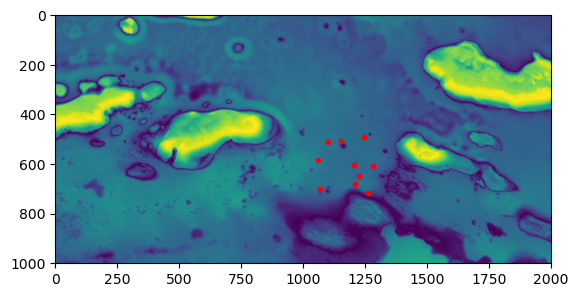

In [190]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
measurement_std = 0.2
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

max_trials = 1
threaded_num_trials =       [1]#5,   5,  5,   4,   3,   2,    1,    1,    1,     1] 
threaded_n_particles_test = [10]#, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]

threaded_timing_results = zeros(max_trials, size(threaded_n_particles_test)[1])
threaded_error_results = zeros(max_trials, size(threaded_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(threaded_n_particles_test)
    num_trials = threaded_num_trials[p_idx]
    
    for trial_idx in range(1,num_trials)
        #bench_result, pf_result, error = 
        bench_pf_threaded(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
            start_x, start_y, start_θ, sim_time, n_steps, input_func,
            num_evals, num_samples, plot=true)
        #cpu_timing_results[trial_idx, p_idx] = bench_result
#         cpu_error_results[trial_idx, p_idx] = error
    end
end



## ParticleFiltersGPU.jl

In [12]:
function runfiltergpu!(particles, inputs, measurements, 
        reweight_kernel!, propogate_kernel!, output_particles, pf_data)
    num_steps = length(inputs)
    num_particles = size(particles)[1]
    
    # Initialize weights vector
    weights_d = CUDA.fill(1.0f0, num_particles)
    
    # Initialize cumulative distribution vector
    cdf_d = similar(weights_d)
    
    # Initialize space to copy particle data - needed for resampling step
    particle_buffer = similar(particles)
    copyto!(particle_buffer, particles)
    
    # TODO: Optimize threads vs blocks
    # TODO: clean this up - all threads, blocks the same
    # Initialize kernel configurations
    reweight_kernel = @cuda launch=false reweight_kernel!(particles, inputs[1], measurements[1], weights_d, pf_data)
    reweight_config = launch_configuration(reweight_kernel.fun)
    reweight_threads = min(num_particles, reweight_config.threads)
    reweight_blocks = cld(num_particles, reweight_threads)

#     display("Reweight Threads: $reweight_threads")
#     display("Reweight Blocks: $reweight_blocks")
    
    resample_kernel = @cuda launch=false resample_kernel!(particles, particle_buffer, cdf_d)
    resample_config = launch_configuration(resample_kernel.fun)
    resample_threads = min(num_particles, resample_config.threads)
    resample_blocks = cld(num_particles, resample_threads)

#     display("Resample Threads: $resample_threads")
#     display("Resample Blocks: $resample_blocks")
    
    propogate_kernel = @cuda launch=false propogate_kernel!(particles, inputs[1], pf_data)
    propogate_config = launch_configuration(propogate_kernel.fun)
    propogate_threads = min(num_particles, propogate_config.threads)
    propogate_blocks = cld(num_particles, propogate_threads)

#     display("Propogate Threads: $propogate_threads")
#     display("Propogate Blocks: $propogate_blocks")
    
    synchronize()
    
    for idx in range(1, num_steps)
        u = inputs[idx]
        y = measurements[idx]
        
        # STEP 1: Compute weights ------------------
        CUDA.@sync begin
            reweight_kernel(particles, u, y, weights_d, pf_data; threads=reweight_threads, blocks=reweight_blocks)
        end
        
        # Compute CDF
        cumsum!(cdf_d, weights_d)
        cdf_d ./= cdf_d[end]

        # Copy particles to buffer 
        copyto!(particle_buffer, particles) # TODO: remove this, it's redundant with the all particles saved
        copyto!(output_particles[idx], particles)
        
        synchronize()
        
        # STEP 2: Resample particles ---------------
        CUDA.@sync begin
            resample_kernel(particles, particle_buffer, cdf_d; threads=resample_threads, blocks=resample_blocks)
        end
        
        # Propogate particles
        CUDA.@sync begin
            propogate_kernel(particles, u, pf_data; threads=propogate_threads, blocks=propogate_blocks)
        end
    end
end

runfiltergpu! (generic function with 1 method)

In [13]:
function glider_reweight_kernel!(particles, input, measurement, weights, pf_data)   
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    bathy_map = pf_data.bathy_map
    measurement_std = pf_data.measurement_std
    ϵ = pf_data.ϵ
    
    for i = index:stride:size(particles)[1]
        # Lookup nearest point on map
        # TODO: Convert x, y value to pixels
        @inbounds x = particles[i, 1] 
        @inbounds y = particles[i, 2]

        ix, iy = round(Int, x), round(Int, y)
        # Clamp pixel indices to image bounds
        ix = max(min(ix, size(bathy_map, 2)), 1)
        iy = max(min(iy, size(bathy_map, 1)), 1)

        # Compute likelihood given measurement
        μ = bathy_map[iy, ix]
        measured_depth = measurement[1]
        σ = measurement_std
        likelihood = exp(-0.5 * ((measured_depth - μ)/σ)^2) / (σ * sqrt(2π))

        # Enforce minimum bound on likelihood
        if likelihood < ϵ
            likelihood = ϵ
        end

        @inbounds weights[i] = likelihood
    end

    return nothing
end

# Encodes glider dynamics
function glider_propogate_kernel!(particles, input, pf_data)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    delta_t = pf_data.delta_t
    
    for i = index:stride:size(particles)[1]
        @inbounds x_pos = particles[i, 1]
        @inbounds y_pos = particles[i, 2]
        @inbounds θ = particles[i, 3]
        @inbounds v = particles[i, 4]
        @inbounds dθ = particles[i, 5]
        
        @inbounds in_thruster = input[1]
        @inbounds in_rudder = input[2]
    
        # Update position based on state
        particles[i, 1] = x_pos + delta_t*v*cos(θ)
        particles[i, 2] = y_pos + delta_t*v*sin(θ)
        particles[i, 3] = θ + delta_t*dθ

        # Update velocities based on input
        particles[i, 4] = v + delta_t*(in_thruster-v)
        particles[i, 5] = dθ + delta_t*in_rudder
    end
    
    return nothing
end

function resample_kernel!(particles, particle_buffer, cdf)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Resample each particle
    # Approach - generate random number, find which CDF index
    # correlates with the random number. Values with higher likelihood
    # cover a wider range of values, and are consequently more likely
    # to be selected
    for i = index:stride:size(particles)[1]
        r = rand()
        
        # Use binary search to find corresponding index
        # TODO: evaluate how much this matters
        lo, hi = 1, size(particles)[1]
        while lo < hi
            mid = (lo + hi) ÷ 2
            if r < cdf[mid]
                hi = mid
            else
                lo = mid + 1
            end
        end
        idx = lo
        
        # TODO: Add noise terms
        # TODO: Make this more generic
        # Update particles
        particles[i, 1] = particle_buffer[idx, 1] + randn()*1
        particles[i, 2] = particle_buffer[idx, 2] + randn()*1
        particles[i, 3] = particle_buffer[idx, 3] + randn()*0.002
        particles[i, 4] = particle_buffer[idx, 4]
        particles[i, 5] = particle_buffer[idx, 5]
    end
    
    return nothing
end


resample_kernel! (generic function with 1 method)

In [14]:
function bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
        start_x, start_y, start_θ, sim_time, n_steps, input_func,
        num_evals, num_samples, plot=true)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)

    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

    # Initialize particles
    x = Float32.(start_x .+ rand(dist_pos_init, n_particles))
    y = Float32.(start_y .+ rand(dist_pos_init, n_particles))
    θ = Float32.(start_θ .+ rand(dist_rot_init, n_particles))
    v = zeros(Float32, n_particles)
    dθ = zeros(Float32, n_particles)

    if plot
        # Plot initial samples
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(x, y, "r.")
    end
        
    # Load particles onto GPU
    particles_d = CuArray([x y θ v dθ])

    # Load measurements and control inputs onto GPU
    in_thruster_32 = Float32.(in_thruster)
    in_rudder_32 = Float32.(in_rudder)
    inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

    measurements_32 = Float32.(measurements)
    measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

    # Format data for kernels
    bathy_map_d = CuArray(bathy_map);
    pf_data = CuGliderParticleFilterData(sim_time, n_steps, measurement_std, ϵ, delta_t, cudaconvert(bathy_map_d))

    # Allocate space for particle output
    output_particles_d = [similar(particles_d) for i in 1:n_steps]

    # Run filter
    elapsed_time = @elapsed runfiltergpu!(particles_d, inputs_d, measurements_d, 
        glider_reweight_kernel!, glider_propogate_kernel!, output_particles_d, pf_data)
    
    # Plot results
    pf_estimate = ones(n_steps, 2)

    for (idx, p) in enumerate(output_particles_d)
        pf_estimate[idx,1] = mean(p[:,1])
        pf_estimate[idx,2] = mean(p[:,2])  
    end
    
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")
    end
        
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((pf_estimate[:,1] - xs).^2 + (pf_estimate[:,2] - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, output_particles_d, error
end

bench_pf_gpu (generic function with 2 methods)

#### GPU Benchmark Test

In [12]:
struct CuGliderParticleFilterData
    # Used to pass data into kernel functions
    sim_time::Float32
    n_steps::Int32
    measurement_std::Float32
    ϵ::Float32
    delta_t::Float32
    bathy_map::CuDeviceMatrix{Float32, 1}
end

struct GliderParticleFilterData
    # Used to pass data into kernel functions
    sim_time::Float32
    n_steps::Int32
    measurement_std::Float32
    ϵ::Float32
    delta_t::Float32
    bathy_map::CuDeviceMatrix{Float32, 1}
end

"Time: 2.0142887"

"Average Error: 28.36940956310699"

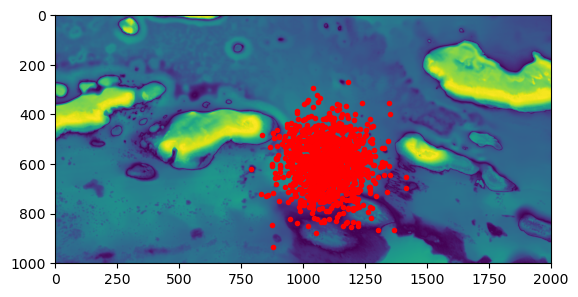

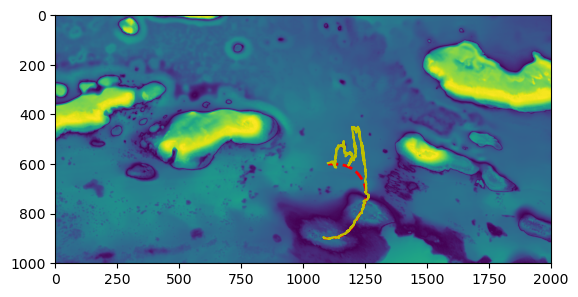

In [24]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
measurement_std = 0.2
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

delta_t = range(0, stop=sim_time, length=n_steps)[2] - range(0, stop=sim_time, length=n_steps)[1]

# Needed for specific implementation - avoids particle death where no particles have weight
ϵ = 0.0000001


# n_particles_test = [10, 100, 1000, 2000, 3000]
#150000 max
# n_particles_test = [10, 100, 1000, 10000, 100000]
n_particles_test = [1000]

for n_particles in n_particles_test
    bench_result, pf_result, error = bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
            start_x, start_y, start_θ, sim_time, n_steps, input_func,
            num_evals, num_samples, true);
end

In [35]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600
init_std_pos = 100
init_std_rot = 1
measurement_std = 0.2 #01
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

delta_t = range(0, stop=sim_time, length=n_steps)[2] - range(0, stop=sim_time, length=n_steps)[1]

# Needed for specific implementation - avoids particle death where no particles have weight
ϵ = 0.0000001

num_trials = 5
gpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 150000]

gpu_timing_results = ones(num_trials, size(gpu_n_particles_test)[1])
gpu_error_results = ones(num_trials, size(gpu_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(gpu_n_particles_test)
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, false);
        gpu_timing_results[trial_idx, p_idx] = bench_result
        gpu_error_results[trial_idx, p_idx] = error
    end
end

"Time: 1.7551017"

"Average Error: 249.52226081444044"

"Time: 1.5724046"

"Average Error: 210.33358054019988"

"Time: 1.5947506"

"Average Error: 56.300280145997505"

"Time: 1.5709733"

"Average Error: 170.11310870235368"

"Time: 1.5533412"

"Average Error: 136.83451251228416"

"Time: 1.5272804"

"Average Error: 272.40955470209286"

"Time: 1.5754624"

"Average Error: 184.29498304029983"

"Time: 1.5901636"

"Average Error: 164.32864710295243"

"Time: 1.6223588"

"Average Error: 43.13791615079432"

"Time: 1.5908032"

"Average Error: 340.0532806536928"

"Time: 1.606627"

"Average Error: 80.05147146790843"

"Time: 1.5943334"

"Average Error: 235.59257830096763"

"Time: 1.6084752"

"Average Error: 184.75008286481773"

"Time: 1.5543608"

"Average Error: 103.31184313169219"

"Time: 1.5628285"

"Average Error: 23.108739273167398"

"Time: 1.6635848"

"Average Error: 254.16676205797228"

"Time: 1.6352976"

"Average Error: 261.8628782533624"

"Time: 1.6517929"

"Average Error: 273.86942906852505"

"Time: 1.6191489"

"Average Error: 169.58545250535536"

"Time: 1.651787"

"Average Error: 182.68817525318397"

"Time: 1.6698255"

"Average Error: 22.09094115268487"

"Time: 1.6433711"

"Average Error: 107.0040996404087"

"Time: 1.6560635"

"Average Error: 96.13155231539325"

"Time: 1.6526874"

"Average Error: 187.89170741373584"

"Time: 1.6534027"

"Average Error: 104.38868563513383"

"Time: 1.7273328"

"Average Error: 49.55612105896066"

"Time: 1.7401993"

"Average Error: 5.645576948583484"

"Time: 1.737361"

"Average Error: 122.21098578333614"

"Time: 1.7083367"

"Average Error: 12.12678206642577"

"Time: 1.6851369"

"Average Error: 28.904469353180666"

"Time: 1.9668045"

"Average Error: 14.037022530565743"

"Time: 2.0136191"

"Average Error: 105.98326361790976"

"Time: 2.0147224"

"Average Error: 16.552017559469522"

"Time: 1.9863632"

"Average Error: 107.75298220678987"

"Time: 1.9753069"

"Average Error: 9.293899180635211"

"Time: 2.0684996"

"Average Error: 19.03742019753363"

"Time: 2.0753473"

"Average Error: 8.258165218069681"

"Time: 2.0752557"

"Average Error: 7.0544354428009175"

"Time: 2.0775283"

"Average Error: 7.7362646127692045"

"Time: 2.0473384"

"Average Error: 10.582152664053558"

"Time: 2.1073982"

"Average Error: 14.213517516564492"

"Time: 2.1070215"

"Average Error: 65.04197569775232"

"Time: 2.124479"

"Average Error: 58.401659485646356"

"Time: 2.1120903"

"Average Error: 16.497970982666697"

"Time: 2.1017163"

"Average Error: 9.779492241777408"

"Time: 2.1024433"

"Average Error: 13.072304650058113"

"Time: 2.1043147"

"Average Error: 10.057165276060516"

"Time: 2.1515674"

"Average Error: 17.695972403052277"

"Time: 2.1496432"

"Average Error: 9.940802711727642"

"Time: 2.0869571"

"Average Error: 11.139058787024036"

"Time: 2.0585874"

"Average Error: 15.083898374213298"

"Time: 2.2974104"

"Average Error: 12.440924525884618"

"Time: 2.2866882"

"Average Error: 17.29054944399913"

"Time: 2.2952241"

"Average Error: 12.36363410372884"

"Time: 2.222023"

"Average Error: 11.13672928635911"

"Time: 2.5107699"

"Average Error: 12.639379763449082"

"Time: 2.372605"

"Average Error: 13.682019275088939"

"Time: 2.3375123"

"Average Error: 9.51117892650676"

"Time: 2.5257541"

"Average Error: 165.74095636586335"

"Time: 2.3913743"

"Average Error: 14.641880711176869"

"Time: 1.2274911"

"Average Error: 10.288418939333988"

"Time: 0.523273"

"Average Error: 12.616653016957342"

"Time: 0.4788601"

"Average Error: 11.093054857788266"

"Time: 0.4781764"

"Average Error: 14.911751302419855"

"Time: 0.4795486"

"Average Error: 10.114946890849382"

"Time: 0.6366448"

"Average Error: 11.609610570779537"

"Time: 0.6352823"

"Average Error: 13.095415085636684"

"Time: 0.6310792"

"Average Error: 9.53509865426299"

"Time: 0.6536315"

"Average Error: 141.249616971581"

"Time: 0.6312656"

"Average Error: 14.020080019334763"

In [36]:
# Save results
writedlm("timing_gpu_6.txt", gpu_timing_results)
writedlm("error_gpu_6.txt", gpu_error_results)

In [71]:
Threads.nthreads()

1

In [ ]:
# Load results
# read_timing_results = readdlm("timing_gpu_3.txt")

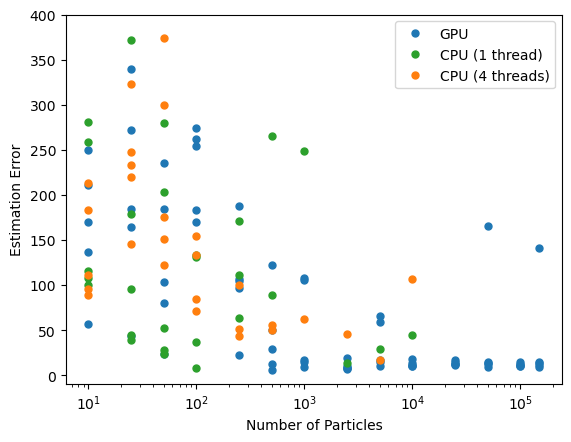

PyObject <matplotlib.legend.Legend object at 0x0000013CF7683580>

In [30]:
gpu_error_results = readdlm("error_gpu_5.txt")
cpu_error_results3 = readdlm("error_cpu_3.txt")
cpu_error_results4 = readdlm("error_cpu_4.txt")

# Make 0's very negative for plotting
idx = findall(gpu_error_results .== 0)
gpu_error_results[idx] .= -500

idx = findall(cpu_error_results3 .== 0)
cpu_error_results3[idx] .= -500

idx = findall(cpu_error_results4 .== 0)
cpu_error_results4[idx] .= -500



fig, ax = PyPlot.subplots()
for r_idx in range(1, size(gpu_error_results)[1])
    if r_idx == 1
        ax.plot(gpu_n_particles_test, gpu_error_results[r_idx, :],".", color="tab:blue", markersize=10, label="GPU")
    else
        ax.plot(gpu_n_particles_test, gpu_error_results[r_idx, :],".", color="tab:blue", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_error_results)[1])
    num_trials = cpu_num_trials[r_idx]
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_error_results3[r_idx, :],".", color="tab:green", markersize=10, label="CPU (1 thread)")
    else
        ax.plot(cpu_n_particles_test, cpu_error_results3[r_idx, :],".", color="tab:green", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_error_results)[1])
    num_trials = cpu_num_trials[r_idx]
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_error_results4[r_idx, :],".", color="tab:orange", markersize=10, label="CPU (4 threads)")
    else
        ax.plot(cpu_n_particles_test, cpu_error_results4[r_idx, :],".", color="tab:orange", markersize=10)
    end
    ax.set_xscale("log")
end


ax.set_ylabel("Estimation Error")
ax.set_xlabel("Number of Particles")
ax.set_ylim([-10, 400])
ax.legend()
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

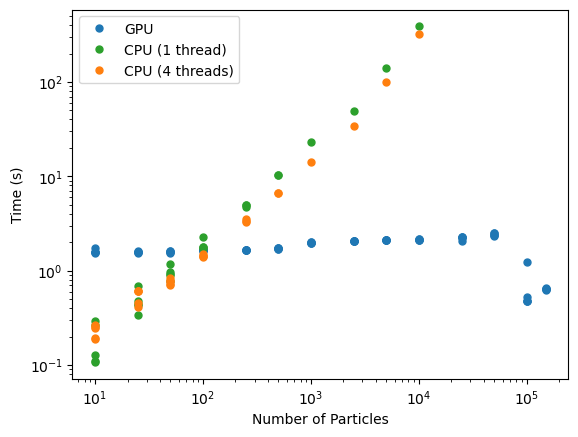

PyObject <matplotlib.legend.Legend object at 0x0000013CC99E9A80>

In [20]:
gpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 150000]
gpu_timing_results = readdlm("timing_gpu_5.txt")
cpu_timing_results3 = readdlm("timing_cpu_3.txt")
cpu_timing_results4 = readdlm("timing_cpu_4.txt")

fig, ax = PyPlot.subplots()
for r_idx in range(1, size(gpu_timing_results)[1])
    if r_idx == 1
        ax.plot(gpu_n_particles_test, gpu_timing_results[r_idx, :],".", color="tab:blue", markersize=10, label="GPU")
    else
        ax.plot(gpu_n_particles_test, gpu_timing_results[r_idx, :],".", color="tab:blue", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_timing_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_timing_results3[r_idx, :],".", color="tab:green", markersize=10, label="CPU (1 thread)")
    else
        ax.plot(cpu_n_particles_test, cpu_timing_results3[r_idx, :],".", color="tab:green", markersize=10)
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
end

for r_idx in range(1, size(cpu_timing_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_timing_results4[r_idx, :],".", color="tab:orange", markersize=10, label="CPU (4 threads)")
    else
        ax.plot(cpu_n_particles_test, cpu_timing_results4[r_idx, :],".", color="tab:orange", markersize=10)
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of Particles")
ax.legend()
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

In [116]:
a = ones(10,5)
a[1,5] = 5
a

10×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  5.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [ ]:
n = 300

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(pf_result[n][:,1], pf_result[n][:,2], "r.")

In [18]:
# b = CUDA.CuDeviceMatrix{Float64}(bathy_map_d)
typeof(cudaconvert(bathy_map_d))

LoadError: UndefVarError: bathy_map_d not defined

In [17]:
SIM_TIME = 1000 # s
N_STEPS = 1001

SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
MODEL_MEASUREMENT_STD = 0.2#10.0 #0.1 # Modeled noise value
ϵ = 0.000001 # Minimum particle likelihood value, to avoid errors

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity



5

In [27]:
# results = @benchmark runfilter(fil, b0, us, measurements) evals=1 samples=1 

In [28]:
# results = @benchmark 3 evals=1000 samples=1
# @btime runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [29]:
# # TODO: make this less redundant
# filtered_xs = [m[1] for m in map(mean, bs)]
# filtered_ys = [m[2] for m in map(mean, bs)]

# fig, ax = PyPlot.subplots()
# ax.imshow(-bathy_map)
# ax.plot(xs,ys,"r--", lw=2)
# ax.plot(filtered_xs, filtered_ys, "y")

In [30]:
# bathy_map[1,400]
# bathy_map[1,600]
# bathy_map[600,1]
bathy_map[435,1]
# bathy_map_d[435, 1]

0.94117737f0

## Custom ParticleFilter 

In [31]:
dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)

Normal{Float64}(μ=0.0, σ=0.01)

In [32]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

N_PARTICLES = 10000

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Load particles onto GPU
particles_d = CuArray([x y θ v dθ])
# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
# particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
# particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))
# particles_d = CuArray([x', y', θ', v', dθ'])

# TODO: THIS IS TEMPORARY
# particles_d = cu(x)
# particles_d = CuArray(rand(Float32, N_PARTICLES, 5))

xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
    generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)
    

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

measurements_32 = Float32.(measurements)
measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

LoadError: UndefVarError: measurements not defined

┌ Warning: Performing scalar indexing on task Task (runnable) @0x000001de5daf5940.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore C:\Users\amyng\.julia\packages\GPUArraysCore\HaQcr\src\GPUArraysCore.jl:106


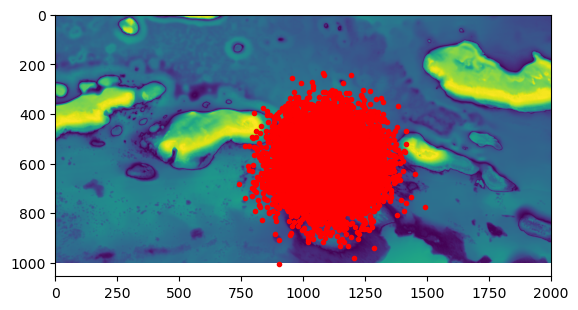

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001DEC35986A0>

In [33]:
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(particles_d[:,1], particles_d[:,2], "r.")

In [31]:
# # cu([cu(START_X .+ rand(dist_pos_init, N_PARTICLES)), cu(START_Y .+ rand(dist_pos_init, N_PARTICLES))])
# a = [1,2,3]
# b = [1,1,1]
# # cu([a b])

# cu([x y])

In [32]:
# Load bathymetry map onto gpu
const bathy_map_d = CuArray(bathy_map);

In [33]:
# # particles_d
# bathy_map_d[1001,1]

In [34]:
# size(bathy_map_d)
size(bathy_map_d)

(1001, 2001)

In [35]:
# LEFT OFF HERE: - just pass in data as needed, 
# size(particles_d)
particles_d

10000×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  892.631  610.148  3.04276   0.0  0.0
  961.283  513.341  2.99747   0.0  0.0
  903.925  577.538  2.20579   0.0  0.0
 1064.45   520.582  1.56663   0.0  0.0
  929.263  721.405  1.01917   0.0  0.0
 1112.88   603.83   1.05567   0.0  0.0
  859.017  482.568  2.29754   0.0  0.0
  990.625  837.374  1.22821   0.0  0.0
 1133.74   528.461  2.27257   0.0  0.0
 1135.66   521.107  1.63818   0.0  0.0
 1095.94   660.215  0.872261  0.0  0.0
 1003.74   645.842  2.54467   0.0  0.0
 1015.84   527.304  0.641289  0.0  0.0
    ⋮                              
 1034.41   547.374  2.28754   0.0  0.0
 1079.71   469.666  2.83821   0.0  0.0
  994.73   549.252  1.96327   0.0  0.0
 1122.15   630.529  0.752032  0.0  0.0
 1015.63   705.291  2.43826   0.0  0.0
 1107.6    577.391  1.29878   0.0  0.0
 1027.25   642.047  2.48748   0.0  0.0
 1012.73   577.384  0.866944  0.0  0.0
 1016.02   601.725  1.4191    0.0  0.0
  952.482  696.898  2.18968   0.0  0.0
  844.202  558.

In [120]:


#     sync_threads()
    
#     # STEP 2: Resample particles ----------------------------------------------
#     # Copy particles over to buffer
#     copyto!(particle_buffer, particles)
    
# function resample_func!(particles, particle_buffer, weights, cdf)
    
#     copyto!(particle_buffer, particles)
    
#     # Compute cumulative distribution function 
#     # Normalize weights
#     sync_threads()
#     total = sum(weights)

#     particles[1,4] = sum(weights)
    
#     acc_weights = cumsum(weights)
#     acc_weights ./= acc_weights[end]
    
# end

function bench_gpu_filter!(particles, inputs, measurements, 
        reweight_kernel!, propogate_kernel!, _all_particles, _bathy_map)
    num_steps = length(inputs)
    num_particles = size(particles)[1]
    
    # Initialize weights vector
    weights_d = CUDA.fill(1.0f0, num_particles)
    
    # Initialize cumulative distribution vector
    cdf_d = similar(weights_d)
    
    # Initialize space to copy particle data - needed for resampling step
    particle_buffer = similar(particles)
    copyto!(particle_buffer, particles)
    
    # TODO: Optimize threads vs blocks
    # TODO: clean this up - all threads, blocks the same
    # Initialize kernel configurations
    reweight_kernel = @cuda launch=false reweight_kernel!(particles, inputs[1], measurements[1], weights_d, _bathy_map)
    reweight_config = launch_configuration(reweight_kernel.fun)
    reweight_threads = min(num_particles, reweight_config.threads)
    reweight_blocks = cld(num_particles, reweight_threads)

#     display("Reweight Threads: $reweight_threads")
#     display("Reweight Blocks: $reweight_blocks")
    
    resample_kernel = @cuda launch=false resample_kernel!(particles, particle_buffer, cdf_d)
    resample_config = launch_configuration(resample_kernel.fun)
    resample_threads = min(num_particles, resample_config.threads)
    resample_blocks = cld(num_particles, resample_threads)

#     display("Resample Threads: $resample_threads")
#     display("Resample Blocks: $resample_blocks")
    
    propogate_kernel = @cuda launch=false propogate_kernel!(particles, inputs[1])
    propogate_config = launch_configuration(propogate_kernel.fun)
    propogate_threads = min(num_particles, propogate_config.threads)
    propogate_blocks = cld(num_particles, propogate_threads)

#     display("Propogate Threads: $propogate_threads")
#     display("Propogate Blocks: $propogate_blocks")
    
    synchronize()
    
    for idx in range(1, num_steps)
        u = inputs[idx]
        y = measurements[idx]
        
        # STEP 1: Compute weights ------------------
        CUDA.@sync begin
            reweight_kernel(particles, u, y, weights_d, _bathy_map; threads=reweight_threads, blocks=reweight_blocks)
        end
        
        # Compute CDF
        cumsum!(cdf_d, weights_d)
        cdf_d ./= cdf_d[end]

        # Copy particles to buffer 
        copyto!(particle_buffer, particles) # TODO: remove this, it's redundant with the all particles saved
        copyto!(_all_particles[idx], particles)
        
        synchronize()
        
        # STEP 2: Resample particles ---------------
        CUDA.@sync begin
            resample_kernel(particles, particle_buffer, cdf_d; threads=resample_threads, blocks=resample_blocks)
        end
        
        # Propogate particles
        CUDA.@sync begin
            propogate_kernel(particles, u; threads=propogate_threads, blocks=propogate_blocks)
        end
    end
end

display(particles_d)
# For saving output
all_particles_d = [similar(particles_d) for i in 1:N_STEPS]
bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_reweight_kernel!, glider_propogate_kernel!, all_particles_d, bathy_map_d)
# TODO: need to reset data before re-running this, since particles change
# @benchmark bench_gpu_filter!(particles_d, inputs_d, measurements_d, 
#     glider_reweight_kernel!, glider_propogate_kernel!, all_particles_d, bathy_map_d) evals=1 samples=1

LoadError: UndefVarError: particles_d not defined

In [37]:
# 
all_particles_d[3]

10000×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  966.881  572.38    1.47936   0.5  1.19884f-5
  945.028  601.911   1.05832   0.5  1.19884f-5
 1041.39   581.232   1.72856   0.5  1.19884f-5
  965.337  634.062   1.30391   0.5  1.19884f-5
  972.324  578.406  -0.152665  0.5  1.19884f-5
  914.575  668.872   2.86987   0.5  1.19884f-5
  975.092  650.746  -0.425931  0.5  1.19884f-5
  930.122  600.766   1.35024   0.5  1.19884f-5
  863.894  586.455   1.25174   0.5  1.19884f-5
 1003.39   599.746   0.958769  0.5  1.19884f-5
  969.368  646.876   3.6178    0.5  1.19884f-5
  967.187  627.257  -0.675306  0.5  1.19884f-5
  965.958  604.138   1.33558   0.5  1.19884f-5
    ⋮                               
  992.295  592.625   1.09393   0.5  1.19884f-5
  955.041  573.701   1.67861   0.5  1.19884f-5
  859.244  621.938   0.868311  0.5  1.19884f-5
  943.594  574.435   1.80708   0.5  1.19884f-5
  976.536  607.295   2.27482   0.5  1.19884f-5
 1023.66   602.335   0.611498  0.5  1.19884f-5
  974.39   606.213

In [38]:
μ = 5
measured_depth = 6
σ = 1
exp(-0.5 * (measured_depth - μ / σ)^2) / (σ * sqrt(2π))

0.24197072451914337

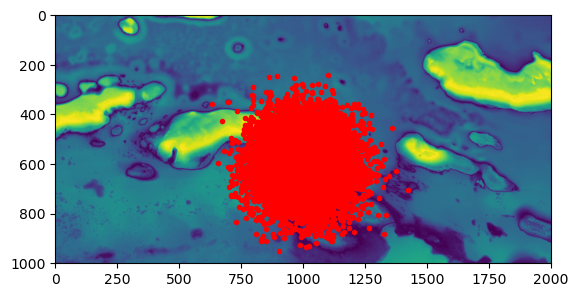

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001EA0D8F62F0>

In [39]:
n = 1

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles_d[n][:,1], all_particles_d[n][:,2], "r.")

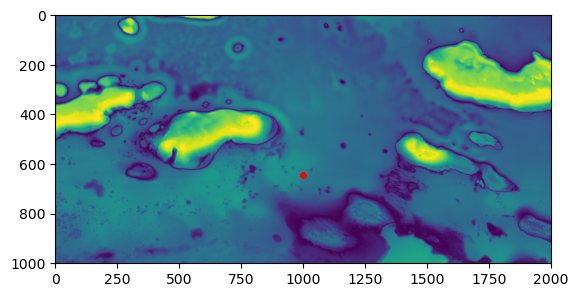

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001E9700F1840>

In [40]:
n = 600

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles_d[n][:,1], all_particles_d[n][:,2], "r.")

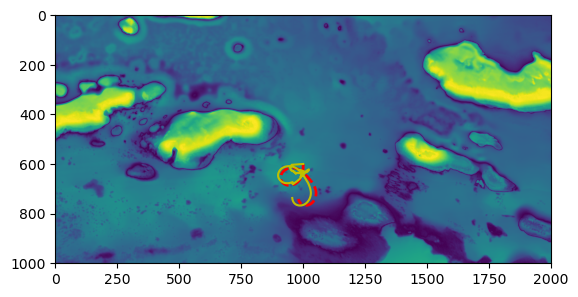

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001EA00DB97E0>

In [41]:
pf_estimate = ones(N_STEPS, 2)

for (idx, p) in enumerate(all_particles_d)
    pf_estimate[idx,1] = mean(p[:,1])
    pf_estimate[idx,2] = mean(p[:,2])  
end

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)
ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

# SANDBOX

In [471]:
# # test = cu([rand(dist_pos_init, N_PARTICLES); rand(dist_pos_init, N_PARTICLES)])
# # test[1]

# temp1 = [1,2,3]
# temp2 = [4,5,6]
# A = Float32[temp1'; temp2']

# # Create a 2x3 matrix on the GPU with Float32 element type
# A_d = cu(A)

bathy_map_d

1001×2001 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 20.8235  20.8235  20.9412  20.9412  …  24.1176  24.1176  24.1176  24.1176
 20.8235  20.8235  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.8235  20.8235  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  21.0588     24.2353  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588  …  24.2353  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588     24.1176  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588     24.0     24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  20.9412     24.0     24.0     24.0     24.1176
 20.9412  20.9412  20.9412  20.9412     23.8824  24.0     24.0     24.0
 20.9412  20.9412  20.9412  20.9412  …  23.8824  24.0     24.0     24.0
 20.9412  20.9412  20.9412  20.9412     23.8824  23.8824  23.8824  24.0
 20.9412  20.9412  20.9412  20.9412     23.8824  23.882

In [472]:
typeof(measurements_d)

Vector{CuArray{Float32, 1, DeviceBuffer}} (alias for Array{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, 1})

In [473]:
# function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [474]:
# # function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# # end

# function update_weights_gpu!(particles, input, measurement, measurement_model, weights)
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles * blockDim().particles
#     for i = index:stride:length(particles)       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] = measurement_model(particles[i], input, 0, measurement)
#     end
# end

# function run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     # Initialize weights vector
#     weights_d = CUDA.fill(1.0f0, length(particles))
    
#     for (u, y) in enumerate(zip(inputs, measurements))
#         print('.')
        
#         # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, measurement_model, weights_d)
#     end
# end

# function bench_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
# # function bench_gpu_filter!(particles, func)
#     kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     config = launch_configuration(kernel.fun)
#     threads = min(length(particles), config.threads)
#     blocks = cld(length(particles), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         kernel(particles, inputs, measurements, measurement_model, dynamics_model; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# end

# bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# bench_gpu_filter!(particles_d, inputs_d, measurements_d)



# # function test_func!(part)
# #     display(part[1])
# #     display("here")
# #     @cuprintln("print testing")
# #     @cuprintln(part[1])
# # end

# # bench_gpu_filter!(particles_d, test_func!)

# # test_func!(particles_d)



# # # @btime bench_gpu4!($y_d, $x_d)

# # # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# # @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# # synchronize()

10-element Vector{Float32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [ ]:

# struct CustomParticleFilter
#     dynamics_model
#     measurement_model
# end

# # TODO: left off here
# function run_custom_filter!(filter, particles, inputs, measurements)
    
#     for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
#         print('.')
#         all_particles[:,:,t_idx] = particles


#         # Update weights based on observation ---------------------
#         # Compute relative likelihoods
#         for (p_idx, p) in enumerate(eachcol(particles))
#             weights[p_idx] = compute_likelihood(p, m, bathy_map)

#             # Ensure likelihood can't be too small
#             if weights[p_idx] < 0.000000001
#                 weights[p_idx] = 0.000000001
#             end
#         end   

#         # Resample particles --------------------------------------
#         # Normalize the weights


#     #     println("HEREEE")
#     #     println(size(weights))
#     #     println(sum(weights))
#     #     println(size(weights ./ sum(weights)))

#         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

#         # Update particles with dynamics model 
#         # TODO add vehicle dynamics noise? (build in noise term here)
#         for (p_idx, p) in enumerate(eachcol(particles))
#             particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
#         end   

#         # Update state estimate --------------------------------------
#         state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly

#     #     # Visualization -------------------------------------------
#     #     fig, ax = PyPlot.subplots()
#     #     ax.imshow(-bathy_map)
#     #     ax.plot(particles[1,:], particles[2,:], "r.")

#     #     # Add the plot to the sequence
#     #     push!(plot_sequence, fig)
#     end

# end

# # INITIALIZATION ##############################################
# all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# weights = ones(N_PARTICLES)

# dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)

# dist_pos_update = Normal(0, PF_STD_POS)
# dist_rot_update = Normal(0, PF_STD_ROT)


# for i in range(1, N_PARTICLES)
#     # Generate sample
#     x = START_X + rand(dist_pos_init)
#     y = START_Y + rand(dist_pos_init)
#     θ = START_θ + rand(dist_rot_init)
    
#     particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
# end

# # Plot initial particles
# fig, ax = PyPlot.subplots(figsize=[10,10])
# ax.imshow(-bathy_map)
# ax.plot(particles[1,:], particles[2,:], "r.")


# # PARTICLE FILTER ##############################################
# state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# # pre-allocate space (avoids errors)
# samples = similar(weights)


# Sandbox

In [83]:
# # Note: this returns a number
# const sigma = 1.0
# g(x1, u, x2, y) = pdf(Normal(sigma), y-x2[1])

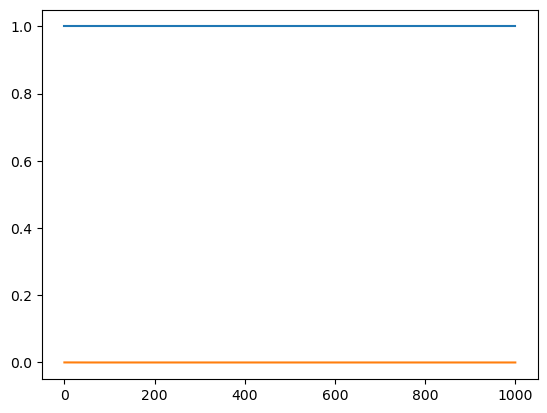

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45A36590>

In [84]:
PyPlot.plot(in_thruster)
PyPlot.plot(in_rudder)

In [85]:
# plot(xs[1:100], ys[1:100])
# PyPlot.plot(xs, ys)

In [86]:
# plot(xs)
# plot!(ys)

## Measurement Model

In [87]:
size(value_image)


(8112, 16212)

lookup_depth (generic function with 1 method)

In [89]:
x = -100000000000
y = -1000000000000000000000
x_idx = argmin(abs.(collect(1:size(bathy_map, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(bathy_map, 1)) .- y))
println(x_idx)
println(y_idx)

1
1


In [90]:
size(bathy_map)

# if 5 <= 1 || 4 <= 25
#     print("hi")
# end

(1001, 2001)

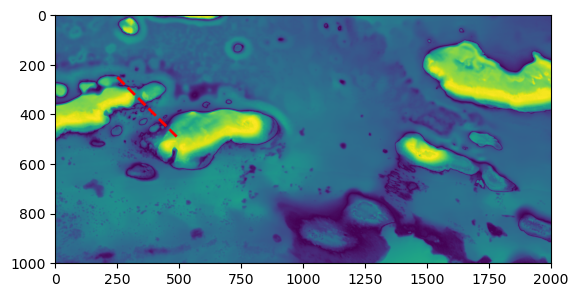

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F458C2440>

In [97]:

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
ax.plot([250,500],[250,500],"r--", lw=2)

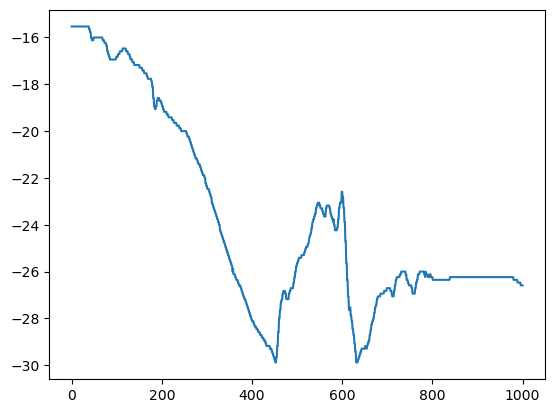

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45639090>

In [99]:
measurements = simulate_measurements(xs, ys, bathy_map)
PyPlot.plot(ts, -measurements)

## Particle Filter

compute_likelihood (generic function with 1 method)

In [49]:
using Reel # For visualization
plot_sequence = []




5

In [50]:
# function sample_points(initial_state, noise_distribution, num_points)
#     ...
#     particles = ones(, N_PARTICLES)
    
#     for i in range(1, num_points)
#         sample = initial_state + rand.(initial_distribution)
#     end
    
#     return samples
# end

# function update_weights!(particles, dynamics_model, observation)
#     ...

# function compute_likelihood(state, observation, observation_model)
#     ...
        
#     # State vector: x, y, θ, linear velocity, angular velocity
#     x, y, θ, v, dθ = state

#     model_depth = lookup_depth(x, y, map)

#     dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
#     pdf_value = pdf(dist, measurement)
    
# #     println(model_depth)
# #     println(pdf_value)
#     return pdf_value
# end

# function resample_points!(particles, weights)
#     ...
        

            

In [51]:
rand.([dist_pos_init, dist_pos_init])

2-element Vector{Float64}:
 -63.92874007791153
  96.68746732981522

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

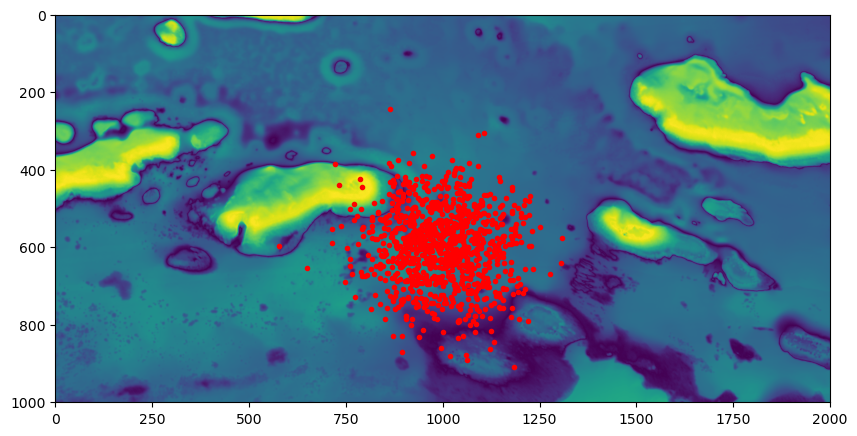

In [52]:

# INITIALIZATION ##############################################
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

# Plot initial particles
fig, ax = PyPlot.subplots(figsize=[10,10])
ax.imshow(-bathy_map)
ax.plot(particles[1,:], particles[2,:], "r.")


# PARTICLE FILTER ##############################################
state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# pre-allocate space (avoids errors)
samples = similar(weights)

for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
    print('.')
    all_particles[:,:,t_idx] = particles
    
    
    # Update weights based on observation ---------------------
    # Compute relative likelihoods
    for (p_idx, p) in enumerate(eachcol(particles))
        weights[p_idx] = compute_likelihood(p, m, bathy_map)
        
        # Ensure likelihood can't be too small
        if weights[p_idx] < 0.000000001
            weights[p_idx] = 0.000000001
        end
    end   
    
    # Resample particles --------------------------------------
    # Normalize the weights

    
#     println("HEREEE")
#     println(size(weights))
#     println(sum(weights))
#     println(size(weights ./ sum(weights)))
    
    w_norm = Weights(weights ./ sum(weights))

    # Generate N_PARTICLES samples
    samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

    # Extract the corresponding columns from the matrix
    new_particles = particles[:, samples]
    particles = new_particles
    
    # Add noise to avoid particle death
    # TODO: Add noise to samples based on current covariances
    particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
    particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
    particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)
    
    # Update particles with dynamics model 
    # TODO add vehicle dynamics noise? (build in noise term here)
    for (p_idx, p) in enumerate(eachcol(particles))
        particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
    end   
    
    # Update state estimate --------------------------------------
    state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly
    
#     # Visualization -------------------------------------------
#     fig, ax = PyPlot.subplots()
#     ax.imshow(-bathy_map)
#     ax.plot(particles[1,:], particles[2,:], "r.")

#     # Add the plot to the sequence
#     push!(plot_sequence, fig)
end



# w = [1,1,1,2,3,4,5,6,7]

# idxs = sample(axes(b, 1), myweights, 10)

# INITIALIZATION

# SIM_TIME = 1000 # s
# N_STEPS = 1001

# START_X = 1000 
# START_Y = 600
# START_θ = π/2

# state_vec = 
# particles



# Implement Particle filter
# - given
#     in_thruster
#     in_rudder
# - given initialization (put at map size/2)
# - randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
# - plot initial particles

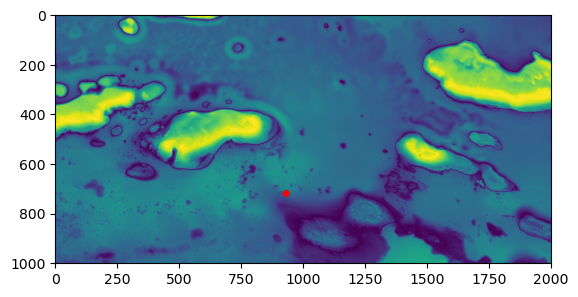

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BE626B0>

In [53]:
# Plot particles at step n

n = 100

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles[1,:,n], all_particles[2,:,n], "r.")

In [54]:
# # dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)
# rand(dist_pos_init, 10) + rand(dist_pos_init, 10)

In [55]:
# frames = Frames(MIME("image/png"), fps=10)
# for plt in plot_sequence
#     print(".")
#     push!(frames, plt)
# end
# write("output.gif", frames)


# using Interact, Plots

# Define the function to plot
# f(x) = sin(x)

# Create a slider widget
# s = slider(0:0.1:2π, label="x")

# # Create a plot that updates with the slider
# plot(slider = s) do
#     plot(f.(s.value), label="sin(x)")
#     xlabel("x")
#     ylabel("y")
#     ylim(-1.1, 1.1)
# end

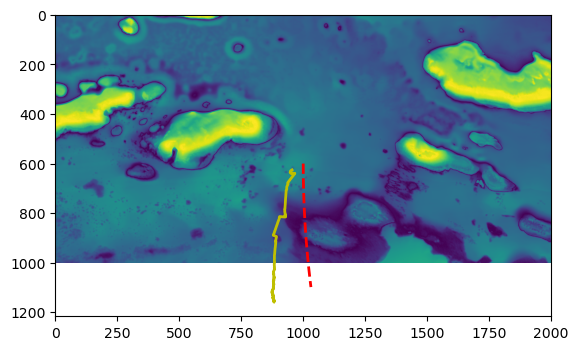

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BEE61A0>

In [56]:
# Plot result
# fig, ax = PyPlot.subplots(figsize=[10,10])
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(state_estimate[1,:], state_estimate[2,:], "y-", lw=2)
ax.plot(xs,ys,"r--", lw=2)

In [26]:
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# A = rand(5, 10)
# row_means = mean(A, dims=2)

In [27]:
mat = rand(3,10)
display(mat)
print(size([1,1,1,1,1,2,3,4,5,100]))
w = pweights([1,1,1,1,1,2,3,4,5,1000])

idxs = sample(axes(mat,2), w, 10)

3×10 Matrix{Float64}:
 0.263024    0.534815  0.992894  0.480743  …  0.437964  0.832557  0.611114
 0.00397285  0.586192  0.795251  0.764921     0.831626  0.269864  0.142983
 0.696813    0.748456  0.229832  0.84537      0.990075  0.538914  0.956491

(10,)

10-element Vector{Int64}:
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [28]:
# Example data
# mat = rand(3,10)
# w_unnormalized = [1,1,1,1,1,2,3,4,5,1000]
# p = w_unnormalized / sum(w_unnormalized)
# w = 1 ./ p
# w = w / sum(w)

# # Draw a sample from x using the weights in w
# sampled_index = sample(w_unnormalized, Weights(w), 1)

# Get the value of the sampled element from x
# sampled_value = x[1,sampled_index]



# RESAMPLE STEP #####################################


# Example data
mat = rand(3, 10)
w_unnormalized = [1, 1, 1, 1, 1, 2, 3, 4, 5, 1000]

# Normalize the weights
w = w_unnormalized ./ sum(w_unnormalized)

# Generate n samples
n = 5
samples = sample(1:size(mat, 2), Weights(w), n)

# Extract the corresponding columns from the matrix
sampled_mat = mat[:, samples]


3×5 Matrix{Float64}:
 0.595189   0.595189   0.393616  0.595189   0.595189
 0.0485249  0.0485249  0.147211  0.0485249  0.0485249
 0.921648   0.921648   0.819239  0.921648   0.921648

In [29]:
axes(mat,2)

Base.OneTo(10)

In [30]:
# using StatsBase

# # Define an array of values
# x = [2, 3, 5, 2, 10]

# # Compute weights based on the relative values of the elements in x
# w = x ./ sum(x)

# # Sample an index from x based on the computed weights
# # idx = rand(SampleWeights(w))


In [31]:
# bathy_map[1,400]
# bathy_map[1,800]
# maximum(bathy_map)
# minimum(bathy_map)
# plot(bathy_map[:,1]) # column, row format. 0, 0 is top left of image



In [32]:
print(img[10,10000])

# function rgb_to_greyscale(rgb)
# end
# 0.2989, 0.5870, 0.1140.

# gray_value = Gray(img[10,10000])

# gray_img = Gray.(img)

# # Plot the grayscale image
# heatmap(gray_img, color=:grays)

# float(red(img[6000,10000]))

rgb_to_value(img[6000,10000])

RGB{N0f8}(1.0,0.0,0.0)

12.941175f0

In [33]:

# # affine_map = geotransform(geoarray)
# # plot(geoarray, band=3)
# # geoarray
# # 0.299red+0.587green+0.114blue
# # band_1 = geoarray[:,:,1]

# using GeoArrays

# # Load the GeoTIFF file into a GeoArray
# # filename = "path/to/geotiff/file.tif"
# # geoarray = GeoArrays.read(filename)

# # Define the latitude and longitude of the point of interest
# lat = 40.7128
# lon = -74.0060

# # Convert the latitude and longitude to row and column indices
# # setcrs!(geoarray, "+proj=longlat +datum=WGS84")
# # row, col = GeoArrays.coordinates(geoarray, lat, lon)

# # # Extract the RGB value at the specified location
# # rgb = geoarray[row, col, :]

# # # Convert the RGB value to depth
# # depth = 0.3048 * (rgb[1] + rgb[2] * 256 + rgb[3] * 65536)

# # # Print the depth value
# # println(depth)

In [34]:
# Define the x and y values
x = 100
y = 200

# Find the pixel with the closest x, y values
x_idx = argmin(abs.(collect(1:size(img, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(img, 1)) .- y))

# Look up the pixel value
pixel_value = img[y_idx, x_idx]
print(pixel_value)

RGB{N0f8}(0.69,0.882,0.0)

### Map Generation

In [35]:
using Plots
using CalculusWithJulia
import Contour: contours, levels, lines, coordinates
using LinearAlgebra, ForwardDiff

LoadError: ArgumentError: Package CalculusWithJulia not found in current path.
- Run `import Pkg; Pkg.add("CalculusWithJulia")` to install the CalculusWithJulia package.

In [36]:
# Step 1
n = rand(5:20)

# Step 2
A = rand(-1:0.01:1, n)
B = rand(0.001:0.005:0.05, n)
f_rand(x,y) = sum(A[i]*sin.(B[i]*x) * A[i+1]*cos.(B[i+1]*y) for i in 1:n-1)


f_rand (generic function with 1 method)

In [37]:
xs = range(-200, stop=200, length=100)
ys = range(-200, stop=200, length=100)
# f(x,y) = sin(x/100)*sin(y/100)
# f(x,y) = sin(x/100)*sin(y/100)
# surface(xs, ys, f)
contour(xs, ys, f_rand)

LoadError: UndefVarError: contour not defined

In [38]:
f_rand(xs, ys)

LoadError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::StridedMatrix{T}[39m, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\matmul.jl:49
[0m  *(::StridedVecOrMat, [91m::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}[39m) at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\lq.jl:269
[0m  ...

In [39]:
using PyPlot

In [40]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

### Lookup values

In [ ]:
function simulate_measurement(x,y,theta,noise=0)
    # TODO: Returns beam 1, 2, 3, 4
    return f_rand(x, y)
end

In [ ]:
# End goal: plot of real trajectory, 
# versus computed one with particle filter

## GPU code snippets

In [ ]:
# # Initialize particles
# x_d = CuArray{Float32}(START_X .+ rand(dist_pos_init, N_PARTICLES))
# y_d = CuArray{Float32}(START_Y .+ rand(dist_pos_init, N_PARTICLES))
# θ_d = CuArray{Float32}(START_θ .+ rand(dist_rot_init, N_PARTICLES))
# v_d = CUDA.fill(0.0f0, N_PARTICLES)  # a vector stored on the GPU filled with 1.0 (Float32)
# dθ_d = CUDA.fill(0.0f0, N_PARTICLES)

# # Particles = Vector containing CuArray for each state variable 
# # Vector{CuArray}(undef, 5)
# particles_d = CuArray([x_d, y_d, θ_d, v_d, dθ_d])

# # Load measurements and control inputs onto GPU
# in_thruster_d = CuArray{Float32}(in_thruster)
# in_rudder_d = CuArray{Float32}(in_rudder)

# inputs_d = [in_thruster_d, in_rudder_d]
# measurements_d = [CuArray{Float32}(measurements)]


In [ ]:
# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)

# temp = [[x, y] for (x, y) in zip(in_thruster_32, in_rudder_32)]
# a_d = CuArray(map(x -> (x[1], x[2]), temp))

# # inputs_d = cu(zip(in_thruster_32, in_rudder_32))

# # inputs_d[1]
# # [in_thruster_32, in_rudder_32]

# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)
# inputs_d = cu([in_thruster_32', in_rudder_32'])
# [in_thruster_32, in_rudder_32]

In [ ]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs = [[x1, x2] for (x1, x2) in zip(in_thruster_32, in_rudder_32)]
inputs_d = CuArray(map(x -> (x[1], x[2]), inputs))

measurements_32 = Float32.(measurements)
measurements_d = CuArray(map(x -> (x[1],), measurements_32));

In [ ]:
#     i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     if i <= length(particles[1])
#         @inbounds particles[1][i]
#     end

# function run_gpu_filter!
    
#     # Initialize weights vector
# #     weights = ones(Float32, length(particles[1]))
    
# #     weights_d = CUDA.fill(1.0f0, length(particles))
# #     particles
    
# #     for (u, y) in enumerate(zip(inputs, measurements))
# #         print('.')
        
# #         # TODO: Ensure likelihood can't be too small
# #         update_weights_gpu!(particles, u, y, weights)
# #     end
#     return
# end

# function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# end

# function update_weights_gpu!(particles, input, measurement, weights)   
#     index = (blockIdx().particles[1] - 1) * blockDim().particles[1] + threadIdx().particles[1]
#     stride = gridDim().particles[1] * blockDim().particles[1]
#     for i = index:stride:length(particles[1])       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] += 10  # TODO! #measurement_model(particles[i], input, 0, measurement)
#     end
# end

# TODO: left off here
# make this use resampling_func (update particles) and propogation_func 
# At each step, save results to CPU ()

# function bench_gpu_filter!(particles, func)
    
    
    # TODO: Need to write a kernel for each parallelized function. Put the rest of the particle filter in this function,
    # including saving results
    # Custom parts = kernel functions for weighting (resampling) and propogation. start with stub, add one piece at a time. 
    # Save results at each step


#     particles[1]
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles[1] * blockDim().particles[1]

#     for i = index:stride:length(particles[1])
#         @inbounds particles[1][1] += 2000
#     end
    # function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [ ]:

         # TODO: Optimize threads vs blocks
        # TODO: see if this can be abstracted and not run in inner loop
        # Resample particles with GPU
#         resampling_kernel = @cuda launch=false resampling_func!(particles, u, y)
#         resampling_config = launch_configuration(resampling_kernel.fun)
#         resampling_threads = min(num_particles, resampling_config.threads)
#         resampling_blocks = cld(num_particles, resampling_threads)

#         display("Resampling threads: $resampling_threads")
#         display("Resampling blocks: $resampling_blocks")

#         a = u .+ 10
#         b = y .+ 20
#     inputs
#     for (u, y) in enumerate(zip(inputs, measurements))
        
#         print(u)
#         print(y)
#         print('.')
        
        # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, weights)
#     end

    
#     resampling_kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements)
#     resampling_config = launch_configuration(kernel.fun)
#     resampling_threads = min(length(particles[1]), config.threads)
#     resampling_blocks = cld(length(particles[1]), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         resampling_kernel(particles, inputs, measurements; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# particles_d


# function test_func!(part)
#     display(part[1])
#     display("here")
#     @cuprintln("print testing")
#     @cuprintln(part[1])
# end

# bench_gpu_filter!(particles_d, test_func!)

# test_func!(particles_d)



# # @btime bench_gpu4!($y_d, $x_d)

# # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# synchronize()


# function parallel_add!(y, x)
#     Threads.@threads for i in eachindex(y, x)
#         @inbounds y[i] += x[i]
#     end
#     return nothing
# end


        #         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

        
#         _bathy_map[1]
#         @inbounds particles[3, i] = 
#         @inbounds particles[4, i] = likelihood
        
                #         @inbounds particles[1, i] += i + _bathy_map[1,1]
#         @inbounds particles[2, i] += i + _bathy_map[1,1]

In [ ]:
# particles_d
# weights_d

# all_particles = Array{Float32}(undef, N_PARTICLES, 5, N_STEPS)

# # Don't use this - it takes literally forever
# copyto!(view(all_particles, :,:,1), all_particles_d[1])

# all_particles[:,:,1]

# for (idx, p) in enumerate(all_particles_d)
#     print('.')
#     copyto!(view(all_particles, :,:,idx), all_particles_d[idx])
# end

# all_particles[:,:,1]

# for p in all_particles_d
# end
# # Array(all_particles_d)
# for 
# all_particles[1]
# all_particles[1]
# all_particles_d[1]

In [ ]:
# Dyanmics Model
function glider_dynamics_model(x, u, rng)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
    
    # Update position based on state
    x_step = x_pos + DELTA_T*v*cos(θ)
    y_step = y_pos + DELTA_T*v*sin(θ)
    θ_step = θ + DELTA_T*dθ

    # Update velocities based on input
    v_step = v + DELTA_T*(in_thruster-v)
    dθ_step = dθ + DELTA_T*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

# Measurement model (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y

    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

In [ ]:
const SIM_TIME = 1000 # s
const N_STEPS = 1001

const SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
const MODEL_MEASUREMENT_STD = 0.2#10.0 #0.1 # Modeled noise value
const ϵ = 0.000001 # Minimum particle likelihood value, to avoid errors

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
const DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity

In [ ]:


using DelimitedFiles
writedlm("x.txt", xs)
writedlm("y.txt", ys)
writedlm("θ.txt", θs)
writedlm("v.txt", vs)
writedlm("dθ.txt", dθs)
writedlm("thrust.txt", in_thruster)
writedlm("rudder.txt", in_rudder)
writedlm("u.txt", measurements)

In [ ]:
function test_func()
    return 5
end

results = @benchmark test_func() evals=1 samples=1 
a = test_func()

# TODO: Generate dataset given parameters

# xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
#     start_x=START_X, start_y=START_Y, start_θ=START_θ, delta_t=DELTA_T)

# measurements = simulate_measurements(xs, ys, bathy_map);
# SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
# MODEL_MEASUREMENT_STD = 0.2 # Modeled noise value
# ϵ = 0.000001 # Minimum particle likelihood value, to avoid particle death

In [ ]:
# function bench_pf_gpu(
#         n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map, # Modelling params
#         start_x, start_y, start_θ, sim_time, n_steps, input_func, # Dataset params
#         num_evals, num_samples) # Benchmarking params
    
#     dist_pos_init = Normal(0, init_std_pos)
#     dist_rot_init = Normal(0, init_std_rot)
    
#     xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
#         generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

#     # Initialize particles
#     x = Float32.(start_x .+ rand(dist_pos_init, n_particles))
#     y = Float32.(start_y .+ rand(dist_pos_init, n_particles))
#     θ = Float32.(start_θ .+ rand(dist_rot_init, n_particles))
#     v = zeros(Float32, n_particles)
#     dθ = zeros(Float32, n_particles)

#     # Load particles onto GPU
#     particles_d = CuArray([x y θ v dθ])

#     # Load measurements and control inputs onto GPU
#     in_thruster_32 = Float32.(in_thruster)
#     in_rudder_32 = Float32.(in_rudder)
#     inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

#     measurements_32 = Float32.(measurements)
#     measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];
    
#     # Format data
#     # TODO: Make struct with other constants
#     bathy_map_d = CuArray(bathy_map);
    
#     # Allocate space for particle output
#     output_particles_d = [similar(particles_d) for i in 1:n_steps]
    
#     # Run filter
#     runfiltergpu!(particles_d, inputs_d, measurements_d, 
#         glider_reweight_kernel!, glider_propogate_kernel!, output_particles_d, bathy_map_d)
# end